In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import random
import pickle
from datetime import datetime
from collections import Counter

from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import gym
from gym.spaces import Discrete, Tuple

from env_mp_1 import MetaGames
from rmax_1 import RmaxAgent, Memory

def discretize(number, radius):
    #[0,3,5,4,8] --> [0,3,6,3,9] for radius 3
    return torch.round(torch.div(number, radius)) * radius

def Boltzmann(tensor):
    #0.5 is just a temperature parameter, controls the spread of the softmax distribution
    prob = torch.softmax(env.innerq[0,:].cpu()/0.4, 0).numpy()
    action_value = np.random.choice(np.arange(tensor.size()[0]), p=prob)
    return torch.Tensor([action_value]).to(device)

In [6]:
inner_gamma = 0         #inner game discount factor, 0 since it's a one shot game
meta_gamma = 0.99          #meta game discount factor
meta_alpha = 0.4          #meta game learning rate
R_max = 1
rmax_error = 0.1
meta_epi = 500
meta_steps = 500

epsilon = 0
radius = 0.5                #radius for discretization, assuming radius>1

In [3]:
#reward tensor for plotting purposes [episode, step, agents]
plot_rew = torch.zeros(meta_epi, meta_steps, 2).to(device)    

# creating environment
env = MetaGames()

# creating rmax agent
memory = Memory()
rmax = RmaxAgent(env, R_max, meta_gamma, inner_gamma, radius, epsilon, rmax_error)

In [ ]:
#initialise meta-state and meta-action randomly
meta_s = rmax.index_to_table(env, random.randint(0, rmax.meta_size ** env.num_agents), env.num_agents)
memory.states.append(meta_s)
for episode in tqdm(range(meta_epi)): #for each meta-episode
    #reset environment 
    env.reset() 
    print(rmax.nSA)
    for step in range(meta_steps):    #for each meta time step
        #previous meta-state set as the policy of the next game
        env.innerq[0,:] = meta_s[0].detach().clone() 
        #--------------------------------------START OF INNER GAME--------------------------------------  
        #select our inner-action with Boltzmann sampling, oppo inner-action with epsilon greedy 
        our_action = Boltzmann(env.innerq[0,:].detach().clone())
        oppo_action = env.select_action().detach().clone()      
        
        #print("inner actions: ", our_action, oppo_action)
        #run inner game according to actions
        reward, info = env.step(torch.cat((our_action, oppo_action))) 

        #update inner r matrix [agent, action]
        env.innerr[0, int(our_action)] = reward.detach().clone() 
        env.innerr[1, int(oppo_action)] = info.detach().clone()
        #---------------------------------------END OF INNER GAME--------------------------------------
        #save reward, info for plotting              
        plot_rew[episode,step,0] = reward.detach().clone()
        plot_rew[episode,step,1] = info.detach().clone()
        
        #Compute new inner Q table, our agent: meta_a that corresponds to max Q(meta_s)/ random, oppo: by Q learning
        env.innerq[0, :] = rmax.select_action(env, meta_s[0], -1)
        env.innerq[1, :] = (1-meta_alpha) * env.innerq[1, :] + torch.Tensor([meta_alpha * info * oppo_action, meta_alpha * info * (1-oppo_action)]).to(device)
        #print("inner-r: ", reward, "\n inner-q: ", env.innerq)

        #meta-action = action that corresponds to max Q(meta_s) = our inner Q
        meta_a = env.innerq[0, :]
        memory.actions.append(meta_a) 

        #meta-state = discretized inner game Q table of all agents
        new_meta_s = discretize(env.innerq.detach().clone(), radius)
        memory.states.append(new_meta_s)    

        #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        our_REW = reward.detach().clone()                
        memory.rewards.append(our_REW)

        #rmax update step
        rmax.update(env, memory, meta_s, meta_a, new_meta_s)

        #print("updating s-a pair:", rmax.find_meta_index( torch.flatten(meta_s)), rmax.find_meta_index( torch.flatten(meta_a)),"\nrmax.R: ", rmax.R, "\nrmax.Q: ", rmax.Q, "\nrmax.nSA: ", rmax.nSA)
        #print(meta_s, meta_a, new_meta_s)

        #prepare meta_s for next step
        meta_s = new_meta_s.detach().clone()


  0%|                                                     | 0/500 [00:00<?, ?it/s]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

  0%|                                             | 1/500 [00:01<09:44,  1.17s/it]

tensor([[1., 2., 3., 0., 1., 5., 1., 2., 3.],
        [1., 3., 1., 5., 2., 1., 1., 1., 1.],
        [2., 1., 2., 3., 0., 1., 3., 3., 1.],
        [2., 1., 1., 1., 3., 5., 1., 0., 1.],
        [1., 1., 0., 2., 1., 4., 2., 1., 0.],
        [3., 3., 3., 1., 1., 5., 3., 2., 2.],
        [4., 2., 1., 1., 0., 1., 0., 0., 2.],
        [3., 0., 1., 0., 0., 1., 1., 1., 0.],
        [1., 3., 4., 2., 0., 1., 2., 2., 1.],
        [1., 1., 0., 1., 2., 1., 2., 0., 0.],
        [2., 0., 3., 4., 0., 1., 1., 2., 5.],
        [1., 1., 3., 0., 2., 0., 2., 0., 2.],
        [1., 1., 1., 2., 2., 1., 4., 1., 3.],
        [0., 1., 2., 2., 0., 2., 1., 3., 1.],
        [1., 2., 2., 3., 1., 0., 1., 2., 0.],
        [4., 4., 1., 1., 1., 3., 2., 2., 2.],
        [2., 1., 2., 1., 1., 2., 1., 0., 3.],
        [2., 1., 0., 1., 0., 2., 2., 1., 4.],
        [0., 1., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

  0%|▏                                            | 2/500 [00:01<07:55,  1.05it/s]

tensor([[2., 4., 4., 3., 4., 8., 4., 4., 5.],
        [2., 5., 5., 8., 2., 2., 1., 1., 3.],
        [5., 3., 3., 3., 0., 6., 6., 5., 2.],
        [4., 2., 4., 2., 4., 7., 2., 0., 3.],
        [1., 6., 1., 2., 2., 6., 3., 1., 0.],
        [4., 4., 6., 1., 5., 6., 6., 4., 4.],
        [6., 3., 2., 4., 1., 3., 4., 4., 3.],
        [3., 1., 4., 3., 2., 1., 3., 2., 1.],
        [3., 4., 6., 2., 2., 2., 3., 2., 2.],
        [3., 5., 2., 2., 2., 3., 2., 1., 3.],
        [6., 3., 7., 4., 3., 4., 4., 5., 6.],
        [5., 3., 7., 0., 7., 3., 4., 1., 4.],
        [4., 3., 2., 7., 4., 2., 5., 3., 5.],
        [1., 6., 2., 5., 2., 3., 1., 6., 2.],
        [5., 3., 6., 6., 2., 1., 1., 5., 2.],
        [5., 5., 2., 2., 2., 4., 4., 5., 4.],
        [3., 3., 4., 2., 1., 2., 3., 1., 4.],
        [3., 3., 1., 3., 3., 4., 5., 3., 5.],
        [0., 3., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

  1%|▎                                            | 3/500 [00:02<07:20,  1.13it/s]

tensor([[ 2.,  5.,  4.,  4.,  4.,  9.,  4.,  5.,  9.],
        [ 3.,  5.,  5.,  9.,  5.,  3.,  3.,  3.,  4.],
        [ 5.,  5.,  6.,  6.,  4.,  8.,  7.,  7.,  4.],
        [ 6.,  6.,  4.,  3.,  5.,  9.,  5.,  2.,  4.],
        [ 2.,  6.,  1.,  2.,  3.,  7.,  5.,  4.,  1.],
        [ 6.,  7.,  7.,  3.,  7.,  7.,  8.,  8.,  5.],
        [ 8.,  4.,  6.,  7.,  1.,  8.,  4.,  7.,  4.],
        [ 5.,  3.,  6.,  7.,  4.,  3.,  8.,  5.,  1.],
        [ 4.,  5.,  6.,  3.,  3.,  4.,  5.,  4.,  4.],
        [ 8.,  7.,  3.,  5.,  3.,  6.,  3.,  3.,  5.],
        [ 8.,  7., 10.,  6.,  6.,  6.,  4.,  6.,  6.],
        [ 8.,  4., 10.,  1., 10.,  6.,  5.,  2.,  4.],
        [ 5.,  3.,  4.,  8.,  8.,  5.,  6.,  6.,  6.],
        [ 3.,  8.,  5.,  7.,  4.,  7.,  3.,  9.,  3.],
        [ 7.,  5.,  8.,  6.,  3.,  2.,  3.,  7.,  5.],
        [ 6.,  6.,  2.,  2.,  2.,  4.,  5.,  9.,  8.],
        [ 4.,  5.,  5.,  4.,  3.,  5.,  5.,  1.,  5.],
        [ 4.,  6.,  3.,  7.,  5.,  5.,  5.,  4.,  5.],
        [ 

  1%|▎                                            | 4/500 [00:03<07:03,  1.17it/s]

tensor([[ 4.,  6.,  8.,  6.,  4., 10.,  6.,  7., 13.],
        [ 3.,  6.,  5., 11.,  5.,  8.,  5.,  5.,  4.],
        [ 5.,  6.,  7.,  8.,  5., 12.,  8.,  8.,  8.],
        [ 8.,  8.,  5.,  4.,  7.,  9.,  6.,  4.,  5.],
        [ 5.,  8.,  3.,  3.,  4.,  8.,  7.,  5.,  4.],
        [ 9.,  7., 13.,  3.,  8.,  9., 10., 11.,  6.],
        [11.,  4.,  7.,  8.,  6., 11.,  4.,  9.,  6.],
        [ 8.,  3.,  6.,  9.,  8.,  5.,  9.,  5.,  1.],
        [ 7.,  6.,  7.,  4.,  3.,  8.,  7.,  5.,  7.],
        [ 9.,  8.,  4.,  7.,  6.,  9.,  9.,  4.,  6.],
        [ 9.,  8., 11.,  9.,  6.,  8.,  4.,  7.,  8.],
        [11.,  5., 10.,  1., 13.,  7.,  5.,  3.,  5.],
        [ 6.,  4.,  8., 10.,  9.,  6.,  9.,  9.,  8.],
        [ 5., 11.,  5.,  8.,  5.,  8.,  6., 11.,  5.],
        [10.,  7., 12.,  6.,  7.,  8.,  6.,  8.,  8.],
        [10.,  9.,  2.,  5.,  3.,  7.,  8., 10., 10.],
        [ 4.,  9.,  6.,  6.,  6.,  5., 10.,  2.,  5.],
        [ 7.,  7.,  8.,  9.,  8.,  7.,  8.,  4.,  6.],
        [ 

  1%|▍                                            | 5/500 [00:04<06:54,  1.19it/s]

tensor([[ 5.,  7., 11.,  6.,  5., 12.,  7.,  9., 15.],
        [ 3.,  9.,  9., 13.,  7., 10.,  7.,  8.,  6.],
        [ 6.,  8.,  9.,  9.,  5., 14., 11., 11.,  9.],
        [10.,  9.,  6.,  5.,  7.,  9.,  8.,  5.,  7.],
        [ 6.,  9.,  4.,  5.,  4.,  9.,  8.,  7.,  5.],
        [11.,  8., 15.,  7., 10., 15., 11., 13.,  7.],
        [14.,  8.,  9.,  8.,  9., 15.,  7., 10.,  8.],
        [10.,  4.,  6., 11., 10.,  9., 12.,  8.,  3.],
        [ 7.,  7.,  8.,  6.,  3., 10.,  9.,  6.,  8.],
        [11., 10.,  4.,  9.,  8., 12.,  9.,  7.,  7.],
        [11.,  8., 11., 11.,  8.,  8.,  6.,  9., 10.],
        [14.,  8., 10.,  3., 17.,  7.,  6.,  4.,  7.],
        [ 6.,  6.,  8., 10., 12.,  7., 13., 14., 11.],
        [ 6., 14.,  9.,  9.,  6.,  9., 11., 11.,  7.],
        [11.,  8., 13.,  6.,  9.,  9.,  9.,  8., 11.],
        [11., 10.,  4.,  9.,  3.,  8.,  8., 12., 13.],
        [ 7., 10.,  8.,  8.,  7.,  8., 14.,  4.,  7.],
        [ 8.,  9., 11., 11.,  9.,  9.,  9.,  6.,  9.],
        [ 

  1%|▌                                            | 6/500 [00:05<06:48,  1.21it/s]

tensor([[ 7., 10., 14.,  7.,  5., 13.,  8., 11., 16.],
        [ 5., 12., 10., 14.,  9., 12., 10., 10.,  7.],
        [ 6.,  9., 10., 10.,  7., 19., 14., 11., 13.],
        [11., 12.,  7.,  8.,  8.,  9.,  9.,  5.,  7.],
        [ 8., 11.,  5.,  6.,  4.,  9.,  8., 11.,  5.],
        [12.,  9., 19.,  9., 13., 17., 15., 15.,  8.],
        [15.,  9., 12.,  9., 10., 18.,  7., 13., 10.],
        [11.,  5.,  8., 15., 11., 10., 12., 12.,  4.],
        [ 7.,  7.,  9.,  8.,  4., 14., 10.,  8., 10.],
        [12., 11.,  5., 13.,  9., 13., 12.,  7.,  8.],
        [12., 10., 11., 12.,  9., 11.,  7., 10., 12.],
        [14., 10., 13.,  4., 17., 10.,  7.,  5.,  8.],
        [ 9.,  9.,  9., 10., 13.,  8., 17., 16., 15.],
        [ 9., 15., 10.,  9.,  7., 10., 13., 14.,  8.],
        [11., 11., 14.,  8., 12.,  9., 11., 10., 14.],
        [15., 10.,  8.,  9.,  5., 10.,  8., 12., 14.],
        [ 8., 11., 11.,  9.,  9.,  8., 14.,  6.,  8.],
        [11., 10., 14., 13., 10., 13., 10.,  8., 10.],
        [ 

  1%|▋                                            | 7/500 [00:06<06:45,  1.22it/s]

tensor([[10., 10., 15.,  7.,  7., 13., 12., 12., 18.],
        [ 5., 13., 10., 15., 13., 14., 12., 11., 10.],
        [ 7., 10., 10., 12.,  9., 20., 17., 11., 13.],
        [13., 13.,  9.,  8., 10., 12., 10.,  5.,  9.],
        [ 9., 12.,  8.,  7.,  6., 11.,  9., 13.,  6.],
        [12.,  9., 21.,  9., 13., 19., 17., 16.,  8.],
        [17., 13., 13., 11., 13., 19., 10., 15., 13.],
        [11.,  7.,  9., 15., 12., 13., 14., 12.,  4.],
        [ 9.,  7., 12., 10.,  5., 15., 14.,  9., 14.],
        [13., 13.,  9., 14., 11., 14., 14.,  8., 10.],
        [17., 15., 13., 13.,  9., 13.,  9., 11., 12.],
        [17., 15., 16.,  7., 19., 11.,  9.,  6.,  9.],
        [13.,  9., 12., 10., 14.,  8., 18., 18., 17.],
        [ 9., 17., 12., 10.,  8., 11., 16., 16.,  9.],
        [13., 13., 14.,  9., 14.,  9., 12., 11., 16.],
        [15., 12., 13., 10.,  6., 10., 16., 17., 15.],
        [ 9., 13., 12., 13., 10.,  8., 16.,  8.,  9.],
        [12., 12., 15., 15., 12., 13., 12.,  9., 14.],
        [ 

  2%|▋                                            | 8/500 [00:06<06:43,  1.22it/s]

tensor([[11., 11., 19.,  8., 10., 16., 15., 14., 21.],
        [ 8., 14., 11., 16., 13., 19., 13., 12., 12.],
        [ 8., 10., 11., 14., 10., 22., 19., 13., 13.],
        [13., 15.,  9.,  9., 11., 13., 14.,  5., 11.],
        [12., 14., 11.,  9.,  9., 12., 13., 13.,  6.],
        [21., 11., 22., 13., 13., 21., 19., 16.,  9.],
        [19., 15., 14., 18., 16., 19., 10., 16., 13.],
        [13.,  7.,  9., 17., 13., 13., 17., 14.,  8.],
        [11., 11., 12., 12.,  7., 18., 18., 11., 20.],
        [16., 15., 11., 15., 13., 15., 17.,  8., 11.],
        [19., 16., 14., 15., 10., 13.,  9., 11., 14.],
        [17., 16., 19.,  8., 20., 11., 11.,  6., 13.],
        [14., 12., 12., 11., 15.,  8., 21., 20., 18.],
        [12., 17., 14., 12.,  9., 11., 17., 22., 12.],
        [14., 14., 14., 10., 17.,  9., 13., 12., 17.],
        [18., 14., 15., 13.,  9., 10., 20., 18., 15.],
        [ 9., 13., 13., 14., 13.,  9., 17., 10., 10.],
        [14., 12., 16., 19., 13., 15., 12., 10., 15.],
        [ 

  2%|▊                                            | 9/500 [00:07<06:51,  1.19it/s]

tensor([[14., 15., 20.,  9., 10., 17., 16., 16., 22.],
        [ 8., 14., 13., 19., 18., 21., 15., 13., 13.],
        [13., 10., 12., 15., 11., 23., 22., 14., 14.],
        [14., 16.,  9.,  9., 13., 14., 14.,  9., 13.],
        [12., 18., 12., 12., 10., 13., 14., 13.,  8.],
        [23., 12., 23., 14., 18., 23., 21., 16., 10.],
        [19., 18., 16., 18., 16., 22., 12., 18., 15.],
        [16.,  8., 11., 17., 13., 14., 17., 17., 10.],
        [12., 15., 16., 13.,  7., 19., 18., 12., 21.],
        [17., 15., 13., 17., 13., 17., 20.,  9., 11.],
        [20., 18., 16., 15., 10., 14., 11., 11., 17.],
        [17., 18., 19., 10., 20., 12., 13.,  7., 16.],
        [17., 15., 13., 15., 16., 10., 21., 21., 19.],
        [14., 19., 17., 17., 12., 12., 18., 23., 13.],
        [15., 14., 17., 11., 19., 12., 15., 14., 20.],
        [21., 16., 16., 14.,  9., 14., 22., 20., 19.],
        [11., 16., 14., 14., 13., 10., 18., 12., 11.],
        [15., 13., 16., 21., 16., 16., 13., 12., 16.],
        [ 

  2%|▉                                           | 10/500 [00:08<06:46,  1.21it/s]

tensor([[14., 17., 25., 12., 15., 20., 18., 16., 23.],
        [ 9., 15., 15., 22., 19., 23., 17., 16., 14.],
        [16., 12., 14., 16., 11., 26., 24., 14., 18.],
        [17., 18., 14., 15., 15., 17., 15., 12., 13.],
        [14., 21., 12., 13., 10., 15., 18., 15., 10.],
        [25., 15., 24., 15., 19., 23., 25., 17., 15.],
        [20., 20., 16., 22., 20., 22., 14., 19., 16.],
        [17.,  9., 13., 18., 16., 18., 18., 18., 11.],
        [14., 18., 18., 16.,  9., 21., 18., 13., 21.],
        [18., 17., 14., 18., 15., 20., 21., 13., 12.],
        [21., 21., 19., 17., 13., 15., 16., 14., 20.],
        [19., 23., 20., 10., 20., 13., 15.,  7., 17.],
        [17., 16., 14., 18., 16., 11., 22., 22., 20.],
        [14., 21., 17., 19., 13., 13., 20., 25., 13.],
        [23., 18., 19., 12., 19., 14., 16., 16., 21.],
        [24., 17., 19., 17., 10., 17., 23., 24., 19.],
        [14., 17., 15., 15., 14., 12., 20., 12., 11.],
        [15., 17., 17., 23., 16., 22., 14., 13., 18.],
        [ 

  2%|▉                                           | 11/500 [00:09<06:43,  1.21it/s]

tensor([[15., 18., 25., 14., 18., 21., 20., 17., 25.],
        [12., 17., 16., 25., 19., 25., 20., 18., 16.],
        [18., 13., 15., 17., 12., 30., 25., 16., 20.],
        [19., 22., 18., 17., 18., 21., 17., 14., 14.],
        [17., 22., 14., 14., 11., 15., 20., 18., 12.],
        [26., 17., 25., 19., 22., 24., 27., 18., 17.],
        [21., 23., 17., 23., 21., 23., 18., 22., 18.],
        [19., 11., 14., 19., 18., 19., 19., 20., 12.],
        [15., 19., 18., 19., 10., 24., 23., 14., 23.],
        [19., 17., 15., 20., 17., 20., 23., 14., 15.],
        [23., 25., 21., 18., 15., 18., 17., 15., 21.],
        [20., 24., 23., 14., 21., 14., 16.,  8., 18.],
        [21., 16., 15., 20., 17., 12., 22., 24., 21.],
        [17., 21., 17., 21., 13., 15., 22., 27., 15.],
        [23., 19., 20., 14., 22., 17., 17., 18., 23.],
        [24., 19., 19., 20., 11., 18., 24., 26., 22.],
        [14., 17., 15., 17., 17., 15., 23., 13., 14.],
        [15., 20., 18., 25., 17., 22., 18., 13., 19.],
        [ 

  2%|█                                           | 12/500 [00:10<06:40,  1.22it/s]

tensor([[17., 19., 27., 16., 19., 21., 22., 18., 25.],
        [13., 18., 17., 26., 21., 25., 22., 19., 16.],
        [19., 15., 18., 18., 14., 32., 26., 16., 21.],
        [19., 23., 20., 18., 23., 24., 21., 15., 16.],
        [19., 24., 15., 16., 15., 18., 21., 19., 14.],
        [27., 23., 25., 24., 23., 27., 27., 21., 18.],
        [22., 23., 17., 24., 23., 24., 18., 24., 20.],
        [23., 12., 14., 19., 19., 22., 20., 22., 14.],
        [16., 21., 19., 22., 13., 24., 24., 15., 24.],
        [19., 18., 17., 23., 20., 23., 25., 16., 16.],
        [25., 29., 25., 20., 16., 20., 20., 17., 21.],
        [21., 27., 23., 14., 22., 14., 19., 10., 23.],
        [23., 16., 15., 22., 17., 16., 26., 26., 21.],
        [20., 23., 19., 24., 15., 15., 25., 28., 16.],
        [25., 22., 22., 19., 26., 18., 17., 21., 25.],
        [25., 19., 20., 21., 17., 21., 24., 26., 24.],
        [17., 19., 18., 17., 18., 22., 23., 15., 16.],
        [17., 20., 18., 26., 20., 25., 19., 15., 22.],
        [ 

  3%|█▏                                          | 13/500 [00:10<06:37,  1.22it/s]

tensor([[18., 22., 29., 17., 22., 22., 25., 18., 25.],
        [16., 22., 18., 30., 22., 28., 24., 20., 17.],
        [21., 16., 20., 18., 15., 33., 26., 19., 23.],
        [20., 24., 22., 20., 23., 24., 22., 18., 18.],
        [23., 24., 15., 17., 17., 18., 24., 21., 18.],
        [27., 24., 26., 24., 25., 31., 28., 23., 19.],
        [23., 25., 19., 25., 23., 24., 19., 25., 23.],
        [26., 14., 19., 24., 20., 23., 21., 27., 18.],
        [18., 22., 20., 23., 20., 24., 24., 19., 27.],
        [21., 19., 19., 25., 21., 27., 29., 20., 17.],
        [25., 31., 29., 22., 17., 20., 25., 20., 22.],
        [25., 28., 24., 14., 23., 16., 19., 10., 27.],
        [26., 20., 15., 27., 19., 16., 28., 27., 22.],
        [21., 25., 19., 26., 18., 19., 27., 31., 17.],
        [25., 22., 25., 20., 31., 22., 19., 21., 26.],
        [27., 20., 21., 23., 18., 24., 25., 30., 25.],
        [17., 21., 18., 19., 21., 22., 23., 17., 17.],
        [20., 21., 19., 26., 20., 25., 21., 16., 24.],
        [ 

  3%|█▏                                          | 14/500 [00:11<06:36,  1.23it/s]

tensor([[18., 24., 34., 20., 25., 25., 25., 19., 25.],
        [17., 23., 19., 30., 26., 29., 25., 21., 18.],
        [21., 18., 20., 20., 17., 34., 29., 22., 25.],
        [21., 25., 24., 21., 26., 25., 24., 20., 19.],
        [24., 25., 19., 18., 18., 21., 25., 24., 20.],
        [29., 25., 27., 25., 27., 34., 30., 24., 21.],
        [24., 26., 21., 26., 24., 27., 22., 27., 23.],
        [28., 16., 19., 28., 20., 24., 22., 29., 19.],
        [18., 23., 20., 24., 20., 28., 25., 21., 28.],
        [23., 22., 21., 27., 21., 28., 32., 21., 21.],
        [28., 32., 32., 26., 17., 22., 27., 21., 23.],
        [27., 32., 28., 16., 26., 19., 21., 11., 30.],
        [28., 21., 17., 27., 22., 18., 30., 32., 23.],
        [21., 25., 21., 28., 21., 21., 30., 31., 19.],
        [27., 23., 28., 25., 33., 27., 19., 23., 29.],
        [30., 23., 22., 23., 18., 25., 28., 31., 26.],
        [19., 21., 23., 24., 24., 26., 25., 19., 19.],
        [23., 23., 19., 29., 20., 30., 23., 19., 26.],
        [ 

  3%|█▎                                          | 15/500 [00:12<06:34,  1.23it/s]

tensor([[18., 25., 35., 21., 26., 25., 29., 20., 26.],
        [18., 23., 22., 31., 26., 30., 26., 23., 21.],
        [23., 22., 23., 22., 18., 36., 30., 25., 26.],
        [21., 27., 25., 24., 27., 27., 25., 23., 21.],
        [27., 25., 19., 19., 18., 21., 25., 26., 20.],
        [30., 25., 28., 28., 27., 36., 31., 28., 22.],
        [24., 27., 23., 28., 26., 29., 25., 27., 27.],
        [29., 19., 21., 29., 22., 27., 24., 29., 22.],
        [19., 23., 22., 25., 22., 30., 27., 22., 28.],
        [24., 22., 22., 28., 24., 29., 34., 22., 26.],
        [29., 32., 33., 27., 18., 22., 28., 22., 23.],
        [31., 33., 30., 16., 26., 19., 23., 12., 35.],
        [29., 23., 19., 30., 24., 19., 33., 33., 23.],
        [21., 25., 24., 31., 21., 23., 34., 32., 20.],
        [29., 25., 29., 27., 35., 30., 19., 26., 30.],
        [31., 24., 24., 24., 20., 25., 28., 32., 29.],
        [20., 22., 24., 25., 25., 28., 28., 19., 22.],
        [26., 25., 22., 31., 26., 31., 23., 20., 27.],
        [ 

  3%|█▍                                          | 16/500 [00:13<06:33,  1.23it/s]

tensor([[19., 27., 40., 22., 29., 29., 29., 23., 28.],
        [20., 26., 24., 31., 27., 32., 30., 24., 22.],
        [26., 25., 23., 24., 20., 36., 33., 26., 27.],
        [23., 29., 25., 28., 27., 27., 25., 24., 21.],
        [29., 27., 22., 21., 20., 23., 29., 27., 22.],
        [35., 26., 29., 29., 29., 37., 32., 33., 23.],
        [26., 28., 26., 28., 27., 33., 26., 28., 29.],
        [29., 19., 23., 29., 24., 29., 24., 30., 24.],
        [21., 26., 26., 26., 25., 32., 29., 23., 28.],
        [29., 23., 22., 32., 28., 30., 35., 25., 26.],
        [32., 36., 36., 27., 19., 23., 29., 23., 25.],
        [34., 34., 32., 17., 32., 21., 24., 12., 36.],
        [31., 24., 21., 30., 26., 20., 33., 35., 25.],
        [30., 26., 26., 31., 22., 24., 36., 34., 23.],
        [30., 29., 30., 28., 35., 30., 21., 27., 32.],
        [33., 25., 25., 27., 22., 28., 29., 34., 29.],
        [20., 25., 28., 27., 27., 28., 30., 20., 24.],
        [28., 26., 24., 35., 29., 33., 23., 22., 30.],
        [ 

  3%|█▍                                          | 17/500 [00:14<06:32,  1.23it/s]

tensor([[20., 31., 44., 25., 29., 31., 31., 23., 28.],
        [23., 28., 24., 33., 32., 33., 30., 27., 25.],
        [26., 28., 25., 27., 23., 37., 36., 29., 30.],
        [26., 32., 26., 28., 28., 28., 27., 24., 23.],
        [30., 28., 26., 22., 22., 23., 32., 29., 24.],
        [36., 29., 31., 32., 30., 37., 33., 35., 27.],
        [30., 32., 29., 28., 28., 33., 31., 29., 30.],
        [31., 19., 25., 32., 24., 35., 25., 32., 25.],
        [22., 29., 28., 26., 30., 33., 29., 26., 31.],
        [32., 23., 22., 35., 28., 32., 37., 26., 30.],
        [33., 39., 41., 28., 20., 24., 31., 25., 27.],
        [40., 36., 32., 19., 32., 22., 24., 14., 38.],
        [32., 26., 22., 32., 27., 21., 34., 38., 25.],
        [32., 30., 27., 33., 27., 25., 38., 35., 26.],
        [33., 29., 30., 29., 36., 31., 22., 27., 35.],
        [34., 27., 28., 28., 25., 29., 31., 34., 32.],
        [20., 25., 30., 27., 31., 30., 33., 22., 24.],
        [31., 27., 26., 35., 33., 34., 24., 25., 31.],
        [ 

  4%|█▌                                          | 18/500 [00:14<06:31,  1.23it/s]

tensor([[23., 32., 46., 25., 32., 33., 35., 27., 28.],
        [26., 29., 24., 35., 34., 33., 31., 27., 27.],
        [28., 29., 27., 27., 25., 38., 38., 32., 31.],
        [26., 35., 26., 29., 28., 28., 29., 27., 23.],
        [30., 32., 27., 22., 23., 25., 36., 29., 26.],
        [37., 30., 31., 32., 30., 37., 35., 37., 29.],
        [35., 33., 32., 30., 30., 34., 33., 31., 30.],
        [33., 23., 27., 36., 26., 37., 29., 37., 25.],
        [23., 32., 28., 27., 32., 34., 31., 28., 32.],
        [35., 23., 23., 38., 30., 32., 39., 26., 30.],
        [34., 41., 43., 29., 21., 25., 35., 31., 27.],
        [40., 36., 34., 22., 34., 23., 24., 16., 38.],
        [32., 27., 22., 35., 28., 22., 42., 40., 29.],
        [33., 33., 28., 37., 28., 26., 39., 35., 27.],
        [36., 30., 32., 32., 39., 31., 24., 27., 36.],
        [35., 28., 30., 29., 26., 29., 32., 36., 37.],
        [21., 26., 33., 28., 32., 32., 35., 26., 27.],
        [32., 27., 28., 37., 34., 37., 24., 29., 31.],
        [ 

  4%|█▋                                          | 19/500 [00:15<06:30,  1.23it/s]

tensor([[24., 32., 49., 26., 36., 33., 36., 29., 30.],
        [28., 32., 25., 37., 34., 37., 33., 29., 27.],
        [32., 29., 27., 28., 26., 38., 42., 32., 32.],
        [27., 36., 28., 34., 30., 29., 29., 29., 24.],
        [31., 34., 29., 26., 24., 26., 36., 33., 30.],
        [41., 32., 33., 32., 33., 42., 38., 38., 30.],
        [37., 35., 34., 35., 32., 37., 35., 33., 32.],
        [33., 24., 28., 40., 30., 39., 32., 38., 26.],
        [23., 35., 29., 27., 35., 34., 32., 32., 32.],
        [36., 24., 26., 41., 30., 33., 41., 26., 30.],
        [34., 42., 44., 29., 23., 27., 35., 33., 28.],
        [42., 37., 35., 22., 35., 27., 28., 20., 41.],
        [32., 28., 25., 38., 29., 25., 45., 43., 29.],
        [33., 34., 29., 39., 30., 30., 39., 35., 29.],
        [36., 32., 34., 36., 42., 33., 28., 29., 38.],
        [39., 29., 30., 31., 27., 31., 34., 38., 37.],
        [24., 27., 35., 30., 34., 33., 35., 26., 29.],
        [32., 27., 29., 38., 35., 42., 25., 29., 32.],
        [ 

  4%|█▊                                          | 20/500 [00:16<06:29,  1.23it/s]

tensor([[25., 34., 51., 29., 44., 34., 37., 29., 32.],
        [30., 35., 25., 37., 39., 39., 36., 30., 29.],
        [35., 30., 30., 29., 27., 40., 43., 35., 34.],
        [28., 36., 30., 34., 30., 31., 30., 30., 27.],
        [33., 37., 31., 31., 27., 29., 38., 34., 31.],
        [41., 36., 34., 33., 33., 44., 39., 41., 33.],
        [41., 38., 36., 37., 32., 39., 35., 33., 36.],
        [34., 26., 30., 42., 33., 41., 32., 39., 26.],
        [26., 38., 33., 27., 39., 35., 34., 34., 33.],
        [40., 26., 26., 42., 33., 35., 44., 27., 32.],
        [38., 45., 44., 31., 25., 29., 38., 33., 28.],
        [44., 39., 36., 22., 37., 29., 31., 21., 43.],
        [32., 29., 28., 39., 30., 27., 47., 47., 32.],
        [35., 34., 29., 40., 32., 31., 42., 36., 30.],
        [38., 36., 35., 38., 43., 35., 28., 32., 41.],
        [42., 31., 32., 34., 30., 32., 36., 39., 39.],
        [25., 29., 38., 30., 34., 33., 35., 27., 32.],
        [36., 29., 31., 41., 37., 44., 26., 29., 32.],
        [ 

  4%|█▊                                          | 21/500 [00:17<06:29,  1.23it/s]

tensor([[26., 36., 53., 30., 49., 37., 37., 33., 32.],
        [30., 37., 28., 37., 40., 40., 36., 34., 32.],
        [38., 32., 30., 31., 28., 42., 45., 35., 35.],
        [30., 36., 31., 36., 31., 33., 30., 30., 29.],
        [37., 37., 31., 32., 27., 31., 40., 37., 32.],
        [45., 38., 36., 35., 35., 45., 41., 44., 35.],
        [42., 38., 36., 37., 33., 40., 37., 34., 39.],
        [39., 28., 30., 43., 33., 44., 34., 41., 27.],
        [26., 42., 36., 28., 39., 39., 34., 36., 36.],
        [40., 26., 28., 42., 33., 39., 45., 27., 37.],
        [38., 47., 49., 33., 26., 29., 39., 35., 34.],
        [46., 41., 41., 22., 39., 31., 33., 24., 45.],
        [34., 31., 31., 40., 31., 30., 47., 49., 36.],
        [36., 39., 30., 41., 33., 32., 43., 41., 32.],
        [41., 38., 36., 39., 45., 36., 30., 35., 43.],
        [42., 31., 33., 35., 31., 37., 37., 41., 41.],
        [29., 32., 41., 34., 38., 38., 39., 35., 34.],
        [38., 31., 33., 43., 42., 49., 26., 29., 33.],
        [ 

  4%|█▉                                          | 22/500 [00:18<06:28,  1.23it/s]

tensor([[27., 38., 54., 31., 51., 39., 38., 34., 35.],
        [31., 39., 29., 38., 40., 41., 36., 39., 37.],
        [41., 36., 32., 34., 29., 48., 48., 36., 36.],
        [32., 36., 36., 37., 34., 35., 32., 30., 30.],
        [40., 38., 33., 33., 28., 32., 42., 38., 33.],
        [47., 38., 38., 37., 39., 45., 42., 47., 35.],
        [42., 39., 37., 41., 34., 42., 37., 36., 40.],
        [42., 28., 31., 45., 34., 46., 35., 43., 28.],
        [26., 42., 38., 29., 41., 40., 35., 38., 38.],
        [42., 31., 29., 42., 34., 43., 46., 28., 41.],
        [42., 48., 49., 35., 26., 31., 40., 37., 36.],
        [47., 44., 42., 22., 41., 31., 34., 24., 48.],
        [34., 33., 33., 42., 32., 31., 50., 50., 37.],
        [38., 42., 32., 41., 33., 34., 44., 46., 35.],
        [42., 42., 39., 39., 48., 40., 32., 36., 44.],
        [45., 32., 38., 36., 32., 37., 38., 41., 42.],
        [31., 35., 46., 37., 40., 40., 43., 38., 35.],
        [40., 33., 36., 47., 43., 50., 28., 31., 33.],
        [ 

  5%|██                                          | 23/500 [00:19<06:27,  1.23it/s]

tensor([[29., 39., 54., 32., 52., 40., 39., 35., 37.],
        [34., 41., 32., 38., 42., 44., 37., 42., 38.],
        [42., 39., 35., 34., 30., 49., 50., 37., 40.],
        [34., 37., 38., 38., 34., 36., 35., 30., 31.],
        [43., 38., 34., 33., 28., 33., 42., 38., 34.],
        [49., 44., 39., 37., 39., 47., 43., 48., 35.],
        [43., 41., 41., 42., 34., 44., 38., 37., 41.],
        [43., 30., 33., 45., 35., 48., 35., 43., 29.],
        [26., 43., 39., 32., 41., 40., 35., 41., 38.],
        [43., 35., 32., 43., 38., 45., 49., 29., 42.],
        [43., 49., 51., 37., 27., 36., 44., 37., 37.],
        [48., 51., 44., 23., 41., 31., 37., 25., 49.],
        [34., 33., 34., 43., 33., 32., 50., 54., 37.],
        [40., 44., 33., 44., 35., 36., 44., 48., 35.],
        [44., 44., 41., 41., 48., 42., 33., 40., 46.],
        [47., 35., 38., 37., 34., 37., 40., 42., 44.],
        [33., 36., 48., 39., 42., 42., 45., 43., 36.],
        [41., 35., 39., 47., 44., 53., 28., 32., 35.],
        [ 

  5%|██                                          | 24/500 [00:19<06:26,  1.23it/s]

tensor([[31., 41., 54., 34., 53., 42., 40., 35., 39.],
        [34., 41., 35., 42., 43., 46., 41., 44., 38.],
        [47., 41., 36., 37., 34., 50., 50., 38., 42.],
        [35., 42., 38., 39., 36., 39., 37., 31., 32.],
        [44., 42., 38., 36., 31., 35., 43., 40., 37.],
        [50., 47., 42., 39., 41., 47., 46., 49., 41.],
        [45., 41., 42., 43., 39., 45., 44., 40., 43.],
        [44., 33., 34., 45., 37., 52., 36., 46., 30.],
        [27., 45., 41., 34., 43., 44., 38., 43., 39.],
        [44., 35., 33., 45., 39., 48., 49., 29., 43.],
        [45., 51., 55., 42., 28., 38., 44., 39., 41.],
        [50., 56., 46., 24., 41., 34., 38., 28., 51.],
        [35., 35., 36., 43., 35., 33., 50., 56., 40.],
        [41., 45., 35., 45., 35., 38., 45., 48., 39.],
        [44., 45., 43., 43., 50., 42., 36., 42., 46.],
        [47., 37., 40., 37., 36., 39., 46., 44., 44.],
        [34., 38., 52., 40., 44., 42., 47., 43., 37.],
        [41., 36., 41., 48., 45., 53., 31., 33., 37.],
        [ 

  5%|██▏                                         | 25/500 [00:20<06:25,  1.23it/s]

tensor([[31., 43., 57., 35., 57., 45., 41., 36., 42.],
        [38., 45., 36., 44., 50., 51., 43., 45., 42.],
        [49., 44., 38., 38., 36., 53., 51., 39., 47.],
        [36., 43., 41., 39., 36., 39., 38., 34., 33.],
        [45., 43., 39., 38., 34., 36., 44., 43., 39.],
        [53., 53., 46., 40., 43., 54., 47., 53., 42.],
        [47., 49., 42., 44., 40., 47., 46., 41., 43.],
        [47., 35., 35., 47., 38., 55., 38., 48., 32.],
        [29., 47., 43., 35., 46., 50., 40., 48., 41.],
        [44., 36., 36., 45., 40., 52., 51., 31., 45.],
        [45., 52., 56., 43., 29., 40., 46., 40., 43.],
        [51., 57., 46., 25., 42., 39., 41., 29., 52.],
        [39., 37., 39., 44., 37., 34., 51., 57., 41.],
        [42., 48., 37., 46., 35., 42., 49., 51., 40.],
        [48., 47., 46., 45., 50., 44., 38., 46., 49.],
        [48., 37., 41., 38., 37., 40., 48., 45., 46.],
        [35., 39., 54., 41., 47., 44., 50., 46., 39.],
        [42., 37., 42., 50., 46., 55., 33., 34., 37.],
        [ 

  5%|██▎                                         | 26/500 [00:21<06:24,  1.23it/s]

tensor([[31., 45., 58., 36., 58., 47., 46., 37., 43.],
        [39., 46., 37., 45., 52., 53., 44., 46., 42.],
        [49., 46., 39., 39., 38., 56., 52., 40., 51.],
        [37., 43., 41., 39., 38., 40., 38., 35., 34.],
        [47., 44., 40., 40., 34., 37., 45., 44., 40.],
        [53., 55., 50., 42., 44., 58., 49., 53., 46.],
        [48., 50., 44., 44., 41., 48., 48., 45., 45.],
        [48., 36., 37., 47., 40., 56., 39., 49., 33.],
        [31., 47., 48., 36., 48., 53., 42., 48., 42.],
        [45., 36., 40., 47., 42., 54., 51., 31., 45.],
        [47., 55., 57., 44., 30., 45., 50., 41., 43.],
        [51., 58., 48., 25., 44., 41., 41., 32., 53.],
        [42., 38., 41., 47., 37., 36., 54., 58., 41.],
        [44., 51., 39., 47., 35., 42., 50., 51., 41.],
        [48., 52., 46., 52., 50., 46., 40., 51., 54.],
        [48., 41., 41., 38., 38., 43., 50., 47., 48.],
        [36., 41., 54., 41., 48., 46., 52., 46., 46.],
        [44., 39., 45., 51., 47., 60., 36., 35., 38.],
        [ 

  5%|██▍                                         | 27/500 [00:22<06:24,  1.23it/s]

tensor([[32., 47., 60., 37., 60., 47., 50., 39., 47.],
        [42., 47., 38., 48., 56., 54., 45., 48., 43.],
        [53., 48., 41., 42., 38., 59., 53., 44., 53.],
        [38., 45., 42., 40., 38., 43., 38., 37., 36.],
        [48., 47., 41., 41., 38., 41., 45., 46., 42.],
        [54., 55., 52., 43., 46., 59., 52., 54., 49.],
        [49., 54., 47., 46., 43., 49., 50., 50., 46.],
        [50., 38., 41., 49., 41., 57., 42., 51., 33.],
        [34., 50., 49., 37., 50., 53., 42., 48., 44.],
        [46., 41., 42., 49., 43., 57., 53., 32., 48.],
        [50., 57., 57., 44., 31., 46., 53., 44., 48.],
        [51., 60., 53., 26., 45., 44., 44., 33., 53.],
        [44., 40., 43., 47., 37., 37., 55., 58., 42.],
        [47., 54., 42., 48., 35., 45., 50., 53., 43.],
        [50., 54., 48., 54., 52., 47., 45., 54., 56.],
        [50., 43., 44., 39., 45., 44., 51., 48., 50.],
        [38., 45., 57., 43., 50., 47., 54., 48., 47.],
        [46., 40., 48., 51., 49., 63., 40., 38., 38.],
        [ 

  6%|██▍                                         | 28/500 [00:23<06:23,  1.23it/s]

tensor([[33., 48., 61., 37., 60., 48., 52., 41., 48.],
        [43., 47., 41., 50., 58., 54., 48., 49., 45.],
        [53., 51., 43., 44., 40., 60., 55., 45., 54.],
        [40., 48., 45., 41., 39., 44., 40., 41., 39.],
        [49., 48., 43., 41., 40., 41., 48., 51., 43.],
        [57., 56., 52., 43., 51., 60., 55., 56., 49.],
        [50., 55., 48., 51., 46., 51., 52., 52., 48.],
        [50., 39., 42., 52., 41., 60., 43., 57., 34.],
        [36., 50., 50., 40., 53., 55., 44., 48., 47.],
        [47., 43., 43., 51., 48., 58., 54., 34., 50.],
        [52., 57., 60., 44., 31., 46., 54., 45., 50.],
        [51., 60., 55., 30., 45., 44., 46., 34., 54.],
        [45., 42., 45., 48., 38., 39., 55., 61., 43.],
        [48., 55., 42., 50., 38., 47., 52., 54., 45.],
        [52., 55., 50., 54., 53., 48., 46., 57., 57.],
        [52., 46., 44., 42., 46., 46., 53., 50., 52.],
        [41., 47., 57., 45., 51., 50., 54., 48., 49.],
        [48., 40., 50., 51., 51., 67., 42., 41., 40.],
        [ 

  6%|██▌                                         | 29/500 [00:23<06:22,  1.23it/s]

tensor([[34., 48., 65., 38., 62., 51., 54., 42., 50.],
        [46., 48., 44., 51., 60., 57., 49., 50., 46.],
        [56., 55., 49., 47., 41., 63., 57., 46., 56.],
        [41., 49., 48., 45., 42., 45., 42., 43., 41.],
        [50., 54., 44., 43., 44., 42., 49., 52., 48.],
        [59., 59., 52., 45., 56., 62., 56., 57., 50.],
        [51., 55., 50., 53., 47., 56., 54., 52., 50.],
        [51., 40., 43., 54., 44., 60., 44., 57., 34.],
        [38., 55., 50., 43., 54., 57., 44., 49., 50.],
        [49., 46., 43., 52., 52., 61., 56., 37., 52.],
        [52., 59., 63., 45., 34., 47., 55., 46., 51.],
        [54., 61., 59., 33., 45., 52., 47., 35., 54.],
        [47., 42., 50., 50., 39., 41., 57., 61., 45.],
        [49., 57., 46., 53., 40., 48., 53., 58., 45.],
        [55., 59., 55., 60., 56., 51., 47., 61., 59.],
        [52., 46., 46., 44., 46., 47., 54., 51., 54.],
        [42., 47., 58., 46., 52., 55., 56., 50., 49.],
        [49., 41., 52., 51., 52., 68., 43., 43., 42.],
        [ 

  6%|██▋                                         | 30/500 [00:24<06:21,  1.23it/s]

tensor([[35., 49., 67., 40., 63., 52., 56., 44., 52.],
        [49., 50., 45., 51., 61., 57., 50., 50., 47.],
        [56., 56., 51., 50., 42., 63., 58., 46., 56.],
        [42., 52., 53., 46., 47., 47., 44., 45., 41.],
        [52., 54., 47., 44., 46., 43., 54., 53., 48.],
        [61., 59., 52., 46., 56., 62., 56., 59., 52.],
        [52., 55., 50., 57., 48., 56., 55., 55., 53.],
        [55., 42., 45., 55., 48., 61., 44., 58., 34.],
        [41., 56., 51., 43., 55., 58., 46., 51., 52.],
        [52., 48., 45., 55., 53., 63., 57., 38., 56.],
        [54., 60., 64., 48., 36., 47., 57., 47., 52.],
        [56., 63., 60., 35., 46., 52., 53., 36., 55.],
        [48., 43., 51., 50., 39., 42., 57., 63., 47.],
        [51., 58., 46., 53., 41., 50., 55., 58., 49.],
        [57., 61., 57., 60., 57., 51., 47., 63., 59.],
        [54., 46., 49., 47., 47., 49., 54., 51., 56.],
        [44., 49., 58., 48., 53., 56., 57., 52., 51.],
        [51., 42., 53., 53., 54., 69., 46., 43., 44.],
        [ 

  6%|██▋                                         | 31/500 [00:25<06:21,  1.23it/s]

tensor([[38., 50., 68., 43., 65., 54., 58., 47., 53.],
        [51., 54., 47., 53., 61., 58., 53., 52., 48.],
        [60., 57., 53., 50., 44., 63., 60., 47., 57.],
        [43., 53., 53., 49., 47., 49., 46., 45., 43.],
        [53., 54., 50., 47., 46., 45., 55., 54., 48.],
        [63., 59., 53., 47., 57., 63., 58., 61., 53.],
        [52., 59., 52., 60., 52., 57., 60., 56., 53.],
        [56., 45., 45., 58., 49., 63., 45., 59., 35.],
        [42., 59., 52., 43., 55., 60., 47., 52., 52.],
        [55., 49., 50., 56., 56., 64., 61., 42., 56.],
        [56., 60., 65., 48., 38., 51., 59., 48., 54.],
        [59., 65., 61., 37., 46., 54., 57., 38., 56.],
        [49., 44., 54., 50., 42., 43., 58., 65., 47.],
        [55., 61., 47., 54., 43., 50., 56., 59., 50.],
        [59., 62., 60., 61., 59., 53., 51., 63., 62.],
        [55., 48., 53., 48., 50., 50., 55., 53., 58.],
        [44., 51., 59., 50., 54., 57., 59., 55., 52.],
        [52., 45., 57., 55., 56., 69., 48., 43., 46.],
        [ 

  6%|██▊                                         | 32/500 [00:26<06:20,  1.23it/s]

tensor([[40., 51., 70., 47., 65., 56., 58., 48., 55.],
        [51., 56., 48., 57., 62., 60., 54., 53., 48.],
        [61., 59., 54., 51., 44., 65., 61., 49., 59.],
        [45., 54., 54., 49., 49., 50., 48., 46., 44.],
        [54., 55., 51., 48., 46., 48., 56., 55., 50.],
        [66., 61., 54., 48., 58., 64., 59., 63., 55.],
        [53., 59., 53., 62., 54., 60., 62., 58., 53.],
        [60., 45., 48., 58., 51., 66., 46., 60., 37.],
        [43., 59., 54., 43., 58., 61., 48., 55., 54.],
        [56., 50., 55., 58., 57., 65., 63., 45., 58.],
        [58., 60., 67., 49., 39., 54., 60., 49., 55.],
        [61., 67., 64., 38., 48., 57., 60., 39., 59.],
        [49., 46., 57., 50., 43., 43., 59., 69., 47.],
        [60., 63., 48., 55., 46., 50., 56., 60., 52.],
        [64., 64., 61., 62., 60., 55., 53., 65., 64.],
        [56., 49., 55., 48., 50., 53., 56., 53., 59.],
        [49., 52., 59., 50., 57., 57., 60., 57., 54.],
        [53., 47., 60., 55., 58., 69., 49., 43., 49.],
        [ 

  7%|██▉                                         | 33/500 [00:27<06:19,  1.23it/s]

tensor([[41., 54., 71., 47., 68., 59., 60., 49., 57.],
        [54., 57., 49., 58., 66., 61., 54., 56., 48.],
        [61., 63., 55., 53., 45., 66., 64., 51., 61.],
        [46., 56., 56., 52., 49., 51., 50., 50., 47.],
        [54., 57., 54., 51., 47., 50., 57., 58., 52.],
        [68., 61., 55., 48., 58., 67., 59., 64., 58.],
        [55., 60., 55., 64., 55., 62., 64., 59., 54.],
        [63., 47., 50., 61., 52., 66., 47., 62., 41.],
        [44., 61., 57., 45., 58., 61., 49., 56., 56.],
        [60., 51., 56., 62., 59., 65., 68., 49., 62.],
        [59., 61., 70., 51., 40., 56., 62., 52., 57.],
        [63., 68., 65., 38., 51., 58., 61., 41., 61.],
        [51., 47., 58., 52., 44., 48., 60., 70., 47.],
        [62., 64., 48., 56., 47., 50., 60., 63., 55.],
        [67., 67., 61., 62., 61., 55., 55., 68., 64.],
        [61., 52., 58., 48., 51., 55., 57., 55., 61.],
        [51., 52., 61., 52., 62., 58., 61., 59., 56.],
        [57., 48., 62., 56., 59., 72., 50., 46., 50.],
        [ 

  7%|██▉                                         | 34/500 [00:27<06:18,  1.23it/s]

tensor([[43., 56., 72., 48., 69., 60., 61., 49., 58.],
        [54., 57., 51., 60., 66., 61., 56., 59., 51.],
        [63., 64., 57., 55., 47., 66., 65., 53., 61.],
        [48., 59., 58., 52., 51., 52., 51., 51., 48.],
        [55., 58., 56., 52., 48., 50., 61., 59., 53.],
        [68., 62., 55., 49., 59., 67., 60., 67., 59.],
        [56., 61., 61., 66., 57., 64., 65., 61., 54.],
        [64., 49., 53., 62., 55., 68., 49., 64., 42.],
        [45., 61., 60., 45., 58., 63., 50., 57., 59.],
        [60., 55., 57., 64., 59., 67., 71., 50., 64.],
        [61., 64., 72., 52., 43., 59., 66., 59., 59.],
        [65., 70., 66., 38., 54., 59., 63., 43., 64.],
        [54., 49., 58., 53., 46., 49., 61., 71., 48.],
        [67., 67., 48., 57., 52., 52., 63., 65., 57.],
        [67., 70., 62., 64., 63., 58., 56., 68., 67.],
        [64., 54., 59., 50., 52., 56., 59., 56., 66.],
        [51., 56., 64., 55., 63., 59., 62., 59., 57.],
        [59., 51., 64., 57., 60., 76., 53., 47., 51.],
        [ 

  7%|███                                         | 35/500 [00:28<06:17,  1.23it/s]

tensor([[46., 57., 73., 51., 70., 62., 64., 49., 61.],
        [56., 60., 52., 60., 68., 63., 60., 61., 52.],
        [64., 66., 57., 58., 47., 67., 65., 55., 64.],
        [50., 62., 60., 55., 54., 53., 54., 54., 50.],
        [56., 59., 59., 56., 51., 53., 64., 61., 54.],
        [70., 63., 58., 50., 61., 67., 61., 71., 59.],
        [56., 62., 62., 67., 59., 64., 66., 62., 56.],
        [64., 51., 53., 64., 57., 70., 49., 67., 44.],
        [46., 62., 61., 47., 58., 64., 50., 58., 61.],
        [60., 56., 60., 66., 62., 68., 71., 51., 65.],
        [62., 65., 74., 53., 49., 60., 69., 61., 62.],
        [68., 70., 66., 38., 56., 61., 66., 44., 65.],
        [56., 51., 59., 56., 46., 51., 62., 72., 50.],
        [70., 69., 49., 58., 54., 54., 64., 66., 60.],
        [69., 74., 64., 64., 65., 58., 57., 69., 67.],
        [65., 56., 61., 53., 54., 58., 59., 58., 67.],
        [54., 58., 65., 55., 66., 61., 63., 62., 59.],
        [61., 54., 64., 61., 61., 76., 55., 48., 53.],
        [ 

  7%|███▏                                        | 36/500 [00:29<06:16,  1.23it/s]

tensor([[47., 60., 74., 55., 73., 62., 64., 49., 62.],
        [57., 62., 52., 62., 68., 65., 62., 62., 53.],
        [64., 68., 57., 60., 47., 69., 66., 57., 66.],
        [52., 64., 61., 57., 59., 53., 57., 59., 53.],
        [58., 60., 60., 58., 53., 55., 65., 61., 55.],
        [71., 65., 61., 53., 62., 69., 61., 71., 62.],
        [56., 63., 63., 67., 59., 64., 68., 63., 59.],
        [65., 54., 54., 66., 58., 73., 49., 68., 45.],
        [49., 64., 62., 51., 62., 65., 51., 61., 62.],
        [64., 59., 62., 67., 66., 71., 72., 53., 70.],
        [64., 66., 75., 53., 51., 64., 69., 64., 66.],
        [69., 71., 67., 40., 57., 62., 69., 44., 66.],
        [60., 52., 59., 60., 48., 51., 65., 74., 51.],
        [74., 69., 51., 59., 55., 55., 68., 67., 62.],
        [72., 76., 66., 66., 67., 59., 57., 70., 67.],
        [67., 57., 63., 56., 54., 58., 61., 60., 69.],
        [55., 62., 66., 56., 69., 62., 65., 63., 61.],
        [62., 55., 67., 64., 62., 79., 56., 50., 54.],
        [ 

  7%|███▎                                        | 37/500 [00:30<06:15,  1.23it/s]

tensor([[51., 61., 74., 56., 76., 64., 67., 49., 64.],
        [59., 64., 52., 64., 68., 68., 62., 65., 54.],
        [66., 71., 57., 60., 50., 70., 69., 60., 68.],
        [55., 64., 64., 60., 63., 54., 62., 61., 55.],
        [59., 62., 64., 58., 56., 56., 67., 61., 58.],
        [71., 65., 63., 54., 62., 70., 62., 74., 65.],
        [57., 67., 65., 69., 61., 64., 69., 66., 60.],
        [67., 56., 55., 73., 59., 76., 50., 68., 47.],
        [50., 65., 63., 52., 64., 66., 51., 62., 66.],
        [65., 60., 64., 71., 70., 71., 73., 54., 70.],
        [65., 66., 75., 54., 52., 66., 71., 66., 70.],
        [69., 74., 70., 43., 58., 63., 70., 47., 67.],
        [61., 53., 64., 64., 49., 52., 66., 76., 53.],
        [75., 70., 52., 61., 56., 55., 72., 69., 64.],
        [74., 76., 69., 67., 67., 62., 58., 73., 69.],
        [69., 58., 64., 58., 56., 58., 64., 62., 71.],
        [57., 66., 68., 59., 70., 66., 67., 64., 62.],
        [64., 55., 70., 68., 64., 81., 58., 54., 57.],
        [ 

  8%|███▎                                        | 38/500 [00:31<06:15,  1.23it/s]

tensor([[51., 62., 75., 56., 77., 64., 70., 51., 66.],
        [60., 65., 55., 68., 69., 70., 63., 67., 55.],
        [66., 72., 59., 64., 50., 72., 72., 60., 72.],
        [55., 66., 67., 60., 63., 58., 63., 64., 58.],
        [61., 65., 65., 58., 57., 59., 69., 63., 62.],
        [71., 65., 64., 58., 65., 71., 62., 76., 67.],
        [57., 69., 67., 73., 63., 66., 70., 66., 60.],
        [67., 61., 55., 74., 61., 76., 52., 70., 49.],
        [50., 69., 63., 53., 69., 69., 51., 63., 67.],
        [66., 62., 66., 74., 71., 73., 74., 55., 73.],
        [66., 68., 79., 57., 53., 69., 72., 66., 71.],
        [72., 74., 72., 44., 61., 68., 73., 48., 69.],
        [63., 55., 66., 66., 50., 54., 67., 77., 56.],
        [76., 71., 54., 63., 58., 55., 72., 72., 65.],
        [75., 78., 71., 68., 68., 62., 62., 74., 72.],
        [71., 59., 66., 61., 58., 60., 65., 63., 74.],
        [59., 66., 68., 60., 71., 68., 69., 66., 64.],
        [67., 57., 72., 71., 68., 81., 60., 55., 59.],
        [ 

  8%|███▍                                        | 39/500 [00:32<06:14,  1.23it/s]

tensor([[52., 64., 76., 57., 80., 67., 72., 52., 66.],
        [61., 67., 55., 69., 69., 70., 64., 69., 58.],
        [68., 73., 59., 65., 51., 73., 75., 60., 74.],
        [56., 66., 71., 63., 66., 59., 63., 66., 60.],
        [62., 67., 67., 59., 57., 60., 71., 65., 65.],
        [71., 67., 66., 59., 65., 71., 64., 78., 67.],
        [62., 70., 68., 75., 64., 66., 71., 68., 64.],
        [68., 62., 56., 75., 63., 76., 55., 71., 49.],
        [50., 69., 64., 55., 71., 71., 56., 64., 67.],
        [66., 66., 69., 75., 74., 75., 75., 58., 76.],
        [66., 68., 80., 62., 55., 70., 72., 69., 73.],
        [74., 74., 72., 49., 62., 69., 73., 50., 69.],
        [65., 56., 69., 71., 52., 55., 69., 77., 59.],
        [81., 73., 55., 64., 61., 55., 72., 75., 68.],
        [78., 78., 72., 69., 69., 62., 64., 77., 74.],
        [75., 60., 67., 63., 61., 61., 66., 64., 75.],
        [62., 67., 72., 65., 75., 68., 72., 70., 67.],
        [67., 60., 73., 74., 69., 81., 61., 57., 62.],
        [ 

  8%|███▌                                        | 40/500 [00:32<06:13,  1.23it/s]

tensor([[53., 68., 79., 60., 83., 68., 73., 54., 68.],
        [63., 67., 58., 70., 71., 71., 67., 69., 63.],
        [68., 78., 59., 69., 52., 75., 77., 62., 75.],
        [61., 67., 71., 64., 70., 60., 64., 66., 61.],
        [66., 68., 67., 61., 58., 61., 72., 69., 67.],
        [73., 70., 67., 60., 66., 72., 67., 81., 67.],
        [64., 71., 70., 77., 67., 66., 71., 71., 65.],
        [70., 64., 57., 77., 71., 80., 55., 72., 49.],
        [52., 69., 65., 58., 73., 72., 58., 64., 68.],
        [73., 66., 71., 78., 76., 77., 77., 62., 77.],
        [71., 69., 81., 64., 55., 73., 75., 71., 76.],
        [77., 75., 73., 49., 63., 70., 73., 53., 71.],
        [69., 60., 70., 73., 54., 58., 69., 77., 61.],
        [82., 75., 55., 64., 63., 56., 74., 76., 69.],
        [80., 79., 74., 70., 71., 65., 65., 79., 75.],
        [79., 62., 70., 66., 63., 62., 66., 67., 77.],
        [64., 70., 73., 65., 75., 70., 74., 72., 69.],
        [68., 64., 74., 74., 71., 83., 63., 60., 64.],
        [ 

  8%|███▌                                        | 41/500 [00:33<06:12,  1.23it/s]

tensor([[55., 68., 79., 60., 86., 69., 74., 54., 68.],
        [64., 68., 58., 70., 71., 73., 69., 71., 63.],
        [70., 79., 62., 70., 54., 78., 81., 64., 76.],
        [61., 68., 74., 66., 70., 60., 66., 67., 64.],
        [67., 69., 68., 61., 58., 64., 74., 70., 69.],
        [78., 72., 70., 62., 68., 74., 68., 83., 68.],
        [66., 72., 74., 79., 68., 66., 76., 73., 67.],
        [70., 64., 57., 78., 73., 81., 57., 74., 54.],
        [54., 71., 66., 60., 77., 76., 59., 66., 69.],
        [76., 66., 72., 79., 79., 80., 81., 64., 79.],
        [74., 69., 82., 65., 56., 75., 78., 73., 76.],
        [77., 75., 76., 51., 63., 72., 76., 53., 72.],
        [70., 60., 73., 73., 54., 62., 70., 82., 62.],
        [83., 78., 56., 67., 64., 57., 75., 79., 69.],
        [80., 80., 76., 73., 71., 67., 66., 80., 80.],
        [80., 64., 70., 70., 64., 67., 67., 68., 78.],
        [68., 72., 75., 67., 78., 71., 75., 74., 73.],
        [68., 64., 75., 76., 73., 84., 66., 62., 64.],
        [ 

  8%|███▋                                        | 42/500 [00:34<06:11,  1.23it/s]

tensor([[56., 69., 82., 62., 86., 71., 75., 55., 69.],
        [67., 69., 62., 71., 73., 74., 71., 72., 64.],
        [72., 82., 64., 71., 55., 80., 82., 64., 78.],
        [62., 71., 76., 68., 71., 60., 67., 70., 68.],
        [67., 71., 68., 62., 59., 64., 74., 72., 70.],
        [80., 74., 70., 64., 69., 74., 70., 83., 69.],
        [66., 73., 75., 81., 68., 68., 76., 74., 68.],
        [71., 67., 58., 81., 73., 83., 58., 76., 56.],
        [56., 73., 66., 61., 78., 77., 60., 70., 71.],
        [78., 68., 73., 81., 80., 81., 82., 66., 79.],
        [75., 71., 82., 69., 58., 77., 79., 76., 77.],
        [79., 75., 77., 55., 64., 75., 80., 57., 74.],
        [71., 62., 76., 77., 57., 65., 70., 86., 64.],
        [84., 80., 61., 68., 64., 59., 75., 81., 72.],
        [80., 85., 78., 76., 71., 72., 67., 82., 83.],
        [82., 65., 71., 71., 66., 68., 73., 68., 80.],
        [70., 73., 76., 70., 79., 76., 76., 76., 76.],
        [69., 66., 76., 78., 73., 85., 67., 64., 64.],
        [ 

  9%|███▊                                        | 43/500 [00:35<06:11,  1.23it/s]

tensor([[58., 70., 85., 64., 86., 74., 77., 58., 71.],
        [72., 70., 64., 72., 73., 75., 71., 72., 66.],
        [73., 83., 70., 72., 55., 80., 85., 66., 80.],
        [63., 73., 76., 70., 73., 62., 68., 72., 68.],
        [68., 74., 70., 63., 59., 65., 75., 72., 73.],
        [81., 74., 73., 64., 72., 75., 70., 85., 70.],
        [67., 74., 77., 83., 69., 68., 79., 76., 69.],
        [73., 70., 61., 81., 75., 84., 61., 78., 58.],
        [58., 74., 67., 64., 79., 78., 63., 70., 71.],
        [80., 71., 75., 82., 84., 83., 86., 67., 81.],
        [75., 71., 83., 69., 61., 78., 80., 79., 77.],
        [81., 77., 82., 56., 65., 77., 82., 60., 77.],
        [75., 64., 77., 77., 58., 66., 71., 86., 66.],
        [89., 80., 62., 70., 65., 61., 78., 85., 73.],
        [84., 85., 80., 76., 73., 74., 69., 83., 84.],
        [83., 69., 72., 75., 67., 71., 73., 73., 82.],
        [72., 75., 77., 71., 79., 77., 79., 79., 77.],
        [72., 67., 76., 80., 77., 86., 70., 67., 64.],
        [ 

  9%|███▊                                        | 44/500 [00:36<06:10,  1.23it/s]

tensor([[ 60.,  73.,  87.,  66.,  86.,  76.,  78.,  61.,  71.],
        [ 75.,  72.,  64.,  73.,  75.,  77.,  72.,  76.,  68.],
        [ 75.,  83.,  71.,  72.,  56.,  81.,  88.,  68.,  80.],
        [ 63.,  76.,  76.,  74.,  73.,  63.,  68.,  75.,  71.],
        [ 69.,  75.,  72.,  64.,  59.,  68.,  77.,  72.,  74.],
        [ 82.,  75.,  76.,  66.,  72.,  75.,  72.,  85.,  71.],
        [ 70.,  75.,  78.,  84.,  73.,  72.,  79.,  80.,  69.],
        [ 75.,  71.,  64.,  82.,  75.,  85.,  64.,  80.,  60.],
        [ 59.,  76.,  69.,  67.,  80.,  80.,  64.,  70.,  73.],
        [ 80.,  72.,  77.,  82.,  87.,  85.,  86.,  71.,  81.],
        [ 76.,  71.,  83.,  69.,  63.,  79.,  84.,  81.,  80.],
        [ 84.,  78.,  85.,  58.,  66.,  79.,  85.,  61.,  79.],
        [ 79.,  66.,  79.,  78.,  59.,  67.,  73.,  87.,  68.],
        [ 89.,  81.,  64.,  71.,  67.,  63.,  84.,  88.,  75.],
        [ 85.,  88.,  83.,  78.,  74.,  79.,  69.,  83.,  85.],
        [ 85.,  69.,  74.,  77.,  69.,  

  9%|███▉                                        | 45/500 [00:36<06:09,  1.23it/s]

tensor([[ 61.,  74.,  90.,  67.,  87.,  80.,  79.,  63.,  72.],
        [ 77.,  73.,  65.,  76.,  76.,  81.,  74.,  77.,  73.],
        [ 76.,  85.,  73.,  75.,  58.,  82.,  88.,  70.,  80.],
        [ 65.,  76.,  76.,  77.,  77.,  65.,  70.,  77.,  71.],
        [ 70.,  77.,  73.,  66.,  61.,  71.,  79.,  74.,  75.],
        [ 82.,  79.,  77.,  69.,  73.,  79.,  75.,  86.,  73.],
        [ 72.,  76.,  82.,  87.,  75.,  75.,  80.,  83.,  69.],
        [ 78.,  74.,  64.,  85.,  78.,  86.,  64.,  81.,  64.],
        [ 59.,  76.,  70.,  68.,  80.,  82.,  67.,  74.,  75.],
        [ 81.,  72.,  78.,  85.,  89.,  85.,  88.,  72.,  82.],
        [ 76.,  72.,  85.,  71.,  64.,  79.,  88.,  82.,  82.],
        [ 85.,  82.,  87.,  58.,  68.,  79.,  88.,  63.,  81.],
        [ 82.,  69.,  81.,  78.,  59.,  67.,  75.,  89.,  71.],
        [ 89.,  82.,  64.,  72.,  69.,  63.,  86.,  88.,  75.],
        [ 85.,  90.,  84.,  79.,  76.,  82.,  70.,  85.,  87.],
        [ 89.,  70.,  74.,  81.,  70.,  

  9%|████                                        | 46/500 [00:37<06:09,  1.23it/s]

tensor([[ 64.,  78.,  90.,  67.,  89.,  83.,  81.,  65.,  75.],
        [ 81.,  75.,  68.,  78.,  76.,  82.,  75.,  80.,  74.],
        [ 79.,  86.,  75.,  76.,  60.,  84.,  91.,  70.,  84.],
        [ 66.,  77.,  78.,  79.,  78.,  70.,  70.,  78.,  72.],
        [ 73.,  79.,  74.,  67.,  63.,  72.,  82.,  74.,  75.],
        [ 84.,  84.,  80.,  69.,  73.,  83.,  77.,  88.,  77.],
        [ 74.,  78.,  83.,  88.,  77.,  76.,  83.,  85.,  71.],
        [ 80.,  77.,  68.,  86.,  80.,  89.,  65.,  82.,  64.],
        [ 59.,  77.,  73.,  68.,  80.,  84.,  68.,  76.,  77.],
        [ 83.,  72.,  82.,  86.,  91.,  86.,  88.,  74.,  85.],
        [ 77.,  73.,  86.,  73.,  64.,  81.,  89.,  83.,  83.],
        [ 86.,  83.,  92.,  59.,  72.,  82.,  89.,  65.,  82.],
        [ 83.,  69.,  83.,  79.,  62.,  70.,  78.,  89.,  74.],
        [ 89.,  82.,  68.,  74.,  70.,  64.,  88.,  89.,  76.],
        [ 87.,  90.,  85.,  81.,  78.,  85.,  71.,  89.,  90.],
        [ 90.,  70.,  75.,  83.,  72.,  

  9%|████▏                                       | 47/500 [00:38<06:08,  1.23it/s]

tensor([[ 67.,  80.,  93.,  68.,  90.,  84.,  83.,  67.,  75.],
        [ 83.,  75.,  69.,  79.,  78.,  82.,  77.,  80.,  75.],
        [ 81.,  90.,  77.,  79.,  62.,  86.,  91.,  71.,  87.],
        [ 67.,  77.,  79.,  83.,  79.,  74.,  74.,  81.,  73.],
        [ 75.,  79.,  76.,  67.,  63.,  73.,  84.,  75.,  77.],
        [ 88.,  84.,  81.,  71.,  74.,  83.,  79.,  91.,  80.],
        [ 74.,  78.,  83.,  89.,  79.,  78.,  83.,  86.,  72.],
        [ 81.,  78.,  71.,  88.,  81.,  91.,  66.,  82.,  66.],
        [ 60.,  77.,  75.,  68.,  81.,  87.,  68.,  78.,  80.],
        [ 83.,  74.,  84.,  86.,  94.,  89.,  90.,  76.,  87.],
        [ 79.,  75.,  86.,  74.,  65.,  83.,  93.,  84.,  86.],
        [ 86.,  84.,  95.,  62.,  73.,  87.,  90.,  66.,  83.],
        [ 87.,  70.,  84.,  82.,  63.,  71.,  81.,  89.,  79.],
        [ 90.,  85.,  72.,  78.,  71.,  64.,  89.,  90.,  77.],
        [ 91.,  91.,  86.,  84.,  79.,  86.,  73.,  91.,  92.],
        [ 92.,  74.,  76.,  88.,  73.,  

 10%|████▏                                       | 48/500 [00:39<06:07,  1.23it/s]

tensor([[ 68.,  81.,  93.,  68.,  92.,  84.,  84.,  73.,  77.],
        [ 85.,  76.,  69.,  82.,  79.,  86.,  78.,  83.,  76.],
        [ 81.,  91.,  78.,  81.,  64.,  86.,  91.,  71.,  87.],
        [ 70.,  80.,  81.,  84.,  81.,  77.,  76.,  82.,  75.],
        [ 76.,  80.,  77.,  71.,  66.,  75.,  86.,  79.,  79.],
        [ 89.,  86.,  82.,  72.,  75.,  85.,  79.,  95.,  82.],
        [ 76.,  79.,  87.,  91.,  82.,  80.,  87.,  88.,  73.],
        [ 84.,  80.,  71.,  91.,  83.,  95.,  69.,  85.,  68.],
        [ 61.,  79.,  76.,  72.,  84.,  88.,  70.,  79.,  81.],
        [ 83.,  74.,  86.,  89.,  96.,  90.,  91.,  77.,  88.],
        [ 79.,  76.,  87.,  75.,  69.,  83.,  93.,  85.,  87.],
        [ 86.,  85.,  98.,  64.,  76.,  89.,  90.,  68.,  84.],
        [ 89.,  71.,  86.,  86.,  67.,  75.,  81.,  92.,  81.],
        [ 93.,  87.,  72.,  81.,  75.,  64.,  94.,  92.,  78.],
        [ 93.,  93.,  89.,  85.,  80.,  89.,  75.,  92.,  92.],
        [ 92.,  74.,  76.,  90.,  73.,  

 10%|████▎                                       | 49/500 [00:40<06:06,  1.23it/s]

tensor([[ 69.,  83.,  94.,  69.,  94.,  87.,  87.,  76.,  77.],
        [ 85.,  78.,  71.,  82.,  81.,  86.,  79.,  86.,  77.],
        [ 82.,  91.,  80.,  83.,  65.,  88.,  91.,  74.,  88.],
        [ 70.,  81.,  83.,  86.,  86.,  78.,  79.,  84.,  77.],
        [ 79.,  81.,  78.,  71.,  70.,  76.,  88.,  82.,  84.],
        [ 90.,  86.,  84.,  74.,  77.,  86.,  80.,  98.,  82.],
        [ 81.,  83.,  90.,  92.,  83.,  83.,  91.,  90.,  74.],
        [ 86.,  82.,  75.,  93.,  85.,  98.,  69.,  87.,  73.],
        [ 63.,  81.,  76.,  73.,  86.,  90.,  73.,  81.,  83.],
        [ 84.,  74.,  87.,  90.,  97.,  91.,  91.,  79.,  90.],
        [ 81.,  77.,  88.,  77.,  71.,  84.,  94.,  86.,  88.],
        [ 87.,  85.,  99.,  67.,  80.,  91.,  90.,  68.,  87.],
        [ 90.,  71.,  88.,  86.,  69.,  77.,  83.,  92.,  84.],
        [ 94.,  88.,  72.,  85.,  78.,  65., 102.,  97.,  79.],
        [ 94.,  95.,  91.,  86.,  83.,  89.,  75.,  94.,  94.],
        [ 96.,  78.,  77.,  93.,  74.,  

 10%|████▍                                       | 50/500 [00:40<06:05,  1.23it/s]

tensor([[ 70.,  84.,  95.,  72.,  94.,  87.,  89.,  76.,  79.],
        [ 88.,  79.,  71.,  82.,  85.,  87.,  82.,  87.,  77.],
        [ 82.,  91.,  80.,  85.,  66.,  89.,  94.,  74.,  88.],
        [ 72.,  82.,  84.,  88.,  87.,  80.,  80.,  85.,  79.],
        [ 81.,  84.,  79.,  71.,  70.,  77.,  90.,  86.,  84.],
        [ 90.,  88.,  84.,  75.,  77.,  89.,  80.,  99.,  85.],
        [ 83.,  87.,  91.,  93.,  86.,  85.,  93.,  93.,  77.],
        [ 87.,  82.,  76.,  94.,  86.,  99.,  71.,  88.,  73.],
        [ 63.,  83.,  77.,  73.,  87.,  92.,  75.,  83.,  86.],
        [ 89.,  75.,  88.,  96.,  98.,  96.,  94.,  80.,  94.],
        [ 83.,  80.,  91.,  77.,  72.,  84.,  99.,  87.,  88.],
        [ 90.,  86.,  99.,  69.,  82.,  92.,  90.,  69.,  89.],
        [ 91.,  73.,  91.,  86.,  71.,  77.,  84.,  93.,  86.],
        [ 96.,  91.,  72.,  86.,  82.,  68., 103.,  99.,  81.],
        [ 94.,  96.,  93.,  87.,  85.,  89.,  75.,  96.,  97.],
        [ 96.,  78.,  79.,  94.,  75.,  

 10%|████▍                                       | 51/500 [00:41<06:04,  1.23it/s]

tensor([[ 70.,  84.,  97.,  74.,  97.,  88.,  91.,  78.,  80.],
        [ 89.,  81.,  72.,  83.,  86.,  87.,  82.,  89.,  77.],
        [ 86.,  92.,  81.,  86.,  67.,  89.,  99.,  76.,  88.],
        [ 73.,  84.,  85.,  92.,  90.,  81.,  81.,  85.,  83.],
        [ 82.,  85.,  79.,  71.,  70.,  78.,  95.,  87.,  88.],
        [ 91.,  88.,  84.,  76.,  78.,  91.,  83., 101.,  86.],
        [ 84.,  89.,  93.,  94.,  88.,  88.,  95.,  98.,  80.],
        [ 89.,  84.,  81.,  96.,  87., 101.,  71.,  90.,  76.],
        [ 64.,  85.,  80.,  74.,  88.,  92.,  76.,  87.,  94.],
        [ 91.,  76.,  88.,  98., 100.,  96.,  96.,  86.,  96.],
        [ 86.,  80.,  93.,  78.,  73.,  84., 102.,  88.,  89.],
        [ 93.,  87., 102.,  69.,  85.,  93.,  94.,  73.,  90.],
        [ 92.,  74.,  92.,  86.,  71.,  77.,  86.,  93.,  88.],
        [100.,  92.,  73.,  89.,  82.,  70., 105., 102.,  82.],
        [ 96.,  96.,  93.,  87.,  88.,  90.,  75.,  98.,  98.],
        [ 97.,  81.,  81.,  96.,  76.,  

 10%|████▌                                       | 52/500 [00:42<06:03,  1.23it/s]

tensor([[ 72.,  87., 100.,  77.,  99.,  91.,  92.,  81.,  81.],
        [ 89.,  81.,  73.,  84.,  89.,  89.,  84.,  93.,  78.],
        [ 86.,  93.,  86.,  89.,  68.,  92., 101.,  80.,  88.],
        [ 76.,  85.,  87.,  96.,  93.,  83.,  83.,  88.,  84.],
        [ 84.,  87.,  80.,  76.,  72.,  78.,  97.,  87.,  89.],
        [ 93.,  88.,  85.,  78.,  78.,  94.,  84., 105.,  87.],
        [ 85.,  89.,  96.,  96.,  88.,  89.,  95.,  99.,  80.],
        [ 91.,  85.,  86.,  98.,  91., 104.,  72.,  93.,  76.],
        [ 67.,  86.,  81.,  77.,  88.,  92.,  77.,  90.,  97.],
        [ 92.,  78.,  88.,  98., 101.,  96.,  97.,  88.,  98.],
        [ 87.,  82.,  95.,  80.,  75.,  86., 104.,  90.,  89.],
        [ 97.,  91., 105.,  71.,  88.,  97.,  94.,  74.,  91.],
        [ 92.,  77.,  94.,  90.,  76.,  81.,  89.,  94.,  89.],
        [101.,  95.,  77.,  90.,  82.,  71., 108., 104.,  83.],
        [100.,  97.,  97.,  89.,  89.,  94.,  77., 100., 103.],
        [ 97.,  84.,  82.,  97.,  79.,  

 11%|████▋                                       | 53/500 [00:43<06:03,  1.23it/s]

tensor([[ 74.,  89., 101.,  79., 102.,  92.,  94.,  85.,  82.],
        [ 92.,  82.,  73.,  85.,  90.,  90.,  84.,  95.,  81.],
        [ 89.,  96.,  90.,  91.,  70.,  94., 101.,  83.,  89.],
        [ 77.,  88.,  88.,  98.,  98.,  84.,  85.,  91.,  84.],
        [ 86.,  89.,  84.,  78.,  73.,  81., 100.,  89.,  92.],
        [ 94.,  89.,  87.,  80.,  80.,  95.,  85., 106.,  88.],
        [ 86.,  89., 101.,  97.,  89.,  91.,  96., 102.,  81.],
        [ 94.,  87.,  86., 100.,  93., 105.,  74.,  95.,  79.],
        [ 67.,  87.,  81.,  80.,  91.,  92.,  78.,  91.,  97.],
        [ 92.,  78.,  91.,  99., 104.,  98.,  99.,  90., 101.],
        [ 88.,  84.,  97.,  84.,  75.,  87., 104.,  91.,  90.],
        [ 99.,  92., 105.,  71.,  91.,  99.,  95.,  77.,  92.],
        [ 93.,  78.,  94.,  91.,  77.,  83.,  90.,  95.,  90.],
        [103.,  96.,  82.,  91.,  84.,  72., 110., 106.,  85.],
        [101.,  97.,  99.,  91.,  90.,  98.,  78., 103., 106.],
        [ 98.,  86.,  84.,  99.,  79.,  

 11%|████▊                                       | 54/500 [00:44<06:02,  1.23it/s]

tensor([[ 78.,  92., 104.,  80., 102.,  96.,  97.,  86.,  84.],
        [ 93.,  83.,  73.,  86.,  92.,  92.,  87.,  96.,  81.],
        [ 90., 100.,  90.,  93.,  72.,  95., 103.,  84.,  92.],
        [ 80.,  89.,  89., 102., 100.,  87.,  88.,  92.,  85.],
        [ 88.,  89.,  84.,  80.,  73.,  81., 103.,  91.,  92.],
        [ 99.,  93.,  90.,  82.,  82.,  98.,  89., 108.,  89.],
        [ 87.,  90., 101.,  97.,  90.,  96.,  99., 102.,  84.],
        [ 96.,  91.,  88., 101.,  93., 106.,  75.,  97.,  84.],
        [ 69.,  87.,  84.,  80.,  93.,  96.,  80.,  91., 100.],
        [ 96.,  80.,  94., 102., 109., 100., 102.,  92., 101.],
        [ 90.,  84., 100.,  86.,  75.,  92., 104.,  94.,  93.],
        [102.,  92., 107.,  75.,  93., 100.,  95.,  78.,  93.],
        [ 93.,  79.,  97.,  92.,  79.,  83.,  91.,  97.,  92.],
        [107.,  96.,  82.,  92.,  85.,  73., 112., 108.,  86.],
        [101., 100., 102.,  91.,  90.,  99.,  81., 104., 108.],
        [ 98.,  89.,  88., 101.,  79.,  

 11%|████▊                                       | 55/500 [00:45<06:01,  1.23it/s]

tensor([[ 79.,  95., 107.,  83., 104.,  97.,  98.,  86.,  85.],
        [ 96.,  83.,  76.,  87.,  93.,  93.,  87.,  96.,  83.],
        [ 91., 100.,  94.,  94.,  73.,  96., 104.,  85.,  93.],
        [ 83.,  91.,  90., 103., 103.,  89.,  90.,  93.,  88.],
        [ 88.,  90.,  85.,  84.,  74.,  82., 105.,  91.,  96.],
        [100.,  95.,  94.,  86.,  83.,  98.,  91., 109.,  90.],
        [ 89.,  91., 102.,  98.,  91.,  98., 100., 103.,  85.],
        [ 97.,  92.,  88., 101.,  93., 107.,  76.,  99.,  85.],
        [ 71.,  88.,  89.,  80.,  98.,  99.,  82.,  91., 102.],
        [ 98.,  82.,  95., 102., 111., 101., 104.,  94., 105.],
        [ 91.,  86., 101.,  86.,  76.,  94., 105.,  95.,  95.],
        [105.,  95., 111.,  77.,  95., 100.,  97.,  80.,  94.],
        [ 96.,  81.,  97.,  96.,  82.,  85.,  93.,  97.,  94.],
        [108.,  98.,  86.,  93.,  90.,  79., 113., 109.,  89.],
        [102., 101., 102.,  94.,  92., 101.,  84., 107., 109.],
        [ 98.,  93.,  89., 103.,  81.,  

 11%|████▉                                       | 56/500 [00:45<06:00,  1.23it/s]

tensor([[ 81.,  98., 108.,  86., 105.,  97., 102.,  86.,  86.],
        [ 99.,  84.,  78.,  88.,  93.,  94.,  88., 100.,  85.],
        [ 92., 101.,  96.,  96.,  75.,  97., 106.,  85.,  95.],
        [ 86.,  93.,  92., 103., 104.,  91.,  92.,  95.,  90.],
        [ 90.,  92.,  89.,  86.,  76.,  82., 106.,  94.,  96.],
        [101.,  98.,  96.,  89.,  84.,  99.,  91., 112.,  92.],
        [ 95.,  91., 103.,  99.,  93.,  99., 101., 104.,  85.],
        [ 98.,  92.,  88., 102.,  95., 109.,  78., 100.,  86.],
        [ 72.,  88.,  92.,  82., 102., 100.,  84.,  91., 103.],
        [ 99.,  85.,  97., 103., 112., 105., 105.,  98., 109.],
        [ 91.,  91., 104.,  86.,  79.,  95., 105.,  97.,  97.],
        [108.,  97., 113.,  77.,  97., 104., 101.,  80.,  94.],
        [ 99.,  81.,  99.,  99.,  85.,  86.,  94.,  97.,  96.],
        [110., 100.,  89.,  94.,  94.,  81., 115., 111.,  90.],
        [103., 104., 105.,  97.,  93., 101.,  86., 107., 111.],
        [ 99.,  95.,  92., 106.,  82.,  

 11%|█████                                       | 57/500 [00:46<05:59,  1.23it/s]

tensor([[ 84., 100., 109.,  87., 106.,  97., 104.,  87.,  88.],
        [101.,  85.,  80.,  90.,  95.,  94.,  89., 103.,  88.],
        [ 92., 102.,  98.,  97.,  76.,  99., 108.,  86.,  98.],
        [ 87.,  95.,  93., 104., 104.,  91.,  94.,  98.,  93.],
        [ 91.,  95.,  91.,  90.,  78.,  83., 106.,  94.,  97.],
        [105., 102.,  96.,  90.,  84., 101.,  92., 113.,  95.],
        [ 97.,  92., 105., 100.,  96., 101., 102., 104.,  88.],
        [102.,  93.,  90., 104.,  97., 113.,  80., 102.,  87.],
        [ 73.,  90.,  94.,  84., 103., 102.,  85.,  95., 104.],
        [101.,  87., 101., 106., 114., 106., 106., 101., 110.],
        [ 93.,  94., 105.,  87.,  81.,  97., 106.,  99.,  97.],
        [108.,  98., 113.,  81.,  99., 106., 103.,  81.,  96.],
        [105.,  81.,  99., 100.,  87.,  88.,  99.,  99.,  98.],
        [112., 100.,  92.,  95.,  94.,  83., 116., 113.,  94.],
        [104., 105., 110., 101.,  95., 104.,  86., 108., 115.],
        [ 99.,  97.,  93., 108.,  83., 1

 12%|█████                                       | 58/500 [00:47<05:59,  1.23it/s]

tensor([[ 84., 103., 112.,  89., 106.,  99., 109.,  88.,  89.],
        [103.,  85.,  84.,  93.,  97.,  98.,  92., 103.,  90.],
        [ 94., 103.,  99.,  99.,  81., 100., 111.,  86., 100.],
        [ 89.,  95.,  94., 104., 105.,  94.,  98., 101.,  93.],
        [ 92.,  96.,  96.,  93.,  80.,  84., 109.,  98.,  98.],
        [105., 103., 100.,  91.,  85., 105.,  93., 114.,  97.],
        [101.,  94., 106., 101.,  98., 103., 103., 106.,  91.],
        [106.,  96.,  91., 104., 102., 115.,  82., 103.,  88.],
        [ 75.,  94.,  99.,  85., 103., 102.,  87.,  97., 106.],
        [104.,  89., 102., 109., 116., 108., 107., 102., 113.],
        [ 96.,  97., 107.,  87.,  82., 100., 107.,  99.,  97.],
        [112., 101., 116.,  82., 100., 108., 104.,  84.,  97.],
        [105.,  82., 101., 101.,  90.,  89.,  99., 100.,  98.],
        [114., 101.,  93.,  97.,  96.,  85., 117., 114.,  95.],
        [107., 106., 111., 101.,  98., 105.,  89., 111., 115.],
        [100.,  98.,  96., 108.,  83., 1

 12%|█████▏                                      | 59/500 [00:48<05:58,  1.23it/s]

tensor([[ 86., 103., 115.,  94., 108., 100., 113.,  89.,  90.],
        [105.,  88.,  87.,  95.,  98., 101.,  92., 103.,  90.],
        [ 96., 104., 101., 101.,  85., 103., 112.,  88., 100.],
        [ 93.,  95.,  97., 105., 106.,  96.,  99., 103.,  94.],
        [ 93.,  96.,  98.,  96.,  81.,  87., 111., 102.,  99.],
        [106., 104., 105.,  92.,  86., 107.,  95., 116.,  99.],
        [105.,  96., 108., 102., 100., 104., 105., 106.,  92.],
        [107.,  97.,  92., 105., 104., 118.,  84., 104.,  90.],
        [ 79.,  97., 100.,  86., 104., 102.,  90.,  97., 107.],
        [107.,  92., 104., 109., 118., 111., 108., 103., 115.],
        [ 97., 100., 109.,  89.,  84., 101., 107., 100.,  98.],
        [114., 102., 121.,  85., 100., 109., 106.,  86.,  98.],
        [106.,  83., 104., 101.,  92.,  91.,  99., 102.,  98.],
        [116., 102.,  94.,  98., 100.,  87., 119., 115.,  96.],
        [107., 107., 111., 102., 100., 108.,  94., 113., 115.],
        [101.,  98.,  97., 109.,  86., 1

 12%|█████▎                                      | 60/500 [00:49<05:58,  1.23it/s]

tensor([[ 89., 103., 119.,  95., 113., 101., 113.,  91.,  90.],
        [107.,  90.,  87.,  96., 103., 101.,  92., 104.,  90.],
        [ 97., 104., 103., 101.,  88., 103., 113.,  89., 102.],
        [ 97.,  99., 100., 106., 109.,  98., 103., 103.,  94.],
        [ 98.,  98.,  99.,  97.,  82.,  91., 113., 103., 102.],
        [107., 105., 106.,  92.,  89., 108.,  98., 119.,  99.],
        [107.,  96., 111., 103., 100., 105., 105., 107.,  94.],
        [108.,  97.,  93., 108., 105., 119.,  85., 105.,  91.],
        [ 81.,  99., 103.,  87., 104., 102.,  91.,  97., 108.],
        [108.,  93., 107., 111., 120., 114., 110., 103., 115.],
        [ 98., 103., 110.,  90.,  91., 103., 109., 100.,  99.],
        [114., 102., 121.,  89., 104., 110., 110.,  89., 100.],
        [107.,  88., 107., 104.,  95.,  92., 103., 105., 100.],
        [119., 104.,  94., 100., 104.,  90., 122., 117.,  98.],
        [107., 111., 113., 103., 103., 108.,  96., 115., 116.],
        [106., 102.,  97., 114.,  89., 1

 12%|█████▎                                      | 61/500 [00:49<05:57,  1.23it/s]

tensor([[ 90., 104., 119.,  97., 115., 103., 116.,  94.,  93.],
        [110.,  94.,  90.,  97., 103., 101.,  93., 105.,  93.],
        [ 99., 104., 103., 102.,  89., 105., 114.,  91., 103.],
        [ 99., 100., 102., 109., 109.,  98., 104., 105.,  94.],
        [100., 103., 103.,  99.,  84.,  93., 113., 103., 104.],
        [109., 106., 106.,  95.,  89., 109.,  99., 120., 101.],
        [109.,  96., 114., 103., 105., 108., 108., 110.,  94.],
        [110.,  99.,  95., 108., 106., 120.,  87., 107.,  91.],
        [ 83., 100., 106.,  89., 105., 102.,  94.,  99., 111.],
        [109.,  96., 108., 113., 120., 116., 112., 105., 118.],
        [ 98., 103., 110.,  91.,  92., 104., 109., 104., 100.],
        [114., 102., 124.,  90., 106., 111., 113.,  91., 104.],
        [112.,  90., 108., 104.,  95.,  92., 103., 108., 101.],
        [120., 107.,  95., 101., 106.,  92., 124., 117., 100.],
        [107., 111., 115., 106., 109., 110.,  96., 115., 119.],
        [111., 104.,  98., 114.,  90., 1

 12%|█████▍                                      | 62/500 [00:50<05:56,  1.23it/s]

tensor([[ 90., 105., 121.,  99., 117., 105., 117.,  95.,  94.],
        [114.,  96.,  91., 100., 104., 102.,  95., 105.,  95.],
        [101., 106., 106., 105.,  95., 107., 115.,  93., 104.],
        [100., 107., 105., 113., 110., 100., 104., 110.,  95.],
        [101., 103., 106.,  99.,  87.,  96., 115., 105., 106.],
        [110., 106., 106.,  98.,  89., 110., 100., 122., 102.],
        [110.,  99., 115., 104., 106., 108., 110., 110.,  99.],
        [111., 100.,  97., 110., 109., 122.,  88., 109.,  93.],
        [ 84., 101., 108.,  90., 107., 102.,  98., 100., 113.],
        [109.,  98., 108., 115., 120., 119., 112., 105., 121.],
        [ 99., 105., 111.,  92.,  94., 107., 110., 106., 103.],
        [114., 105., 124.,  90., 106., 114., 113.,  93., 105.],
        [114.,  93., 111., 110.,  96.,  92., 107., 108., 103.],
        [123., 109.,  96., 102., 110.,  94., 125., 119., 101.],
        [108., 114., 116., 108., 110., 111.,  99., 119., 123.],
        [112., 106.,  99., 117.,  92., 1

 13%|█████▌                                      | 63/500 [00:51<06:09,  1.18it/s]

tensor([[ 95., 106., 124., 101., 117., 109., 119.,  97.,  95.],
        [116., 101.,  92., 101., 106., 103.,  95., 106.,  95.],
        [103., 107., 111., 107.,  95., 111., 119.,  93., 106.],
        [100., 108., 105., 115., 114., 106., 107., 112.,  97.],
        [103., 103., 106., 102.,  87.,  98., 116., 106., 107.],
        [113., 109., 106., 104.,  89., 112., 103., 126., 103.],
        [112., 102., 118., 105., 107., 108., 113., 113., 101.],
        [111., 100.,  99., 116., 111., 123.,  89., 109.,  93.],
        [ 86., 103., 111.,  90., 108., 104., 101., 102., 117.],
        [109.,  98., 108., 115., 120., 122., 115., 106., 122.],
        [ 99., 105., 115.,  95.,  95., 107., 113., 107., 106.],
        [114., 107., 124.,  92., 107., 116., 113.,  94., 105.],
        [118.,  94., 113., 111., 100.,  93., 112., 110., 106.],
        [126., 111.,  99., 103., 111.,  95., 125., 121., 101.],
        [111., 114., 118., 110., 114., 115., 100., 121., 124.],
        [114., 106., 100., 120.,  93., 1

 13%|█████▋                                      | 64/500 [00:52<06:04,  1.20it/s]

tensor([[ 97., 106., 126., 106., 120., 112., 120., 100.,  95.],
        [118., 102.,  92., 101., 107., 105.,  97., 106.,  95.],
        [104., 107., 111., 109.,  96., 112., 120.,  95., 108.],
        [104., 111., 106., 117., 115., 108., 108., 112.,  97.],
        [106., 105., 106., 103.,  87., 100., 116., 110., 107.],
        [118., 110., 107., 106.,  92., 116., 104., 128., 105.],
        [114., 103., 118., 107., 110., 108., 113., 114., 102.],
        [113., 100., 102., 117., 112., 126.,  92., 113.,  94.],
        [ 86., 104., 111.,  94., 111., 106., 101., 102., 117.],
        [111.,  99., 108., 115., 123., 125., 116., 109., 123.],
        [102., 108., 117.,  95.,  98., 108., 115., 108., 109.],
        [114., 108., 127.,  92., 108., 117., 115.,  94., 106.],
        [121.,  94., 115., 111., 102.,  94., 113., 110., 110.],
        [130., 114., 102., 103., 113.,  96., 128., 124., 103.],
        [112., 115., 119., 112., 116., 117., 100., 121., 125.],
        [118., 109., 101., 120.,  94., 1

 13%|█████▋                                      | 65/500 [00:53<06:01,  1.20it/s]

tensor([[ 97., 107., 130., 107., 121., 112., 120., 100.,  96.],
        [118., 105.,  94., 101., 109., 110.,  97., 107.,  95.],
        [104., 110., 113., 111.,  97., 115., 121.,  96., 111.],
        [105., 113., 107., 120., 119., 111., 111., 113.,  99.],
        [106., 105., 107., 104.,  87., 101., 118., 111., 110.],
        [121., 110., 109., 108.,  92., 118., 107., 128., 108.],
        [116., 103., 119., 110., 115., 110., 117., 116., 103.],
        [115., 101., 104., 118., 113., 127.,  96., 113.,  96.],
        [ 88., 107., 112.,  98., 112., 107., 103., 104., 118.],
        [113., 100., 108., 120., 123., 126., 119., 112., 124.],
        [104., 110., 121.,  98.,  98., 109., 115., 108., 110.],
        [115., 110., 127.,  93., 109., 118., 115.,  96., 107.],
        [122.,  94., 115., 113., 104.,  98., 114., 112., 112.],
        [132., 116., 103., 104., 118.,  96., 129., 126., 105.],
        [114., 116., 121., 112., 116., 121., 104., 123., 128.],
        [119., 111., 102., 122.,  97., 1

 13%|█████▊                                      | 66/500 [00:54<05:58,  1.21it/s]

tensor([[ 97., 107., 132., 109., 124., 114., 123., 101.,  98.],
        [118., 106.,  94., 103., 113., 113.,  99., 109.,  95.],
        [107., 110., 114., 112.,  99., 119., 123.,  97., 113.],
        [107., 114., 109., 120., 120., 112., 111., 114., 102.],
        [110., 109., 107., 104.,  89., 103., 118., 115., 112.],
        [124., 111., 113., 109.,  94., 120., 108., 130., 110.],
        [117., 107., 121., 111., 120., 113., 120., 116., 104.],
        [117., 105., 107., 119., 114., 129.,  98., 116.,  97.],
        [ 89., 108., 114., 100., 112., 109., 105., 106., 120.],
        [114., 102., 109., 121., 126., 127., 122., 114., 124.],
        [106., 112., 125., 102.,  99., 109., 117., 111., 114.],
        [115., 111., 129.,  98., 111., 118., 117.,  99., 107.],
        [122.,  95., 117., 113., 104., 101., 117., 115., 115.],
        [133., 118., 104., 105., 119., 103., 129., 127., 106.],
        [114., 119., 122., 114., 120., 122., 106., 125., 130.],
        [120., 111., 106., 124.,  99., 1

 13%|█████▉                                      | 67/500 [00:54<05:55,  1.22it/s]

tensor([[ 98., 107., 135., 109., 124., 117., 126., 102., 100.],
        [119., 108.,  94., 104., 116., 114., 100., 110., 100.],
        [110., 112., 114., 112., 101., 120., 125.,  98., 114.],
        [107., 116., 110., 120., 122., 112., 113., 116., 102.],
        [110., 112., 109., 104.,  90., 106., 119., 118., 115.],
        [124., 112., 113., 112.,  95., 123., 108., 131., 114.],
        [118., 108., 121., 113., 122., 116., 121., 117., 106.],
        [119., 105., 109., 119., 119., 130., 100., 118., 100.],
        [ 90., 109., 115., 102., 113., 112., 107., 107., 121.],
        [117., 102., 111., 124., 127., 127., 122., 114., 128.],
        [106., 115., 126., 105., 100., 112., 119., 115., 114.],
        [116., 112., 129., 100., 116., 119., 119.,  99., 108.],
        [124.,  97., 118., 115., 106., 102., 119., 117., 116.],
        [135., 120., 107., 107., 121., 106., 131., 130., 107.],
        [119., 123., 124., 116., 123., 123., 108., 131., 131.],
        [123., 111., 108., 125., 101., 1

 14%|█████▉                                      | 68/500 [00:55<05:53,  1.22it/s]

tensor([[ 99., 109., 136., 109., 126., 117., 126., 103., 102.],
        [120., 111.,  94., 105., 116., 115., 103., 112., 102.],
        [110., 113., 118., 115., 104., 122., 127., 101., 115.],
        [107., 120., 113., 123., 123., 117., 116., 116., 103.],
        [110., 114., 111., 106.,  94., 107., 120., 119., 117.],
        [125., 116., 114., 114.,  95., 127., 112., 132., 116.],
        [118., 109., 123., 115., 127., 117., 126., 119., 108.],
        [119., 107., 114., 120., 120., 132., 102., 119., 101.],
        [ 91., 109., 117., 105., 116., 116., 112., 109., 121.],
        [118., 104., 111., 125., 129., 130., 124., 115., 128.],
        [107., 118., 129., 107., 104., 116., 121., 115., 116.],
        [117., 116., 131., 100., 116., 120., 121., 102., 111.],
        [126., 100., 119., 116., 107., 103., 120., 118., 118.],
        [136., 121., 108., 111., 125., 108., 132., 134., 110.],
        [120., 125., 127., 118., 126., 126., 109., 135., 133.],
        [124., 113., 111., 127., 103., 1

 14%|██████                                      | 69/500 [00:56<05:52,  1.22it/s]

tensor([[101., 112., 138., 111., 126., 117., 128., 104., 103.],
        [121., 112.,  96., 108., 117., 116., 107., 118., 102.],
        [111., 116., 120., 117., 108., 123., 128., 101., 115.],
        [110., 122., 116., 123., 123., 121., 118., 117., 104.],
        [112., 116., 112., 109.,  97., 108., 126., 121., 120.],
        [126., 117., 116., 118.,  97., 127., 113., 136., 117.],
        [119., 113., 126., 118., 128., 117., 130., 122., 111.],
        [119., 109., 118., 120., 121., 135., 105., 120., 102.],
        [ 93., 109., 121., 106., 120., 117., 112., 110., 122.],
        [119., 106., 111., 125., 133., 131., 125., 116., 128.],
        [107., 121., 131., 109., 105., 117., 122., 117., 117.],
        [118., 117., 133., 102., 118., 120., 122., 103., 113.],
        [127., 101., 120., 117., 109., 103., 124., 121., 119.],
        [137., 123., 111., 115., 129., 113., 135., 136., 110.],
        [120., 127., 128., 119., 128., 129., 111., 135., 133.],
        [126., 115., 111., 129., 103., 1

 14%|██████▏                                     | 70/500 [00:57<05:51,  1.22it/s]

tensor([[103., 113., 142., 111., 128., 119., 130., 105., 104.],
        [124., 113.,  98., 110., 120., 116., 108., 120., 106.],
        [113., 119., 122., 120., 109., 123., 129., 101., 122.],
        [112., 123., 120., 124., 127., 123., 121., 119., 105.],
        [113., 118., 114., 110., 100., 109., 132., 123., 123.],
        [128., 117., 117., 122.,  99., 128., 113., 136., 118.],
        [119., 116., 127., 118., 128., 122., 132., 124., 113.],
        [119., 114., 119., 120., 121., 136., 107., 120., 103.],
        [ 95., 111., 123., 107., 123., 120., 113., 113., 123.],
        [123., 108., 112., 125., 138., 134., 125., 119., 130.],
        [108., 122., 134., 114., 105., 119., 124., 119., 118.],
        [120., 118., 134., 103., 120., 121., 122., 104., 117.],
        [129., 104., 123., 121., 111., 108., 127., 122., 119.],
        [141., 124., 112., 117., 129., 116., 137., 138., 112.],
        [122., 130., 128., 121., 129., 131., 113., 137., 134.],
        [128., 118., 112., 133., 103., 1

 14%|██████▏                                     | 71/500 [00:58<05:51,  1.22it/s]

tensor([[105., 113., 144., 114., 130., 120., 133., 107., 107.],
        [126., 113.,  99., 111., 122., 117., 111., 121., 107.],
        [115., 120., 122., 123., 109., 126., 130., 101., 126.],
        [114., 124., 120., 126., 130., 127., 123., 121., 105.],
        [113., 118., 117., 112., 104., 112., 132., 126., 124.],
        [129., 119., 120., 124., 102., 130., 113., 139., 120.],
        [122., 119., 128., 118., 128., 123., 134., 126., 117.],
        [120., 114., 119., 120., 122., 140., 109., 122., 105.],
        [ 97., 111., 125., 109., 125., 122., 116., 115., 123.],
        [123., 110., 115., 130., 140., 138., 128., 119., 132.],
        [110., 123., 134., 116., 105., 124., 124., 119., 121.],
        [120., 119., 137., 106., 121., 122., 124., 105., 119.],
        [131., 107., 125., 122., 113., 109., 128., 123., 123.],
        [143., 125., 113., 117., 129., 119., 137., 139., 115.],
        [128., 132., 133., 125., 133., 133., 113., 139., 136.],
        [129., 118., 112., 133., 103., 1

 14%|██████▎                                     | 72/500 [00:59<05:53,  1.21it/s]

tensor([[105., 115., 145., 115., 132., 121., 135., 108., 110.],
        [128., 115., 102., 112., 126., 117., 112., 122., 107.],
        [118., 120., 123., 123., 111., 129., 130., 102., 128.],
        [115., 126., 121., 126., 132., 128., 124., 124., 107.],
        [116., 120., 117., 117., 105., 113., 134., 129., 124.],
        [130., 122., 122., 125., 105., 131., 113., 141., 120.],
        [123., 122., 129., 119., 128., 124., 135., 126., 118.],
        [121., 115., 119., 121., 123., 144., 109., 123., 105.],
        [100., 111., 128., 109., 125., 122., 116., 116., 124.],
        [127., 112., 117., 134., 141., 146., 130., 119., 132.],
        [111., 124., 137., 116., 106., 126., 125., 121., 122.],
        [122., 121., 138., 109., 124., 124., 127., 106., 119.],
        [133., 108., 127., 124., 115., 114., 128., 126., 124.],
        [145., 126., 114., 121., 129., 122., 138., 140., 118.],
        [129., 132., 134., 130., 136., 134., 116., 142., 137.],
        [131., 119., 114., 133., 104., 1

 15%|██████▍                                     | 73/500 [00:59<05:51,  1.21it/s]

tensor([[107., 118., 146., 117., 133., 125., 137., 108., 111.],
        [130., 117., 103., 114., 127., 118., 114., 125., 109.],
        [119., 121., 125., 124., 112., 131., 130., 104., 131.],
        [116., 127., 122., 127., 133., 130., 124., 126., 108.],
        [119., 123., 119., 117., 107., 115., 135., 129., 127.],
        [133., 123., 123., 125., 108., 132., 116., 142., 123.],
        [125., 123., 129., 123., 128., 126., 137., 126., 120.],
        [123., 119., 121., 122., 125., 148., 110., 129., 107.],
        [104., 113., 134., 112., 127., 124., 118., 116., 125.],
        [129., 112., 118., 136., 143., 148., 130., 120., 134.],
        [112., 124., 139., 118., 107., 127., 125., 121., 123.],
        [123., 121., 139., 110., 128., 126., 128., 106., 120.],
        [134., 109., 127., 126., 117., 118., 129., 132., 124.],
        [145., 131., 115., 123., 130., 124., 140., 140., 122.],
        [130., 132., 139., 134., 137., 134., 117., 148., 140.],
        [133., 120., 115., 134., 104., 1

 15%|██████▌                                     | 74/500 [01:00<05:49,  1.22it/s]

tensor([[111., 119., 146., 122., 133., 126., 139., 111., 112.],
        [131., 120., 104., 115., 130., 119., 115., 128., 109.],
        [122., 123., 128., 127., 112., 133., 132., 105., 133.],
        [117., 129., 125., 130., 136., 132., 126., 129., 110.],
        [124., 124., 121., 119., 109., 117., 136., 131., 127.],
        [135., 125., 125., 127., 112., 135., 119., 145., 123.],
        [129., 126., 131., 124., 131., 132., 138., 129., 120.],
        [125., 122., 123., 124., 129., 149., 117., 133., 111.],
        [105., 114., 134., 114., 127., 124., 120., 118., 126.],
        [130., 115., 121., 137., 144., 149., 131., 123., 134.],
        [113., 125., 139., 121., 108., 129., 126., 121., 123.],
        [123., 122., 142., 110., 130., 129., 128., 107., 121.],
        [134., 110., 129., 126., 120., 120., 130., 133., 125.],
        [147., 133., 119., 125., 132., 126., 142., 141., 123.],
        [132., 132., 141., 134., 140., 134., 120., 148., 142.],
        [134., 121., 115., 135., 106., 1

 15%|██████▌                                     | 75/500 [01:01<05:47,  1.22it/s]

tensor([[113., 120., 149., 125., 135., 129., 140., 114., 116.],
        [132., 123., 105., 117., 131., 122., 116., 133., 109.],
        [124., 124., 129., 128., 112., 136., 137., 106., 137.],
        [119., 131., 127., 130., 137., 134., 128., 130., 115.],
        [124., 126., 121., 119., 111., 123., 139., 133., 132.],
        [138., 125., 130., 131., 115., 140., 125., 145., 124.],
        [132., 126., 133., 126., 136., 136., 140., 130., 123.],
        [125., 127., 123., 127., 130., 151., 118., 133., 114.],
        [107., 115., 136., 117., 129., 125., 121., 120., 128.],
        [134., 116., 122., 138., 145., 149., 133., 123., 135.],
        [115., 126., 141., 123., 108., 129., 130., 123., 124.],
        [123., 125., 143., 114., 130., 130., 129., 109., 123.],
        [137., 112., 131., 131., 122., 123., 135., 135., 125.],
        [149., 134., 121., 125., 134., 128., 144., 142., 123.],
        [134., 133., 144., 139., 140., 135., 123., 149., 143.],
        [138., 123., 116., 136., 108., 1

 15%|██████▋                                     | 76/500 [01:02<05:46,  1.22it/s]

tensor([[115., 124., 151., 125., 135., 132., 140., 114., 116.],
        [134., 128., 109., 117., 132., 125., 119., 137., 110.],
        [124., 125., 131., 129., 113., 138., 140., 106., 140.],
        [119., 134., 127., 132., 138., 138., 131., 131., 117.],
        [126., 127., 122., 122., 112., 126., 140., 136., 132.],
        [140., 126., 132., 135., 115., 141., 127., 148., 128.],
        [134., 126., 135., 126., 137., 138., 141., 131., 125.],
        [126., 130., 123., 129., 130., 153., 118., 136., 116.],
        [107., 121., 138., 119., 129., 127., 121., 123., 128.],
        [135., 116., 122., 138., 147., 152., 134., 124., 135.],
        [115., 127., 142., 124., 110., 132., 133., 124., 127.],
        [123., 127., 147., 115., 131., 131., 131., 111., 128.],
        [138., 114., 131., 133., 123., 124., 139., 137., 127.],
        [152., 136., 122., 126., 136., 128., 146., 143., 124.],
        [135., 133., 146., 141., 141., 135., 126., 150., 143.],
        [138., 124., 119., 138., 110., 1

 15%|██████▊                                     | 77/500 [01:03<05:44,  1.23it/s]

tensor([[117., 127., 151., 126., 136., 134., 144., 118., 117.],
        [135., 130., 110., 118., 134., 126., 122., 139., 112.],
        [125., 127., 132., 130., 119., 138., 142., 106., 141.],
        [119., 135., 128., 132., 140., 140., 132., 132., 117.],
        [130., 127., 123., 123., 117., 127., 141., 140., 132.],
        [140., 128., 132., 135., 116., 143., 130., 151., 128.],
        [139., 127., 136., 128., 141., 139., 143., 132., 126.],
        [128., 134., 128., 131., 131., 154., 118., 137., 118.],
        [109., 124., 140., 120., 129., 127., 123., 124., 129.],
        [137., 118., 124., 140., 150., 154., 135., 126., 136.],
        [117., 129., 143., 125., 111., 134., 133., 126., 128.],
        [124., 127., 147., 116., 135., 132., 132., 112., 129.],
        [139., 115., 133., 133., 123., 127., 140., 138., 127.],
        [155., 137., 126., 127., 139., 131., 148., 146., 126.],
        [136., 134., 148., 142., 141., 136., 128., 153., 146.],
        [139., 126., 120., 140., 111., 1

 16%|██████▊                                     | 78/500 [01:03<05:44,  1.23it/s]

tensor([[119., 127., 151., 127., 140., 137., 148., 118., 122.],
        [136., 134., 111., 121., 134., 126., 123., 139., 113.],
        [128., 129., 135., 132., 120., 140., 143., 107., 145.],
        [122., 135., 130., 133., 144., 142., 136., 135., 118.],
        [131., 131., 126., 125., 119., 128., 141., 143., 134.],
        [141., 130., 133., 135., 118., 144., 131., 152., 129.],
        [140., 129., 138., 129., 144., 141., 146., 134., 128.],
        [130., 134., 129., 134., 131., 156., 119., 137., 121.],
        [110., 128., 142., 121., 131., 132., 124., 125., 130.],
        [139., 121., 125., 141., 151., 155., 135., 129., 136.],
        [120., 130., 144., 131., 115., 137., 134., 127., 130.],
        [125., 127., 148., 119., 136., 133., 133., 113., 132.],
        [144., 116., 134., 136., 125., 129., 141., 140., 128.],
        [157., 140., 128., 130., 141., 132., 149., 146., 128.],
        [139., 135., 149., 143., 143., 139., 133., 155., 147.],
        [140., 127., 121., 142., 113., 1

 16%|██████▉                                     | 79/500 [01:04<05:43,  1.23it/s]

tensor([[122., 128., 152., 130., 143., 137., 149., 123., 123.],
        [137., 135., 114., 124., 135., 126., 124., 141., 114.],
        [128., 131., 137., 134., 120., 142., 146., 109., 147.],
        [123., 136., 132., 134., 145., 143., 137., 137., 119.],
        [133., 135., 129., 126., 125., 130., 142., 145., 136.],
        [143., 130., 134., 135., 120., 145., 132., 155., 130.],
        [142., 130., 140., 132., 146., 144., 147., 136., 129.],
        [132., 134., 130., 137., 136., 157., 121., 140., 122.],
        [111., 130., 143., 122., 131., 135., 126., 126., 132.],
        [144., 121., 126., 143., 153., 157., 137., 131., 142.],
        [123., 130., 145., 133., 115., 138., 134., 127., 131.],
        [128., 127., 150., 119., 139., 135., 139., 116., 133.],
        [145., 118., 136., 137., 125., 131., 144., 141., 131.],
        [158., 141., 128., 133., 141., 134., 150., 148., 131.],
        [141., 135., 150., 144., 144., 142., 136., 157., 149.],
        [148., 130., 124., 143., 113., 1

 16%|███████                                     | 80/500 [01:05<05:42,  1.23it/s]

tensor([[126., 131., 154., 132., 144., 142., 150., 124., 123.],
        [139., 136., 116., 125., 136., 128., 126., 141., 117.],
        [131., 131., 137., 136., 120., 143., 148., 112., 150.],
        [124., 136., 136., 138., 148., 145., 139., 139., 120.],
        [134., 136., 131., 127., 125., 132., 142., 148., 138.],
        [148., 132., 136., 139., 122., 146., 133., 155., 132.],
        [145., 131., 143., 134., 148., 144., 148., 139., 130.],
        [133., 137., 132., 139., 139., 158., 128., 143., 123.],
        [112., 130., 144., 123., 132., 138., 128., 129., 132.],
        [145., 122., 126., 144., 154., 159., 138., 133., 144.],
        [124., 132., 149., 135., 117., 140., 134., 128., 133.],
        [129., 129., 151., 122., 139., 135., 142., 117., 134.],
        [147., 121., 139., 137., 127., 134., 146., 143., 132.],
        [159., 142., 131., 134., 142., 135., 152., 149., 134.],
        [142., 137., 152., 148., 147., 142., 137., 158., 150.],
        [149., 133., 124., 146., 114., 1

 16%|███████▏                                    | 81/500 [01:06<05:41,  1.23it/s]

tensor([[126., 133., 155., 134., 145., 143., 152., 126., 127.],
        [141., 137., 118., 128., 136., 128., 126., 142., 117.],
        [131., 132., 140., 140., 121., 145., 150., 112., 152.],
        [124., 138., 138., 140., 150., 147., 142., 141., 123.],
        [136., 137., 134., 129., 125., 134., 146., 149., 140.],
        [151., 133., 138., 141., 124., 146., 133., 155., 133.],
        [147., 131., 143., 136., 153., 145., 150., 142., 131.],
        [135., 139., 132., 141., 142., 159., 130., 146., 125.],
        [117., 131., 145., 126., 132., 140., 129., 131., 133.],
        [146., 122., 127., 146., 155., 162., 139., 135., 145.],
        [126., 134., 149., 136., 120., 141., 134., 130., 135.],
        [130., 132., 152., 123., 139., 135., 142., 122., 134.],
        [148., 122., 142., 137., 129., 136., 147., 143., 135.],
        [159., 143., 135., 135., 144., 137., 153., 150., 135.],
        [144., 138., 152., 149., 150., 143., 137., 159., 151.],
        [149., 135., 124., 147., 115., 1

 16%|███████▏                                    | 82/500 [01:07<05:40,  1.23it/s]

tensor([[126., 137., 158., 134., 147., 145., 154., 129., 128.],
        [142., 139., 118., 129., 137., 133., 127., 143., 118.],
        [132., 132., 141., 141., 122., 146., 155., 115., 154.],
        [125., 139., 140., 140., 151., 148., 144., 141., 124.],
        [138., 138., 136., 129., 130., 137., 148., 149., 141.],
        [154., 136., 141., 144., 124., 149., 133., 161., 136.],
        [149., 132., 143., 141., 154., 145., 152., 145., 132.],
        [137., 139., 134., 143., 146., 162., 132., 150., 127.],
        [118., 132., 147., 127., 132., 140., 133., 131., 134.],
        [147., 123., 127., 147., 158., 164., 140., 135., 148.],
        [128., 134., 151., 138., 120., 144., 135., 133., 138.],
        [132., 132., 153., 126., 142., 139., 145., 127., 134.],
        [151., 123., 143., 138., 131., 140., 148., 144., 135.],
        [161., 144., 136., 137., 145., 141., 153., 152., 136.],
        [147., 141., 155., 151., 150., 144., 139., 162., 157.],
        [150., 136., 127., 147., 118., 1

 17%|███████▎                                    | 83/500 [01:07<05:39,  1.23it/s]

tensor([[132., 138., 159., 137., 149., 145., 157., 131., 130.],
        [143., 140., 120., 130., 140., 133., 128., 147., 121.],
        [133., 133., 141., 145., 123., 149., 156., 117., 156.],
        [125., 141., 142., 145., 152., 149., 147., 143., 125.],
        [139., 141., 139., 132., 134., 138., 149., 149., 143.],
        [157., 140., 142., 145., 128., 153., 135., 161., 137.],
        [151., 133., 145., 143., 157., 146., 158., 148., 134.],
        [138., 139., 134., 145., 149., 162., 134., 152., 131.],
        [119., 136., 152., 128., 132., 141., 133., 132., 136.],
        [148., 123., 130., 148., 160., 166., 141., 137., 150.],
        [129., 135., 151., 138., 122., 146., 136., 135., 138.],
        [135., 133., 154., 128., 143., 141., 146., 128., 136.],
        [153., 127., 145., 141., 132., 141., 151., 144., 136.],
        [165., 145., 137., 142., 145., 145., 155., 152., 138.],
        [148., 144., 156., 153., 152., 146., 139., 163., 161.],
        [150., 136., 131., 150., 118., 1

 17%|███████▍                                    | 84/500 [01:08<05:38,  1.23it/s]

tensor([[132., 138., 161., 138., 149., 147., 157., 132., 131.],
        [143., 142., 120., 132., 142., 136., 128., 148., 123.],
        [135., 134., 144., 149., 124., 151., 159., 117., 158.],
        [126., 142., 144., 147., 155., 149., 150., 144., 125.],
        [140., 142., 140., 133., 136., 138., 150., 151., 145.],
        [160., 140., 143., 147., 129., 154., 136., 161., 139.],
        [152., 137., 148., 148., 158., 148., 160., 149., 135.],
        [139., 141., 136., 146., 150., 164., 136., 152., 134.],
        [120., 136., 152., 129., 134., 143., 134., 134., 138.],
        [148., 124., 134., 151., 162., 168., 146., 139., 151.],
        [132., 136., 152., 141., 123., 146., 137., 136., 140.],
        [136., 134., 156., 129., 143., 143., 147., 128., 136.],
        [154., 129., 147., 144., 133., 142., 155., 147., 137.],
        [169., 149., 139., 143., 147., 149., 155., 153., 140.],
        [150., 146., 158., 153., 153., 147., 141., 163., 163.],
        [151., 139., 133., 150., 118., 1

 17%|███████▍                                    | 85/500 [01:09<05:37,  1.23it/s]

tensor([[135., 141., 161., 139., 150., 149., 158., 132., 133.],
        [145., 143., 124., 132., 144., 137., 131., 149., 124.],
        [136., 137., 148., 152., 125., 155., 161., 118., 158.],
        [128., 143., 147., 150., 156., 150., 153., 148., 126.],
        [141., 142., 141., 135., 136., 141., 151., 152., 147.],
        [162., 142., 145., 149., 129., 154., 138., 162., 141.],
        [153., 138., 152., 150., 159., 148., 161., 152., 136.],
        [142., 142., 136., 147., 150., 165., 139., 154., 136.],
        [122., 137., 154., 129., 135., 144., 136., 135., 139.],
        [151., 127., 140., 154., 164., 169., 147., 140., 151.],
        [139., 137., 154., 144., 123., 148., 139., 136., 141.],
        [138., 138., 163., 130., 146., 143., 149., 128., 140.],
        [155., 131., 147., 145., 135., 146., 155., 149., 140.],
        [171., 151., 140., 144., 149., 151., 155., 154., 140.],
        [150., 149., 162., 156., 153., 148., 142., 165., 166.],
        [152., 140., 134., 151., 119., 1

 17%|███████▌                                    | 86/500 [01:10<05:36,  1.23it/s]

tensor([[136., 142., 161., 140., 150., 150., 160., 134., 134.],
        [145., 144., 127., 134., 144., 139., 131., 150., 125.],
        [138., 137., 150., 153., 125., 156., 161., 119., 159.],
        [131., 144., 149., 151., 158., 151., 155., 149., 126.],
        [143., 143., 143., 137., 140., 142., 152., 152., 148.],
        [163., 143., 145., 151., 131., 155., 140., 163., 142.],
        [156., 140., 153., 150., 159., 149., 163., 154., 138.],
        [144., 143., 137., 149., 150., 166., 139., 154., 140.],
        [126., 137., 156., 131., 138., 144., 137., 138., 141.],
        [152., 127., 143., 155., 167., 169., 150., 141., 153.],
        [139., 141., 155., 144., 124., 149., 139., 139., 142.],
        [139., 139., 164., 133., 149., 147., 152., 131., 142.],
        [156., 131., 148., 146., 136., 147., 156., 151., 143.],
        [174., 151., 142., 146., 152., 152., 158., 156., 142.],
        [151., 150., 165., 158., 153., 150., 144., 165., 167.],
        [154., 143., 135., 152., 120., 1

 17%|███████▋                                    | 87/500 [01:11<05:35,  1.23it/s]

tensor([[136., 144., 162., 142., 150., 153., 160., 135., 134.],
        [147., 147., 130., 134., 144., 142., 133., 152., 125.],
        [140., 139., 150., 154., 128., 157., 162., 122., 163.],
        [132., 146., 151., 153., 159., 152., 155., 151., 129.],
        [144., 143., 145., 137., 141., 142., 152., 154., 149.],
        [166., 143., 147., 151., 133., 155., 144., 163., 143.],
        [157., 140., 155., 151., 160., 149., 165., 155., 139.],
        [147., 144., 138., 151., 150., 166., 140., 154., 142.],
        [128., 139., 157., 136., 140., 144., 138., 138., 143.],
        [154., 129., 146., 156., 167., 170., 154., 142., 158.],
        [139., 145., 158., 147., 127., 152., 142., 140., 144.],
        [141., 140., 166., 134., 150., 147., 155., 131., 144.],
        [157., 133., 150., 146., 138., 148., 159., 153., 144.],
        [177., 153., 145., 146., 155., 155., 159., 158., 144.],
        [151., 153., 165., 158., 154., 151., 146., 165., 168.],
        [158., 145., 139., 154., 122., 1

 18%|███████▋                                    | 88/500 [01:12<05:34,  1.23it/s]

tensor([[137., 147., 163., 143., 151., 154., 164., 136., 136.],
        [149., 148., 132., 135., 145., 145., 134., 154., 127.],
        [145., 139., 153., 156., 129., 158., 162., 123., 165.],
        [134., 149., 153., 156., 159., 156., 155., 152., 131.],
        [146., 144., 145., 139., 143., 142., 155., 156., 151.],
        [168., 145., 149., 156., 136., 155., 147., 165., 144.],
        [161., 143., 160., 151., 163., 153., 165., 157., 141.],
        [148., 145., 139., 152., 152., 168., 140., 156., 146.],
        [132., 143., 160., 136., 142., 146., 141., 140., 151.],
        [155., 131., 154., 157., 168., 173., 157., 143., 160.],
        [139., 147., 160., 147., 130., 154., 144., 141., 144.],
        [144., 140., 167., 139., 150., 147., 158., 133., 145.],
        [159., 134., 151., 147., 138., 150., 159., 156., 145.],
        [177., 156., 146., 147., 157., 155., 160., 160., 144.],
        [155., 154., 166., 159., 155., 153., 147., 166., 168.],
        [160., 147., 139., 159., 123., 1

 18%|███████▊                                    | 89/500 [01:12<05:33,  1.23it/s]

tensor([[140., 148., 164., 144., 155., 156., 167., 137., 141.],
        [150., 150., 135., 137., 145., 145., 138., 155., 128.],
        [147., 140., 157., 158., 131., 162., 165., 125., 167.],
        [135., 149., 157., 160., 160., 158., 156., 155., 132.],
        [148., 147., 148., 142., 144., 144., 157., 157., 151.],
        [169., 148., 151., 157., 136., 156., 150., 169., 146.],
        [165., 146., 163., 152., 165., 155., 169., 159., 142.],
        [148., 146., 143., 156., 157., 170., 141., 158., 147.],
        [136., 144., 162., 137., 147., 147., 143., 141., 153.],
        [155., 134., 155., 160., 168., 175., 160., 144., 163.],
        [143., 150., 163., 150., 130., 156., 144., 141., 150.],
        [146., 144., 168., 142., 151., 148., 160., 135., 145.],
        [160., 135., 154., 147., 140., 151., 159., 156., 146.],
        [178., 158., 146., 147., 159., 156., 163., 162., 147.],
        [156., 158., 167., 159., 156., 154., 148., 170., 170.],
        [164., 148., 140., 161., 123., 1

 18%|███████▉                                    | 90/500 [01:13<05:33,  1.23it/s]

tensor([[142., 150., 168., 144., 156., 156., 168., 139., 142.],
        [151., 154., 138., 140., 146., 146., 138., 156., 128.],
        [148., 140., 161., 159., 132., 163., 168., 128., 168.],
        [138., 150., 159., 162., 161., 158., 157., 160., 136.],
        [149., 150., 149., 143., 146., 144., 160., 158., 151.],
        [169., 152., 151., 159., 139., 157., 152., 170., 147.],
        [165., 148., 165., 153., 167., 156., 170., 160., 142.],
        [152., 147., 144., 158., 158., 175., 144., 160., 150.],
        [138., 145., 163., 139., 148., 148., 144., 143., 155.],
        [159., 135., 157., 161., 170., 176., 160., 146., 166.],
        [145., 153., 165., 152., 131., 158., 147., 143., 152.],
        [148., 146., 170., 144., 152., 150., 162., 137., 146.],
        [161., 141., 155., 147., 141., 153., 160., 160., 146.],
        [178., 159., 147., 149., 160., 157., 166., 163., 150.],
        [156., 159., 169., 161., 159., 155., 150., 173., 172.],
        [167., 148., 141., 164., 123., 1

 18%|████████                                    | 91/500 [01:14<05:32,  1.23it/s]

tensor([[145., 151., 172., 146., 159., 158., 172., 141., 144.],
        [152., 156., 140., 140., 147., 147., 139., 158., 130.],
        [148., 142., 163., 160., 135., 165., 170., 129., 170.],
        [141., 151., 160., 165., 162., 159., 160., 160., 141.],
        [151., 153., 150., 145., 148., 144., 161., 160., 151.],
        [173., 154., 154., 161., 139., 157., 152., 172., 148.],
        [167., 148., 166., 154., 168., 156., 170., 165., 143.],
        [155., 150., 145., 163., 160., 178., 146., 161., 151.],
        [138., 145., 163., 140., 150., 152., 145., 147., 157.],
        [159., 137., 159., 163., 171., 176., 164., 147., 172.],
        [146., 154., 169., 156., 133., 160., 150., 146., 154.],
        [150., 148., 171., 144., 154., 151., 164., 138., 146.],
        [164., 144., 155., 151., 143., 154., 163., 164., 148.],
        [178., 161., 149., 149., 161., 160., 167., 163., 152.],
        [159., 162., 171., 162., 159., 155., 152., 174., 176.],
        [168., 148., 141., 168., 124., 1

 18%|████████                                    | 92/500 [01:15<05:31,  1.23it/s]

tensor([[145., 153., 173., 147., 160., 159., 174., 143., 145.],
        [153., 162., 141., 143., 150., 151., 142., 159., 133.],
        [149., 144., 164., 163., 137., 168., 172., 130., 173.],
        [142., 154., 160., 165., 167., 161., 162., 161., 144.],
        [154., 154., 152., 148., 150., 146., 162., 161., 153.],
        [176., 156., 159., 161., 140., 157., 153., 174., 151.],
        [168., 149., 171., 155., 168., 161., 171., 165., 144.],
        [156., 152., 149., 166., 161., 181., 146., 163., 153.],
        [138., 145., 164., 141., 155., 157., 147., 148., 158.],
        [160., 138., 161., 164., 173., 177., 167., 151., 173.],
        [148., 155., 169., 160., 134., 160., 151., 147., 155.],
        [150., 150., 173., 146., 156., 153., 164., 140., 147.],
        [168., 146., 155., 154., 144., 156., 163., 168., 150.],
        [181., 165., 150., 151., 163., 160., 169., 167., 154.],
        [161., 162., 174., 164., 161., 157., 154., 178., 176.],
        [170., 148., 141., 169., 124., 1

 19%|████████▏                                   | 93/500 [01:16<05:31,  1.23it/s]

tensor([[148., 156., 175., 148., 161., 161., 177., 144., 146.],
        [157., 162., 143., 143., 153., 152., 144., 161., 136.],
        [150., 148., 166., 165., 139., 168., 172., 131., 175.],
        [143., 154., 162., 166., 168., 161., 164., 166., 146.],
        [156., 156., 154., 151., 151., 149., 163., 162., 155.],
        [178., 158., 161., 161., 142., 159., 154., 176., 153.],
        [169., 151., 171., 156., 169., 161., 174., 167., 146.],
        [157., 157., 149., 172., 165., 183., 147., 165., 154.],
        [138., 148., 165., 141., 157., 160., 147., 153., 159.],
        [161., 139., 163., 167., 173., 177., 170., 151., 174.],
        [149., 155., 171., 162., 138., 160., 153., 147., 156.],
        [150., 152., 174., 147., 158., 154., 166., 143., 148.],
        [169., 146., 157., 155., 146., 157., 164., 170., 153.],
        [184., 166., 150., 153., 165., 161., 171., 168., 155.],
        [165., 163., 176., 165., 162., 157., 155., 181., 176.],
        [175., 148., 144., 173., 125., 1

 19%|████████▎                                   | 94/500 [01:16<05:30,  1.23it/s]

tensor([[149., 158., 178., 149., 164., 161., 181., 144., 146.],
        [157., 163., 146., 145., 154., 153., 144., 162., 138.],
        [151., 149., 166., 166., 141., 169., 172., 132., 176.],
        [145., 156., 164., 167., 171., 163., 165., 169., 148.],
        [157., 157., 156., 154., 152., 151., 163., 162., 156.],
        [181., 159., 161., 163., 143., 160., 155., 176., 157.],
        [172., 151., 171., 157., 170., 164., 174., 167., 147.],
        [158., 158., 149., 172., 166., 184., 148., 168., 156.],
        [140., 150., 166., 142., 159., 161., 148., 155., 160.],
        [164., 141., 163., 170., 174., 178., 176., 152., 176.],
        [151., 156., 172., 163., 140., 162., 153., 150., 157.],
        [150., 154., 176., 152., 161., 155., 169., 144., 151.],
        [172., 148., 162., 160., 148., 158., 164., 171., 153.],
        [185., 167., 153., 155., 165., 162., 174., 169., 157.],
        [167., 164., 177., 166., 164., 161., 159., 182., 177.],
        [178., 150., 148., 177., 125., 1

 19%|████████▎                                   | 95/500 [01:17<05:29,  1.23it/s]

tensor([[149., 159., 179., 152., 166., 167., 182., 146., 146.],
        [159., 165., 148., 147., 157., 154., 146., 164., 138.],
        [151., 149., 167., 169., 142., 172., 174., 132., 184.],
        [150., 161., 165., 170., 172., 165., 167., 170., 151.],
        [159., 157., 160., 156., 152., 152., 166., 164., 158.],
        [182., 161., 164., 164., 145., 163., 158., 178., 160.],
        [173., 152., 174., 160., 172., 166., 177., 170., 148.],
        [159., 158., 150., 175., 166., 187., 148., 168., 157.],
        [142., 152., 168., 144., 162., 163., 150., 157., 164.],
        [164., 144., 165., 171., 175., 179., 177., 154., 181.],
        [152., 159., 174., 164., 142., 163., 154., 150., 158.],
        [152., 154., 177., 154., 162., 155., 170., 148., 154.],
        [175., 149., 163., 160., 152., 158., 166., 174., 154.],
        [187., 169., 156., 157., 167., 164., 175., 170., 158.],
        [169., 165., 179., 168., 164., 164., 159., 183., 180.],
        [180., 151., 149., 178., 126., 1

 19%|████████▍                                   | 96/500 [01:18<05:28,  1.23it/s]

tensor([[151., 161., 180., 154., 166., 168., 184., 146., 146.],
        [159., 166., 151., 148., 157., 156., 149., 167., 139.],
        [152., 151., 170., 175., 143., 174., 177., 135., 184.],
        [151., 163., 167., 171., 175., 168., 167., 175., 152.],
        [159., 161., 162., 157., 153., 153., 167., 165., 163.],
        [186., 162., 166., 167., 146., 165., 161., 184., 162.],
        [173., 154., 178., 161., 174., 169., 179., 171., 149.],
        [161., 162., 154., 178., 167., 191., 148., 169., 160.],
        [143., 153., 170., 145., 163., 165., 151., 163., 166.],
        [164., 145., 165., 173., 175., 179., 179., 156., 183.],
        [153., 160., 176., 164., 144., 166., 154., 152., 159.],
        [152., 154., 178., 159., 162., 156., 172., 151., 156.],
        [176., 150., 163., 160., 157., 159., 168., 180., 156.],
        [188., 172., 159., 157., 169., 164., 176., 171., 159.],
        [171., 165., 180., 169., 165., 165., 159., 187., 180.],
        [181., 156., 152., 180., 126., 1

 19%|████████▌                                   | 97/500 [01:19<05:27,  1.23it/s]

tensor([[153., 164., 180., 156., 169., 169., 186., 148., 146.],
        [160., 168., 153., 151., 160., 159., 152., 167., 140.],
        [155., 153., 172., 175., 145., 175., 179., 136., 185.],
        [151., 164., 170., 171., 176., 170., 169., 176., 152.],
        [161., 163., 166., 159., 156., 154., 168., 166., 164.],
        [188., 164., 166., 169., 147., 165., 162., 185., 164.],
        [175., 154., 181., 163., 176., 170., 179., 175., 149.],
        [161., 162., 156., 179., 169., 192., 151., 169., 161.],
        [144., 154., 172., 147., 166., 168., 153., 163., 167.],
        [164., 147., 167., 173., 175., 179., 181., 156., 185.],
        [155., 162., 177., 165., 145., 167., 156., 156., 162.],
        [154., 155., 178., 161., 163., 157., 174., 155., 160.],
        [178., 154., 163., 160., 160., 163., 171., 182., 156.],
        [189., 173., 160., 157., 169., 167., 179., 173., 160.],
        [172., 168., 183., 173., 166., 166., 160., 187., 184.],
        [182., 160., 156., 184., 128., 1

 20%|████████▌                                   | 98/500 [01:20<05:27,  1.23it/s]

tensor([[153., 166., 182., 157., 170., 173., 187., 148., 147.],
        [162., 171., 155., 152., 160., 159., 152., 173., 142.],
        [155., 154., 174., 178., 146., 176., 180., 137., 187.],
        [153., 166., 173., 172., 177., 172., 170., 178., 153.],
        [164., 163., 168., 161., 156., 156., 169., 167., 165.],
        [191., 166., 168., 171., 147., 165., 166., 185., 165.],
        [176., 157., 182., 166., 178., 172., 180., 178., 151.],
        [163., 164., 159., 180., 169., 193., 152., 170., 161.],
        [144., 157., 173., 149., 167., 170., 155., 164., 168.],
        [166., 149., 168., 173., 178., 182., 181., 159., 188.],
        [157., 163., 178., 167., 148., 169., 156., 159., 163.],
        [155., 155., 178., 161., 164., 160., 176., 157., 160.],
        [180., 155., 163., 162., 162., 165., 172., 182., 157.],
        [190., 176., 160., 158., 170., 168., 180., 174., 163.],
        [172., 169., 184., 175., 167., 167., 161., 188., 186.],
        [186., 166., 157., 186., 128., 1

 20%|████████▋                                   | 99/500 [01:21<05:26,  1.23it/s]

tensor([[153., 168., 183., 158., 176., 176., 190., 149., 148.],
        [163., 174., 158., 154., 161., 162., 153., 174., 147.],
        [157., 155., 175., 181., 147., 176., 182., 137., 188.],
        [156., 167., 175., 173., 177., 174., 170., 181., 153.],
        [165., 163., 169., 166., 156., 156., 170., 170., 167.],
        [192., 168., 171., 172., 149., 165., 168., 186., 167.],
        [177., 161., 183., 169., 179., 176., 181., 180., 152.],
        [165., 169., 159., 182., 172., 194., 155., 174., 162.],
        [146., 157., 176., 151., 169., 174., 155., 167., 171.],
        [168., 152., 168., 177., 179., 183., 182., 161., 189.],
        [158., 164., 179., 169., 149., 170., 158., 161., 164.],
        [156., 156., 178., 162., 165., 160., 178., 158., 161.],
        [181., 159., 164., 169., 164., 168., 174., 186., 161.],
        [190., 176., 160., 163., 171., 169., 181., 174., 163.],
        [174., 173., 186., 176., 168., 173., 162., 190., 191.],
        [188., 166., 158., 187., 129., 1

 20%|████████▌                                  | 100/500 [01:21<05:25,  1.23it/s]

tensor([[154., 172., 183., 159., 178., 176., 193., 150., 150.],
        [165., 175., 160., 155., 163., 164., 154., 176., 149.],
        [159., 155., 176., 182., 149., 176., 184., 139., 190.],
        [159., 169., 177., 173., 179., 175., 171., 182., 155.],
        [166., 164., 171., 168., 156., 158., 172., 171., 167.],
        [192., 170., 171., 172., 149., 166., 172., 190., 168.],
        [180., 163., 185., 173., 182., 178., 182., 182., 154.],
        [168., 172., 162., 184., 173., 196., 156., 176., 165.],
        [147., 159., 176., 153., 171., 177., 157., 168., 176.],
        [171., 154., 173., 179., 180., 185., 183., 162., 190.],
        [161., 166., 182., 171., 152., 173., 160., 161., 165.],
        [158., 160., 180., 164., 170., 162., 179., 158., 162.],
        [184., 160., 165., 171., 164., 170., 176., 186., 161.],
        [191., 177., 161., 164., 171., 172., 182., 177., 166.],
        [176., 174., 188., 179., 172., 175., 164., 192., 194.],
        [190., 166., 160., 189., 131., 1

 20%|████████▋                                  | 101/500 [01:22<05:25,  1.23it/s]

tensor([[154., 175., 187., 161., 178., 177., 194., 151., 152.],
        [167., 177., 162., 155., 165., 165., 154., 179., 152.],
        [159., 155., 176., 184., 151., 177., 187., 140., 191.],
        [162., 170., 179., 173., 181., 176., 172., 182., 158.],
        [168., 165., 172., 170., 156., 158., 174., 175., 168.],
        [192., 170., 172., 173., 149., 166., 174., 191., 170.],
        [182., 167., 186., 175., 184., 180., 183., 182., 154.],
        [171., 173., 163., 184., 177., 197., 161., 179., 166.],
        [150., 160., 177., 159., 171., 179., 159., 172., 177.],
        [173., 154., 174., 179., 185., 187., 186., 165., 192.],
        [164., 168., 184., 172., 154., 176., 162., 162., 167.],
        [160., 161., 182., 167., 172., 164., 184., 159., 164.],
        [187., 161., 168., 174., 165., 172., 179., 187., 163.],
        [192., 178., 163., 166., 172., 172., 183., 179., 168.],
        [177., 175., 190., 181., 172., 176., 166., 195., 195.],
        [190., 167., 162., 191., 133., 1

 20%|████████▊                                  | 102/500 [01:23<05:24,  1.23it/s]

tensor([[157., 178., 190., 162., 179., 181., 196., 157., 153.],
        [168., 179., 162., 156., 167., 168., 154., 179., 156.],
        [162., 158., 176., 185., 153., 179., 189., 142., 195.],
        [163., 170., 181., 173., 183., 178., 174., 183., 160.],
        [173., 166., 172., 171., 156., 158., 176., 176., 169.],
        [195., 172., 175., 174., 149., 167., 175., 191., 170.],
        [184., 169., 189., 178., 185., 182., 184., 183., 154.],
        [174., 175., 165., 185., 180., 199., 164., 181., 167.],
        [150., 160., 179., 160., 171., 180., 159., 174., 179.],
        [173., 156., 176., 180., 187., 187., 191., 166., 193.],
        [169., 169., 186., 173., 156., 177., 162., 165., 168.],
        [160., 162., 185., 168., 174., 166., 186., 160., 167.],
        [190., 166., 169., 178., 165., 175., 179., 187., 165.],
        [194., 178., 164., 168., 176., 173., 185., 183., 168.],
        [178., 178., 191., 182., 173., 177., 172., 200., 197.],
        [190., 168., 166., 192., 133., 1

 21%|████████▊                                  | 103/500 [01:24<05:23,  1.23it/s]

tensor([[159., 180., 191., 164., 181., 183., 199., 157., 153.],
        [172., 181., 163., 159., 169., 169., 155., 182., 158.],
        [163., 160., 179., 186., 157., 182., 191., 143., 198.],
        [165., 173., 182., 174., 185., 180., 174., 185., 161.],
        [176., 167., 176., 176., 160., 159., 179., 178., 172.],
        [198., 173., 175., 175., 153., 169., 175., 195., 171.],
        [185., 170., 190., 178., 187., 184., 184., 187., 157.],
        [175., 177., 166., 186., 185., 201., 167., 187., 171.],
        [151., 164., 182., 161., 174., 182., 161., 175., 182.],
        [174., 156., 179., 181., 189., 188., 192., 166., 197.],
        [170., 169., 189., 174., 157., 179., 163., 167., 171.],
        [161., 166., 188., 168., 177., 168., 187., 161., 167.],
        [191., 166., 170., 180., 166., 178., 179., 189., 165.],
        [196., 181., 166., 170., 179., 174., 191., 184., 169.],
        [178., 180., 195., 183., 174., 179., 172., 201., 199.],
        [192., 169., 167., 194., 135., 1

 21%|████████▉                                  | 104/500 [01:25<05:22,  1.23it/s]

tensor([[161., 181., 193., 165., 181., 186., 200., 158., 155.],
        [173., 183., 164., 160., 169., 171., 156., 185., 162.],
        [164., 160., 182., 189., 160., 183., 195., 144., 199.],
        [168., 176., 182., 175., 185., 181., 176., 185., 162.],
        [180., 168., 178., 177., 162., 162., 180., 180., 173.],
        [198., 175., 178., 177., 156., 171., 177., 197., 172.],
        [185., 171., 191., 179., 187., 186., 184., 188., 158.],
        [177., 177., 166., 188., 187., 204., 169., 188., 172.],
        [153., 164., 184., 161., 175., 184., 164., 177., 183.],
        [175., 160., 184., 187., 189., 190., 192., 166., 199.],
        [173., 169., 190., 178., 159., 180., 164., 168., 172.],
        [162., 168., 190., 170., 180., 173., 187., 163., 168.],
        [193., 172., 174., 182., 170., 178., 180., 189., 165.],
        [197., 184., 170., 171., 181., 174., 193., 184., 170.],
        [180., 181., 196., 185., 174., 179., 175., 203., 202.],
        [195., 171., 170., 196., 137., 1

 21%|█████████                                  | 105/500 [01:25<05:21,  1.23it/s]

tensor([[162., 181., 193., 168., 184., 187., 202., 160., 155.],
        [174., 183., 165., 160., 172., 173., 156., 188., 164.],
        [164., 161., 183., 189., 162., 184., 197., 147., 201.],
        [171., 178., 183., 176., 189., 182., 176., 186., 163.],
        [181., 169., 179., 177., 167., 165., 183., 183., 173.],
        [200., 176., 181., 179., 159., 173., 178., 198., 172.],
        [188., 173., 192., 180., 188., 188., 184., 188., 159.],
        [177., 177., 169., 190., 189., 209., 172., 191., 173.],
        [154., 165., 185., 161., 176., 185., 167., 178., 183.],
        [176., 162., 185., 188., 191., 193., 193., 168., 199.],
        [173., 169., 192., 181., 160., 180., 165., 169., 172.],
        [162., 169., 191., 174., 181., 176., 189., 166., 170.],
        [194., 174., 175., 183., 173., 179., 182., 194., 166.],
        [200., 185., 173., 175., 182., 176., 196., 186., 173.],
        [181., 182., 197., 186., 175., 179., 175., 205., 204.],
        [198., 171., 171., 200., 138., 1

 21%|█████████                                  | 106/500 [01:26<05:20,  1.23it/s]

tensor([[163., 181., 193., 170., 186., 190., 204., 162., 156.],
        [175., 186., 165., 160., 176., 176., 156., 189., 164.],
        [165., 162., 184., 192., 164., 185., 198., 148., 202.],
        [173., 185., 184., 178., 189., 183., 180., 188., 165.],
        [181., 170., 181., 179., 169., 168., 185., 184., 176.],
        [202., 178., 182., 180., 161., 176., 182., 199., 174.],
        [191., 175., 194., 184., 191., 188., 185., 189., 161.],
        [178., 178., 171., 191., 191., 210., 174., 191., 174.],
        [154., 165., 189., 163., 178., 185., 170., 178., 186.],
        [178., 163., 188., 189., 191., 193., 194., 171., 201.],
        [176., 169., 193., 184., 162., 183., 165., 171., 177.],
        [163., 170., 193., 174., 182., 179., 190., 168., 172.],
        [195., 178., 177., 185., 176., 180., 184., 194., 167.],
        [202., 187., 173., 179., 182., 176., 198., 188., 175.],
        [183., 182., 199., 188., 179., 180., 179., 207., 206.],
        [199., 171., 172., 200., 140., 1

 21%|█████████▏                                 | 107/500 [01:27<05:19,  1.23it/s]

tensor([[166., 183., 195., 173., 186., 192., 206., 164., 157.],
        [175., 186., 167., 162., 177., 178., 157., 192., 164.],
        [166., 162., 184., 195., 167., 188., 200., 150., 205.],
        [175., 186., 186., 179., 190., 183., 182., 188., 168.],
        [184., 171., 182., 179., 170., 171., 187., 184., 179.],
        [204., 181., 186., 182., 164., 177., 182., 199., 176.],
        [191., 176., 197., 184., 193., 188., 187., 192., 162.],
        [178., 180., 173., 193., 191., 212., 177., 191., 177.],
        [155., 167., 191., 165., 179., 188., 170., 178., 187.],
        [179., 167., 191., 190., 196., 194., 196., 171., 202.],
        [178., 171., 194., 184., 163., 183., 169., 174., 179.],
        [164., 171., 193., 177., 185., 179., 190., 168., 174.],
        [199., 181., 177., 188., 178., 184., 185., 198., 169.],
        [206., 189., 174., 179., 182., 179., 200., 191., 180.],
        [187., 185., 201., 190., 182., 183., 179., 209., 206.],
        [201., 172., 173., 200., 140., 1

 22%|█████████▎                                 | 108/500 [01:28<05:19,  1.23it/s]

tensor([[170., 184., 198., 174., 187., 193., 206., 165., 158.],
        [178., 188., 167., 165., 180., 178., 158., 194., 167.],
        [170., 162., 184., 197., 168., 189., 201., 150., 205.],
        [177., 188., 186., 181., 190., 184., 186., 190., 170.],
        [185., 171., 183., 179., 170., 172., 189., 186., 182.],
        [205., 183., 188., 184., 165., 178., 183., 200., 177.],
        [193., 178., 199., 187., 194., 190., 188., 194., 163.],
        [179., 182., 175., 196., 192., 214., 179., 191., 178.],
        [156., 167., 193., 167., 180., 190., 172., 181., 187.],
        [181., 167., 195., 192., 196., 195., 200., 172., 204.],
        [178., 174., 195., 185., 165., 185., 173., 177., 180.],
        [166., 173., 195., 177., 185., 181., 192., 171., 176.],
        [200., 183., 179., 189., 179., 184., 187., 201., 170.],
        [206., 190., 175., 180., 186., 183., 202., 191., 182.],
        [189., 188., 204., 193., 184., 186., 179., 211., 207.],
        [204., 173., 177., 201., 143., 1

 22%|█████████▎                                 | 109/500 [01:29<05:18,  1.23it/s]

tensor([[173., 186., 201., 176., 188., 197., 207., 167., 160.],
        [181., 189., 168., 168., 181., 179., 159., 197., 169.],
        [176., 165., 185., 198., 170., 189., 202., 151., 206.],
        [180., 189., 186., 182., 190., 189., 189., 192., 170.],
        [188., 173., 183., 180., 171., 173., 191., 187., 183.],
        [206., 184., 191., 185., 167., 178., 186., 201., 179.],
        [197., 182., 201., 190., 194., 194., 192., 195., 165.],
        [179., 185., 176., 197., 194., 214., 181., 192., 179.],
        [157., 169., 195., 168., 182., 190., 177., 182., 191.],
        [183., 167., 197., 195., 196., 197., 204., 174., 206.],
        [179., 178., 197., 187., 166., 189., 175., 178., 180.],
        [168., 174., 196., 177., 187., 182., 196., 171., 180.],
        [200., 186., 180., 191., 179., 186., 187., 203., 172.],
        [209., 191., 176., 182., 189., 184., 203., 194., 182.],
        [191., 191., 205., 194., 184., 193., 181., 213., 209.],
        [206., 176., 179., 202., 145., 1

 22%|█████████▍                                 | 110/500 [01:29<05:17,  1.23it/s]

tensor([[176., 186., 204., 180., 189., 199., 207., 174., 160.],
        [184., 190., 171., 168., 184., 179., 162., 198., 170.],
        [177., 168., 187., 200., 172., 191., 202., 153., 207.],
        [180., 192., 186., 184., 191., 190., 190., 193., 173.],
        [191., 176., 185., 180., 171., 175., 191., 188., 184.],
        [207., 188., 192., 186., 168., 179., 187., 201., 181.],
        [199., 182., 201., 191., 194., 196., 194., 199., 166.],
        [183., 190., 178., 198., 196., 217., 183., 194., 180.],
        [159., 170., 198., 169., 183., 192., 178., 184., 191.],
        [185., 168., 200., 195., 197., 198., 206., 177., 211.],
        [184., 180., 198., 189., 167., 189., 178., 180., 181.],
        [170., 177., 197., 181., 187., 183., 198., 173., 183.],
        [201., 189., 180., 193., 181., 188., 187., 205., 172.],
        [210., 192., 177., 183., 189., 185., 204., 199., 183.],
        [192., 192., 205., 194., 185., 193., 182., 213., 209.],
        [206., 178., 180., 204., 145., 1

 22%|█████████▌                                 | 111/500 [01:30<05:16,  1.23it/s]

tensor([[177., 187., 206., 181., 189., 199., 210., 175., 161.],
        [185., 191., 171., 169., 186., 180., 164., 199., 174.],
        [177., 169., 190., 201., 174., 194., 204., 155., 208.],
        [180., 193., 190., 185., 191., 190., 190., 194., 174.],
        [193., 177., 185., 180., 171., 176., 192., 189., 184.],
        [209., 189., 194., 187., 169., 182., 191., 204., 184.],
        [201., 184., 203., 193., 194., 198., 196., 202., 170.],
        [185., 190., 180., 198., 197., 219., 184., 195., 180.],
        [161., 172., 199., 171., 185., 194., 182., 187., 191.],
        [185., 168., 201., 196., 197., 198., 206., 178., 214.],
        [185., 182., 199., 189., 169., 191., 179., 181., 182.],
        [171., 178., 197., 184., 189., 186., 200., 174., 186.],
        [202., 189., 181., 193., 183., 192., 187., 209., 172.],
        [212., 193., 177., 186., 192., 190., 204., 199., 184.],
        [195., 194., 207., 194., 186., 198., 184., 215., 212.],
        [206., 179., 184., 204., 148., 1

 22%|█████████▋                                 | 112/500 [01:31<05:15,  1.23it/s]

tensor([[177., 188., 208., 184., 190., 202., 212., 177., 163.],
        [187., 191., 171., 171., 190., 181., 169., 201., 177.],
        [181., 169., 192., 203., 175., 198., 205., 157., 210.],
        [181., 194., 195., 187., 194., 192., 192., 196., 176.],
        [194., 179., 187., 185., 173., 177., 193., 193., 186.],
        [212., 191., 194., 188., 171., 183., 192., 204., 187.],
        [202., 187., 205., 196., 196., 202., 198., 202., 170.],
        [187., 191., 181., 201., 198., 219., 186., 199., 180.],
        [161., 175., 200., 174., 188., 196., 185., 188., 194.],
        [185., 171., 204., 196., 197., 199., 207., 181., 215.],
        [188., 183., 200., 190., 170., 193., 179., 183., 183.],
        [173., 178., 201., 186., 190., 187., 201., 175., 190.],
        [203., 192., 182., 195., 184., 193., 188., 210., 174.],
        [215., 195., 180., 188., 194., 190., 205., 199., 187.],
        [196., 197., 207., 194., 188., 199., 186., 217., 215.],
        [206., 182., 186., 206., 150., 1

 23%|█████████▋                                 | 113/500 [01:32<05:14,  1.23it/s]

tensor([[179., 189., 209., 186., 190., 204., 217., 179., 164.],
        [187., 194., 172., 173., 192., 181., 170., 202., 178.],
        [183., 172., 194., 203., 177., 200., 207., 160., 211.],
        [183., 197., 197., 188., 196., 193., 194., 197., 177.],
        [196., 180., 189., 186., 173., 177., 194., 194., 188.],
        [215., 191., 194., 191., 172., 184., 195., 205., 187.],
        [203., 188., 206., 197., 198., 203., 200., 203., 173.],
        [192., 191., 184., 203., 199., 220., 190., 203., 180.],
        [166., 175., 202., 175., 189., 198., 185., 189., 194.],
        [189., 172., 204., 196., 198., 199., 207., 183., 217.],
        [189., 184., 202., 193., 170., 197., 182., 188., 183.],
        [173., 182., 202., 187., 192., 190., 202., 177., 192.],
        [204., 194., 184., 198., 188., 194., 191., 213., 176.],
        [218., 201., 181., 188., 197., 190., 206., 203., 188.],
        [196., 200., 213., 197., 190., 202., 186., 218., 216.],
        [207., 186., 188., 207., 153., 1

 23%|█████████▊                                 | 114/500 [01:33<05:14,  1.23it/s]

tensor([[182., 193., 210., 190., 193., 207., 217., 181., 165.],
        [192., 198., 175., 173., 197., 181., 172., 204., 179.],
        [183., 175., 196., 203., 177., 202., 208., 163., 211.],
        [185., 199., 197., 189., 197., 196., 196., 198., 177.],
        [197., 185., 189., 189., 174., 177., 195., 195., 191.],
        [219., 191., 196., 193., 175., 186., 198., 206., 188.],
        [205., 190., 207., 199., 200., 205., 200., 205., 175.],
        [193., 192., 185., 203., 200., 220., 196., 204., 182.],
        [166., 176., 204., 175., 189., 201., 187., 194., 195.],
        [192., 173., 207., 198., 201., 200., 209., 186., 221.],
        [192., 185., 205., 193., 171., 201., 182., 189., 187.],
        [175., 185., 207., 188., 195., 192., 204., 180., 197.],
        [205., 195., 186., 199., 189., 194., 194., 214., 176.],
        [218., 202., 184., 189., 197., 194., 207., 205., 189.],
        [198., 203., 217., 201., 192., 205., 188., 220., 219.],
        [210., 187., 192., 209., 155., 1

 23%|█████████▉                                 | 115/500 [01:34<05:13,  1.23it/s]

tensor([[185., 195., 212., 191., 193., 208., 218., 181., 166.],
        [192., 199., 176., 174., 200., 183., 173., 208., 180.],
        [184., 176., 196., 207., 180., 206., 208., 166., 212.],
        [187., 201., 197., 189., 199., 198., 201., 198., 179.],
        [197., 189., 192., 190., 174., 178., 196., 197., 191.],
        [221., 192., 199., 196., 175., 188., 200., 206., 189.],
        [207., 192., 207., 200., 201., 206., 200., 208., 175.],
        [193., 193., 189., 203., 202., 223., 198., 205., 184.],
        [166., 177., 205., 178., 191., 202., 189., 196., 195.],
        [192., 174., 209., 199., 202., 201., 210., 187., 225.],
        [196., 185., 205., 195., 175., 202., 182., 190., 189.],
        [175., 187., 207., 188., 196., 194., 204., 181., 198.],
        [205., 197., 186., 202., 192., 196., 194., 214., 179.],
        [220., 202., 187., 193., 199., 195., 209., 210., 194.],
        [198., 206., 220., 201., 195., 206., 190., 223., 220.],
        [212., 189., 193., 209., 156., 1

 23%|█████████▉                                 | 116/500 [01:34<05:27,  1.17it/s]

tensor([[188., 196., 213., 193., 196., 212., 221., 181., 168.],
        [194., 200., 181., 176., 201., 186., 176., 209., 181.],
        [188., 179., 199., 208., 182., 207., 209., 167., 213.],
        [187., 202., 198., 190., 199., 199., 201., 199., 180.],
        [199., 189., 194., 191., 175., 179., 199., 198., 193.],
        [222., 195., 204., 196., 175., 189., 200., 209., 192.],
        [208., 193., 208., 203., 202., 207., 202., 211., 180.],
        [193., 195., 191., 205., 203., 225., 198., 205., 184.],
        [167., 179., 206., 178., 192., 205., 191., 196., 198.],
        [192., 175., 209., 200., 203., 205., 212., 188., 225.],
        [198., 189., 208., 196., 175., 205., 184., 192., 191.],
        [178., 191., 211., 193., 199., 197., 204., 184., 200.],
        [206., 199., 188., 204., 196., 198., 196., 217., 182.],
        [220., 205., 190., 195., 202., 196., 210., 213., 195.],
        [201., 210., 221., 202., 196., 206., 192., 225., 221.],
        [215., 189., 195., 210., 156., 1

 23%|██████████                                 | 117/500 [01:35<05:22,  1.19it/s]

tensor([[189., 197., 216., 195., 198., 212., 222., 181., 171.],
        [197., 200., 184., 178., 201., 186., 177., 210., 185.],
        [190., 183., 201., 209., 186., 208., 211., 168., 215.],
        [188., 205., 200., 192., 200., 200., 202., 199., 181.],
        [199., 189., 196., 191., 176., 179., 199., 199., 194.],
        [223., 197., 205., 197., 175., 190., 201., 210., 193.],
        [209., 195., 210., 205., 203., 208., 203., 212., 181.],
        [195., 195., 194., 206., 204., 226., 199., 206., 185.],
        [167., 180., 208., 182., 194., 207., 191., 198., 201.],
        [197., 176., 209., 205., 203., 206., 216., 188., 225.],
        [199., 192., 211., 196., 179., 207., 186., 194., 192.],
        [181., 198., 214., 194., 200., 197., 205., 189., 202.],
        [209., 203., 192., 205., 197., 198., 197., 220., 182.],
        [221., 207., 193., 196., 204., 199., 212., 215., 198.],
        [204., 212., 223., 206., 198., 208., 192., 226., 223.],
        [215., 191., 196., 211., 158., 1

 24%|██████████▏                                | 118/500 [01:36<05:18,  1.20it/s]

tensor([[193., 199., 218., 195., 199., 215., 224., 183., 171.],
        [199., 202., 184., 180., 205., 190., 182., 212., 186.],
        [190., 186., 202., 210., 187., 210., 211., 169., 215.],
        [188., 208., 200., 192., 202., 201., 202., 201., 183.],
        [202., 192., 198., 194., 176., 183., 199., 199., 195.],
        [223., 199., 207., 199., 176., 191., 201., 211., 194.],
        [210., 197., 211., 207., 204., 209., 205., 214., 183.],
        [195., 197., 197., 207., 210., 226., 200., 206., 185.],
        [169., 182., 208., 182., 196., 209., 192., 201., 202.],
        [198., 178., 209., 206., 205., 208., 221., 190., 230.],
        [201., 197., 212., 199., 179., 207., 189., 196., 193.],
        [185., 200., 216., 196., 201., 197., 205., 190., 202.],
        [210., 205., 192., 209., 198., 200., 199., 222., 183.],
        [222., 208., 196., 197., 204., 203., 213., 218., 200.],
        [206., 214., 224., 208., 200., 208., 195., 227., 225.],
        [215., 192., 197., 216., 166., 1

 24%|██████████▏                                | 119/500 [01:37<05:15,  1.21it/s]

tensor([[194., 200., 220., 197., 205., 217., 227., 188., 175.],
        [202., 203., 184., 182., 208., 193., 184., 212., 188.],
        [192., 187., 203., 212., 188., 210., 212., 172., 217.],
        [189., 208., 201., 193., 204., 201., 203., 205., 185.],
        [205., 193., 201., 194., 177., 184., 201., 200., 196.],
        [223., 200., 207., 200., 176., 195., 205., 213., 195.],
        [213., 198., 212., 209., 206., 210., 207., 215., 186.],
        [201., 200., 199., 211., 210., 228., 202., 209., 186.],
        [170., 184., 208., 185., 198., 210., 195., 204., 204.],
        [199., 181., 212., 208., 207., 209., 224., 193., 230.],
        [203., 197., 213., 200., 180., 207., 189., 197., 193.],
        [188., 202., 218., 199., 203., 200., 206., 191., 204.],
        [212., 205., 196., 211., 199., 202., 201., 224., 184.],
        [224., 210., 198., 200., 207., 203., 215., 219., 202.],
        [210., 215., 225., 208., 202., 210., 198., 227., 227.],
        [218., 193., 200., 217., 166., 1

 24%|██████████▎                                | 120/500 [01:38<05:12,  1.22it/s]

tensor([[196., 200., 222., 201., 207., 217., 230., 190., 175.],
        [204., 206., 186., 183., 210., 193., 185., 214., 189.],
        [193., 187., 206., 214., 190., 213., 215., 176., 219.],
        [189., 211., 203., 194., 205., 201., 205., 206., 185.],
        [207., 194., 202., 195., 178., 184., 203., 200., 198.],
        [223., 200., 209., 202., 176., 197., 206., 216., 195.],
        [215., 202., 213., 209., 208., 213., 209., 216., 188.],
        [204., 202., 201., 212., 212., 229., 205., 211., 188.],
        [170., 189., 211., 186., 198., 210., 196., 206., 207.],
        [202., 185., 214., 211., 209., 210., 226., 197., 232.],
        [203., 197., 213., 201., 181., 209., 189., 197., 194.],
        [193., 203., 218., 201., 204., 201., 207., 193., 204.],
        [213., 209., 198., 214., 201., 208., 202., 227., 185.],
        [226., 210., 199., 204., 210., 205., 217., 221., 206.],
        [212., 215., 226., 209., 204., 216., 201., 228., 228.],
        [220., 194., 201., 218., 166., 2

 24%|██████████▍                                | 121/500 [01:39<05:10,  1.22it/s]

tensor([[197., 202., 223., 202., 208., 218., 233., 190., 178.],
        [206., 208., 187., 183., 210., 196., 185., 218., 189.],
        [194., 188., 208., 215., 190., 214., 217., 176., 222.],
        [191., 212., 205., 197., 205., 203., 210., 207., 187.],
        [208., 196., 202., 197., 179., 186., 204., 200., 199.],
        [225., 202., 210., 204., 179., 198., 211., 217., 197.],
        [215., 203., 213., 212., 208., 216., 210., 217., 188.],
        [204., 202., 204., 213., 216., 232., 205., 212., 188.],
        [171., 189., 211., 188., 198., 213., 198., 208., 207.],
        [208., 187., 216., 213., 212., 212., 227., 197., 234.],
        [203., 199., 215., 203., 185., 209., 191., 198., 195.],
        [193., 206., 223., 202., 206., 205., 208., 195., 207.],
        [215., 209., 198., 214., 204., 212., 202., 229., 186.],
        [229., 211., 200., 205., 211., 207., 219., 221., 207.],
        [215., 216., 229., 211., 205., 221., 207., 228., 228.],
        [226., 197., 203., 223., 170., 2

 24%|██████████▍                                | 122/500 [01:39<05:09,  1.22it/s]

tensor([[198., 203., 223., 203., 211., 218., 236., 191., 184.],
        [206., 208., 188., 184., 211., 200., 185., 219., 190.],
        [194., 189., 210., 215., 193., 214., 218., 176., 227.],
        [191., 213., 205., 198., 209., 204., 211., 207., 190.],
        [209., 197., 203., 199., 183., 186., 209., 203., 202.],
        [227., 208., 213., 206., 183., 198., 213., 219., 199.],
        [215., 204., 213., 215., 210., 220., 212., 217., 192.],
        [204., 203., 205., 214., 217., 234., 206., 215., 191.],
        [173., 190., 216., 192., 200., 219., 200., 210., 208.],
        [208., 188., 219., 215., 214., 213., 230., 198., 234.],
        [205., 200., 215., 204., 188., 212., 194., 199., 197.],
        [195., 207., 226., 203., 207., 208., 212., 196., 207.],
        [216., 210., 198., 214., 204., 214., 204., 229., 188.],
        [231., 213., 200., 206., 213., 209., 220., 223., 211.],
        [219., 218., 233., 211., 206., 226., 207., 228., 228.],
        [231., 199., 204., 224., 172., 2

 25%|██████████▌                                | 123/500 [01:40<05:07,  1.22it/s]

tensor([[199., 205., 226., 204., 212., 222., 239., 191., 186.],
        [210., 209., 191., 184., 214., 203., 185., 221., 190.],
        [196., 192., 210., 217., 194., 215., 222., 178., 228.],
        [193., 213., 207., 202., 211., 207., 213., 212., 192.],
        [209., 200., 203., 201., 184., 186., 211., 203., 202.],
        [227., 209., 216., 208., 184., 199., 214., 220., 203.],
        [218., 205., 214., 217., 213., 222., 215., 220., 193.],
        [205., 203., 205., 214., 217., 234., 208., 219., 191.],
        [177., 191., 217., 193., 200., 220., 204., 210., 212.],
        [210., 191., 221., 217., 215., 214., 230., 201., 235.],
        [209., 201., 217., 205., 189., 213., 199., 200., 198.],
        [197., 207., 226., 208., 207., 210., 214., 198., 208.],
        [218., 212., 200., 217., 208., 215., 205., 230., 190.],
        [234., 216., 202., 208., 214., 212., 221., 227., 213.],
        [219., 223., 234., 216., 206., 226., 209., 229., 228.],
        [234., 199., 204., 227., 176., 2

 25%|██████████▋                                | 124/500 [01:41<05:06,  1.23it/s]

tensor([[200., 207., 227., 207., 215., 223., 240., 196., 186.],
        [211., 214., 192., 185., 219., 205., 185., 226., 190.],
        [197., 194., 213., 219., 195., 217., 225., 180., 228.],
        [193., 216., 208., 204., 212., 210., 214., 213., 192.],
        [210., 202., 204., 202., 185., 188., 212., 204., 202.],
        [228., 212., 217., 210., 186., 199., 216., 221., 204.],
        [219., 206., 215., 217., 214., 222., 217., 224., 193.],
        [206., 206., 208., 216., 220., 234., 210., 220., 192.],
        [178., 193., 217., 195., 201., 220., 207., 210., 212.],
        [215., 192., 222., 217., 215., 214., 231., 204., 238.],
        [212., 203., 220., 208., 192., 215., 201., 205., 200.],
        [199., 209., 226., 209., 208., 210., 216., 200., 209.],
        [219., 215., 204., 218., 210., 216., 208., 231., 190.],
        [235., 219., 205., 209., 217., 214., 221., 231., 214.],
        [222., 224., 235., 216., 206., 227., 210., 231., 231.],
        [237., 201., 205., 232., 176., 2

 25%|██████████▊                                | 125/500 [01:42<05:05,  1.23it/s]

tensor([[202., 209., 231., 210., 216., 224., 241., 196., 188.],
        [217., 215., 193., 185., 220., 206., 187., 227., 192.],
        [198., 195., 214., 219., 195., 217., 228., 182., 229.],
        [193., 221., 209., 209., 217., 213., 216., 213., 194.],
        [211., 204., 207., 205., 187., 190., 213., 205., 203.],
        [229., 215., 217., 212., 186., 199., 217., 224., 204.],
        [223., 208., 217., 219., 219., 224., 218., 224., 194.],
        [207., 207., 211., 218., 221., 237., 210., 223., 192.],
        [178., 194., 217., 199., 202., 220., 209., 212., 213.],
        [215., 193., 222., 217., 217., 216., 234., 205., 240.],
        [212., 204., 221., 209., 194., 221., 204., 208., 201.],
        [202., 211., 227., 210., 208., 211., 218., 201., 211.],
        [220., 216., 204., 218., 211., 217., 211., 233., 190.],
        [237., 222., 205., 209., 217., 215., 221., 232., 214.],
        [224., 229., 238., 217., 210., 231., 212., 231., 232.],
        [237., 202., 205., 236., 178., 2

 25%|██████████▊                                | 126/500 [01:43<05:04,  1.23it/s]

tensor([[203., 211., 231., 212., 216., 226., 241., 196., 188.],
        [218., 218., 195., 186., 221., 208., 188., 228., 195.],
        [199., 199., 216., 219., 195., 217., 231., 183., 230.],
        [194., 224., 210., 211., 219., 216., 216., 214., 196.],
        [213., 205., 208., 205., 187., 192., 213., 206., 204.],
        [229., 216., 219., 213., 190., 200., 219., 228., 207.],
        [223., 210., 220., 221., 223., 229., 222., 225., 194.],
        [207., 208., 212., 219., 221., 238., 214., 224., 194.],
        [181., 195., 219., 202., 204., 221., 209., 213., 214.],
        [215., 195., 226., 218., 217., 217., 235., 205., 241.],
        [214., 205., 225., 209., 196., 224., 206., 211., 203.],
        [204., 212., 228., 213., 208., 214., 221., 201., 212.],
        [221., 216., 205., 218., 213., 218., 212., 236., 190.],
        [237., 223., 206., 210., 218., 215., 221., 236., 216.],
        [225., 230., 240., 217., 210., 231., 216., 232., 232.],
        [237., 202., 205., 236., 180., 2

 25%|██████████▉                                | 127/500 [01:43<05:03,  1.23it/s]

tensor([[203., 215., 231., 215., 216., 227., 244., 200., 188.],
        [221., 220., 196., 188., 223., 208., 191., 230., 198.],
        [199., 203., 223., 220., 199., 217., 234., 185., 233.],
        [195., 225., 211., 213., 220., 216., 218., 215., 197.],
        [215., 205., 210., 206., 188., 194., 214., 207., 210.],
        [230., 217., 222., 214., 192., 203., 219., 231., 208.],
        [224., 212., 221., 223., 228., 233., 223., 227., 196.],
        [210., 210., 215., 219., 222., 241., 220., 225., 198.],
        [183., 197., 223., 203., 204., 222., 214., 216., 216.],
        [219., 197., 229., 220., 217., 218., 236., 208., 244.],
        [217., 207., 226., 211., 199., 225., 208., 212., 203.],
        [205., 214., 230., 216., 209., 216., 222., 203., 215.],
        [225., 216., 208., 218., 216., 219., 212., 238., 191.],
        [237., 226., 207., 211., 218., 217., 222., 241., 216.],
        [227., 232., 242., 217., 211., 232., 216., 233., 235.],
        [237., 204., 206., 237., 181., 2

 26%|███████████                                | 128/500 [01:44<05:03,  1.23it/s]

tensor([[203., 217., 231., 216., 219., 229., 246., 204., 195.],
        [224., 221., 197., 190., 223., 210., 194., 232., 199.],
        [201., 205., 225., 221., 199., 218., 234., 187., 234.],
        [197., 226., 212., 213., 222., 216., 219., 217., 197.],
        [221., 208., 211., 206., 189., 196., 214., 210., 211.],
        [232., 222., 225., 214., 194., 205., 221., 233., 211.],
        [224., 212., 225., 225., 228., 234., 224., 229., 196.],
        [215., 210., 216., 220., 222., 246., 221., 227., 200.],
        [188., 198., 226., 204., 205., 225., 215., 217., 218.],
        [220., 200., 232., 221., 220., 219., 236., 212., 244.],
        [221., 209., 228., 211., 200., 226., 210., 213., 205.],
        [207., 218., 231., 216., 211., 219., 222., 205., 216.],
        [225., 216., 209., 220., 218., 220., 213., 240., 191.],
        [238., 228., 208., 212., 220., 218., 226., 242., 219.],
        [228., 234., 243., 218., 212., 234., 217., 235., 237.],
        [241., 205., 207., 237., 182., 2

 26%|███████████                                | 129/500 [01:45<05:02,  1.23it/s]

tensor([[204., 220., 233., 218., 222., 229., 248., 207., 198.],
        [228., 223., 198., 190., 223., 210., 199., 233., 201.],
        [202., 206., 226., 223., 201., 219., 236., 187., 235.],
        [198., 227., 213., 213., 222., 218., 219., 218., 198.],
        [221., 213., 216., 206., 189., 197., 218., 211., 214.],
        [236., 225., 227., 214., 195., 207., 222., 234., 212.],
        [226., 214., 226., 228., 230., 236., 226., 229., 197.],
        [215., 212., 219., 220., 223., 247., 224., 228., 201.],
        [192., 200., 228., 205., 207., 226., 217., 221., 219.],
        [222., 204., 232., 222., 224., 220., 236., 212., 245.],
        [221., 211., 230., 213., 202., 226., 210., 215., 207.],
        [209., 218., 234., 218., 212., 223., 224., 209., 216.],
        [228., 219., 214., 221., 219., 220., 214., 242., 191.],
        [240., 230., 210., 213., 221., 219., 226., 246., 220.],
        [230., 234., 244., 219., 212., 237., 219., 237., 241.],
        [241., 206., 207., 238., 186., 2

 26%|███████████▏                               | 130/500 [01:46<05:01,  1.23it/s]

tensor([[204., 221., 237., 218., 226., 229., 250., 207., 199.],
        [231., 224., 198., 190., 223., 215., 200., 236., 202.],
        [203., 208., 227., 225., 204., 220., 238., 189., 235.],
        [201., 227., 213., 213., 223., 218., 219., 221., 199.],
        [221., 213., 218., 208., 190., 197., 220., 213., 215.],
        [237., 225., 228., 216., 195., 209., 223., 236., 213.],
        [229., 216., 229., 230., 231., 237., 227., 230., 199.],
        [216., 212., 221., 223., 224., 248., 225., 228., 201.],
        [193., 202., 229., 206., 209., 229., 218., 221., 222.],
        [223., 205., 232., 224., 224., 221., 239., 213., 247.],
        [225., 214., 233., 214., 203., 227., 213., 215., 212.],
        [210., 219., 237., 221., 212., 224., 225., 210., 219.],
        [229., 219., 215., 223., 222., 221., 214., 243., 192.],
        [242., 233., 213., 214., 222., 220., 228., 246., 221.],
        [233., 236., 245., 219., 213., 239., 221., 237., 241.],
        [242., 208., 208., 240., 189., 2

 26%|███████████▎                               | 131/500 [01:47<05:00,  1.23it/s]

tensor([[206., 225., 239., 220., 226., 230., 252., 209., 200.],
        [233., 224., 198., 196., 225., 217., 202., 241., 204.],
        [205., 209., 232., 227., 207., 223., 239., 190., 236.],
        [202., 229., 214., 213., 226., 220., 225., 223., 201.],
        [225., 215., 218., 214., 191., 199., 221., 215., 219.],
        [239., 230., 228., 216., 195., 209., 225., 238., 215.],
        [229., 218., 231., 232., 234., 237., 228., 232., 201.],
        [218., 215., 222., 225., 225., 249., 228., 231., 202.],
        [195., 203., 231., 210., 212., 231., 219., 222., 223.],
        [226., 207., 234., 230., 224., 222., 241., 215., 247.],
        [225., 216., 235., 215., 206., 228., 214., 215., 214.],
        [213., 220., 239., 225., 216., 224., 226., 214., 222.],
        [231., 219., 216., 223., 228., 222., 216., 245., 196.],
        [244., 234., 218., 215., 228., 220., 232., 248., 222.],
        [235., 236., 250., 221., 214., 239., 222., 238., 242.],
        [243., 209., 209., 241., 192., 2

 26%|███████████▎                               | 132/500 [01:48<05:00,  1.23it/s]

tensor([[209., 229., 240., 221., 226., 230., 255., 211., 202.],
        [235., 224., 198., 197., 227., 219., 207., 242., 207.],
        [205., 209., 234., 228., 207., 227., 241., 191., 238.],
        [206., 230., 217., 218., 226., 220., 225., 226., 202.],
        [225., 215., 218., 214., 191., 201., 221., 217., 220.],
        [242., 231., 232., 218., 196., 210., 225., 240., 219.],
        [230., 221., 233., 234., 235., 239., 228., 234., 202.],
        [219., 217., 224., 225., 226., 249., 229., 231., 207.],
        [197., 207., 233., 211., 212., 236., 221., 224., 226.],
        [229., 209., 235., 233., 227., 225., 242., 218., 249.],
        [226., 217., 237., 216., 206., 229., 214., 218., 218.],
        [217., 220., 240., 227., 223., 225., 227., 216., 222.],
        [233., 219., 219., 223., 232., 225., 216., 247., 196.],
        [244., 237., 219., 218., 228., 224., 232., 249., 226.],
        [235., 237., 250., 225., 214., 242., 223., 241., 245.],
        [243., 211., 212., 242., 193., 2

 27%|███████████▍                               | 133/500 [01:48<04:58,  1.23it/s]

tensor([[212., 231., 242., 223., 228., 232., 257., 213., 204.],
        [236., 226., 199., 198., 233., 221., 208., 245., 208.],
        [210., 211., 237., 230., 207., 230., 242., 193., 242.],
        [209., 231., 218., 219., 226., 221., 226., 226., 204.],
        [230., 217., 220., 215., 191., 205., 222., 221., 221.],
        [246., 235., 234., 220., 198., 213., 226., 242., 219.],
        [233., 223., 236., 235., 235., 240., 230., 235., 204.],
        [223., 219., 225., 226., 227., 252., 230., 233., 208.],
        [197., 207., 234., 212., 213., 242., 222., 225., 226.],
        [230., 211., 236., 235., 230., 226., 244., 220., 251.],
        [227., 217., 237., 219., 210., 231., 217., 218., 222.],
        [219., 220., 240., 229., 223., 225., 228., 217., 223.],
        [235., 219., 220., 224., 235., 226., 218., 247., 199.],
        [244., 237., 219., 219., 230., 226., 236., 250., 227.],
        [235., 242., 254., 228., 214., 244., 223., 243., 247.],
        [245., 213., 215., 243., 193., 2

 27%|███████████▌                               | 134/500 [01:49<04:57,  1.23it/s]

tensor([[214., 232., 243., 227., 230., 233., 257., 215., 208.],
        [237., 226., 200., 200., 236., 222., 209., 248., 209.],
        [211., 212., 243., 232., 208., 233., 244., 194., 243.],
        [211., 235., 221., 225., 228., 224., 228., 229., 205.],
        [231., 218., 222., 218., 193., 209., 225., 226., 222.],
        [248., 237., 235., 221., 200., 214., 226., 244., 219.],
        [236., 223., 238., 238., 238., 243., 233., 235., 204.],
        [224., 219., 226., 227., 231., 257., 233., 234., 211.],
        [198., 209., 236., 212., 215., 243., 223., 226., 228.],
        [231., 212., 236., 237., 231., 228., 247., 221., 251.],
        [227., 220., 237., 221., 210., 232., 217., 219., 223.],
        [222., 221., 245., 231., 225., 229., 229., 219., 225.],
        [237., 219., 223., 227., 236., 227., 219., 247., 200.],
        [245., 239., 221., 219., 230., 226., 237., 252., 229.],
        [235., 243., 256., 229., 216., 246., 227., 247., 252.],
        [247., 216., 219., 247., 193., 2

 27%|███████████▌                               | 135/500 [01:50<04:57,  1.23it/s]

tensor([[214., 235., 244., 229., 232., 234., 258., 215., 209.],
        [239., 230., 201., 201., 237., 224., 210., 251., 209.],
        [217., 212., 245., 232., 211., 235., 246., 194., 243.],
        [212., 237., 225., 225., 229., 224., 229., 231., 205.],
        [233., 221., 222., 219., 194., 210., 225., 230., 225.],
        [249., 239., 239., 222., 202., 216., 226., 247., 219.],
        [237., 224., 240., 240., 239., 246., 234., 238., 205.],
        [225., 220., 226., 229., 232., 258., 236., 235., 212.],
        [200., 209., 239., 212., 215., 243., 224., 227., 230.],
        [231., 214., 238., 240., 231., 230., 251., 225., 252.],
        [228., 223., 239., 221., 215., 233., 218., 223., 227.],
        [222., 222., 249., 234., 225., 232., 233., 224., 226.],
        [238., 220., 223., 227., 236., 228., 219., 250., 204.],
        [245., 241., 222., 219., 230., 226., 242., 252., 230.],
        [237., 243., 258., 231., 216., 249., 228., 248., 254.],
        [249., 216., 222., 248., 193., 2

 27%|███████████▋                               | 136/500 [01:51<04:56,  1.23it/s]

tensor([[219., 237., 246., 232., 232., 235., 259., 217., 213.],
        [240., 231., 201., 203., 237., 227., 211., 253., 210.],
        [218., 214., 245., 233., 212., 235., 247., 196., 243.],
        [214., 237., 228., 225., 231., 224., 231., 234., 207.],
        [233., 223., 224., 221., 195., 210., 228., 233., 226.],
        [251., 242., 240., 222., 204., 218., 230., 248., 220.],
        [239., 225., 241., 240., 239., 249., 235., 239., 206.],
        [226., 220., 227., 230., 237., 261., 236., 237., 212.],
        [201., 212., 240., 215., 216., 246., 224., 229., 233.],
        [232., 216., 238., 242., 233., 233., 258., 225., 255.],
        [230., 224., 240., 223., 215., 238., 219., 225., 230.],
        [222., 226., 251., 234., 227., 233., 234., 224., 226.],
        [239., 221., 223., 229., 240., 230., 221., 252., 204.],
        [245., 245., 225., 224., 231., 226., 244., 254., 230.],
        [240., 244., 258., 231., 216., 250., 230., 249., 256.],
        [250., 219., 222., 248., 195., 2

 27%|███████████▊                               | 137/500 [01:52<04:55,  1.23it/s]

tensor([[221., 240., 247., 235., 235., 235., 262., 220., 217.],
        [244., 231., 202., 204., 243., 229., 214., 255., 211.],
        [220., 216., 246., 233., 214., 236., 252., 198., 247.],
        [216., 238., 230., 226., 236., 227., 233., 235., 207.],
        [236., 226., 228., 222., 198., 215., 231., 235., 229.],
        [254., 246., 243., 224., 205., 223., 230., 250., 222.],
        [241., 227., 243., 244., 240., 250., 235., 241., 208.],
        [227., 221., 231., 232., 238., 264., 239., 241., 214.],
        [203., 213., 240., 216., 218., 248., 228., 232., 236.],
        [233., 218., 239., 245., 236., 235., 258., 227., 256.],
        [234., 224., 240., 223., 217., 239., 223., 228., 230.],
        [223., 228., 252., 234., 228., 233., 235., 226., 227.],
        [239., 226., 223., 230., 240., 232., 221., 252., 204.],
        [246., 248., 226., 230., 233., 227., 247., 255., 233.],
        [242., 245., 259., 233., 217., 250., 231., 250., 257.],
        [251., 221., 223., 251., 199., 2

 28%|███████████▊                               | 138/500 [01:52<04:54,  1.23it/s]

tensor([[222., 241., 250., 236., 237., 238., 263., 222., 221.],
        [245., 234., 202., 207., 244., 232., 216., 256., 211.],
        [222., 218., 250., 234., 217., 241., 254., 201., 248.],
        [217., 239., 231., 230., 238., 230., 239., 235., 210.],
        [237., 228., 229., 225., 202., 218., 233., 236., 232.],
        [258., 248., 248., 228., 209., 224., 233., 250., 225.],
        [244., 227., 248., 248., 244., 253., 237., 243., 212.],
        [229., 223., 232., 232., 239., 267., 240., 241., 217.],
        [206., 220., 242., 217., 222., 253., 230., 233., 239.],
        [236., 218., 239., 245., 236., 238., 260., 228., 257.],
        [235., 224., 244., 227., 218., 240., 227., 228., 232.],
        [225., 230., 256., 234., 228., 236., 237., 227., 228.],
        [239., 226., 223., 230., 240., 233., 225., 254., 206.],
        [247., 249., 227., 231., 233., 229., 248., 255., 235.],
        [243., 248., 262., 233., 218., 252., 232., 250., 260.],
        [252., 222., 226., 251., 200., 2

 28%|███████████▉                               | 139/500 [01:53<04:53,  1.23it/s]

tensor([[222., 243., 251., 237., 237., 238., 267., 223., 221.],
        [245., 235., 205., 208., 248., 235., 219., 258., 214.],
        [222., 220., 251., 235., 219., 244., 256., 203., 250.],
        [217., 240., 233., 230., 240., 231., 240., 237., 211.],
        [238., 231., 230., 226., 205., 220., 235., 237., 232.],
        [261., 252., 251., 229., 210., 226., 234., 252., 227.],
        [245., 230., 250., 248., 247., 257., 238., 244., 213.],
        [232., 223., 233., 233., 239., 268., 241., 242., 225.],
        [208., 221., 245., 220., 222., 255., 232., 236., 246.],
        [237., 219., 242., 249., 238., 239., 261., 230., 258.],
        [237., 224., 244., 228., 221., 242., 229., 228., 237.],
        [228., 232., 257., 234., 228., 240., 239., 228., 230.],
        [239., 229., 224., 231., 241., 234., 226., 254., 207.],
        [249., 249., 230., 233., 236., 230., 250., 257., 235.],
        [245., 250., 264., 235., 222., 253., 232., 251., 263.],
        [254., 226., 227., 251., 201., 2

 28%|████████████                               | 140/500 [01:54<04:53,  1.23it/s]

tensor([[223., 246., 252., 239., 237., 239., 267., 225., 222.],
        [245., 237., 207., 212., 250., 237., 222., 259., 215.],
        [224., 223., 251., 239., 220., 248., 257., 207., 251.],
        [220., 241., 237., 233., 241., 232., 241., 240., 213.],
        [239., 232., 234., 229., 205., 222., 237., 240., 233.],
        [263., 257., 252., 230., 210., 227., 235., 254., 228.],
        [245., 232., 252., 249., 250., 257., 239., 244., 214.],
        [233., 223., 237., 236., 244., 268., 244., 244., 228.],
        [209., 224., 245., 221., 223., 255., 234., 240., 247.],
        [237., 219., 243., 251., 241., 241., 261., 232., 259.],
        [238., 224., 247., 231., 221., 244., 230., 229., 238.],
        [228., 234., 263., 235., 233., 241., 241., 229., 235.],
        [241., 229., 228., 231., 244., 235., 228., 258., 208.],
        [251., 250., 232., 234., 236., 234., 252., 257., 236.],
        [247., 251., 266., 235., 226., 254., 232., 253., 263.],
        [257., 227., 229., 251., 203., 2

 28%|████████████▏                              | 141/500 [01:55<04:52,  1.23it/s]

tensor([[226., 246., 254., 239., 239., 239., 269., 227., 223.],
        [246., 240., 208., 212., 251., 238., 226., 261., 217.],
        [225., 224., 253., 241., 221., 250., 260., 212., 253.],
        [220., 242., 237., 235., 242., 233., 243., 241., 215.],
        [243., 232., 236., 230., 207., 226., 237., 243., 235.],
        [264., 259., 254., 230., 215., 230., 237., 254., 229.],
        [246., 233., 253., 250., 250., 262., 242., 247., 217.],
        [234., 224., 240., 238., 247., 269., 244., 247., 229.],
        [210., 226., 248., 224., 224., 255., 235., 243., 247.],
        [239., 221., 244., 251., 241., 243., 261., 234., 260.],
        [239., 228., 249., 231., 224., 248., 230., 231., 238.],
        [230., 236., 266., 238., 233., 242., 242., 232., 237.],
        [241., 230., 230., 234., 247., 236., 230., 259., 210.],
        [254., 251., 234., 235., 237., 236., 255., 258., 239.],
        [247., 252., 269., 236., 226., 254., 232., 257., 264.],
        [257., 229., 233., 252., 206., 2

 28%|████████████▏                              | 142/500 [01:56<04:51,  1.23it/s]

tensor([[226., 247., 255., 240., 242., 240., 270., 228., 225.],
        [248., 243., 209., 212., 251., 239., 228., 261., 217.],
        [225., 225., 254., 243., 222., 254., 262., 213., 254.],
        [222., 242., 240., 241., 248., 236., 245., 242., 217.],
        [245., 233., 239., 234., 208., 226., 239., 245., 236.],
        [267., 262., 254., 234., 218., 231., 237., 255., 232.],
        [248., 233., 253., 252., 253., 264., 245., 249., 217.],
        [237., 225., 241., 241., 247., 270., 246., 248., 230.],
        [211., 226., 250., 224., 225., 255., 236., 245., 247.],
        [241., 221., 250., 252., 242., 246., 261., 234., 263.],
        [240., 229., 252., 233., 226., 249., 232., 233., 238.],
        [231., 238., 266., 242., 234., 243., 245., 234., 239.],
        [244., 230., 230., 236., 248., 237., 230., 260., 214.],
        [254., 252., 237., 236., 239., 237., 256., 260., 241.],
        [247., 253., 270., 238., 226., 255., 234., 260., 265.],
        [258., 230., 240., 254., 208., 2

 29%|████████████▎                              | 143/500 [01:56<04:50,  1.23it/s]

tensor([[228., 249., 257., 244., 244., 242., 273., 230., 227.],
        [250., 244., 210., 214., 252., 241., 229., 262., 222.],
        [229., 229., 259., 244., 222., 257., 266., 216., 254.],
        [225., 243., 246., 244., 249., 236., 245., 244., 218.],
        [246., 235., 240., 236., 210., 226., 239., 246., 237.],
        [268., 263., 256., 234., 220., 231., 239., 257., 232.],
        [249., 238., 255., 252., 255., 267., 249., 253., 219.],
        [240., 227., 244., 242., 248., 271., 247., 251., 232.],
        [214., 227., 252., 227., 225., 258., 239., 245., 250.],
        [241., 223., 251., 253., 247., 247., 263., 235., 265.],
        [243., 231., 256., 235., 228., 251., 232., 233., 240.],
        [234., 243., 267., 243., 236., 243., 246., 234., 239.],
        [245., 231., 230., 239., 249., 239., 231., 260., 217.],
        [256., 253., 237., 237., 242., 240., 257., 264., 243.],
        [250., 254., 270., 239., 227., 255., 236., 262., 268.],
        [258., 230., 241., 257., 210., 2

 29%|████████████▍                              | 144/500 [01:57<04:50,  1.23it/s]

tensor([[234., 251., 257., 246., 245., 242., 275., 231., 232.],
        [251., 244., 213., 215., 252., 244., 232., 263., 225.],
        [232., 230., 262., 245., 223., 260., 269., 216., 257.],
        [226., 243., 248., 244., 250., 236., 246., 245., 218.],
        [246., 237., 242., 238., 212., 227., 239., 246., 237.],
        [272., 265., 256., 234., 221., 232., 241., 257., 235.],
        [250., 242., 258., 254., 257., 267., 251., 254., 222.],
        [241., 227., 244., 244., 248., 275., 248., 252., 232.],
        [215., 229., 256., 229., 226., 258., 241., 249., 253.],
        [241., 224., 252., 254., 249., 253., 263., 240., 266.],
        [245., 235., 259., 235., 229., 254., 235., 234., 241.],
        [236., 245., 269., 243., 239., 243., 248., 235., 242.],
        [245., 234., 233., 240., 250., 241., 231., 262., 220.],
        [258., 257., 239., 238., 245., 240., 259., 266., 245.],
        [254., 255., 272., 240., 228., 256., 237., 266., 269.],
        [260., 232., 241., 263., 211., 2

 29%|████████████▍                              | 145/500 [01:58<04:49,  1.23it/s]

tensor([[235., 251., 261., 249., 245., 244., 275., 233., 234.],
        [253., 247., 216., 216., 255., 247., 234., 265., 227.],
        [234., 234., 266., 247., 224., 262., 272., 217., 258.],
        [227., 247., 248., 244., 251., 236., 248., 246., 222.],
        [247., 241., 244., 239., 212., 229., 241., 249., 241.],
        [274., 268., 258., 236., 222., 233., 242., 257., 238.],
        [251., 244., 262., 260., 258., 268., 253., 255., 222.],
        [241., 229., 249., 244., 249., 278., 252., 254., 232.],
        [218., 230., 256., 233., 228., 259., 242., 251., 258.],
        [242., 226., 254., 254., 250., 256., 263., 243., 268.],
        [246., 235., 259., 235., 232., 256., 239., 238., 241.],
        [240., 247., 275., 246., 241., 247., 249., 236., 245.],
        [250., 235., 235., 242., 250., 241., 233., 266., 224.],
        [259., 259., 239., 242., 245., 241., 259., 266., 247.],
        [257., 258., 274., 240., 230., 258., 239., 268., 271.],
        [261., 232., 242., 264., 212., 2

 29%|████████████▌                              | 146/500 [01:59<04:48,  1.23it/s]

tensor([[236., 253., 263., 252., 245., 245., 276., 235., 235.],
        [256., 250., 218., 217., 256., 247., 236., 268., 228.],
        [236., 236., 269., 247., 230., 263., 272., 219., 260.],
        [228., 248., 249., 244., 254., 236., 251., 247., 223.],
        [249., 244., 245., 240., 216., 233., 242., 250., 242.],
        [274., 268., 259., 238., 225., 235., 243., 258., 240.],
        [254., 245., 263., 260., 260., 270., 254., 261., 224.],
        [243., 229., 253., 245., 252., 280., 256., 255., 234.],
        [220., 230., 257., 235., 229., 263., 244., 252., 258.],
        [245., 229., 259., 254., 251., 257., 264., 245., 271.],
        [248., 236., 260., 237., 232., 258., 242., 238., 242.],
        [242., 249., 278., 248., 241., 249., 251., 237., 246.],
        [251., 237., 236., 243., 252., 242., 233., 269., 227.],
        [259., 261., 240., 243., 245., 243., 259., 268., 248.],
        [259., 259., 276., 241., 231., 259., 240., 271., 275.],
        [267., 236., 243., 264., 212., 2

 29%|████████████▋                              | 147/500 [02:00<04:47,  1.23it/s]

tensor([[241., 258., 264., 253., 247., 247., 278., 236., 236.],
        [259., 252., 219., 219., 257., 249., 239., 271., 230.],
        [237., 237., 271., 249., 231., 264., 274., 222., 261.],
        [231., 250., 249., 245., 254., 237., 253., 249., 225.],
        [250., 246., 246., 241., 217., 233., 243., 251., 242.],
        [276., 269., 262., 238., 226., 236., 245., 260., 241.],
        [255., 246., 264., 262., 261., 272., 254., 263., 225.],
        [244., 230., 255., 246., 256., 285., 257., 256., 235.],
        [222., 230., 259., 235., 231., 265., 246., 253., 261.],
        [246., 229., 260., 254., 254., 257., 265., 246., 272.],
        [248., 239., 262., 238., 235., 258., 245., 241., 244.],
        [244., 250., 278., 250., 241., 249., 257., 239., 248.],
        [253., 238., 238., 246., 254., 244., 234., 272., 228.],
        [260., 266., 244., 244., 248., 247., 261., 271., 251.],
        [260., 259., 280., 242., 235., 263., 241., 272., 277.],
        [269., 239., 246., 265., 214., 2

 30%|████████████▋                              | 148/500 [02:01<04:46,  1.23it/s]

tensor([[241., 261., 265., 256., 249., 248., 279., 239., 237.],
        [260., 253., 221., 220., 258., 251., 242., 273., 232.],
        [239., 238., 274., 250., 232., 267., 276., 223., 263.],
        [233., 251., 251., 248., 255., 239., 255., 252., 226.],
        [251., 247., 247., 245., 219., 235., 244., 251., 242.],
        [277., 273., 264., 240., 228., 237., 246., 264., 242.],
        [258., 247., 265., 264., 263., 272., 255., 264., 227.],
        [247., 232., 257., 247., 256., 288., 259., 259., 237.],
        [223., 235., 262., 236., 233., 267., 248., 255., 262.],
        [246., 229., 262., 256., 256., 257., 266., 247., 273.],
        [248., 241., 265., 241., 235., 261., 247., 242., 245.],
        [244., 252., 280., 252., 243., 250., 260., 240., 250.],
        [254., 239., 243., 248., 255., 248., 238., 274., 228.],
        [263., 267., 245., 247., 250., 249., 262., 274., 254.],
        [262., 259., 282., 243., 237., 266., 241., 273., 278.],
        [271., 243., 246., 269., 218., 2

 30%|████████████▊                              | 149/500 [02:01<04:45,  1.23it/s]

tensor([[242., 263., 265., 258., 249., 249., 280., 239., 237.],
        [260., 254., 222., 221., 258., 251., 243., 274., 236.],
        [239., 239., 279., 251., 232., 269., 277., 223., 265.],
        [235., 252., 252., 249., 258., 239., 257., 256., 228.],
        [251., 249., 247., 247., 219., 237., 245., 251., 242.],
        [280., 273., 264., 244., 229., 238., 247., 266., 243.],
        [258., 248., 265., 265., 265., 275., 256., 264., 229.],
        [247., 233., 258., 248., 258., 290., 261., 261., 237.],
        [225., 236., 266., 237., 233., 268., 250., 258., 264.],
        [247., 230., 262., 258., 257., 257., 267., 250., 276.],
        [249., 245., 267., 241., 237., 266., 248., 243., 247.],
        [247., 253., 281., 254., 245., 250., 263., 242., 252.],
        [255., 239., 244., 250., 259., 248., 238., 279., 231.],
        [264., 269., 247., 247., 251., 250., 262., 276., 257.],
        [264., 261., 284., 243., 240., 269., 241., 274., 281.],
        [271., 244., 246., 271., 219., 2

 30%|████████████▉                              | 150/500 [02:02<04:44,  1.23it/s]

tensor([[244., 264., 266., 258., 249., 250., 282., 240., 239.],
        [262., 254., 224., 223., 260., 253., 243., 276., 238.],
        [239., 241., 279., 255., 233., 269., 279., 224., 268.],
        [236., 252., 253., 251., 259., 240., 260., 259., 228.],
        [252., 250., 247., 247., 219., 238., 250., 253., 244.],
        [281., 273., 266., 245., 231., 240., 249., 266., 243.],
        [260., 250., 267., 265., 267., 275., 262., 268., 231.],
        [248., 238., 260., 250., 261., 292., 263., 262., 237.],
        [226., 238., 267., 237., 233., 271., 250., 259., 267.],
        [252., 230., 262., 261., 259., 258., 268., 252., 277.],
        [251., 247., 270., 243., 238., 267., 249., 244., 251.],
        [249., 254., 282., 256., 245., 253., 263., 245., 253.],
        [258., 241., 244., 253., 262., 248., 241., 280., 232.],
        [267., 272., 250., 249., 252., 251., 263., 276., 257.],
        [266., 262., 284., 243., 242., 271., 242., 274., 283.],
        [271., 246., 246., 271., 222., 2

 30%|████████████▉                              | 151/500 [02:03<04:43,  1.23it/s]

tensor([[246., 265., 268., 259., 249., 250., 282., 243., 241.],
        [262., 257., 224., 224., 264., 254., 245., 277., 241.],
        [239., 243., 283., 255., 234., 270., 280., 224., 273.],
        [237., 254., 253., 251., 260., 243., 262., 262., 230.],
        [252., 251., 250., 249., 221., 238., 251., 253., 246.],
        [282., 275., 269., 247., 231., 246., 250., 267., 245.],
        [261., 251., 268., 268., 269., 277., 264., 270., 231.],
        [250., 241., 261., 251., 262., 292., 264., 263., 237.],
        [229., 238., 268., 241., 236., 273., 250., 259., 268.],
        [255., 231., 263., 263., 261., 260., 269., 254., 278.],
        [252., 248., 271., 244., 239., 269., 253., 245., 252.],
        [249., 254., 283., 257., 248., 254., 267., 245., 254.],
        [258., 244., 247., 253., 267., 249., 245., 281., 234.],
        [268., 272., 251., 251., 255., 253., 265., 278., 260.],
        [267., 263., 285., 244., 242., 271., 247., 274., 283.],
        [273., 247., 247., 273., 223., 2

 30%|█████████████                              | 152/500 [02:04<04:42,  1.23it/s]

tensor([[247., 265., 272., 260., 251., 253., 283., 245., 243.],
        [262., 259., 229., 229., 267., 257., 248., 277., 242.],
        [240., 245., 285., 256., 236., 271., 280., 228., 275.],
        [240., 255., 255., 253., 263., 247., 262., 263., 231.],
        [253., 251., 251., 252., 221., 244., 254., 256., 247.],
        [285., 277., 273., 249., 232., 250., 252., 271., 248.],
        [264., 253., 268., 270., 270., 280., 264., 272., 231.],
        [253., 243., 261., 252., 262., 293., 266., 265., 238.],
        [230., 240., 269., 243., 237., 276., 253., 259., 272.],
        [256., 233., 264., 263., 262., 262., 270., 255., 281.],
        [253., 253., 272., 246., 244., 272., 255., 249., 252.],
        [250., 257., 288., 259., 250., 255., 268., 249., 254.],
        [260., 245., 248., 254., 268., 249., 246., 283., 234.],
        [268., 272., 253., 253., 259., 254., 266., 279., 262.],
        [269., 267., 287., 245., 244., 271., 250., 275., 284.],
        [274., 249., 249., 274., 226., 2

 31%|█████████████▏                             | 153/500 [02:05<04:41,  1.23it/s]

tensor([[249., 268., 274., 260., 253., 254., 285., 245., 245.],
        [262., 260., 229., 234., 270., 260., 251., 278., 246.],
        [241., 251., 286., 256., 237., 272., 283., 228., 276.],
        [244., 256., 256., 256., 267., 247., 265., 264., 231.],
        [260., 252., 254., 254., 226., 248., 258., 257., 248.],
        [287., 278., 273., 250., 234., 254., 255., 273., 252.],
        [265., 255., 271., 272., 274., 283., 266., 274., 232.],
        [255., 244., 263., 256., 264., 295., 267., 266., 238.],
        [232., 243., 270., 243., 237., 278., 256., 261., 273.],
        [258., 236., 267., 267., 264., 265., 271., 257., 282.],
        [259., 258., 272., 248., 245., 274., 256., 252., 253.],
        [250., 257., 290., 261., 251., 256., 271., 249., 258.],
        [262., 245., 248., 254., 271., 249., 246., 283., 238.],
        [270., 275., 255., 254., 260., 255., 268., 280., 262.],
        [270., 269., 288., 246., 245., 272., 254., 277., 285.],
        [275., 253., 251., 277., 229., 2

 31%|█████████████▏                             | 154/500 [02:05<04:41,  1.23it/s]

tensor([[249., 272., 277., 261., 255., 256., 286., 245., 249.],
        [266., 262., 232., 236., 274., 263., 253., 281., 249.],
        [244., 253., 286., 257., 239., 274., 285., 229., 277.],
        [247., 260., 257., 257., 268., 249., 267., 266., 231.],
        [260., 253., 255., 256., 226., 248., 258., 259., 250.],
        [288., 280., 277., 250., 237., 255., 257., 276., 254.],
        [266., 258., 274., 276., 274., 283., 268., 276., 233.],
        [255., 244., 265., 257., 264., 297., 268., 266., 239.],
        [234., 245., 271., 243., 238., 281., 259., 263., 275.],
        [260., 237., 272., 269., 265., 265., 271., 259., 282.],
        [259., 260., 273., 249., 245., 275., 257., 253., 254.],
        [251., 259., 291., 263., 253., 256., 273., 250., 260.],
        [263., 246., 251., 255., 272., 253., 247., 284., 240.],
        [275., 277., 256., 254., 267., 259., 270., 281., 263.],
        [271., 271., 288., 247., 246., 274., 256., 280., 285.],
        [276., 253., 253., 278., 230., 2

 31%|█████████████▎                             | 155/500 [02:06<04:40,  1.23it/s]

tensor([[250., 275., 279., 261., 259., 260., 290., 245., 253.],
        [270., 264., 235., 236., 277., 264., 253., 282., 250.],
        [245., 254., 287., 257., 241., 275., 287., 229., 279.],
        [248., 262., 258., 260., 269., 252., 268., 266., 233.],
        [262., 254., 257., 257., 226., 249., 259., 263., 251.],
        [291., 280., 284., 251., 237., 258., 258., 276., 256.],
        [269., 262., 279., 278., 275., 283., 271., 277., 237.],
        [255., 245., 267., 258., 266., 302., 269., 266., 240.],
        [235., 248., 272., 246., 244., 283., 263., 264., 279.],
        [261., 237., 273., 270., 266., 268., 272., 260., 283.],
        [259., 262., 276., 249., 246., 275., 260., 258., 256.],
        [253., 261., 295., 265., 254., 258., 276., 251., 262.],
        [264., 249., 251., 255., 273., 253., 249., 285., 241.],
        [276., 279., 257., 257., 271., 259., 271., 284., 265.],
        [274., 272., 290., 247., 246., 276., 257., 281., 286.],
        [278., 254., 253., 281., 233., 2

 31%|█████████████▍                             | 156/500 [02:07<04:39,  1.23it/s]

tensor([[252., 277., 281., 262., 262., 262., 290., 247., 255.],
        [272., 265., 237., 237., 280., 265., 254., 284., 254.],
        [247., 255., 289., 260., 244., 276., 288., 230., 280.],
        [252., 266., 262., 261., 271., 252., 270., 267., 234.],
        [262., 256., 260., 258., 228., 251., 263., 263., 252.],
        [293., 281., 285., 252., 238., 262., 259., 279., 256.],
        [269., 265., 280., 280., 275., 284., 271., 279., 238.],
        [258., 247., 268., 259., 266., 305., 272., 269., 242.],
        [237., 250., 274., 246., 245., 284., 263., 269., 280.],
        [264., 238., 276., 270., 267., 269., 274., 261., 285.],
        [263., 264., 277., 252., 248., 276., 261., 258., 259.],
        [254., 263., 297., 270., 255., 258., 276., 255., 265.],
        [268., 253., 255., 255., 274., 254., 250., 286., 242.],
        [276., 281., 260., 260., 277., 259., 273., 287., 268.],
        [274., 274., 291., 250., 248., 278., 259., 281., 290.],
        [280., 255., 254., 281., 235., 2

 31%|█████████████▌                             | 157/500 [02:08<04:38,  1.23it/s]

tensor([[252., 278., 282., 263., 263., 263., 290., 249., 258.],
        [274., 265., 239., 240., 281., 266., 255., 287., 256.],
        [247., 257., 292., 261., 245., 278., 290., 230., 281.],
        [252., 269., 264., 262., 273., 252., 271., 268., 236.],
        [266., 259., 261., 261., 229., 252., 267., 266., 254.],
        [294., 283., 287., 253., 238., 262., 262., 280., 256.],
        [272., 265., 282., 281., 277., 285., 275., 282., 241.],
        [259., 249., 269., 259., 269., 308., 272., 271., 243.],
        [237., 252., 277., 250., 249., 285., 265., 273., 284.],
        [264., 239., 277., 271., 268., 271., 275., 262., 287.],
        [263., 266., 277., 253., 252., 280., 264., 258., 261.],
        [256., 266., 298., 271., 258., 259., 277., 256., 265.],
        [269., 256., 258., 256., 277., 256., 253., 288., 244.],
        [277., 284., 260., 261., 279., 259., 277., 289., 273.],
        [275., 276., 294., 253., 250., 280., 259., 282., 291.],
        [282., 258., 255., 282., 236., 2

 32%|█████████████▌                             | 158/500 [02:09<04:37,  1.23it/s]

tensor([[257., 280., 286., 265., 263., 267., 291., 253., 263.],
        [276., 266., 242., 241., 282., 268., 257., 288., 257.],
        [250., 259., 292., 263., 246., 279., 290., 230., 282.],
        [258., 271., 266., 264., 276., 252., 271., 269., 237.],
        [267., 261., 264., 266., 230., 253., 269., 267., 254.],
        [295., 284., 287., 254., 242., 265., 263., 282., 258.],
        [276., 266., 284., 281., 280., 286., 275., 284., 243.],
        [262., 250., 270., 261., 271., 311., 273., 275., 246.],
        [239., 253., 280., 251., 251., 286., 267., 274., 286.],
        [264., 243., 280., 274., 269., 271., 276., 266., 289.],
        [266., 269., 279., 255., 253., 284., 267., 261., 261.],
        [258., 268., 300., 272., 260., 259., 279., 259., 265.],
        [270., 256., 259., 257., 284., 257., 255., 291., 244.],
        [280., 286., 262., 265., 279., 260., 277., 290., 275.],
        [279., 276., 296., 253., 253., 283., 260., 286., 295.],
        [282., 261., 256., 283., 237., 2

 32%|█████████████▋                             | 159/500 [02:09<04:37,  1.23it/s]

tensor([[259., 280., 290., 266., 264., 270., 292., 257., 264.],
        [278., 267., 244., 242., 283., 272., 258., 292., 258.],
        [252., 261., 292., 265., 247., 282., 291., 232., 283.],
        [260., 273., 268., 264., 276., 255., 274., 272., 237.],
        [270., 261., 266., 267., 231., 254., 272., 267., 255.],
        [298., 288., 288., 255., 243., 267., 268., 285., 258.],
        [278., 267., 286., 281., 285., 288., 277., 288., 247.],
        [263., 251., 271., 262., 275., 313., 274., 275., 248.],
        [241., 256., 280., 252., 252., 289., 267., 277., 287.],
        [265., 245., 281., 276., 270., 273., 277., 266., 291.],
        [266., 270., 281., 257., 255., 285., 268., 261., 263.],
        [258., 271., 300., 275., 263., 260., 281., 261., 266.],
        [272., 257., 261., 258., 285., 257., 256., 294., 244.],
        [281., 287., 264., 265., 280., 261., 281., 291., 276.],
        [282., 280., 296., 256., 256., 285., 261., 287., 296.],
        [285., 264., 257., 285., 238., 2

 32%|█████████████▊                             | 160/500 [02:10<04:36,  1.23it/s]

tensor([[261., 281., 290., 268., 266., 272., 297., 260., 268.],
        [279., 268., 245., 242., 285., 272., 259., 294., 260.],
        [254., 262., 296., 267., 249., 285., 292., 234., 284.],
        [265., 274., 270., 264., 278., 258., 275., 273., 238.],
        [273., 261., 267., 269., 231., 255., 274., 268., 258.],
        [300., 290., 290., 257., 244., 269., 269., 292., 259.],
        [279., 271., 290., 287., 287., 291., 281., 291., 248.],
        [266., 252., 271., 264., 275., 316., 277., 276., 249.],
        [244., 259., 285., 254., 253., 292., 269., 277., 291.],
        [267., 248., 283., 276., 272., 274., 278., 268., 292.],
        [269., 270., 282., 259., 257., 285., 268., 263., 263.],
        [262., 275., 301., 275., 265., 260., 284., 264., 268.],
        [274., 257., 262., 259., 287., 257., 257., 296., 247.],
        [283., 288., 264., 265., 280., 262., 285., 293., 278.],
        [282., 280., 298., 257., 258., 285., 261., 288., 296.],
        [289., 266., 258., 285., 239., 2

 32%|█████████████▊                             | 161/500 [02:11<04:35,  1.23it/s]

tensor([[263., 287., 290., 269., 268., 274., 298., 260., 273.],
        [281., 269., 247., 244., 285., 274., 259., 294., 262.],
        [256., 263., 296., 269., 251., 287., 294., 235., 284.],
        [267., 275., 270., 267., 279., 259., 275., 275., 240.],
        [274., 261., 269., 270., 232., 256., 279., 270., 259.],
        [304., 290., 291., 260., 249., 271., 273., 293., 260.],
        [281., 271., 291., 288., 290., 292., 282., 291., 250.],
        [268., 255., 274., 265., 275., 319., 279., 279., 251.],
        [247., 261., 286., 256., 254., 294., 270., 281., 291.],
        [268., 248., 283., 277., 273., 274., 282., 270., 295.],
        [269., 270., 282., 259., 257., 288., 271., 268., 264.],
        [262., 276., 307., 275., 266., 263., 288., 264., 268.],
        [275., 260., 263., 260., 290., 257., 257., 297., 247.],
        [284., 288., 269., 268., 281., 264., 286., 295., 280.],
        [283., 282., 300., 258., 261., 286., 264., 289., 297.],
        [291., 267., 259., 290., 241., 2

 32%|█████████████▉                             | 162/500 [02:12<04:34,  1.23it/s]

tensor([[264., 291., 291., 271., 271., 276., 299., 264., 274.],
        [282., 274., 248., 248., 288., 275., 262., 295., 264.],
        [258., 264., 296., 271., 255., 290., 295., 236., 289.],
        [269., 277., 270., 267., 279., 259., 276., 276., 241.],
        [275., 262., 271., 271., 232., 256., 282., 274., 261.],
        [307., 293., 293., 260., 251., 272., 275., 295., 261.],
        [282., 272., 295., 291., 291., 293., 283., 294., 252.],
        [272., 257., 274., 267., 277., 319., 279., 279., 253.],
        [249., 262., 287., 261., 256., 294., 271., 285., 292.],
        [270., 248., 286., 277., 274., 275., 286., 270., 296.],
        [270., 273., 284., 260., 259., 289., 273., 269., 264.],
        [264., 278., 307., 277., 267., 263., 289., 266., 268.],
        [277., 266., 264., 263., 292., 259., 260., 298., 249.],
        [286., 289., 271., 274., 283., 267., 286., 300., 281.],
        [284., 283., 300., 258., 262., 290., 265., 289., 299.],
        [292., 267., 259., 293., 243., 2

 33%|██████████████                             | 163/500 [02:13<04:33,  1.23it/s]

tensor([[264., 293., 292., 272., 272., 277., 301., 265., 275.],
        [285., 278., 251., 250., 289., 278., 262., 297., 266.],
        [259., 267., 297., 273., 257., 292., 295., 239., 289.],
        [270., 277., 271., 270., 279., 260., 278., 277., 245.],
        [277., 263., 274., 271., 232., 257., 283., 276., 261.],
        [307., 294., 296., 261., 253., 274., 276., 298., 263.],
        [283., 275., 297., 292., 292., 293., 285., 296., 253.],
        [273., 258., 274., 267., 278., 322., 280., 282., 256.],
        [250., 267., 287., 266., 258., 296., 272., 288., 292.],
        [270., 249., 288., 278., 275., 276., 287., 272., 296.],
        [273., 274., 288., 261., 261., 290., 275., 271., 265.],
        [266., 281., 307., 281., 270., 266., 290., 266., 270.],
        [277., 268., 265., 263., 296., 263., 261., 300., 250.],
        [288., 293., 271., 276., 283., 267., 288., 301., 283.],
        [286., 283., 301., 260., 263., 291., 267., 290., 302.],
        [293., 267., 260., 295., 246., 2

 33%|██████████████                             | 164/500 [02:14<04:33,  1.23it/s]

tensor([[264., 295., 293., 272., 275., 279., 305., 265., 275.],
        [287., 279., 252., 252., 290., 280., 265., 297., 270.],
        [260., 269., 300., 276., 258., 294., 296., 241., 290.],
        [272., 278., 271., 272., 280., 263., 278., 278., 248.],
        [278., 265., 275., 273., 234., 259., 287., 277., 262.],
        [310., 295., 299., 265., 253., 276., 279., 298., 263.],
        [287., 281., 298., 294., 295., 295., 292., 300., 255.],
        [274., 259., 275., 269., 282., 323., 280., 283., 256.],
        [250., 267., 288., 267., 259., 298., 273., 288., 293.],
        [273., 249., 290., 280., 276., 277., 287., 273., 297.],
        [273., 278., 290., 261., 262., 291., 275., 273., 267.],
        [268., 283., 307., 281., 271., 267., 291., 268., 272.],
        [279., 271., 267., 265., 298., 264., 265., 301., 251.],
        [289., 293., 272., 276., 286., 267., 292., 304., 283.],
        [286., 285., 304., 263., 265., 291., 268., 294., 303.],
        [294., 267., 261., 297., 249., 2

 33%|██████████████▏                            | 165/500 [02:14<04:32,  1.23it/s]

tensor([[264., 295., 294., 272., 275., 282., 306., 265., 277.],
        [288., 284., 256., 253., 292., 284., 268., 297., 274.],
        [261., 274., 302., 279., 264., 299., 297., 242., 291.],
        [274., 278., 275., 274., 281., 264., 278., 278., 249.],
        [279., 266., 280., 273., 237., 261., 289., 278., 264.],
        [311., 296., 300., 266., 258., 276., 282., 299., 265.],
        [288., 283., 299., 295., 296., 295., 293., 302., 259.],
        [275., 261., 276., 269., 282., 323., 282., 283., 257.],
        [251., 269., 291., 269., 261., 299., 274., 289., 295.],
        [275., 250., 290., 282., 277., 278., 288., 274., 297.],
        [273., 280., 293., 262., 262., 294., 278., 275., 267.],
        [269., 285., 309., 284., 274., 269., 291., 268., 277.],
        [280., 273., 268., 267., 298., 266., 267., 302., 251.],
        [290., 299., 276., 278., 289., 268., 295., 305., 286.],
        [287., 287., 306., 264., 267., 293., 270., 299., 303.],
        [295., 269., 264., 301., 251., 2

 33%|██████████████▎                            | 166/500 [02:15<04:32,  1.23it/s]

tensor([[267., 296., 294., 274., 275., 282., 307., 265., 278.],
        [288., 284., 257., 253., 293., 286., 270., 298., 277.],
        [261., 276., 302., 281., 267., 299., 297., 243., 296.],
        [276., 282., 278., 278., 283., 267., 279., 279., 249.],
        [280., 267., 283., 274., 239., 264., 290., 280., 265.],
        [311., 298., 304., 266., 260., 277., 284., 301., 267.],
        [289., 284., 299., 296., 297., 296., 294., 304., 260.],
        [276., 261., 278., 273., 285., 326., 282., 285., 258.],
        [252., 271., 291., 274., 261., 301., 276., 290., 298.],
        [277., 252., 291., 283., 277., 280., 290., 274., 297.],
        [276., 281., 295., 263., 265., 296., 280., 277., 269.],
        [269., 287., 312., 285., 276., 272., 292., 274., 279.],
        [281., 275., 268., 271., 299., 267., 269., 304., 254.],
        [293., 300., 278., 278., 291., 269., 296., 307., 288.],
        [287., 290., 306., 267., 271., 293., 270., 299., 306.],
        [296., 270., 264., 306., 252., 2

 33%|██████████████▎                            | 167/500 [02:16<04:31,  1.23it/s]

tensor([[271., 296., 295., 275., 278., 285., 308., 267., 279.],
        [290., 285., 259., 254., 295., 290., 271., 298., 279.],
        [264., 279., 307., 282., 269., 300., 299., 244., 297.],
        [279., 283., 280., 280., 285., 268., 280., 281., 250.],
        [283., 269., 286., 274., 240., 265., 291., 282., 266.],
        [313., 300., 306., 266., 263., 279., 287., 303., 269.],
        [292., 286., 300., 301., 300., 297., 296., 306., 263.],
        [276., 262., 280., 274., 286., 329., 283., 289., 259.],
        [253., 274., 293., 276., 262., 302., 278., 291., 303.],
        [279., 254., 292., 283., 279., 282., 291., 275., 298.],
        [277., 281., 297., 264., 268., 296., 280., 278., 271.],
        [271., 289., 313., 289., 277., 273., 296., 276., 281.],
        [284., 277., 271., 274., 301., 268., 271., 305., 255.],
        [293., 300., 280., 281., 292., 273., 299., 308., 291.],
        [288., 291., 310., 268., 272., 299., 276., 301., 306.],
        [298., 272., 266., 307., 256., 2

 34%|██████████████▍                            | 168/500 [02:17<04:30,  1.23it/s]

tensor([[272., 297., 298., 277., 280., 288., 311., 267., 282.],
        [290., 287., 261., 255., 296., 290., 275., 298., 280.],
        [266., 281., 310., 282., 273., 301., 301., 246., 298.],
        [281., 284., 282., 281., 285., 268., 283., 282., 250.],
        [283., 271., 288., 275., 241., 265., 294., 285., 268.],
        [315., 302., 307., 266., 263., 281., 289., 304., 273.],
        [294., 289., 304., 302., 303., 298., 297., 306., 265.],
        [279., 262., 280., 274., 288., 330., 283., 292., 261.],
        [255., 277., 294., 277., 263., 305., 279., 292., 304.],
        [280., 257., 292., 285., 283., 284., 291., 275., 300.],
        [278., 283., 297., 265., 270., 298., 280., 280., 272.],
        [272., 291., 313., 291., 278., 274., 297., 276., 283.],
        [285., 277., 271., 275., 303., 270., 273., 306., 255.],
        [295., 302., 283., 281., 296., 276., 300., 313., 292.],
        [293., 293., 312., 268., 274., 299., 276., 303., 310.],
        [301., 272., 267., 308., 258., 2

 34%|██████████████▌                            | 169/500 [02:18<04:29,  1.23it/s]

tensor([[272., 298., 300., 280., 282., 290., 314., 268., 283.],
        [292., 289., 263., 258., 297., 292., 278., 298., 281.],
        [266., 283., 311., 287., 274., 303., 304., 247., 299.],
        [284., 286., 284., 284., 287., 269., 284., 283., 251.],
        [288., 272., 292., 275., 242., 269., 296., 288., 269.],
        [317., 304., 307., 266., 267., 282., 292., 309., 276.],
        [295., 290., 307., 303., 305., 300., 298., 311., 265.],
        [281., 264., 282., 276., 290., 334., 284., 295., 261.],
        [257., 277., 296., 278., 265., 306., 280., 294., 306.],
        [284., 257., 297., 287., 284., 285., 293., 279., 302.],
        [282., 284., 298., 267., 271., 299., 281., 281., 275.],
        [276., 293., 314., 293., 280., 278., 298., 278., 284.],
        [285., 279., 275., 281., 305., 273., 276., 308., 256.],
        [295., 304., 285., 282., 297., 280., 302., 316., 293.],
        [295., 294., 313., 271., 275., 300., 278., 305., 312.],
        [303., 275., 270., 310., 259., 2

 34%|██████████████▌                            | 170/500 [02:18<04:28,  1.23it/s]

tensor([[274., 298., 304., 282., 283., 290., 314., 271., 284.],
        [293., 293., 263., 260., 299., 295., 281., 300., 282.],
        [267., 285., 316., 291., 276., 305., 304., 251., 302.],
        [287., 287., 288., 287., 287., 272., 286., 284., 251.],
        [288., 272., 294., 277., 242., 269., 299., 289., 273.],
        [319., 305., 309., 270., 269., 283., 292., 310., 278.],
        [296., 292., 309., 305., 307., 302., 299., 313., 268.],
        [285., 266., 285., 276., 291., 335., 285., 295., 262.],
        [260., 280., 299., 278., 266., 307., 284., 295., 309.],
        [285., 258., 299., 290., 288., 289., 294., 283., 303.],
        [282., 287., 299., 268., 272., 301., 284., 281., 278.],
        [279., 295., 315., 297., 280., 279., 300., 280., 287.],
        [286., 284., 275., 281., 306., 275., 276., 310., 262.],
        [297., 305., 286., 282., 297., 282., 306., 320., 295.],
        [298., 294., 315., 273., 278., 301., 280., 306., 314.],
        [305., 278., 271., 311., 259., 2

 34%|██████████████▋                            | 171/500 [02:19<04:27,  1.23it/s]

tensor([[274., 302., 305., 284., 284., 291., 316., 272., 285.],
        [295., 294., 264., 262., 300., 297., 281., 301., 282.],
        [269., 287., 317., 291., 279., 306., 308., 253., 303.],
        [288., 289., 288., 287., 287., 273., 289., 285., 251.],
        [289., 274., 294., 277., 244., 271., 303., 289., 276.],
        [320., 307., 311., 271., 271., 285., 293., 311., 280.],
        [297., 294., 312., 306., 309., 303., 302., 316., 269.],
        [287., 266., 287., 278., 291., 335., 287., 297., 266.],
        [264., 284., 301., 280., 268., 311., 284., 296., 310.],
        [287., 259., 300., 291., 291., 293., 297., 286., 305.],
        [284., 289., 301., 271., 273., 302., 286., 282., 280.],
        [280., 297., 317., 298., 284., 281., 303., 283., 287.],
        [290., 284., 278., 283., 310., 276., 276., 312., 263.],
        [301., 305., 288., 284., 301., 285., 308., 320., 296.],
        [301., 296., 316., 279., 280., 302., 282., 309., 314.],
        [308., 284., 274., 312., 261., 2

 34%|██████████████▊                            | 172/500 [02:20<04:26,  1.23it/s]

tensor([[277., 302., 305., 284., 285., 294., 318., 272., 288.],
        [297., 298., 266., 264., 300., 299., 283., 302., 284.],
        [271., 288., 318., 293., 281., 307., 309., 255., 303.],
        [289., 291., 291., 289., 289., 274., 293., 286., 253.],
        [289., 276., 296., 277., 248., 271., 304., 292., 280.],
        [320., 308., 314., 272., 273., 285., 296., 311., 283.],
        [299., 298., 312., 308., 311., 305., 305., 319., 274.],
        [288., 270., 288., 278., 293., 337., 287., 297., 269.],
        [264., 289., 303., 281., 269., 313., 284., 296., 312.],
        [287., 260., 300., 292., 293., 296., 298., 288., 306.],
        [286., 290., 302., 275., 274., 306., 289., 284., 281.],
        [282., 300., 319., 300., 287., 282., 304., 283., 289.],
        [291., 286., 280., 283., 312., 277., 278., 314., 266.],
        [304., 308., 289., 286., 305., 288., 311., 321., 297.],
        [302., 297., 320., 280., 281., 303., 284., 312., 317.],
        [310., 287., 275., 314., 262., 2

 35%|██████████████▉                            | 173/500 [02:21<04:26,  1.23it/s]

tensor([[282., 306., 305., 286., 285., 295., 321., 277., 289.],
        [298., 300., 267., 264., 302., 303., 286., 304., 286.],
        [273., 288., 318., 294., 281., 309., 311., 256., 303.],
        [289., 292., 292., 290., 290., 274., 293., 286., 254.],
        [289., 278., 298., 278., 248., 271., 305., 294., 283.],
        [321., 311., 315., 273., 276., 286., 297., 312., 283.],
        [302., 300., 312., 310., 313., 305., 305., 320., 274.],
        [292., 272., 289., 280., 294., 339., 287., 301., 270.],
        [269., 289., 306., 282., 270., 314., 287., 297., 312.],
        [289., 262., 301., 296., 296., 296., 301., 290., 308.],
        [287., 292., 304., 275., 277., 308., 291., 287., 283.],
        [286., 302., 319., 301., 288., 283., 304., 285., 291.],
        [295., 287., 282., 285., 314., 283., 279., 316., 267.],
        [305., 310., 289., 289., 305., 291., 312., 322., 300.],
        [304., 300., 321., 282., 283., 305., 285., 312., 319.],
        [311., 290., 276., 315., 265., 2

 35%|██████████████▉                            | 174/500 [02:22<04:25,  1.23it/s]

tensor([[283., 308., 306., 289., 287., 297., 321., 279., 289.],
        [299., 302., 269., 265., 304., 306., 289., 305., 288.],
        [273., 291., 319., 297., 283., 313., 314., 257., 303.],
        [290., 296., 293., 297., 291., 277., 294., 286., 258.],
        [292., 280., 299., 278., 248., 273., 306., 295., 283.],
        [322., 312., 318., 274., 279., 287., 300., 315., 285.],
        [302., 301., 315., 311., 316., 309., 308., 320., 274.],
        [294., 273., 291., 285., 296., 339., 288., 301., 270.],
        [271., 290., 308., 282., 270., 315., 287., 298., 312.],
        [289., 264., 302., 298., 296., 297., 304., 293., 308.],
        [288., 292., 306., 276., 277., 308., 292., 288., 287.],
        [288., 304., 325., 301., 290., 284., 305., 288., 294.],
        [296., 291., 285., 287., 317., 283., 281., 317., 268.],
        [306., 310., 291., 291., 306., 293., 316., 325., 300.],
        [305., 301., 322., 283., 285., 309., 285., 314., 321.],
        [314., 291., 277., 316., 266., 2

 35%|███████████████                            | 175/500 [02:22<04:24,  1.23it/s]

tensor([[285., 309., 309., 289., 289., 298., 325., 279., 292.],
        [302., 304., 271., 265., 305., 306., 290., 308., 291.],
        [274., 294., 321., 299., 285., 313., 314., 259., 307.],
        [291., 298., 294., 304., 293., 279., 297., 287., 261.],
        [292., 281., 300., 280., 248., 274., 311., 296., 283.],
        [326., 314., 320., 278., 280., 289., 300., 317., 286.],
        [302., 302., 321., 313., 317., 310., 310., 323., 276.],
        [295., 273., 291., 287., 297., 343., 292., 306., 270.],
        [275., 291., 312., 283., 271., 316., 288., 301., 315.],
        [292., 265., 305., 301., 296., 299., 306., 295., 311.],
        [288., 295., 308., 279., 280., 309., 293., 289., 288.],
        [289., 305., 326., 305., 294., 284., 307., 289., 295.],
        [297., 293., 286., 291., 318., 287., 281., 321., 269.],
        [308., 312., 291., 297., 308., 295., 318., 326., 301.],
        [306., 302., 324., 284., 287., 309., 286., 314., 321.],
        [316., 291., 279., 316., 268., 2

 35%|███████████████▏                           | 176/500 [02:23<04:23,  1.23it/s]

tensor([[288., 311., 312., 292., 292., 298., 328., 280., 292.],
        [302., 304., 272., 266., 306., 306., 290., 310., 292.],
        [275., 296., 324., 301., 286., 317., 315., 260., 309.],
        [291., 299., 296., 305., 294., 281., 300., 288., 262.],
        [295., 282., 303., 282., 250., 276., 312., 296., 286.],
        [329., 314., 321., 281., 280., 291., 305., 320., 287.],
        [305., 302., 321., 315., 321., 311., 313., 325., 277.],
        [300., 274., 292., 289., 298., 346., 292., 308., 272.],
        [277., 291., 319., 286., 274., 316., 288., 302., 316.],
        [294., 266., 307., 301., 296., 300., 309., 297., 315.],
        [289., 295., 310., 280., 282., 310., 294., 290., 288.],
        [289., 307., 329., 307., 297., 286., 309., 291., 297.],
        [301., 293., 287., 292., 319., 289., 282., 324., 269.],
        [309., 314., 291., 298., 308., 297., 321., 326., 302.],
        [308., 302., 325., 284., 289., 312., 287., 318., 323.],
        [318., 293., 281., 318., 269., 2

 35%|███████████████▏                           | 177/500 [02:24<04:23,  1.23it/s]

tensor([[289., 313., 316., 294., 294., 300., 329., 282., 292.],
        [305., 306., 274., 266., 308., 313., 292., 310., 297.],
        [278., 298., 326., 304., 286., 317., 318., 262., 311.],
        [291., 301., 297., 307., 297., 283., 301., 291., 262.],
        [296., 287., 303., 284., 250., 277., 312., 298., 288.],
        [331., 314., 322., 283., 280., 291., 311., 321., 289.],
        [309., 304., 322., 317., 321., 313., 313., 325., 281.],
        [303., 280., 294., 289., 299., 349., 293., 313., 274.],
        [279., 293., 323., 289., 277., 317., 291., 307., 320.],
        [301., 267., 308., 303., 296., 303., 311., 298., 317.],
        [290., 298., 312., 280., 283., 312., 295., 293., 289.],
        [289., 308., 332., 307., 297., 287., 311., 292., 300.],
        [301., 295., 288., 294., 321., 290., 282., 325., 270.],
        [310., 314., 292., 300., 310., 298., 321., 326., 304.],
        [311., 305., 327., 286., 292., 316., 288., 319., 325.],
        [320., 294., 282., 321., 271., 2

 36%|███████████████▎                           | 178/500 [02:25<04:22,  1.23it/s]

tensor([[289., 315., 316., 295., 296., 302., 331., 283., 292.],
        [307., 308., 275., 267., 311., 314., 293., 312., 298.],
        [278., 302., 327., 305., 287., 318., 319., 264., 311.],
        [295., 301., 300., 308., 299., 284., 304., 295., 263.],
        [297., 289., 306., 287., 250., 279., 313., 300., 290.],
        [333., 315., 322., 284., 281., 294., 313., 322., 289.],
        [309., 306., 323., 320., 322., 316., 317., 327., 283.],
        [303., 284., 296., 290., 302., 351., 294., 314., 276.],
        [280., 295., 323., 291., 277., 318., 292., 309., 321.],
        [303., 271., 311., 306., 297., 304., 314., 300., 319.],
        [293., 300., 316., 280., 285., 314., 295., 293., 291.],
        [291., 309., 332., 312., 300., 289., 312., 295., 302.],
        [301., 299., 289., 296., 324., 292., 283., 326., 271.],
        [315., 317., 293., 303., 311., 298., 322., 326., 306.],
        [314., 306., 333., 290., 294., 316., 290., 320., 327.],
        [321., 295., 283., 322., 273., 2

 36%|███████████████▍                           | 179/500 [02:26<04:37,  1.16it/s]

tensor([[292., 315., 318., 297., 298., 304., 333., 285., 293.],
        [308., 311., 276., 267., 315., 317., 296., 317., 300.],
        [279., 304., 330., 306., 288., 319., 324., 269., 314.],
        [298., 302., 302., 311., 301., 287., 306., 297., 265.],
        [299., 290., 308., 291., 254., 281., 316., 304., 291.],
        [333., 315., 323., 286., 286., 296., 313., 323., 290.],
        [311., 307., 325., 321., 324., 317., 317., 330., 285.],
        [308., 286., 297., 291., 303., 351., 296., 316., 279.],
        [283., 296., 327., 294., 279., 319., 292., 312., 321.],
        [303., 271., 312., 307., 298., 307., 316., 302., 319.],
        [296., 301., 318., 283., 288., 315., 295., 294., 292.],
        [291., 314., 335., 315., 303., 290., 313., 297., 303.],
        [304., 300., 292., 299., 326., 292., 283., 328., 271.],
        [317., 318., 295., 305., 312., 301., 324., 327., 307.],
        [316., 309., 335., 290., 296., 318., 291., 321., 329.],
        [322., 297., 285., 323., 273., 2

 36%|███████████████▍                           | 180/500 [02:27<04:31,  1.18it/s]

tensor([[293., 316., 321., 300., 300., 307., 336., 285., 296.],
        [310., 313., 277., 268., 317., 320., 298., 320., 304.],
        [281., 307., 331., 306., 288., 320., 326., 271., 314.],
        [300., 304., 304., 313., 303., 288., 307., 297., 266.],
        [303., 291., 310., 291., 256., 282., 317., 304., 293.],
        [334., 318., 324., 288., 289., 297., 313., 325., 290.],
        [312., 309., 326., 326., 325., 318., 318., 331., 287.],
        [311., 289., 297., 291., 304., 353., 299., 318., 281.],
        [286., 299., 330., 295., 280., 319., 292., 313., 324.],
        [305., 275., 315., 309., 303., 308., 316., 304., 319.],
        [299., 302., 319., 283., 290., 315., 297., 296., 292.],
        [298., 318., 339., 318., 307., 292., 316., 298., 304.],
        [304., 302., 294., 300., 326., 298., 285., 330., 271.],
        [319., 319., 298., 307., 316., 301., 325., 329., 308.],
        [316., 311., 340., 290., 297., 319., 292., 324., 332.],
        [324., 297., 287., 323., 275., 2

 36%|███████████████▌                           | 181/500 [02:28<04:27,  1.19it/s]

tensor([[295., 318., 324., 300., 302., 309., 338., 288., 296.],
        [310., 316., 279., 270., 319., 321., 299., 321., 304.],
        [284., 307., 332., 307., 289., 321., 328., 271., 318.],
        [300., 304., 305., 313., 306., 290., 309., 299., 268.],
        [305., 293., 312., 292., 257., 282., 317., 306., 295.],
        [336., 319., 325., 289., 290., 301., 313., 326., 291.],
        [315., 309., 327., 327., 326., 321., 323., 331., 290.],
        [311., 291., 299., 292., 305., 353., 301., 319., 284.],
        [289., 301., 330., 299., 281., 319., 294., 314., 328.],
        [307., 279., 318., 312., 305., 310., 318., 305., 322.],
        [301., 306., 323., 285., 290., 319., 299., 299., 296.],
        [300., 321., 340., 318., 308., 293., 323., 298., 305.],
        [304., 304., 296., 305., 328., 301., 287., 332., 272.],
        [323., 320., 300., 309., 316., 302., 325., 331., 310.],
        [318., 311., 343., 294., 297., 321., 292., 327., 335.],
        [326., 299., 287., 325., 276., 2

 36%|███████████████▋                           | 182/500 [02:28<04:24,  1.20it/s]

tensor([[299., 318., 326., 302., 304., 312., 340., 290., 300.],
        [312., 317., 280., 272., 320., 322., 299., 323., 304.],
        [286., 311., 334., 312., 289., 324., 329., 274., 319.],
        [301., 305., 305., 315., 308., 291., 312., 302., 271.],
        [308., 295., 314., 295., 259., 284., 317., 307., 297.],
        [338., 325., 328., 291., 291., 302., 316., 327., 292.],
        [318., 313., 330., 329., 329., 321., 324., 331., 292.],
        [312., 292., 300., 295., 309., 357., 303., 319., 288.],
        [293., 302., 333., 301., 284., 321., 297., 319., 329.],
        [307., 281., 320., 312., 310., 312., 322., 308., 323.],
        [302., 306., 325., 285., 291., 321., 302., 303., 300.],
        [304., 322., 343., 320., 308., 295., 326., 301., 307.],
        [305., 304., 303., 305., 328., 302., 287., 333., 272.],
        [326., 322., 301., 309., 318., 305., 326., 332., 312.],
        [320., 313., 343., 296., 301., 323., 293., 331., 337.],
        [327., 300., 289., 326., 279., 2

 37%|███████████████▋                           | 183/500 [02:29<04:21,  1.21it/s]

tensor([[299., 323., 328., 304., 305., 314., 341., 293., 303.],
        [313., 317., 282., 274., 323., 322., 300., 324., 306.],
        [288., 314., 339., 314., 291., 324., 332., 275., 320.],
        [301., 307., 307., 316., 309., 293., 316., 303., 271.],
        [309., 297., 315., 295., 259., 285., 318., 311., 299.],
        [338., 326., 331., 291., 291., 304., 321., 327., 292.],
        [322., 315., 332., 330., 332., 321., 327., 331., 293.],
        [316., 292., 303., 298., 310., 357., 304., 320., 291.],
        [295., 304., 334., 301., 286., 322., 297., 323., 331.],
        [309., 283., 321., 314., 312., 314., 323., 309., 327.],
        [303., 309., 326., 290., 293., 323., 303., 304., 302.],
        [307., 323., 343., 322., 312., 296., 330., 302., 309.],
        [309., 305., 305., 305., 328., 305., 289., 334., 274.],
        [326., 323., 303., 309., 319., 308., 326., 335., 315.],
        [323., 317., 347., 298., 303., 324., 296., 332., 337.],
        [328., 302., 291., 328., 281., 2

 37%|███████████████▊                           | 184/500 [02:30<04:19,  1.22it/s]

tensor([[300., 325., 328., 305., 307., 315., 342., 298., 303.],
        [314., 319., 284., 275., 327., 326., 303., 326., 307.],
        [289., 315., 340., 315., 294., 324., 335., 277., 320.],
        [303., 311., 307., 317., 311., 294., 317., 303., 274.],
        [312., 302., 315., 297., 262., 286., 321., 312., 299.],
        [338., 326., 334., 293., 293., 305., 321., 327., 292.],
        [324., 316., 333., 332., 334., 322., 330., 332., 295.],
        [319., 295., 304., 299., 312., 357., 307., 323., 295.],
        [297., 306., 335., 304., 288., 325., 299., 327., 334.],
        [310., 286., 323., 315., 313., 314., 323., 312., 330.],
        [306., 310., 327., 291., 293., 324., 305., 307., 303.],
        [307., 324., 346., 325., 315., 298., 331., 304., 310.],
        [310., 310., 306., 308., 330., 306., 292., 336., 276.],
        [326., 325., 305., 313., 323., 311., 327., 337., 315.],
        [324., 320., 348., 300., 303., 324., 297., 332., 338.],
        [330., 304., 291., 328., 282., 2

 37%|███████████████▉                           | 185/500 [02:31<04:18,  1.22it/s]

tensor([[301., 327., 333., 307., 307., 315., 343., 300., 305.],
        [316., 319., 284., 277., 331., 327., 306., 328., 308.],
        [292., 317., 341., 315., 295., 325., 337., 279., 320.],
        [304., 312., 308., 319., 313., 294., 318., 304., 277.],
        [314., 303., 315., 298., 265., 290., 323., 314., 301.],
        [339., 326., 335., 294., 293., 306., 321., 328., 294.],
        [325., 318., 336., 334., 335., 322., 331., 333., 297.],
        [319., 297., 306., 299., 315., 357., 310., 324., 298.],
        [299., 307., 336., 306., 290., 326., 301., 330., 336.],
        [311., 286., 326., 315., 314., 316., 326., 314., 331.],
        [307., 313., 328., 291., 294., 327., 306., 309., 306.],
        [311., 327., 348., 325., 316., 300., 334., 307., 311.],
        [313., 310., 308., 310., 333., 307., 293., 339., 277.],
        [329., 329., 307., 313., 325., 311., 329., 338., 318.],
        [325., 321., 349., 301., 306., 326., 298., 332., 343.],
        [332., 310., 293., 329., 285., 2

 37%|███████████████▉                           | 186/500 [02:32<04:16,  1.22it/s]

tensor([[304., 330., 334., 310., 309., 319., 344., 302., 307.],
        [318., 319., 285., 279., 331., 329., 311., 330., 309.],
        [292., 319., 342., 318., 297., 327., 339., 281., 321.],
        [305., 314., 310., 319., 314., 295., 323., 304., 277.],
        [318., 303., 316., 301., 266., 292., 323., 316., 303.],
        [341., 329., 336., 295., 296., 308., 321., 329., 295.],
        [330., 319., 339., 334., 337., 324., 332., 336., 298.],
        [323., 299., 307., 301., 319., 359., 312., 326., 299.],
        [300., 307., 339., 306., 291., 329., 301., 333., 337.],
        [312., 287., 329., 316., 315., 318., 327., 315., 332.],
        [308., 316., 328., 293., 295., 329., 306., 311., 307.],
        [311., 328., 348., 329., 321., 300., 335., 307., 313.],
        [319., 315., 308., 312., 334., 308., 295., 342., 278.],
        [331., 330., 311., 314., 326., 315., 332., 339., 320.],
        [326., 325., 350., 303., 309., 328., 300., 334., 344.],
        [334., 311., 294., 329., 286., 3

 37%|████████████████                           | 187/500 [02:32<04:15,  1.22it/s]

tensor([[309., 331., 337., 311., 312., 322., 345., 304., 309.],
        [320., 320., 287., 279., 332., 331., 311., 333., 310.],
        [294., 322., 346., 319., 301., 328., 340., 281., 322.],
        [305., 314., 313., 322., 315., 296., 325., 307., 277.],
        [318., 303., 319., 303., 268., 293., 327., 318., 304.],
        [342., 331., 338., 298., 296., 308., 322., 332., 297.],
        [332., 320., 339., 336., 338., 326., 333., 336., 298.],
        [325., 302., 314., 301., 324., 361., 313., 328., 303.],
        [304., 308., 342., 306., 292., 330., 303., 335., 338.],
        [313., 288., 330., 319., 317., 318., 328., 315., 334.],
        [309., 319., 329., 294., 299., 333., 310., 312., 307.],
        [313., 332., 350., 330., 321., 303., 336., 310., 314.],
        [320., 316., 308., 312., 337., 308., 297., 346., 280.],
        [334., 332., 311., 316., 328., 315., 332., 344., 323.],
        [326., 330., 352., 304., 310., 330., 301., 336., 349.],
        [336., 311., 295., 333., 286., 3

 38%|████████████████▏                          | 188/500 [02:33<04:14,  1.23it/s]

tensor([[311., 333., 339., 311., 312., 324., 345., 310., 310.],
        [322., 322., 291., 282., 335., 331., 311., 337., 312.],
        [297., 323., 346., 320., 304., 329., 342., 283., 323.],
        [305., 317., 316., 324., 315., 299., 325., 310., 277.],
        [321., 304., 320., 304., 269., 293., 327., 321., 306.],
        [343., 333., 338., 301., 297., 311., 325., 334., 298.],
        [332., 320., 340., 336., 339., 327., 333., 338., 298.],
        [326., 305., 316., 303., 327., 362., 316., 330., 306.],
        [307., 308., 345., 306., 295., 332., 304., 336., 340.],
        [314., 290., 332., 322., 317., 319., 328., 317., 334.],
        [312., 323., 331., 295., 301., 335., 311., 319., 307.],
        [313., 335., 352., 331., 323., 303., 339., 312., 316.],
        [321., 320., 311., 313., 340., 309., 301., 346., 281.],
        [335., 335., 311., 317., 328., 318., 333., 345., 325.],
        [328., 332., 352., 305., 311., 337., 301., 336., 351.],
        [339., 313., 296., 333., 286., 3

 38%|████████████████▎                          | 189/500 [02:34<04:13,  1.23it/s]

tensor([[313., 336., 340., 312., 313., 326., 349., 313., 311.],
        [323., 325., 292., 283., 335., 333., 312., 340., 314.],
        [297., 324., 349., 322., 304., 331., 345., 284., 325.],
        [308., 317., 317., 325., 315., 303., 325., 312., 281.],
        [323., 306., 322., 305., 273., 295., 327., 323., 306.],
        [344., 336., 341., 305., 298., 316., 327., 338., 300.],
        [332., 322., 342., 338., 340., 328., 335., 338., 300.],
        [328., 305., 320., 305., 328., 364., 317., 334., 308.],
        [307., 309., 345., 306., 301., 333., 306., 338., 340.],
        [318., 291., 334., 326., 317., 323., 328., 319., 338.],
        [316., 328., 335., 296., 302., 336., 312., 320., 307.],
        [315., 337., 352., 332., 325., 305., 340., 315., 317.],
        [324., 322., 315., 315., 341., 313., 302., 349., 283.],
        [338., 338., 311., 317., 328., 320., 333., 346., 325.],
        [330., 336., 353., 308., 312., 340., 301., 337., 352.],
        [341., 315., 297., 333., 288., 3

 38%|████████████████▎                          | 190/500 [02:35<04:12,  1.23it/s]

tensor([[314., 338., 342., 313., 314., 328., 349., 314., 315.],
        [324., 329., 294., 283., 336., 334., 313., 342., 315.],
        [297., 327., 349., 323., 306., 333., 348., 285., 326.],
        [309., 318., 319., 325., 318., 303., 326., 312., 282.],
        [328., 308., 324., 310., 275., 295., 331., 324., 308.],
        [347., 338., 341., 309., 299., 318., 327., 339., 301.],
        [332., 325., 345., 340., 340., 332., 338., 339., 302.],
        [328., 307., 322., 305., 331., 365., 320., 334., 309.],
        [309., 312., 345., 308., 305., 333., 309., 340., 341.],
        [320., 292., 336., 328., 317., 325., 331., 320., 339.],
        [319., 328., 338., 297., 303., 337., 313., 322., 309.],
        [316., 337., 354., 333., 326., 307., 342., 317., 319.],
        [325., 322., 319., 315., 346., 314., 307., 349., 284.],
        [339., 338., 313., 318., 330., 323., 333., 348., 327.],
        [331., 337., 355., 311., 312., 340., 303., 338., 352.],
        [344., 316., 298., 334., 288., 3

 38%|████████████████▍                          | 191/500 [02:36<04:11,  1.23it/s]

tensor([[316., 341., 343., 315., 316., 331., 351., 319., 318.],
        [326., 330., 294., 283., 341., 334., 314., 343., 324.],
        [298., 330., 351., 324., 309., 334., 349., 285., 326.],
        [309., 320., 319., 327., 321., 304., 328., 313., 282.],
        [329., 309., 326., 311., 277., 296., 334., 326., 308.],
        [351., 341., 341., 311., 299., 320., 329., 341., 302.],
        [332., 327., 346., 343., 344., 333., 340., 340., 303.],
        [330., 311., 323., 306., 332., 365., 320., 334., 310.],
        [309., 315., 345., 311., 305., 336., 310., 342., 344.],
        [321., 293., 337., 329., 320., 325., 333., 320., 340.],
        [320., 330., 341., 299., 304., 337., 315., 323., 310.],
        [317., 339., 359., 334., 326., 308., 343., 318., 319.],
        [327., 323., 321., 317., 350., 316., 308., 349., 287.],
        [339., 339., 315., 324., 333., 329., 334., 351., 328.],
        [333., 339., 356., 311., 312., 342., 304., 339., 355.],
        [347., 318., 298., 337., 291., 3

 38%|████████████████▌                          | 192/500 [02:36<04:10,  1.23it/s]

tensor([[318., 344., 346., 316., 317., 331., 351., 319., 319.],
        [326., 330., 297., 285., 344., 335., 314., 344., 329.],
        [299., 332., 356., 324., 312., 334., 351., 286., 330.],
        [311., 322., 320., 327., 323., 304., 333., 313., 282.],
        [329., 310., 328., 312., 279., 299., 334., 327., 309.],
        [352., 344., 345., 312., 301., 322., 334., 341., 303.],
        [333., 330., 347., 344., 349., 337., 344., 345., 304.],
        [331., 311., 324., 310., 332., 366., 322., 335., 310.],
        [309., 315., 346., 314., 308., 337., 311., 344., 345.],
        [323., 296., 340., 330., 323., 328., 333., 322., 341.],
        [321., 330., 343., 304., 306., 339., 320., 326., 311.],
        [318., 340., 359., 334., 329., 312., 350., 319., 320.],
        [328., 327., 322., 319., 353., 316., 308., 349., 289.],
        [343., 341., 317., 325., 333., 330., 336., 351., 329.],
        [334., 341., 357., 312., 313., 347., 305., 342., 355.],
        [348., 320., 300., 339., 291., 3

 39%|████████████████▌                          | 193/500 [02:37<04:10,  1.23it/s]

tensor([[318., 344., 347., 321., 317., 332., 352., 321., 319.],
        [328., 332., 298., 287., 345., 337., 318., 347., 330.],
        [300., 333., 357., 327., 313., 334., 351., 287., 331.],
        [312., 326., 321., 330., 324., 306., 334., 317., 285.],
        [334., 313., 332., 312., 281., 303., 336., 329., 312.],
        [354., 345., 349., 314., 302., 322., 336., 342., 305.],
        [335., 330., 348., 345., 354., 338., 345., 348., 304.],
        [335., 314., 324., 313., 334., 367., 323., 335., 311.],
        [310., 316., 346., 314., 309., 339., 313., 346., 346.],
        [325., 300., 341., 333., 324., 332., 335., 323., 342.],
        [323., 330., 345., 305., 306., 342., 320., 327., 311.],
        [321., 344., 359., 334., 334., 313., 352., 320., 324.],
        [328., 328., 326., 322., 356., 319., 311., 349., 291.],
        [345., 342., 318., 326., 337., 331., 338., 352., 330.],
        [336., 341., 359., 313., 317., 349., 305., 343., 356.],
        [348., 321., 300., 340., 293., 3

 39%|████████████████▋                          | 194/500 [02:38<04:09,  1.23it/s]

tensor([[321., 345., 353., 323., 321., 334., 355., 321., 321.],
        [331., 333., 299., 288., 348., 339., 320., 347., 330.],
        [301., 335., 358., 330., 315., 336., 352., 290., 332.],
        [313., 329., 321., 330., 327., 307., 335., 318., 285.],
        [338., 314., 333., 313., 282., 305., 338., 330., 313.],
        [355., 349., 350., 316., 302., 323., 337., 342., 307.],
        [338., 331., 352., 345., 354., 338., 348., 355., 307.],
        [337., 317., 325., 314., 335., 367., 324., 337., 311.],
        [312., 318., 348., 315., 311., 340., 314., 348., 346.],
        [328., 301., 342., 334., 327., 332., 336., 327., 343.],
        [327., 333., 345., 308., 309., 345., 322., 330., 312.],
        [323., 348., 361., 334., 334., 314., 353., 320., 326.],
        [330., 329., 327., 323., 357., 321., 313., 351., 293.],
        [346., 344., 319., 327., 337., 336., 340., 354., 331.],
        [337., 342., 360., 318., 320., 349., 306., 345., 358.],
        [349., 323., 302., 340., 293., 3

 39%|████████████████▊                          | 195/500 [02:39<04:08,  1.23it/s]

tensor([[322., 346., 354., 324., 321., 336., 356., 322., 323.],
        [333., 336., 299., 291., 348., 339., 327., 349., 333.],
        [303., 336., 359., 330., 318., 338., 352., 293., 335.],
        [314., 330., 324., 332., 328., 312., 336., 320., 286.],
        [338., 318., 334., 314., 283., 306., 340., 334., 314.],
        [357., 350., 353., 318., 304., 327., 338., 343., 308.],
        [339., 331., 354., 345., 357., 338., 349., 355., 307.],
        [337., 320., 325., 315., 336., 369., 326., 339., 314.],
        [314., 319., 353., 316., 315., 342., 315., 349., 346.],
        [331., 302., 343., 338., 328., 333., 338., 327., 347.],
        [327., 334., 346., 311., 310., 346., 323., 332., 312.],
        [326., 351., 363., 335., 339., 314., 354., 321., 329.],
        [330., 329., 329., 324., 357., 324., 316., 351., 296.],
        [349., 346., 323., 327., 340., 338., 342., 357., 334.],
        [338., 342., 362., 318., 321., 349., 306., 347., 361.],
        [352., 323., 306., 344., 296., 3

 39%|████████████████▊                          | 196/500 [02:40<04:07,  1.23it/s]

tensor([[324., 348., 358., 325., 325., 338., 357., 322., 326.],
        [335., 340., 299., 293., 349., 340., 327., 352., 335.],
        [305., 339., 362., 331., 321., 339., 352., 295., 337.],
        [314., 332., 325., 333., 328., 315., 337., 321., 287.],
        [340., 320., 337., 315., 284., 308., 341., 336., 314.],
        [359., 351., 353., 318., 305., 327., 340., 347., 310.],
        [341., 333., 358., 346., 358., 338., 350., 356., 309.],
        [339., 321., 328., 317., 337., 372., 331., 340., 316.],
        [315., 323., 357., 317., 318., 346., 316., 351., 347.],
        [334., 303., 345., 339., 330., 335., 340., 330., 347.],
        [329., 336., 348., 311., 311., 349., 323., 334., 313.],
        [327., 352., 364., 339., 339., 315., 355., 324., 334.],
        [333., 330., 329., 324., 359., 324., 319., 352., 298.],
        [349., 346., 323., 329., 341., 339., 342., 359., 337.],
        [340., 343., 362., 318., 323., 349., 309., 348., 362.],
        [353., 323., 307., 346., 296., 3

 39%|████████████████▉                          | 197/500 [02:41<04:06,  1.23it/s]

tensor([[324., 350., 358., 325., 327., 340., 360., 323., 326.],
        [341., 343., 300., 293., 351., 342., 328., 355., 336.],
        [307., 340., 363., 333., 323., 340., 353., 296., 337.],
        [316., 334., 326., 335., 331., 315., 338., 323., 289.],
        [340., 325., 339., 319., 285., 308., 343., 338., 318.],
        [360., 354., 355., 320., 306., 327., 342., 350., 312.],
        [342., 333., 358., 346., 360., 343., 352., 357., 312.],
        [339., 323., 330., 318., 340., 373., 333., 342., 318.],
        [315., 324., 359., 319., 318., 348., 317., 354., 350.],
        [336., 306., 345., 344., 332., 337., 340., 331., 347.],
        [331., 337., 351., 314., 314., 351., 324., 335., 313.],
        [328., 353., 365., 340., 342., 318., 358., 325., 335.],
        [334., 332., 331., 327., 360., 325., 320., 353., 300.],
        [353., 347., 324., 330., 342., 341., 345., 362., 338.],
        [340., 345., 363., 320., 324., 350., 309., 348., 362.],
        [356., 324., 309., 347., 297., 3

 40%|█████████████████                          | 198/500 [02:41<04:05,  1.23it/s]

tensor([[326., 350., 360., 326., 327., 342., 363., 324., 326.],
        [342., 345., 301., 297., 356., 346., 328., 357., 336.],
        [308., 342., 363., 333., 324., 345., 355., 298., 338.],
        [318., 335., 329., 336., 335., 318., 340., 324., 290.],
        [342., 327., 342., 319., 285., 311., 344., 338., 318.],
        [360., 356., 358., 320., 309., 328., 343., 353., 317.],
        [344., 336., 360., 350., 361., 343., 353., 359., 316.],
        [341., 324., 331., 321., 342., 374., 334., 342., 319.],
        [316., 326., 361., 323., 319., 349., 318., 356., 351.],
        [337., 307., 348., 346., 334., 338., 340., 332., 350.],
        [332., 339., 354., 315., 317., 352., 325., 337., 315.],
        [330., 355., 370., 341., 344., 318., 363., 325., 336.],
        [335., 335., 332., 327., 361., 325., 321., 354., 302.],
        [353., 348., 326., 334., 345., 342., 347., 363., 339.],
        [340., 346., 365., 321., 326., 353., 312., 349., 364.],
        [357., 325., 311., 348., 299., 3

 40%|█████████████████                          | 199/500 [02:42<04:04,  1.23it/s]

tensor([[330., 352., 361., 329., 330., 345., 366., 327., 328.],
        [348., 346., 301., 297., 359., 348., 331., 358., 339.],
        [309., 345., 363., 334., 325., 346., 355., 299., 338.],
        [324., 340., 330., 337., 338., 318., 340., 326., 293.],
        [343., 329., 345., 323., 286., 315., 347., 339., 319.],
        [362., 356., 360., 320., 309., 330., 344., 358., 318.],
        [346., 337., 360., 351., 364., 343., 357., 361., 319.],
        [343., 324., 333., 323., 343., 374., 339., 343., 321.],
        [318., 326., 362., 326., 321., 350., 318., 360., 352.],
        [338., 308., 349., 350., 336., 339., 341., 334., 352.],
        [334., 340., 356., 317., 317., 353., 328., 339., 316.],
        [333., 356., 371., 342., 345., 319., 365., 327., 336.],
        [338., 339., 335., 333., 362., 328., 323., 354., 304.],
        [356., 351., 327., 335., 346., 343., 348., 365., 341.],
        [340., 348., 366., 324., 326., 353., 313., 351., 366.],
        [358., 327., 311., 349., 302., 3

 40%|█████████████████▏                         | 200/500 [02:43<04:04,  1.23it/s]

tensor([[333., 355., 368., 331., 332., 345., 367., 330., 329.],
        [351., 346., 302., 299., 360., 351., 332., 358., 341.],
        [309., 347., 364., 336., 327., 351., 358., 302., 343.],
        [326., 341., 332., 338., 340., 322., 342., 328., 295.],
        [346., 330., 347., 323., 289., 316., 350., 341., 321.],
        [366., 360., 362., 323., 309., 332., 349., 358., 319.],
        [348., 338., 362., 354., 365., 345., 359., 362., 321.],
        [346., 325., 334., 326., 346., 375., 342., 345., 323.],
        [320., 330., 365., 327., 323., 353., 318., 363., 356.],
        [340., 311., 351., 350., 338., 341., 342., 337., 353.],
        [335., 341., 357., 317., 320., 354., 330., 339., 320.],
        [334., 358., 371., 342., 347., 320., 366., 327., 337.],
        [339., 339., 338., 334., 362., 328., 328., 356., 305.],
        [358., 352., 327., 336., 347., 347., 348., 367., 345.],
        [342., 351., 368., 327., 326., 358., 315., 355., 367.],
        [360., 328., 313., 350., 304., 3

 40%|█████████████████▎                         | 201/500 [02:44<04:03,  1.23it/s]

tensor([[334., 356., 370., 331., 334., 347., 370., 330., 331.],
        [352., 348., 303., 299., 360., 356., 335., 361., 343.],
        [311., 348., 364., 337., 328., 355., 358., 304., 343.],
        [329., 342., 335., 339., 342., 323., 343., 329., 296.],
        [347., 330., 349., 323., 291., 319., 351., 341., 324.],
        [369., 363., 363., 326., 310., 333., 349., 359., 323.],
        [350., 341., 364., 356., 370., 345., 363., 364., 322.],
        [350., 326., 334., 328., 348., 376., 343., 345., 326.],
        [320., 332., 367., 330., 323., 356., 322., 365., 359.],
        [342., 312., 355., 351., 342., 344., 345., 338., 354.],
        [338., 342., 357., 318., 321., 354., 333., 341., 320.],
        [335., 359., 371., 344., 348., 321., 370., 327., 339.],
        [339., 343., 339., 336., 365., 328., 329., 358., 306.],
        [359., 356., 330., 337., 348., 350., 348., 368., 345.],
        [344., 352., 369., 327., 326., 362., 317., 357., 368.],
        [361., 329., 314., 351., 306., 3

 40%|█████████████████▎                         | 202/500 [02:45<04:02,  1.23it/s]

tensor([[334., 358., 371., 334., 337., 349., 373., 331., 331.],
        [352., 352., 303., 299., 361., 357., 339., 362., 345.],
        [313., 348., 365., 338., 329., 356., 358., 306., 344.],
        [330., 345., 337., 341., 343., 324., 346., 331., 297.],
        [348., 330., 349., 325., 294., 321., 352., 344., 325.],
        [372., 364., 363., 329., 311., 337., 350., 361., 326.],
        [351., 344., 367., 359., 370., 347., 366., 366., 325.],
        [351., 329., 335., 328., 349., 379., 345., 348., 328.],
        [322., 335., 369., 330., 324., 359., 323., 367., 362.],
        [343., 313., 357., 352., 343., 345., 346., 342., 356.],
        [339., 345., 359., 318., 323., 356., 334., 342., 320.],
        [335., 361., 371., 346., 350., 321., 371., 331., 340.],
        [340., 343., 342., 336., 366., 330., 330., 359., 306.],
        [361., 356., 331., 339., 350., 353., 350., 370., 347.],
        [345., 354., 371., 327., 330., 363., 319., 358., 368.],
        [365., 331., 314., 352., 306., 3

 41%|█████████████████▍                         | 203/500 [02:45<04:01,  1.23it/s]

tensor([[335., 360., 374., 334., 339., 351., 374., 331., 334.],
        [355., 352., 304., 303., 363., 360., 341., 364., 345.],
        [314., 349., 365., 338., 334., 357., 358., 306., 345.],
        [332., 347., 338., 343., 345., 326., 348., 332., 297.],
        [351., 331., 350., 328., 300., 323., 355., 347., 329.],
        [374., 365., 363., 332., 312., 339., 350., 364., 331.],
        [353., 345., 368., 359., 375., 347., 370., 368., 329.],
        [354., 332., 336., 329., 351., 383., 347., 349., 330.],
        [325., 337., 369., 332., 328., 361., 328., 368., 365.],
        [344., 315., 358., 353., 347., 345., 348., 346., 361.],
        [339., 346., 360., 320., 324., 359., 334., 346., 322.],
        [338., 363., 373., 348., 352., 322., 373., 332., 341.],
        [341., 345., 345., 336., 366., 332., 330., 361., 307.],
        [365., 358., 331., 341., 355., 355., 351., 374., 347.],
        [347., 356., 372., 330., 331., 363., 324., 360., 372.],
        [366., 332., 319., 353., 308., 3

 41%|█████████████████▌                         | 204/500 [02:46<04:00,  1.23it/s]

tensor([[335., 362., 375., 338., 339., 352., 374., 331., 339.],
        [357., 354., 307., 307., 367., 361., 342., 366., 347.],
        [316., 352., 367., 341., 335., 358., 359., 306., 346.],
        [338., 349., 341., 345., 348., 331., 349., 336., 301.],
        [355., 335., 351., 329., 300., 324., 355., 349., 331.],
        [376., 366., 363., 334., 312., 340., 355., 366., 331.],
        [356., 346., 369., 360., 376., 347., 371., 369., 329.],
        [354., 334., 336., 333., 353., 384., 347., 349., 331.],
        [325., 338., 370., 333., 332., 361., 332., 371., 367.],
        [349., 317., 362., 358., 347., 347., 348., 349., 362.],
        [340., 346., 363., 320., 326., 360., 334., 347., 324.],
        [338., 369., 377., 349., 355., 324., 374., 333., 343.],
        [342., 346., 346., 337., 369., 334., 332., 363., 308.],
        [368., 359., 332., 343., 357., 355., 354., 377., 347.],
        [349., 357., 375., 333., 331., 363., 328., 362., 372.],
        [368., 333., 320., 358., 308., 3

 41%|█████████████████▋                         | 205/500 [02:47<03:59,  1.23it/s]

tensor([[335., 364., 376., 338., 342., 357., 375., 331., 342.],
        [361., 357., 308., 308., 369., 365., 345., 367., 349.],
        [317., 356., 368., 344., 336., 360., 360., 307., 347.],
        [341., 351., 342., 345., 350., 332., 351., 338., 304.],
        [356., 339., 354., 332., 304., 326., 357., 349., 333.],
        [381., 369., 366., 334., 316., 340., 356., 369., 333.],
        [357., 348., 370., 364., 376., 349., 374., 371., 331.],
        [354., 335., 339., 335., 354., 385., 347., 351., 331.],
        [327., 341., 372., 333., 333., 363., 334., 371., 368.],
        [350., 319., 363., 361., 347., 349., 352., 350., 364.],
        [343., 349., 365., 321., 328., 362., 335., 349., 326.],
        [339., 371., 378., 351., 356., 327., 376., 333., 344.],
        [343., 347., 348., 337., 371., 338., 333., 363., 310.],
        [369., 360., 332., 344., 357., 356., 354., 378., 350.],
        [351., 358., 380., 337., 332., 363., 328., 364., 373.],
        [370., 335., 321., 359., 311., 3

 41%|█████████████████▋                         | 206/500 [02:48<03:58,  1.23it/s]

tensor([[338., 367., 377., 338., 347., 358., 376., 332., 342.],
        [362., 361., 308., 310., 371., 367., 347., 369., 351.],
        [319., 358., 368., 345., 337., 366., 362., 308., 348.],
        [341., 354., 343., 345., 352., 333., 354., 339., 308.],
        [359., 341., 358., 332., 306., 328., 359., 350., 335.],
        [383., 371., 368., 335., 317., 341., 356., 371., 335.],
        [359., 350., 372., 366., 376., 350., 376., 374., 333.],
        [356., 336., 341., 335., 357., 385., 349., 351., 332.],
        [328., 343., 374., 333., 336., 363., 336., 374., 370.],
        [350., 320., 363., 363., 347., 350., 353., 352., 365.],
        [345., 351., 367., 323., 331., 364., 337., 350., 329.],
        [340., 372., 378., 354., 358., 327., 378., 334., 345.],
        [344., 348., 348., 340., 373., 340., 338., 365., 312.],
        [372., 363., 335., 348., 362., 358., 358., 381., 351.],
        [351., 362., 380., 340., 334., 365., 330., 365., 374.],
        [371., 335., 325., 360., 315., 3

 41%|█████████████████▊                         | 207/500 [02:49<03:57,  1.23it/s]

tensor([[340., 369., 377., 340., 348., 358., 377., 334., 346.],
        [363., 362., 309., 315., 374., 368., 349., 372., 351.],
        [320., 360., 371., 349., 339., 367., 364., 310., 350.],
        [342., 355., 348., 348., 353., 334., 354., 343., 309.],
        [362., 341., 359., 334., 306., 330., 361., 352., 335.],
        [384., 372., 369., 336., 317., 342., 357., 372., 337.],
        [360., 353., 373., 367., 377., 351., 379., 377., 336.],
        [358., 340., 344., 336., 358., 386., 353., 355., 332.],
        [329., 343., 376., 335., 338., 365., 337., 374., 371.],
        [351., 321., 365., 363., 348., 351., 353., 355., 365.],
        [345., 356., 368., 324., 332., 364., 341., 350., 329.],
        [341., 375., 381., 354., 360., 331., 380., 334., 345.],
        [346., 350., 349., 342., 376., 342., 338., 366., 316.],
        [374., 364., 337., 350., 364., 361., 359., 382., 354.],
        [352., 363., 380., 344., 336., 369., 332., 365., 379.],
        [371., 336., 326., 363., 317., 3

 42%|█████████████████▉                         | 208/500 [02:49<03:57,  1.23it/s]

tensor([[342., 370., 378., 340., 349., 359., 381., 337., 348.],
        [367., 367., 310., 322., 378., 372., 350., 374., 354.],
        [325., 363., 371., 350., 343., 369., 366., 312., 350.],
        [343., 358., 353., 353., 354., 335., 355., 345., 310.],
        [363., 343., 361., 337., 310., 333., 363., 354., 337.],
        [386., 375., 370., 338., 318., 343., 361., 373., 339.],
        [360., 355., 374., 369., 382., 352., 381., 380., 338.],
        [359., 342., 347., 336., 359., 389., 356., 357., 334.],
        [332., 345., 379., 335., 339., 366., 338., 376., 373.],
        [352., 323., 367., 363., 349., 354., 354., 357., 366.],
        [347., 357., 372., 326., 333., 365., 342., 350., 331.],
        [343., 376., 382., 357., 360., 331., 383., 336., 346.],
        [347., 355., 351., 343., 377., 345., 340., 367., 318.],
        [375., 366., 339., 350., 365., 361., 364., 384., 356.],
        [352., 364., 381., 347., 338., 370., 334., 366., 380.],
        [375., 338., 329., 366., 318., 3

 42%|█████████████████▉                         | 209/500 [02:50<03:57,  1.23it/s]

tensor([[344., 373., 384., 340., 349., 360., 383., 339., 349.],
        [368., 368., 313., 325., 380., 373., 351., 376., 358.],
        [325., 364., 376., 350., 345., 371., 368., 317., 352.],
        [343., 358., 355., 353., 356., 336., 356., 345., 311.],
        [365., 345., 361., 338., 314., 335., 364., 354., 339.],
        [386., 376., 372., 342., 319., 343., 363., 375., 340.],
        [363., 355., 377., 370., 383., 354., 381., 384., 338.],
        [362., 346., 348., 336., 362., 394., 359., 358., 335.],
        [333., 348., 381., 335., 342., 368., 339., 377., 374.],
        [355., 324., 373., 367., 351., 355., 354., 358., 370.],
        [349., 360., 374., 327., 336., 367., 342., 350., 333.],
        [345., 376., 384., 359., 364., 331., 387., 336., 351.],
        [347., 355., 353., 345., 381., 348., 341., 367., 320.],
        [379., 371., 340., 353., 369., 361., 367., 385., 359.],
        [352., 366., 382., 347., 338., 371., 336., 369., 384.],
        [377., 340., 332., 367., 318., 3

 42%|██████████████████                         | 210/500 [02:51<03:56,  1.23it/s]

tensor([[344., 375., 387., 344., 349., 360., 384., 339., 349.],
        [368., 371., 313., 326., 383., 377., 355., 380., 362.],
        [326., 366., 377., 352., 345., 372., 369., 319., 354.],
        [346., 359., 356., 355., 358., 336., 358., 347., 314.],
        [366., 346., 362., 340., 316., 338., 364., 356., 342.],
        [386., 383., 373., 343., 319., 343., 364., 377., 340.],
        [365., 357., 377., 371., 383., 356., 383., 385., 339.],
        [363., 346., 350., 337., 364., 396., 363., 360., 338.],
        [335., 350., 385., 337., 343., 372., 340., 382., 376.],
        [356., 325., 374., 371., 352., 358., 355., 358., 371.],
        [351., 361., 376., 328., 338., 370., 343., 353., 334.],
        [348., 381., 384., 359., 367., 334., 388., 337., 353.],
        [349., 357., 354., 346., 383., 349., 343., 367., 325.],
        [381., 373., 341., 358., 370., 362., 369., 387., 360.],
        [354., 369., 382., 349., 342., 372., 340., 372., 387.],
        [379., 342., 333., 368., 322., 3

 42%|██████████████████▏                        | 211/500 [02:52<03:55,  1.23it/s]

tensor([[345., 376., 387., 345., 350., 362., 385., 340., 351.],
        [369., 375., 313., 327., 383., 379., 357., 381., 362.],
        [327., 370., 379., 352., 346., 374., 370., 321., 356.],
        [350., 359., 356., 357., 362., 338., 361., 349., 318.],
        [367., 350., 364., 342., 319., 341., 365., 357., 343.],
        [387., 387., 376., 343., 321., 343., 367., 378., 341.],
        [367., 358., 379., 372., 387., 358., 384., 386., 341.],
        [363., 346., 350., 338., 364., 398., 367., 362., 341.],
        [337., 351., 392., 338., 347., 375., 341., 384., 377.],
        [356., 326., 378., 373., 354., 360., 357., 359., 373.],
        [352., 362., 380., 330., 344., 370., 345., 355., 336.],
        [349., 384., 385., 364., 371., 335., 390., 339., 353.],
        [349., 358., 355., 346., 384., 350., 344., 367., 326.],
        [383., 374., 343., 360., 372., 365., 371., 388., 361.],
        [356., 371., 384., 351., 345., 372., 342., 373., 389.],
        [380., 344., 334., 369., 324., 3

 42%|██████████████████▏                        | 212/500 [02:53<03:54,  1.23it/s]

tensor([[345., 379., 392., 345., 354., 362., 387., 341., 352.],
        [370., 377., 318., 329., 384., 380., 358., 382., 364.],
        [327., 371., 386., 354., 349., 377., 372., 322., 361.],
        [350., 360., 359., 359., 364., 338., 362., 351., 321.],
        [373., 350., 366., 343., 321., 345., 368., 360., 347.],
        [391., 389., 377., 346., 324., 344., 367., 378., 342.],
        [369., 359., 381., 373., 391., 360., 386., 387., 342.],
        [364., 348., 351., 339., 369., 400., 368., 362., 341.],
        [340., 352., 397., 339., 350., 376., 343., 385., 380.],
        [356., 327., 379., 377., 357., 361., 357., 363., 376.],
        [353., 363., 385., 330., 346., 370., 346., 357., 336.],
        [350., 387., 389., 367., 374., 337., 391., 340., 357.],
        [351., 359., 355., 347., 385., 351., 346., 369., 327.],
        [386., 376., 344., 361., 376., 367., 373., 389., 363.],
        [359., 373., 384., 352., 345., 373., 343., 373., 391.],
        [384., 345., 334., 373., 326., 3

 43%|██████████████████▎                        | 213/500 [02:54<03:53,  1.23it/s]

tensor([[347., 381., 394., 347., 355., 364., 388., 342., 355.],
        [372., 379., 319., 331., 384., 384., 359., 383., 366.],
        [327., 373., 387., 357., 350., 378., 376., 323., 362.],
        [351., 361., 359., 360., 366., 339., 363., 354., 325.],
        [375., 351., 368., 343., 322., 346., 369., 362., 348.],
        [391., 390., 379., 347., 325., 347., 368., 380., 344.],
        [373., 359., 383., 374., 394., 361., 390., 390., 342.],
        [366., 348., 354., 341., 370., 401., 369., 366., 345.],
        [342., 355., 398., 341., 350., 376., 346., 387., 381.],
        [357., 331., 380., 378., 358., 361., 357., 364., 377.],
        [356., 364., 388., 332., 347., 370., 349., 359., 339.],
        [351., 387., 390., 369., 375., 338., 392., 342., 358.],
        [355., 361., 357., 349., 386., 355., 350., 369., 328.],
        [387., 379., 345., 366., 378., 367., 376., 389., 363.],
        [359., 374., 388., 356., 345., 376., 344., 374., 394.],
        [384., 348., 337., 374., 327., 3

 43%|██████████████████▍                        | 214/500 [02:54<03:52,  1.23it/s]

tensor([[348., 383., 398., 348., 355., 367., 391., 342., 356.],
        [374., 379., 321., 334., 386., 386., 362., 384., 368.],
        [331., 378., 389., 359., 350., 378., 378., 324., 363.],
        [354., 363., 359., 362., 368., 340., 363., 355., 326.],
        [376., 353., 369., 348., 322., 346., 370., 362., 348.],
        [393., 390., 380., 349., 326., 348., 369., 380., 348.],
        [374., 361., 383., 376., 395., 363., 392., 393., 344.],
        [369., 348., 357., 341., 373., 401., 371., 368., 345.],
        [342., 359., 398., 342., 351., 377., 348., 390., 382.],
        [362., 334., 384., 380., 361., 363., 359., 369., 380.],
        [360., 366., 391., 335., 350., 371., 355., 361., 339.],
        [353., 390., 391., 371., 378., 340., 392., 342., 359.],
        [359., 362., 360., 351., 386., 357., 351., 374., 330.],
        [388., 383., 346., 366., 380., 371., 377., 389., 364.],
        [362., 375., 390., 358., 346., 382., 345., 375., 394.],
        [388., 348., 339., 377., 327., 3

 43%|██████████████████▍                        | 215/500 [02:55<03:52,  1.23it/s]

tensor([[349., 383., 400., 352., 357., 368., 392., 344., 358.],
        [375., 381., 322., 336., 388., 387., 364., 387., 370.],
        [333., 378., 391., 359., 351., 379., 379., 325., 364.],
        [355., 366., 359., 363., 370., 343., 369., 357., 326.],
        [378., 359., 370., 349., 325., 348., 371., 365., 350.],
        [394., 394., 381., 353., 326., 350., 370., 381., 349.],
        [375., 362., 384., 377., 397., 365., 393., 394., 346.],
        [371., 350., 359., 343., 374., 403., 371., 369., 346.],
        [344., 359., 399., 343., 353., 378., 349., 392., 383.],
        [363., 337., 386., 382., 363., 363., 363., 370., 382.],
        [363., 366., 392., 336., 353., 371., 356., 364., 341.],
        [357., 392., 391., 375., 381., 342., 392., 345., 360.],
        [360., 366., 364., 352., 390., 360., 353., 374., 332.],
        [388., 384., 347., 367., 382., 373., 379., 390., 365.],
        [362., 377., 393., 361., 348., 385., 345., 376., 394.],
        [390., 350., 344., 379., 330., 3

 43%|██████████████████▌                        | 216/500 [02:56<03:51,  1.23it/s]

tensor([[351., 386., 401., 352., 358., 370., 392., 346., 359.],
        [377., 382., 324., 337., 391., 391., 365., 392., 374.],
        [335., 381., 394., 364., 352., 381., 379., 326., 367.],
        [357., 368., 360., 364., 371., 346., 372., 358., 328.],
        [379., 364., 370., 349., 327., 349., 374., 366., 351.],
        [400., 397., 383., 355., 327., 350., 372., 381., 350.],
        [377., 362., 384., 379., 399., 367., 393., 396., 346.],
        [375., 353., 363., 345., 374., 403., 372., 371., 349.],
        [345., 360., 400., 347., 354., 380., 350., 393., 383.],
        [365., 338., 390., 384., 364., 364., 364., 375., 382.],
        [364., 366., 394., 336., 353., 371., 357., 365., 343.],
        [360., 393., 395., 380., 382., 344., 392., 345., 363.],
        [361., 369., 368., 355., 391., 364., 357., 376., 333.],
        [388., 384., 348., 369., 382., 375., 381., 393., 367.],
        [364., 379., 394., 363., 351., 389., 347., 379., 397.],
        [391., 352., 348., 380., 333., 3

 43%|██████████████████▋                        | 217/500 [02:57<03:50,  1.23it/s]

tensor([[353., 388., 402., 354., 358., 371., 392., 347., 360.],
        [378., 384., 326., 340., 393., 393., 367., 394., 375.],
        [335., 384., 395., 365., 355., 383., 380., 327., 367.],
        [360., 372., 362., 367., 373., 349., 377., 360., 328.],
        [380., 365., 370., 352., 328., 353., 375., 366., 354.],
        [401., 398., 383., 358., 329., 351., 374., 381., 351.],
        [379., 363., 389., 382., 401., 367., 398., 397., 346.],
        [377., 355., 365., 348., 374., 403., 373., 373., 350.],
        [347., 361., 400., 350., 356., 380., 352., 394., 383.],
        [368., 338., 393., 385., 366., 366., 366., 380., 383.],
        [366., 367., 396., 338., 356., 371., 360., 369., 343.],
        [361., 397., 399., 382., 382., 346., 393., 346., 366.],
        [363., 373., 370., 357., 392., 367., 358., 376., 336.],
        [392., 384., 352., 371., 390., 379., 382., 395., 367.],
        [365., 382., 396., 365., 356., 391., 348., 382., 400.],
        [391., 352., 351., 381., 334., 3

 44%|██████████████████▋                        | 218/500 [02:58<03:51,  1.22it/s]

tensor([[355., 391., 404., 354., 361., 372., 393., 347., 361.],
        [379., 385., 327., 344., 394., 396., 370., 394., 376.],
        [335., 385., 395., 371., 359., 386., 381., 328., 369.],
        [362., 373., 364., 369., 375., 349., 379., 361., 329.],
        [381., 365., 375., 354., 331., 354., 376., 370., 355.],
        [404., 401., 383., 359., 330., 351., 375., 384., 352.],
        [381., 366., 390., 384., 402., 369., 399., 399., 347.],
        [378., 358., 366., 348., 374., 405., 373., 376., 350.],
        [350., 361., 403., 352., 358., 382., 354., 394., 387.],
        [369., 340., 395., 387., 369., 367., 366., 381., 386.],
        [368., 367., 399., 339., 357., 373., 366., 369., 343.],
        [363., 397., 402., 383., 385., 347., 395., 348., 370.],
        [363., 374., 372., 360., 394., 368., 360., 379., 340.],
        [395., 386., 356., 373., 394., 381., 386., 397., 369.],
        [367., 385., 398., 367., 359., 391., 349., 385., 401.],
        [391., 356., 352., 382., 339., 3

 44%|██████████████████▊                        | 219/500 [02:59<03:53,  1.20it/s]

tensor([[358., 393., 405., 355., 362., 377., 394., 347., 361.],
        [380., 385., 330., 345., 394., 396., 371., 395., 378.],
        [337., 386., 397., 372., 363., 388., 381., 329., 371.],
        [363., 374., 364., 371., 378., 351., 379., 363., 329.],
        [381., 367., 377., 355., 332., 358., 379., 374., 356.],
        [406., 406., 385., 362., 333., 353., 376., 386., 354.],
        [384., 368., 390., 385., 405., 371., 400., 399., 348.],
        [380., 358., 370., 350., 374., 406., 375., 377., 352.],
        [350., 363., 403., 353., 359., 389., 357., 395., 389.],
        [372., 343., 397., 389., 371., 372., 368., 381., 387.],
        [368., 369., 401., 343., 360., 377., 368., 371., 346.],
        [368., 398., 402., 385., 388., 350., 396., 348., 370.],
        [365., 375., 372., 360., 399., 370., 363., 384., 340.],
        [400., 388., 362., 374., 395., 382., 387., 399., 372.],
        [368., 385., 404., 370., 362., 393., 350., 388., 404.],
        [392., 358., 352., 383., 341., 3

 44%|██████████████████▉                        | 220/500 [02:59<03:50,  1.21it/s]

tensor([[358., 395., 407., 356., 363., 380., 394., 348., 363.],
        [380., 386., 331., 347., 395., 399., 372., 396., 378.],
        [338., 388., 399., 373., 364., 390., 382., 330., 374.],
        [366., 375., 364., 372., 381., 354., 381., 365., 330.],
        [381., 370., 377., 357., 332., 361., 382., 374., 357.],
        [408., 406., 388., 363., 334., 354., 378., 386., 356.],
        [385., 370., 392., 386., 408., 372., 403., 400., 350.],
        [380., 361., 373., 352., 375., 406., 375., 377., 353.],
        [351., 363., 404., 354., 361., 392., 358., 396., 391.],
        [374., 346., 398., 390., 372., 372., 370., 384., 389.],
        [372., 373., 401., 346., 360., 378., 372., 374., 347.],
        [369., 400., 406., 390., 390., 351., 398., 349., 371.],
        [366., 377., 373., 365., 401., 371., 366., 388., 341.],
        [401., 392., 365., 375., 396., 383., 388., 403., 375.],
        [373., 387., 404., 372., 367., 395., 353., 388., 405.],
        [395., 360., 354., 384., 342., 3

 44%|███████████████████                        | 221/500 [03:00<03:49,  1.22it/s]

tensor([[359., 397., 407., 358., 365., 383., 395., 348., 365.],
        [381., 386., 333., 349., 397., 402., 372., 398., 381.],
        [339., 390., 400., 376., 364., 392., 383., 335., 374.],
        [367., 381., 368., 373., 383., 354., 384., 365., 334.],
        [381., 373., 381., 359., 336., 365., 384., 376., 360.],
        [411., 406., 392., 365., 337., 354., 381., 387., 357.],
        [387., 372., 393., 387., 412., 374., 409., 402., 356.],
        [381., 361., 375., 354., 377., 406., 381., 377., 356.],
        [354., 363., 404., 356., 365., 395., 362., 400., 394.],
        [375., 347., 399., 392., 373., 374., 373., 384., 390.],
        [372., 374., 403., 347., 361., 379., 372., 375., 347.],
        [369., 401., 406., 390., 390., 354., 399., 351., 373.],
        [367., 379., 374., 365., 401., 373., 368., 392., 341.],
        [402., 393., 366., 375., 398., 385., 391., 403., 378.],
        [376., 388., 406., 373., 371., 398., 357., 391., 405.],
        [395., 363., 356., 385., 343., 3

 44%|███████████████████                        | 222/500 [03:01<03:47,  1.22it/s]

tensor([[359., 398., 407., 359., 366., 385., 396., 348., 367.],
        [381., 387., 336., 349., 399., 403., 373., 398., 381.],
        [339., 390., 401., 379., 365., 394., 384., 336., 374.],
        [370., 382., 369., 374., 388., 356., 384., 365., 336.],
        [383., 375., 384., 360., 341., 366., 386., 377., 363.],
        [411., 407., 393., 367., 337., 354., 382., 388., 360.],
        [387., 373., 393., 389., 412., 374., 410., 406., 356.],
        [382., 362., 378., 354., 379., 407., 381., 377., 357.],
        [355., 364., 406., 357., 367., 397., 362., 402., 394.],
        [375., 348., 402., 394., 375., 375., 376., 386., 391.],
        [374., 377., 404., 348., 366., 383., 374., 377., 351.],
        [371., 403., 407., 393., 391., 356., 400., 352., 375.],
        [369., 380., 375., 371., 404., 375., 369., 393., 342.],
        [404., 394., 368., 378., 401., 387., 394., 407., 382.],
        [376., 393., 406., 378., 374., 398., 358., 392., 406.],
        [395., 364., 358., 386., 344., 3

 45%|███████████████████▏                       | 223/500 [03:02<03:46,  1.22it/s]

tensor([[361., 399., 407., 360., 366., 389., 398., 349., 368.],
        [381., 387., 337., 350., 399., 403., 374., 400., 383.],
        [341., 390., 403., 379., 365., 395., 385., 339., 374.],
        [372., 383., 373., 375., 388., 358., 386., 365., 337.],
        [383., 377., 385., 363., 343., 367., 388., 378., 364.],
        [412., 407., 393., 368., 337., 354., 384., 389., 361.],
        [389., 374., 394., 391., 415., 374., 411., 407., 358.],
        [384., 363., 379., 355., 381., 409., 382., 379., 358.],
        [357., 366., 408., 357., 368., 397., 364., 403., 396.],
        [376., 349., 404., 395., 379., 379., 378., 387., 393.],
        [375., 377., 405., 353., 370., 383., 376., 378., 352.],
        [372., 405., 408., 394., 391., 358., 403., 352., 378.],
        [369., 383., 377., 372., 405., 378., 369., 393., 345.],
        [405., 396., 370., 378., 402., 388., 397., 407., 383.],
        [376., 395., 409., 381., 375., 398., 360., 396., 408.],
        [397., 365., 359., 388., 346., 3

 45%|███████████████████▎                       | 224/500 [03:03<03:45,  1.22it/s]

tensor([[362., 400., 408., 364., 368., 390., 399., 350., 369.],
        [381., 388., 339., 350., 404., 406., 379., 401., 385.],
        [343., 390., 404., 380., 367., 395., 389., 340., 377.],
        [374., 386., 373., 378., 389., 359., 386., 365., 339.],
        [385., 379., 386., 367., 344., 369., 393., 379., 365.],
        [415., 409., 395., 369., 338., 356., 385., 389., 363.],
        [393., 381., 395., 393., 420., 374., 412., 408., 362.],
        [384., 364., 381., 355., 381., 412., 384., 381., 359.],
        [358., 371., 408., 360., 374., 399., 365., 405., 401.],
        [379., 352., 406., 397., 380., 381., 380., 389., 394.],
        [376., 378., 407., 353., 374., 386., 378., 381., 356.],
        [376., 405., 410., 395., 393., 360., 405., 353., 379.],
        [371., 384., 378., 375., 407., 378., 371., 393., 347.],
        [406., 397., 372., 382., 403., 390., 398., 407., 385.],
        [376., 401., 411., 382., 375., 399., 361., 397., 411.],
        [397., 367., 359., 389., 347., 3

 45%|███████████████████▎                       | 225/500 [03:03<03:44,  1.23it/s]

tensor([[364., 401., 411., 367., 372., 391., 400., 351., 370.],
        [381., 390., 342., 354., 405., 408., 379., 401., 386.],
        [344., 391., 406., 381., 368., 397., 392., 340., 378.],
        [376., 388., 378., 381., 391., 361., 389., 366., 339.],
        [387., 380., 388., 368., 345., 369., 397., 381., 367.],
        [417., 409., 399., 370., 340., 359., 385., 390., 365.],
        [395., 382., 397., 393., 420., 376., 413., 410., 363.],
        [384., 366., 383., 356., 381., 413., 385., 382., 362.],
        [359., 372., 409., 361., 376., 402., 365., 407., 402.],
        [379., 353., 406., 398., 381., 382., 384., 390., 397.],
        [376., 381., 407., 355., 376., 387., 378., 383., 359.],
        [379., 406., 411., 399., 395., 362., 408., 353., 381.],
        [372., 384., 380., 375., 409., 381., 371., 394., 350.],
        [406., 398., 373., 383., 403., 392., 402., 409., 388.],
        [378., 404., 411., 385., 378., 401., 365., 399., 412.],
        [399., 369., 360., 395., 352., 3

 45%|███████████████████▍                       | 226/500 [03:04<03:43,  1.23it/s]

tensor([[367., 407., 413., 369., 374., 394., 400., 351., 372.],
        [381., 391., 344., 357., 405., 410., 381., 403., 386.],
        [345., 393., 408., 381., 368., 398., 393., 347., 378.],
        [379., 389., 380., 384., 392., 362., 393., 371., 341.],
        [388., 380., 389., 371., 347., 370., 397., 383., 368.],
        [418., 413., 400., 372., 342., 361., 387., 394., 368.],
        [397., 386., 399., 396., 421., 377., 413., 410., 363.],
        [386., 368., 385., 362., 385., 415., 386., 386., 363.],
        [359., 375., 409., 363., 376., 403., 366., 409., 402.],
        [380., 355., 407., 400., 381., 383., 386., 393., 397.],
        [380., 383., 408., 356., 380., 390., 382., 384., 360.],
        [381., 409., 414., 399., 397., 364., 408., 354., 381.],
        [374., 386., 381., 375., 414., 384., 372., 395., 350.],
        [408., 400., 375., 385., 407., 394., 405., 409., 389.],
        [380., 405., 413., 387., 380., 405., 367., 400., 413.],
        [400., 370., 363., 395., 353., 3

 45%|███████████████████▌                       | 227/500 [03:05<03:42,  1.23it/s]

tensor([[369., 408., 413., 370., 375., 395., 401., 353., 376.],
        [383., 391., 345., 358., 406., 410., 382., 405., 387.],
        [347., 393., 411., 385., 370., 398., 396., 347., 382.],
        [381., 390., 380., 387., 395., 364., 395., 372., 343.],
        [389., 384., 390., 372., 348., 375., 398., 385., 369.],
        [418., 415., 402., 373., 344., 364., 390., 398., 369.],
        [397., 388., 399., 399., 426., 381., 415., 415., 366.],
        [389., 371., 385., 363., 386., 417., 388., 387., 364.],
        [360., 375., 412., 364., 376., 405., 366., 411., 404.],
        [381., 356., 408., 401., 382., 385., 387., 394., 397.],
        [382., 387., 409., 357., 381., 392., 384., 384., 361.],
        [381., 412., 415., 400., 401., 365., 413., 357., 381.],
        [377., 386., 385., 376., 414., 384., 373., 399., 352.],
        [408., 400., 379., 390., 410., 396., 408., 409., 391.],
        [380., 405., 416., 387., 382., 409., 371., 400., 416.],
        [402., 372., 364., 397., 355., 3

 46%|███████████████████▌                       | 228/500 [03:06<03:41,  1.23it/s]

tensor([[372., 410., 414., 371., 375., 396., 401., 356., 376.],
        [386., 393., 347., 359., 409., 410., 383., 408., 388.],
        [348., 398., 414., 386., 371., 402., 397., 348., 384.],
        [384., 390., 382., 388., 397., 367., 396., 374., 344.],
        [391., 385., 390., 376., 352., 378., 401., 389., 370.],
        [418., 416., 403., 373., 345., 368., 390., 401., 371.],
        [398., 389., 402., 402., 426., 381., 416., 415., 367.],
        [391., 377., 386., 366., 389., 418., 388., 387., 364.],
        [363., 377., 412., 365., 378., 406., 366., 413., 404.],
        [384., 358., 408., 404., 383., 386., 389., 398., 400.],
        [384., 387., 410., 359., 384., 394., 387., 385., 361.],
        [382., 412., 417., 404., 402., 366., 414., 359., 381.],
        [377., 387., 387., 376., 415., 387., 375., 400., 355.],
        [411., 402., 381., 394., 411., 401., 408., 412., 393.],
        [383., 406., 420., 390., 383., 412., 372., 402., 417.],
        [403., 373., 365., 399., 359., 3

 46%|███████████████████▋                       | 229/500 [03:07<03:40,  1.23it/s]

tensor([[374., 410., 415., 372., 376., 399., 403., 358., 380.],
        [387., 396., 350., 360., 411., 412., 384., 410., 392.],
        [350., 402., 416., 388., 374., 402., 399., 350., 384.],
        [385., 392., 384., 392., 401., 368., 399., 379., 345.],
        [393., 386., 392., 380., 352., 379., 403., 389., 373.],
        [419., 418., 404., 374., 345., 369., 391., 403., 373.],
        [398., 392., 404., 406., 426., 381., 419., 417., 368.],
        [391., 379., 390., 367., 390., 421., 389., 388., 364.],
        [364., 380., 412., 368., 378., 409., 369., 414., 407.],
        [385., 361., 411., 406., 383., 390., 389., 400., 400.],
        [385., 390., 410., 360., 385., 396., 388., 388., 363.],
        [383., 414., 417., 405., 402., 369., 419., 359., 381.],
        [380., 387., 388., 377., 419., 388., 377., 401., 356.],
        [411., 405., 384., 396., 413., 403., 408., 413., 395.],
        [384., 406., 420., 392., 389., 415., 376., 405., 417.],
        [407., 374., 365., 402., 361., 3

 46%|███████████████████▊                       | 230/500 [03:07<03:39,  1.23it/s]

tensor([[378., 414., 417., 375., 378., 402., 404., 359., 381.],
        [390., 397., 351., 362., 414., 414., 386., 412., 394.],
        [351., 404., 416., 390., 375., 404., 404., 353., 385.],
        [387., 393., 385., 392., 401., 369., 403., 382., 349.],
        [393., 388., 393., 380., 353., 381., 405., 389., 376.],
        [421., 420., 404., 378., 345., 370., 393., 406., 376.],
        [399., 393., 405., 408., 428., 382., 423., 422., 370.],
        [391., 380., 392., 368., 391., 423., 390., 390., 367.],
        [366., 384., 415., 371., 379., 413., 371., 414., 409.],
        [388., 364., 413., 408., 384., 391., 391., 401., 400.],
        [386., 391., 411., 361., 387., 399., 390., 389., 365.],
        [385., 416., 417., 406., 404., 370., 419., 360., 381.],
        [383., 390., 388., 377., 419., 391., 378., 403., 360.],
        [413., 405., 385., 397., 416., 403., 409., 416., 398.],
        [387., 409., 424., 395., 392., 415., 379., 406., 417.],
        [408., 375., 368., 404., 363., 3

 46%|███████████████████▊                       | 231/500 [03:08<03:39,  1.23it/s]

tensor([[380., 414., 419., 377., 380., 403., 406., 364., 382.],
        [391., 400., 351., 364., 414., 415., 387., 414., 395.],
        [352., 405., 417., 393., 378., 406., 408., 355., 387.],
        [387., 394., 386., 392., 402., 370., 404., 382., 351.],
        [394., 388., 393., 381., 355., 382., 407., 390., 377.],
        [421., 421., 405., 378., 347., 371., 393., 409., 378.],
        [400., 394., 406., 410., 428., 384., 423., 424., 370.],
        [394., 381., 397., 371., 393., 426., 393., 393., 367.],
        [367., 385., 419., 372., 379., 413., 372., 417., 410.],
        [391., 369., 415., 409., 387., 393., 395., 401., 401.],
        [389., 393., 412., 364., 390., 402., 392., 392., 366.],
        [386., 418., 417., 410., 406., 372., 420., 362., 382.],
        [383., 393., 389., 378., 420., 396., 382., 405., 365.],
        [415., 405., 390., 398., 417., 403., 411., 418., 401.],
        [388., 410., 426., 398., 394., 416., 381., 407., 419.],
        [410., 375., 370., 407., 363., 3

 46%|███████████████████▉                       | 232/500 [03:09<03:38,  1.23it/s]

tensor([[383., 419., 419., 380., 383., 405., 410., 365., 385.],
        [393., 402., 352., 367., 418., 418., 390., 415., 399.],
        [354., 405., 417., 396., 378., 409., 410., 356., 388.],
        [391., 395., 387., 393., 406., 373., 408., 388., 352.],
        [396., 389., 399., 383., 357., 382., 410., 392., 381.],
        [424., 421., 408., 381., 350., 374., 395., 411., 381.],
        [406., 394., 407., 412., 430., 385., 425., 425., 371.],
        [396., 385., 398., 373., 393., 432., 398., 394., 368.],
        [369., 390., 422., 373., 382., 417., 373., 422., 411.],
        [391., 369., 416., 411., 388., 394., 395., 403., 403.],
        [389., 394., 414., 364., 393., 406., 394., 394., 367.],
        [387., 419., 420., 413., 408., 375., 421., 365., 384.],
        [385., 397., 392., 380., 422., 399., 386., 407., 365.],
        [416., 408., 391., 398., 418., 405., 413., 420., 404.],
        [393., 412., 430., 400., 394., 416., 384., 410., 419.],
        [411., 376., 373., 410., 364., 3

 47%|████████████████████                       | 233/500 [03:10<03:37,  1.23it/s]

tensor([[384., 420., 421., 381., 385., 407., 412., 365., 391.],
        [397., 403., 354., 368., 418., 420., 392., 416., 401.],
        [356., 409., 418., 400., 381., 410., 411., 357., 389.],
        [393., 396., 390., 395., 407., 375., 409., 390., 353.],
        [399., 391., 400., 383., 357., 385., 411., 393., 382.],
        [427., 424., 410., 384., 350., 377., 397., 412., 384.],
        [406., 395., 408., 413., 435., 386., 425., 426., 371.],
        [399., 386., 401., 375., 395., 433., 398., 397., 369.],
        [370., 393., 426., 374., 382., 420., 374., 424., 412.],
        [393., 370., 416., 411., 390., 400., 397., 405., 403.],
        [391., 397., 416., 366., 394., 407., 395., 397., 367.],
        [388., 422., 421., 415., 408., 376., 422., 366., 384.],
        [389., 398., 395., 383., 425., 402., 386., 410., 367.],
        [416., 409., 392., 399., 418., 407., 415., 422., 405.],
        [393., 415., 432., 402., 395., 420., 384., 415., 421.],
        [412., 377., 374., 410., 366., 3

 47%|████████████████████                       | 234/500 [03:11<03:36,  1.23it/s]

tensor([[386., 420., 422., 381., 385., 408., 413., 367., 392.],
        [397., 404., 355., 369., 419., 424., 396., 416., 405.],
        [357., 410., 419., 402., 383., 412., 412., 358., 389.],
        [394., 396., 392., 399., 408., 375., 409., 390., 354.],
        [401., 391., 400., 384., 358., 388., 414., 397., 384.],
        [428., 424., 411., 386., 351., 378., 401., 414., 388.],
        [408., 398., 410., 414., 439., 387., 428., 426., 374.],
        [399., 389., 401., 378., 396., 435., 398., 397., 371.],
        [370., 394., 427., 376., 384., 423., 375., 426., 412.],
        [396., 373., 419., 412., 392., 400., 401., 407., 406.],
        [392., 398., 417., 369., 396., 408., 395., 398., 369.],
        [392., 423., 423., 417., 410., 379., 424., 366., 386.],
        [390., 402., 397., 383., 426., 403., 388., 411., 367.],
        [420., 409., 397., 399., 418., 411., 416., 422., 411.],
        [393., 417., 433., 403., 397., 420., 387., 415., 423.],
        [415., 380., 375., 410., 367., 3

 47%|████████████████████▏                      | 235/500 [03:12<03:35,  1.23it/s]

tensor([[389., 421., 425., 381., 386., 411., 417., 369., 395.],
        [399., 406., 359., 372., 420., 427., 399., 418., 406.],
        [360., 410., 419., 402., 385., 412., 413., 359., 392.],
        [398., 398., 394., 403., 409., 378., 410., 395., 357.],
        [403., 393., 400., 387., 359., 389., 415., 398., 386.],
        [429., 424., 412., 386., 355., 379., 403., 416., 392.],
        [410., 399., 413., 417., 441., 389., 432., 428., 377.],
        [401., 392., 402., 382., 397., 438., 400., 400., 374.],
        [373., 396., 428., 378., 385., 425., 381., 427., 414.],
        [398., 376., 422., 416., 393., 401., 401., 410., 408.],
        [393., 399., 418., 370., 399., 408., 396., 400., 369.],
        [395., 424., 428., 418., 411., 381., 424., 366., 388.],
        [393., 405., 398., 383., 427., 403., 388., 412., 367.],
        [424., 412., 398., 402., 418., 412., 416., 422., 412.],
        [395., 418., 435., 405., 398., 423., 388., 418., 424.],
        [416., 381., 375., 410., 370., 3

 47%|████████████████████▎                      | 236/500 [03:12<03:35,  1.23it/s]

tensor([[389., 423., 427., 381., 386., 413., 418., 371., 395.],
        [401., 407., 360., 372., 421., 427., 399., 420., 407.],
        [360., 413., 419., 403., 387., 413., 415., 359., 394.],
        [398., 399., 394., 404., 409., 378., 411., 397., 357.],
        [403., 393., 400., 388., 361., 389., 416., 401., 388.],
        [431., 425., 413., 387., 355., 380., 404., 416., 393.],
        [410., 399., 418., 418., 442., 392., 432., 428., 379.],
        [401., 394., 404., 383., 399., 439., 401., 402., 376.],
        [373., 399., 430., 382., 388., 425., 383., 429., 418.],
        [399., 378., 424., 416., 398., 401., 402., 412., 408.],
        [395., 399., 419., 373., 402., 408., 400., 403., 373.],
        [398., 426., 429., 418., 417., 384., 424., 369., 393.],
        [393., 406., 399., 388., 427., 404., 390., 416., 369.],
        [425., 416., 401., 405., 422., 414., 418., 424., 414.],
        [397., 418., 440., 406., 399., 425., 391., 422., 425.],
        [416., 381., 377., 411., 372., 3

 47%|████████████████████▍                      | 237/500 [03:13<03:34,  1.23it/s]

tensor([[390., 424., 430., 385., 386., 415., 420., 371., 398.],
        [401., 410., 362., 373., 422., 428., 405., 422., 409.],
        [363., 415., 420., 403., 387., 414., 416., 360., 396.],
        [401., 399., 394., 404., 410., 380., 412., 400., 358.],
        [405., 396., 400., 391., 362., 391., 419., 401., 389.],
        [433., 429., 414., 388., 355., 382., 407., 417., 395.],
        [412., 400., 419., 420., 447., 395., 433., 429., 379.],
        [402., 395., 406., 384., 401., 441., 401., 403., 376.],
        [378., 403., 431., 383., 388., 425., 384., 431., 420.],
        [401., 378., 425., 419., 401., 404., 403., 415., 413.],
        [396., 400., 420., 376., 406., 412., 400., 406., 374.],
        [401., 428., 430., 421., 419., 384., 426., 369., 394.],
        [399., 408., 401., 390., 429., 406., 393., 420., 370.],
        [427., 416., 401., 411., 422., 414., 420., 425., 416.],
        [398., 420., 443., 407., 400., 426., 393., 422., 425.],
        [419., 382., 378., 412., 373., 3

 48%|████████████████████▍                      | 238/500 [03:14<03:33,  1.23it/s]

tensor([[393., 425., 432., 386., 389., 415., 421., 374., 400.],
        [403., 413., 362., 376., 423., 428., 406., 426., 411.],
        [364., 418., 422., 405., 388., 414., 420., 361., 399.],
        [404., 402., 396., 407., 412., 381., 414., 400., 360.],
        [406., 400., 401., 392., 363., 393., 426., 401., 390.],
        [434., 430., 416., 388., 360., 382., 408., 418., 395.],
        [414., 402., 421., 420., 450., 395., 434., 433., 379.],
        [407., 397., 409., 387., 404., 444., 403., 406., 376.],
        [378., 404., 432., 383., 389., 426., 384., 432., 421.],
        [404., 378., 427., 423., 402., 407., 405., 416., 416.],
        [397., 403., 421., 377., 407., 415., 403., 406., 375.],
        [402., 429., 433., 422., 421., 386., 427., 369., 394.],
        [402., 410., 402., 390., 430., 408., 396., 421., 372.],
        [430., 420., 403., 414., 425., 416., 421., 428., 417.],
        [399., 424., 445., 410., 402., 428., 394., 423., 427.],
        [425., 386., 380., 413., 374., 4

 48%|████████████████████▌                      | 239/500 [03:15<03:32,  1.23it/s]

tensor([[395., 426., 432., 387., 394., 420., 421., 376., 403.],
        [404., 414., 364., 377., 425., 429., 409., 428., 412.],
        [366., 420., 425., 406., 389., 416., 425., 363., 401.],
        [405., 403., 399., 408., 414., 383., 414., 404., 363.],
        [406., 403., 401., 393., 366., 395., 428., 403., 392.],
        [436., 430., 421., 391., 362., 383., 409., 420., 397.],
        [417., 403., 422., 420., 450., 397., 436., 437., 380.],
        [411., 402., 414., 388., 405., 444., 403., 407., 378.],
        [380., 405., 434., 384., 390., 432., 387., 434., 423.],
        [404., 380., 429., 424., 403., 408., 405., 419., 422.],
        [399., 403., 424., 377., 408., 416., 406., 407., 376.],
        [404., 432., 434., 425., 422., 387., 429., 372., 394.],
        [404., 411., 403., 391., 433., 409., 397., 422., 374.],
        [431., 421., 405., 415., 427., 418., 424., 429., 418.],
        [403., 426., 446., 412., 403., 431., 394., 424., 428.],
        [427., 387., 380., 416., 377., 4

 48%|████████████████████▋                      | 240/500 [03:16<03:31,  1.23it/s]

tensor([[396., 427., 435., 389., 394., 421., 426., 376., 406.],
        [405., 417., 366., 378., 426., 429., 412., 430., 413.],
        [368., 421., 427., 406., 390., 419., 428., 364., 404.],
        [405., 406., 403., 412., 415., 384., 415., 405., 366.],
        [407., 404., 402., 396., 367., 396., 428., 404., 392.],
        [438., 431., 421., 392., 363., 384., 410., 421., 398.],
        [419., 405., 428., 421., 452., 399., 440., 438., 381.],
        [411., 403., 416., 388., 406., 446., 405., 411., 378.],
        [382., 408., 435., 387., 390., 433., 387., 437., 424.],
        [404., 381., 432., 426., 406., 412., 406., 423., 423.],
        [402., 406., 426., 379., 411., 418., 407., 407., 377.],
        [406., 432., 434., 428., 425., 387., 432., 373., 398.],
        [405., 414., 404., 395., 435., 409., 398., 423., 377.],
        [433., 426., 407., 416., 428., 418., 426., 429., 421.],
        [405., 427., 447., 413., 404., 431., 395., 426., 429.],
        [428., 389., 381., 417., 381., 4

 48%|████████████████████▋                      | 241/500 [03:16<03:31,  1.23it/s]

tensor([[397., 428., 435., 391., 395., 424., 426., 377., 409.],
        [406., 418., 367., 379., 428., 431., 412., 432., 414.],
        [370., 423., 430., 406., 392., 419., 430., 364., 406.],
        [406., 407., 405., 416., 417., 384., 418., 405., 370.],
        [408., 407., 402., 399., 367., 396., 430., 406., 392.],
        [438., 432., 422., 392., 364., 385., 410., 422., 399.],
        [421., 408., 431., 423., 453., 401., 442., 439., 382.],
        [412., 404., 419., 388., 408., 446., 407., 414., 380.],
        [384., 409., 437., 391., 390., 434., 389., 439., 427.],
        [405., 384., 434., 428., 408., 415., 406., 425., 426.],
        [402., 407., 428., 381., 412., 420., 407., 410., 379.],
        [407., 433., 436., 429., 427., 388., 433., 376., 402.],
        [406., 414., 406., 400., 439., 409., 399., 425., 379.],
        [434., 428., 410., 420., 430., 419., 427., 431., 421.],
        [409., 427., 448., 415., 406., 432., 397., 428., 430.],
        [428., 390., 381., 417., 381., 4

 48%|████████████████████▊                      | 242/500 [03:17<03:30,  1.23it/s]

tensor([[398., 429., 439., 392., 395., 424., 426., 380., 411.],
        [408., 418., 371., 380., 429., 432., 413., 433., 415.],
        [370., 425., 432., 406., 394., 419., 430., 367., 409.],
        [408., 408., 409., 418., 420., 388., 419., 405., 372.],
        [409., 408., 403., 403., 368., 398., 432., 409., 394.],
        [440., 434., 422., 393., 365., 386., 411., 423., 402.],
        [421., 408., 432., 423., 453., 403., 442., 441., 384.],
        [413., 405., 421., 389., 412., 447., 408., 414., 381.],
        [384., 409., 439., 398., 394., 435., 389., 441., 428.],
        [406., 384., 434., 430., 410., 416., 407., 425., 426.],
        [406., 410., 431., 383., 413., 422., 410., 412., 380.],
        [410., 439., 440., 430., 429., 389., 436., 378., 406.],
        [407., 414., 406., 400., 441., 411., 399., 427., 379.],
        [437., 431., 412., 420., 430., 419., 427., 433., 423.],
        [411., 430., 452., 415., 407., 434., 400., 430., 431.],
        [432., 391., 383., 417., 383., 4

 49%|████████████████████▉                      | 243/500 [03:18<03:29,  1.23it/s]

tensor([[399., 429., 442., 392., 396., 424., 427., 381., 412.],
        [408., 419., 371., 383., 429., 436., 413., 434., 416.],
        [370., 428., 434., 409., 397., 423., 431., 368., 414.],
        [410., 410., 413., 419., 425., 389., 420., 406., 372.],
        [411., 410., 405., 406., 369., 399., 434., 411., 396.],
        [443., 436., 422., 395., 370., 388., 411., 424., 405.],
        [421., 409., 432., 423., 455., 403., 443., 442., 387.],
        [415., 406., 422., 390., 412., 448., 410., 414., 383.],
        [384., 412., 443., 401., 396., 438., 389., 445., 429.],
        [407., 388., 438., 431., 412., 417., 409., 428., 433.],
        [411., 411., 432., 383., 415., 424., 413., 413., 380.],
        [413., 439., 440., 431., 433., 390., 438., 378., 407.],
        [408., 417., 408., 402., 441., 412., 402., 428., 381.],
        [439., 434., 415., 423., 432., 419., 430., 435., 424.],
        [412., 431., 454., 416., 410., 435., 402., 430., 434.],
        [433., 392., 388., 418., 384., 4

 49%|████████████████████▉                      | 244/500 [03:19<03:28,  1.23it/s]

tensor([[402., 432., 443., 393., 397., 426., 427., 384., 413.],
        [409., 420., 373., 383., 432., 438., 415., 434., 416.],
        [370., 429., 437., 410., 397., 424., 433., 371., 417.],
        [412., 410., 414., 421., 425., 391., 420., 406., 377.],
        [411., 410., 407., 407., 372., 402., 438., 413., 397.],
        [443., 439., 425., 397., 373., 389., 413., 426., 409.],
        [422., 411., 432., 424., 457., 405., 448., 444., 388.],
        [415., 408., 424., 391., 414., 451., 411., 414., 383.],
        [386., 415., 445., 403., 398., 439., 391., 447., 430.],
        [407., 390., 440., 431., 412., 419., 410., 428., 435.],
        [414., 413., 433., 385., 419., 427., 413., 415., 381.],
        [415., 440., 442., 434., 436., 391., 442., 378., 407.],
        [409., 417., 409., 402., 443., 412., 405., 429., 383.],
        [440., 438., 417., 426., 436., 421., 434., 437., 426.],
        [414., 432., 454., 417., 413., 437., 403., 430., 436.],
        [436., 393., 389., 420., 384., 4

 49%|█████████████████████                      | 245/500 [03:20<03:27,  1.23it/s]

tensor([[406., 437., 443., 395., 399., 427., 431., 385., 415.],
        [410., 420., 374., 384., 433., 439., 415., 436., 417.],
        [371., 430., 437., 411., 401., 424., 433., 371., 418.],
        [415., 413., 416., 422., 426., 393., 421., 408., 377.],
        [414., 410., 409., 410., 372., 403., 438., 413., 400.],
        [444., 439., 426., 398., 374., 390., 416., 430., 410.],
        [422., 412., 433., 426., 457., 405., 448., 448., 389.],
        [417., 410., 425., 393., 414., 452., 412., 417., 384.],
        [386., 417., 448., 404., 399., 440., 394., 448., 433.],
        [410., 392., 443., 433., 414., 420., 413., 430., 437.],
        [417., 413., 433., 388., 421., 427., 413., 416., 382.],
        [424., 440., 444., 434., 436., 393., 442., 380., 409.],
        [411., 420., 410., 404., 447., 415., 408., 430., 384.],
        [441., 438., 417., 427., 438., 424., 435., 437., 427.],
        [416., 432., 455., 419., 414., 438., 405., 434., 437.],
        [439., 395., 392., 422., 384., 4

 49%|█████████████████████▏                     | 246/500 [03:21<03:27,  1.23it/s]

tensor([[409., 437., 446., 396., 399., 429., 433., 386., 416.],
        [412., 424., 376., 385., 433., 442., 417., 436., 417.],
        [371., 431., 439., 415., 402., 427., 433., 372., 420.],
        [416., 416., 416., 426., 428., 393., 422., 412., 378.],
        [414., 413., 411., 410., 373., 404., 439., 414., 403.],
        [444., 439., 427., 400., 378., 392., 418., 433., 411.],
        [422., 412., 434., 427., 459., 405., 449., 449., 391.],
        [419., 411., 426., 393., 415., 453., 414., 419., 386.],
        [388., 421., 451., 406., 399., 442., 396., 449., 434.],
        [410., 392., 443., 437., 418., 424., 413., 431., 437.],
        [417., 413., 433., 390., 422., 429., 417., 417., 383.],
        [427., 440., 445., 435., 438., 395., 442., 382., 409.],
        [413., 423., 411., 407., 448., 417., 412., 433., 386.],
        [442., 439., 418., 430., 441., 425., 438., 437., 429.],
        [417., 433., 456., 419., 414., 440., 408., 435., 438.],
        [442., 397., 398., 425., 385., 4

 49%|█████████████████████▏                     | 247/500 [03:21<03:26,  1.23it/s]

tensor([[409., 438., 446., 398., 399., 432., 434., 387., 419.],
        [413., 426., 377., 387., 436., 442., 419., 437., 419.],
        [372., 433., 439., 415., 403., 428., 435., 373., 422.],
        [419., 419., 417., 427., 429., 397., 422., 415., 378.],
        [415., 416., 415., 412., 373., 407., 441., 414., 405.],
        [445., 441., 433., 401., 380., 395., 420., 435., 413.],
        [422., 414., 436., 429., 461., 408., 452., 450., 393.],
        [420., 411., 427., 394., 417., 454., 415., 421., 387.],
        [389., 421., 453., 408., 400., 443., 400., 452., 435.],
        [413., 394., 447., 437., 419., 424., 414., 433., 439.],
        [420., 415., 435., 394., 425., 431., 419., 419., 386.],
        [428., 445., 445., 436., 439., 395., 445., 383., 412.],
        [415., 424., 411., 408., 448., 418., 414., 436., 387.],
        [447., 439., 418., 434., 443., 426., 439., 437., 430.],
        [417., 438., 456., 419., 416., 441., 409., 435., 440.],
        [442., 398., 399., 425., 387., 4

 50%|█████████████████████▎                     | 248/500 [03:22<03:25,  1.22it/s]

tensor([[411., 439., 447., 398., 399., 433., 435., 389., 419.],
        [415., 427., 379., 387., 437., 442., 421., 438., 419.],
        [374., 436., 439., 416., 403., 430., 436., 374., 423.],
        [421., 421., 417., 428., 429., 397., 425., 416., 379.],
        [416., 417., 415., 412., 373., 407., 443., 415., 405.],
        [447., 443., 433., 403., 383., 398., 423., 437., 415.],
        [423., 415., 439., 430., 462., 410., 454., 451., 397.],
        [421., 412., 430., 394., 421., 457., 416., 421., 388.],
        [390., 422., 453., 409., 401., 446., 401., 453., 436.],
        [416., 397., 451., 437., 421., 426., 416., 437., 443.],
        [423., 415., 437., 399., 426., 432., 420., 420., 389.],
        [430., 446., 446., 439., 441., 396., 446., 385., 414.],
        [417., 427., 411., 409., 450., 420., 417., 438., 390.],
        [447., 443., 418., 435., 444., 427., 441., 439., 433.],
        [417., 440., 459., 419., 417., 442., 410., 436., 442.],
        [443., 399., 399., 426., 389., 4

 50%|█████████████████████▍                     | 249/500 [03:23<03:25,  1.22it/s]

tensor([[413., 439., 448., 402., 399., 435., 435., 391., 422.],
        [417., 428., 382., 390., 437., 443., 422., 439., 421.],
        [376., 438., 440., 418., 404., 431., 439., 377., 427.],
        [422., 421., 421., 429., 431., 401., 428., 419., 381.],
        [416., 417., 418., 412., 376., 410., 444., 416., 408.],
        [448., 445., 435., 405., 383., 401., 426., 439., 417.],
        [425., 416., 440., 435., 466., 411., 455., 452., 400.],
        [423., 416., 433., 397., 423., 458., 419., 426., 389.],
        [390., 424., 455., 411., 403., 447., 401., 456., 438.],
        [418., 399., 454., 437., 422., 430., 417., 439., 447.],
        [424., 417., 440., 399., 427., 433., 420., 424., 389.],
        [433., 449., 447., 439., 442., 397., 449., 388., 416.],
        [420., 430., 413., 409., 450., 420., 418., 439., 390.],
        [451., 446., 419., 436., 446., 429., 443., 441., 434.],
        [418., 441., 460., 424., 420., 446., 410., 438., 442.],
        [443., 399., 399., 427., 391., 4

 50%|█████████████████████▌                     | 250/500 [03:24<03:29,  1.20it/s]

tensor([[413., 441., 449., 402., 404., 436., 437., 392., 423.],
        [419., 429., 385., 391., 438., 447., 424., 440., 423.],
        [377., 439., 441., 420., 406., 436., 441., 379., 427.],
        [424., 424., 422., 430., 432., 404., 428., 420., 382.],
        [417., 420., 420., 415., 379., 415., 448., 423., 409.],
        [448., 448., 435., 407., 386., 403., 427., 441., 418.],
        [427., 416., 441., 437., 468., 412., 458., 455., 402.],
        [424., 418., 433., 397., 426., 459., 422., 428., 391.],
        [391., 424., 455., 412., 405., 449., 403., 457., 439.],
        [419., 401., 456., 438., 424., 430., 419., 440., 447.],
        [425., 417., 441., 403., 429., 435., 423., 427., 390.],
        [434., 450., 447., 440., 442., 400., 450., 388., 417.],
        [421., 432., 417., 410., 450., 424., 422., 439., 391.],
        [453., 447., 421., 439., 447., 430., 444., 441., 436.],
        [418., 443., 462., 424., 423., 451., 415., 438., 442.],
        [444., 404., 401., 430., 392., 4

 50%|█████████████████████▌                     | 251/500 [03:25<03:26,  1.20it/s]

tensor([[416., 442., 452., 405., 404., 439., 440., 394., 426.],
        [423., 429., 386., 393., 440., 450., 424., 440., 424.],
        [379., 440., 441., 423., 409., 437., 441., 381., 430.],
        [424., 427., 422., 430., 434., 405., 429., 424., 383.],
        [418., 421., 422., 415., 380., 417., 451., 424., 411.],
        [451., 449., 437., 409., 387., 409., 428., 443., 418.],
        [429., 417., 442., 439., 470., 416., 460., 457., 403.],
        [425., 420., 434., 400., 428., 459., 423., 428., 391.],
        [391., 427., 455., 413., 407., 451., 404., 457., 440.],
        [419., 403., 457., 440., 424., 432., 423., 442., 448.],
        [426., 419., 442., 404., 429., 436., 424., 428., 391.],
        [437., 450., 448., 441., 442., 401., 451., 389., 420.],
        [421., 434., 418., 410., 452., 424., 424., 440., 394.],
        [454., 447., 421., 441., 447., 432., 447., 443., 437.],
        [420., 445., 466., 426., 425., 452., 416., 439., 445.],
        [445., 407., 401., 430., 393., 4

 50%|█████████████████████▋                     | 252/500 [03:25<03:24,  1.21it/s]

tensor([[419., 444., 455., 411., 408., 439., 442., 396., 427.],
        [428., 430., 390., 393., 442., 451., 425., 444., 426.],
        [379., 443., 444., 424., 416., 437., 443., 384., 433.],
        [425., 432., 424., 430., 438., 406., 431., 426., 383.],
        [420., 425., 426., 421., 383., 417., 454., 426., 412.],
        [451., 452., 439., 409., 392., 412., 432., 444., 420.],
        [432., 420., 442., 441., 471., 416., 461., 459., 405.],
        [425., 421., 436., 401., 432., 465., 425., 430., 394.],
        [392., 427., 458., 413., 409., 453., 406., 457., 443.],
        [420., 404., 461., 446., 425., 432., 424., 442., 451.],
        [430., 421., 444., 406., 429., 439., 426., 430., 392.],
        [439., 450., 450., 442., 443., 406., 452., 394., 422.],
        [423., 437., 423., 411., 453., 426., 426., 442., 397.],
        [457., 449., 423., 442., 447., 436., 449., 443., 440.],
        [425., 448., 468., 428., 425., 452., 416., 440., 446.],
        [448., 408., 405., 433., 393., 4

 51%|█████████████████████▊                     | 253/500 [03:26<03:22,  1.22it/s]

tensor([[419., 447., 456., 415., 411., 439., 449., 396., 429.],
        [429., 430., 391., 397., 442., 454., 428., 445., 428.],
        [382., 445., 445., 426., 418., 438., 444., 384., 433.],
        [425., 433., 425., 430., 438., 412., 433., 428., 383.],
        [425., 425., 428., 421., 385., 418., 454., 427., 413.],
        [451., 453., 439., 410., 394., 413., 432., 449., 421.],
        [434., 425., 445., 442., 475., 417., 464., 463., 405.],
        [426., 421., 439., 403., 432., 466., 426., 432., 396.],
        [394., 429., 459., 414., 409., 453., 407., 460., 445.],
        [421., 406., 463., 447., 426., 433., 427., 442., 452.],
        [433., 422., 446., 407., 431., 440., 426., 430., 392.],
        [442., 453., 451., 445., 446., 407., 455., 398., 423.],
        [424., 438., 428., 412., 453., 427., 429., 446., 397.],
        [458., 452., 425., 444., 449., 437., 452., 445., 441.],
        [426., 450., 469., 428., 425., 453., 417., 444., 448.],
        [448., 411., 406., 435., 395., 4

 51%|█████████████████████▊                     | 254/500 [03:27<03:21,  1.22it/s]

tensor([[424., 448., 458., 418., 414., 443., 453., 397., 431.],
        [430., 434., 392., 397., 443., 457., 429., 445., 429.],
        [384., 446., 446., 427., 420., 438., 445., 384., 433.],
        [429., 433., 427., 433., 439., 413., 436., 431., 387.],
        [428., 427., 429., 424., 386., 420., 455., 428., 417.],
        [451., 455., 441., 413., 395., 417., 435., 453., 424.],
        [439., 426., 446., 446., 476., 420., 467., 466., 405.],
        [429., 423., 439., 407., 433., 469., 429., 434., 398.],
        [397., 429., 459., 415., 411., 456., 409., 462., 446.],
        [423., 407., 465., 448., 427., 434., 427., 445., 454.],
        [433., 423., 446., 408., 432., 442., 429., 432., 392.],
        [443., 453., 452., 447., 446., 408., 456., 400., 425.],
        [424., 442., 428., 414., 455., 428., 429., 450., 399.],
        [462., 452., 425., 447., 451., 439., 453., 448., 441.],
        [426., 450., 471., 430., 425., 453., 420., 446., 450.],
        [448., 413., 407., 437., 399., 4

 51%|█████████████████████▉                     | 255/500 [03:28<03:20,  1.22it/s]

tensor([[425., 448., 462., 419., 415., 443., 455., 399., 431.],
        [432., 434., 393., 400., 444., 458., 430., 445., 431.],
        [384., 447., 447., 429., 424., 441., 449., 386., 435.],
        [429., 437., 429., 435., 441., 414., 439., 431., 388.],
        [431., 427., 431., 425., 387., 420., 458., 428., 418.],
        [451., 456., 442., 414., 398., 418., 435., 454., 425.],
        [439., 429., 452., 447., 479., 421., 468., 468., 405.],
        [432., 425., 442., 409., 434., 472., 430., 436., 400.],
        [398., 430., 461., 416., 412., 457., 411., 465., 448.],
        [423., 409., 466., 449., 428., 438., 428., 447., 458.],
        [434., 425., 448., 414., 433., 444., 430., 433., 395.],
        [444., 454., 453., 450., 448., 409., 458., 401., 425.],
        [426., 444., 433., 417., 456., 428., 432., 455., 400.],
        [465., 454., 426., 451., 457., 442., 456., 449., 443.],
        [428., 454., 472., 432., 427., 454., 422., 448., 450.],
        [449., 415., 410., 438., 404., 4

 51%|██████████████████████                     | 256/500 [03:29<03:19,  1.22it/s]

tensor([[427., 448., 463., 421., 419., 444., 458., 403., 433.],
        [433., 434., 393., 401., 444., 460., 433., 448., 432.],
        [385., 449., 448., 431., 426., 443., 451., 386., 437.],
        [430., 437., 431., 435., 444., 414., 440., 433., 388.],
        [435., 427., 431., 428., 388., 420., 463., 431., 425.],
        [453., 458., 442., 415., 399., 419., 438., 456., 426.],
        [441., 431., 459., 448., 481., 422., 468., 470., 406.],
        [436., 425., 443., 410., 435., 473., 435., 436., 400.],
        [400., 432., 461., 416., 415., 458., 412., 465., 453.],
        [424., 410., 470., 449., 428., 440., 429., 448., 460.],
        [437., 426., 449., 416., 433., 446., 433., 435., 395.],
        [446., 455., 455., 451., 449., 410., 458., 403., 426.],
        [427., 446., 434., 417., 456., 431., 434., 456., 403.],
        [467., 455., 426., 451., 457., 443., 456., 450., 445.],
        [430., 457., 473., 432., 427., 455., 425., 450., 451.],
        [451., 418., 413., 439., 405., 4

 51%|██████████████████████                     | 257/500 [03:30<03:18,  1.22it/s]

tensor([[428., 448., 464., 421., 421., 446., 461., 407., 436.],
        [435., 435., 394., 402., 445., 463., 434., 454., 436.],
        [387., 450., 449., 432., 427., 443., 454., 388., 439.],
        [431., 438., 432., 435., 449., 417., 440., 433., 388.],
        [437., 430., 432., 430., 391., 423., 466., 431., 425.],
        [455., 459., 443., 416., 400., 421., 440., 459., 428.],
        [444., 433., 460., 449., 485., 424., 469., 473., 408.],
        [437., 429., 445., 411., 439., 477., 437., 442., 400.],
        [402., 436., 463., 417., 415., 460., 412., 469., 455.],
        [425., 412., 472., 451., 429., 443., 430., 451., 464.],
        [442., 428., 451., 416., 434., 447., 433., 441., 398.],
        [446., 457., 455., 453., 451., 412., 460., 405., 427.],
        [427., 449., 437., 420., 457., 431., 436., 458., 403.],
        [467., 456., 427., 453., 457., 443., 459., 450., 448.],
        [433., 462., 476., 434., 427., 455., 426., 453., 457.],
        [452., 419., 413., 442., 405., 4

 52%|██████████████████████▏                    | 258/500 [03:30<03:17,  1.23it/s]

tensor([[429., 451., 466., 423., 422., 447., 461., 411., 438.],
        [438., 437., 395., 404., 447., 465., 435., 455., 439.],
        [389., 452., 450., 432., 427., 444., 460., 389., 442.],
        [431., 438., 435., 437., 451., 419., 444., 435., 389.],
        [439., 430., 432., 430., 391., 423., 468., 433., 428.],
        [455., 462., 443., 419., 404., 426., 442., 460., 429.],
        [447., 435., 462., 450., 486., 427., 471., 474., 409.],
        [442., 430., 445., 412., 439., 480., 438., 444., 400.],
        [404., 436., 465., 418., 417., 462., 412., 472., 457.],
        [426., 417., 475., 452., 430., 447., 432., 454., 465.],
        [446., 429., 453., 418., 436., 451., 434., 443., 401.],
        [447., 458., 456., 454., 452., 414., 461., 406., 430.],
        [429., 451., 437., 423., 457., 434., 439., 460., 405.],
        [470., 460., 428., 455., 461., 445., 461., 450., 450.],
        [436., 462., 479., 435., 430., 460., 429., 454., 462.],
        [452., 421., 414., 446., 408., 4

 52%|██████████████████████▎                    | 259/500 [03:31<03:16,  1.23it/s]

tensor([[429., 453., 468., 424., 423., 448., 462., 415., 441.],
        [444., 440., 396., 406., 448., 467., 436., 457., 442.],
        [392., 454., 450., 433., 429., 446., 462., 390., 443.],
        [433., 439., 438., 438., 453., 419., 445., 435., 391.],
        [440., 436., 433., 434., 391., 424., 468., 433., 429.],
        [455., 462., 445., 421., 406., 428., 444., 462., 430.],
        [450., 438., 464., 451., 486., 429., 473., 475., 409.],
        [445., 430., 446., 412., 440., 481., 440., 446., 401.],
        [407., 438., 465., 419., 419., 464., 412., 473., 459.],
        [429., 420., 476., 455., 433., 448., 434., 456., 465.],
        [446., 432., 455., 418., 437., 452., 436., 446., 404.],
        [449., 458., 456., 456., 452., 416., 462., 406., 431.],
        [432., 453., 439., 424., 459., 437., 440., 463., 406.],
        [473., 463., 429., 457., 464., 448., 464., 452., 452.],
        [437., 464., 481., 436., 432., 460., 433., 454., 465.],
        [455., 424., 415., 448., 409., 4

 52%|██████████████████████▎                    | 260/500 [03:32<03:29,  1.14it/s]

tensor([[430., 456., 468., 424., 426., 449., 462., 418., 442.],
        [447., 442., 400., 409., 450., 469., 437., 460., 445.],
        [394., 456., 453., 433., 430., 446., 464., 392., 443.],
        [434., 443., 441., 441., 454., 420., 448., 435., 393.],
        [441., 442., 434., 437., 391., 425., 471., 434., 430.],
        [456., 466., 446., 422., 408., 435., 447., 463., 431.],
        [453., 440., 466., 453., 488., 430., 475., 475., 410.],
        [445., 433., 449., 414., 442., 483., 442., 446., 402.],
        [408., 439., 465., 420., 420., 465., 414., 473., 460.],
        [431., 421., 477., 457., 434., 448., 435., 458., 467.],
        [449., 435., 458., 421., 441., 458., 438., 448., 404.],
        [450., 460., 457., 457., 453., 419., 464., 408., 433.],
        [434., 456., 439., 426., 460., 438., 443., 466., 406.],
        [475., 463., 429., 458., 466., 456., 464., 452., 452.],
        [439., 464., 484., 438., 434., 461., 435., 456., 467.],
        [460., 425., 415., 451., 411., 4

 52%|██████████████████████▍                    | 261/500 [03:33<03:24,  1.17it/s]

tensor([[431., 460., 469., 425., 427., 452., 463., 418., 446.],
        [447., 443., 401., 409., 456., 473., 439., 461., 445.],
        [396., 457., 454., 434., 430., 450., 465., 392., 448.],
        [437., 444., 442., 443., 456., 421., 448., 438., 397.],
        [445., 443., 437., 439., 392., 426., 473., 438., 433.],
        [458., 466., 447., 424., 411., 435., 449., 463., 433.],
        [454., 442., 468., 457., 490., 431., 477., 476., 412.],
        [446., 436., 452., 414., 443., 484., 445., 447., 403.],
        [412., 440., 466., 422., 422., 468., 417., 475., 461.],
        [435., 422., 477., 457., 437., 449., 437., 460., 471.],
        [451., 443., 462., 423., 448., 458., 440., 449., 404.],
        [451., 461., 457., 457., 455., 422., 465., 411., 435.],
        [434., 457., 439., 428., 462., 439., 446., 467., 407.],
        [476., 466., 431., 459., 467., 458., 466., 455., 454.],
        [442., 465., 484., 440., 434., 463., 439., 458., 468.],
        [463., 426., 416., 454., 413., 4

 52%|██████████████████████▌                    | 262/500 [03:34<03:20,  1.18it/s]

tensor([[432., 460., 472., 425., 429., 453., 467., 419., 447.],
        [450., 447., 405., 410., 459., 475., 440., 462., 448.],
        [398., 459., 454., 435., 433., 453., 467., 392., 452.],
        [437., 445., 444., 446., 457., 423., 451., 440., 398.],
        [446., 445., 438., 440., 394., 428., 477., 443., 433.],
        [458., 467., 449., 424., 411., 437., 451., 466., 435.],
        [459., 445., 473., 459., 491., 433., 481., 479., 414.],
        [446., 440., 453., 417., 446., 484., 449., 447., 405.],
        [413., 441., 468., 424., 424., 468., 420., 476., 462.],
        [437., 424., 477., 461., 439., 449., 438., 460., 472.],
        [454., 445., 462., 423., 448., 459., 441., 450., 405.],
        [451., 462., 458., 457., 459., 422., 466., 413., 437.],
        [434., 458., 440., 430., 463., 441., 446., 467., 408.],
        [479., 467., 433., 460., 470., 458., 473., 458., 455.],
        [444., 466., 488., 440., 436., 464., 439., 459., 469.],
        [465., 427., 417., 458., 414., 4

 53%|██████████████████████▌                    | 263/500 [03:35<03:18,  1.19it/s]

tensor([[433., 462., 473., 425., 430., 454., 469., 420., 448.],
        [450., 452., 406., 413., 460., 477., 443., 462., 448.],
        [402., 460., 456., 435., 434., 455., 467., 393., 453.],
        [439., 448., 446., 447., 457., 424., 454., 443., 401.],
        [451., 446., 440., 443., 395., 428., 478., 444., 433.],
        [459., 467., 453., 425., 413., 438., 451., 467., 435.],
        [463., 446., 475., 460., 491., 433., 485., 480., 416.],
        [446., 442., 455., 419., 449., 486., 450., 448., 405.],
        [414., 443., 471., 425., 427., 469., 421., 479., 463.],
        [438., 426., 477., 463., 440., 451., 440., 464., 474.],
        [455., 446., 462., 424., 451., 459., 443., 451., 406.],
        [453., 467., 462., 463., 461., 422., 466., 414., 439.],
        [437., 458., 442., 430., 466., 441., 446., 469., 409.],
        [479., 469., 438., 461., 471., 459., 474., 460., 458.],
        [445., 468., 489., 440., 439., 465., 440., 461., 470.],
        [466., 428., 421., 460., 415., 4

 53%|██████████████████████▋                    | 264/500 [03:35<03:15,  1.20it/s]

tensor([[436., 463., 475., 426., 433., 455., 470., 423., 450.],
        [451., 455., 407., 417., 463., 477., 445., 466., 451.],
        [403., 461., 458., 438., 436., 455., 468., 394., 453.],
        [442., 450., 447., 448., 459., 426., 456., 443., 402.],
        [452., 448., 442., 444., 396., 431., 479., 445., 437.],
        [460., 467., 454., 426., 414., 438., 453., 468., 435.],
        [467., 447., 477., 461., 494., 433., 487., 481., 418.],
        [449., 443., 457., 419., 451., 487., 451., 450., 405.],
        [418., 447., 474., 426., 428., 472., 425., 480., 464.],
        [441., 427., 480., 464., 444., 451., 441., 467., 477.],
        [457., 447., 466., 427., 451., 459., 445., 451., 407.],
        [455., 469., 463., 465., 462., 425., 468., 415., 440.],
        [439., 460., 442., 432., 468., 446., 447., 471., 412.],
        [481., 473., 441., 462., 472., 461., 476., 460., 458.],
        [447., 470., 490., 443., 440., 466., 443., 465., 471.],
        [470., 429., 422., 461., 418., 4

 53%|██████████████████████▊                    | 265/500 [03:36<03:13,  1.21it/s]

tensor([[437., 464., 475., 426., 436., 457., 471., 426., 453.],
        [454., 458., 412., 417., 466., 480., 447., 467., 453.],
        [403., 462., 459., 443., 439., 457., 469., 394., 457.],
        [443., 453., 449., 449., 460., 427., 458., 444., 404.],
        [453., 451., 445., 444., 397., 434., 480., 447., 438.],
        [461., 468., 455., 426., 414., 439., 454., 472., 438.],
        [470., 448., 477., 464., 494., 437., 487., 482., 419.],
        [452., 444., 459., 420., 451., 488., 453., 450., 405.],
        [420., 447., 475., 431., 429., 474., 429., 481., 467.],
        [443., 427., 481., 465., 445., 452., 443., 468., 479.],
        [457., 449., 467., 432., 452., 462., 447., 452., 408.],
        [456., 472., 466., 468., 464., 426., 469., 415., 447.],
        [442., 467., 444., 436., 470., 447., 448., 472., 415.],
        [482., 475., 442., 462., 472., 463., 478., 462., 458.],
        [449., 473., 492., 445., 442., 468., 443., 466., 472.],
        [473., 432., 423., 464., 421., 4

 53%|██████████████████████▉                    | 266/500 [03:37<03:11,  1.22it/s]

tensor([[438., 466., 477., 433., 438., 459., 471., 428., 454.],
        [455., 460., 413., 420., 467., 480., 449., 467., 455.],
        [406., 463., 460., 444., 441., 457., 471., 399., 458.],
        [446., 455., 452., 450., 465., 430., 459., 445., 405.],
        [456., 451., 448., 447., 397., 435., 482., 449., 440.],
        [462., 470., 457., 427., 415., 439., 460., 472., 438.],
        [474., 449., 478., 464., 496., 438., 487., 484., 420.],
        [455., 445., 461., 423., 452., 489., 453., 454., 405.],
        [421., 447., 477., 434., 431., 476., 430., 483., 468.],
        [445., 428., 483., 467., 447., 455., 444., 468., 480.],
        [458., 453., 468., 435., 454., 464., 449., 455., 413.],
        [456., 480., 469., 468., 465., 427., 474., 415., 448.],
        [446., 468., 446., 436., 472., 448., 448., 474., 419.],
        [484., 476., 443., 462., 474., 465., 478., 465., 459.],
        [450., 478., 495., 446., 443., 472., 444., 467., 472.],
        [475., 436., 426., 467., 421., 4

 53%|██████████████████████▉                    | 267/500 [03:38<03:10,  1.22it/s]

tensor([[440., 467., 481., 437., 440., 460., 472., 431., 457.],
        [457., 460., 415., 422., 470., 480., 450., 468., 455.],
        [406., 465., 462., 446., 444., 459., 472., 403., 459.],
        [448., 456., 454., 453., 468., 431., 464., 447., 407.],
        [456., 452., 450., 447., 398., 438., 485., 449., 441.],
        [462., 471., 459., 428., 415., 439., 461., 472., 438.],
        [476., 450., 478., 466., 498., 438., 488., 487., 422.],
        [456., 448., 462., 425., 453., 490., 456., 457., 405.],
        [422., 447., 477., 435., 431., 476., 434., 485., 470.],
        [447., 430., 485., 468., 450., 457., 445., 469., 481.],
        [461., 454., 468., 436., 456., 465., 449., 455., 415.],
        [456., 482., 471., 470., 466., 429., 477., 416., 449.],
        [448., 470., 448., 436., 472., 448., 450., 475., 420.],
        [485., 476., 446., 466., 479., 466., 481., 469., 459.],
        [452., 481., 497., 448., 444., 476., 448., 470., 473.],
        [481., 437., 427., 468., 423., 4

 54%|███████████████████████                    | 268/500 [03:39<03:08,  1.23it/s]

tensor([[441., 467., 484., 438., 440., 460., 475., 432., 458.],
        [459., 460., 415., 423., 472., 481., 455., 468., 457.],
        [406., 466., 464., 450., 445., 460., 474., 404., 461.],
        [449., 460., 457., 454., 470., 433., 469., 450., 407.],
        [457., 453., 452., 450., 398., 439., 486., 450., 442.],
        [465., 473., 459., 432., 416., 441., 463., 473., 445.],
        [477., 452., 480., 469., 499., 439., 489., 490., 425.],
        [457., 450., 462., 426., 455., 490., 459., 461., 406.],
        [423., 448., 478., 437., 433., 479., 438., 488., 470.],
        [448., 432., 487., 469., 450., 459., 447., 471., 481.],
        [461., 454., 470., 440., 458., 465., 451., 458., 416.],
        [456., 483., 471., 471., 467., 430., 478., 418., 452.],
        [449., 473., 450., 439., 473., 453., 450., 478., 421.],
        [486., 478., 448., 469., 480., 469., 483., 469., 460.],
        [453., 481., 497., 450., 444., 478., 450., 471., 476.],
        [483., 440., 431., 469., 425., 4

 54%|███████████████████████▏                   | 269/500 [03:40<03:07,  1.23it/s]

tensor([[442., 473., 487., 439., 441., 460., 477., 437., 462.],
        [464., 462., 419., 427., 474., 483., 459., 470., 460.],
        [407., 470., 465., 453., 445., 461., 474., 411., 463.],
        [450., 463., 460., 455., 472., 437., 473., 451., 411.],
        [461., 456., 456., 451., 398., 439., 489., 454., 443.],
        [468., 475., 460., 432., 419., 442., 467., 474., 446.],
        [478., 453., 483., 472., 502., 442., 493., 491., 428.],
        [459., 455., 466., 429., 460., 492., 462., 463., 406.],
        [425., 450., 479., 438., 437., 480., 440., 491., 471.],
        [450., 433., 487., 473., 451., 461., 448., 473., 484.],
        [465., 454., 470., 441., 460., 465., 453., 458., 418.],
        [456., 484., 472., 472., 467., 432., 480., 418., 454.],
        [451., 473., 451., 441., 476., 453., 455., 479., 422.],
        [486., 483., 449., 469., 481., 470., 484., 471., 460.],
        [455., 483., 498., 453., 446., 481., 450., 472., 476.],
        [483., 440., 433., 472., 427., 4

 54%|███████████████████████▏                   | 270/500 [03:40<03:06,  1.23it/s]

tensor([[442., 474., 491., 440., 449., 463., 479., 441., 463.],
        [465., 462., 421., 429., 476., 485., 462., 471., 460.],
        [410., 470., 466., 456., 445., 461., 475., 412., 465.],
        [455., 465., 462., 455., 475., 437., 476., 453., 414.],
        [465., 458., 461., 455., 399., 440., 491., 456., 444.],
        [470., 477., 462., 433., 420., 445., 468., 475., 447.],
        [482., 455., 484., 475., 503., 445., 497., 495., 430.],
        [460., 458., 466., 430., 462., 495., 462., 464., 408.],
        [426., 451., 481., 440., 439., 481., 445., 494., 473.],
        [453., 433., 489., 473., 451., 464., 450., 476., 485.],
        [466., 457., 470., 442., 461., 466., 455., 460., 419.],
        [456., 484., 472., 473., 468., 434., 481., 419., 457.],
        [452., 473., 451., 442., 476., 455., 458., 480., 422.],
        [487., 485., 450., 469., 483., 470., 486., 474., 461.],
        [455., 484., 499., 455., 449., 483., 450., 473., 479.],
        [486., 442., 433., 472., 428., 4

 54%|███████████████████████▎                   | 271/500 [03:41<03:06,  1.23it/s]

tensor([[444., 474., 491., 440., 451., 465., 482., 443., 464.],
        [466., 464., 422., 430., 477., 486., 464., 473., 462.],
        [413., 471., 467., 457., 447., 463., 476., 412., 467.],
        [456., 469., 463., 457., 476., 438., 477., 456., 414.],
        [466., 458., 463., 458., 401., 442., 491., 458., 444.],
        [471., 478., 463., 436., 420., 446., 471., 476., 448.],
        [484., 456., 486., 476., 503., 447., 499., 498., 431.],
        [460., 460., 468., 430., 463., 496., 464., 466., 413.],
        [426., 452., 482., 440., 439., 484., 446., 496., 473.],
        [456., 435., 491., 475., 454., 466., 454., 477., 486.],
        [467., 460., 470., 445., 464., 466., 457., 460., 422.],
        [458., 484., 473., 475., 471., 435., 481., 420., 460.],
        [456., 474., 454., 444., 479., 457., 459., 481., 423.],
        [489., 487., 450., 472., 487., 474., 486., 476., 463.],
        [456., 487., 501., 457., 452., 484., 451., 475., 480.],
        [488., 442., 435., 474., 430., 4

 54%|███████████████████████▍                   | 272/500 [03:42<03:05,  1.23it/s]

tensor([[445., 476., 492., 441., 452., 466., 484., 444., 469.],
        [467., 467., 424., 431., 479., 488., 465., 476., 464.],
        [416., 473., 471., 459., 448., 469., 479., 412., 468.],
        [457., 471., 467., 459., 477., 440., 477., 458., 416.],
        [469., 460., 467., 462., 404., 443., 493., 460., 445.],
        [472., 479., 465., 437., 423., 447., 474., 476., 450.],
        [486., 457., 489., 477., 504., 447., 499., 499., 433.],
        [460., 462., 470., 430., 467., 498., 466., 468., 416.],
        [431., 454., 482., 441., 443., 485., 447., 497., 476.],
        [457., 438., 491., 478., 455., 468., 455., 479., 487.],
        [469., 462., 472., 447., 464., 472., 457., 461., 425.],
        [461., 485., 476., 478., 471., 438., 482., 422., 461.],
        [457., 476., 457., 446., 481., 460., 464., 481., 427.],
        [490., 489., 451., 475., 490., 476., 488., 483., 464.],
        [457., 487., 504., 461., 454., 485., 455., 478., 480.],
        [489., 447., 437., 477., 433., 4

 55%|███████████████████████▍                   | 273/500 [03:43<03:04,  1.23it/s]

tensor([[445., 477., 493., 443., 454., 468., 484., 446., 472.],
        [467., 471., 425., 431., 481., 491., 465., 477., 466.],
        [420., 473., 472., 460., 449., 470., 479., 413., 471.],
        [457., 472., 467., 460., 479., 442., 479., 460., 419.],
        [470., 460., 468., 464., 404., 447., 494., 464., 446.],
        [474., 483., 466., 438., 426., 450., 476., 478., 451.],
        [489., 460., 490., 477., 505., 449., 502., 499., 437.],
        [462., 464., 475., 435., 470., 501., 468., 468., 416.],
        [435., 454., 484., 443., 447., 486., 451., 498., 476.],
        [458., 439., 492., 479., 455., 469., 456., 482., 488.],
        [469., 463., 473., 448., 466., 474., 460., 462., 426.],
        [462., 487., 478., 483., 474., 439., 485., 422., 463.],
        [461., 479., 458., 447., 482., 460., 467., 486., 428.],
        [491., 491., 452., 478., 491., 479., 488., 484., 466.],
        [457., 489., 506., 462., 455., 485., 457., 484., 484.],
        [491., 450., 438., 480., 436., 4

 55%|███████████████████████▌                   | 274/500 [03:44<03:03,  1.23it/s]

tensor([[448., 481., 495., 446., 457., 471., 485., 449., 472.],
        [471., 473., 427., 431., 485., 493., 467., 477., 468.],
        [423., 474., 475., 460., 453., 470., 479., 416., 473.],
        [458., 472., 471., 462., 481., 443., 479., 461., 421.],
        [470., 460., 468., 466., 405., 450., 495., 465., 446.],
        [475., 485., 468., 441., 430., 453., 478., 478., 452.],
        [490., 462., 491., 480., 506., 451., 505., 501., 439.],
        [464., 465., 476., 436., 472., 501., 469., 471., 417.],
        [436., 456., 484., 443., 448., 488., 452., 499., 482.],
        [460., 442., 492., 482., 456., 471., 459., 485., 489.],
        [471., 464., 474., 450., 467., 475., 461., 462., 428.],
        [464., 487., 479., 484., 474., 443., 487., 424., 467.],
        [461., 479., 461., 450., 485., 461., 469., 488., 431.],
        [494., 497., 458., 479., 492., 480., 490., 486., 468.],
        [460., 490., 506., 467., 457., 487., 458., 485., 484.],
        [492., 452., 438., 480., 438., 4

 55%|███████████████████████▋                   | 275/500 [03:44<03:02,  1.23it/s]

tensor([[449., 484., 496., 450., 460., 473., 488., 450., 474.],
        [471., 473., 428., 432., 487., 496., 468., 480., 472.],
        [427., 478., 475., 461., 457., 471., 479., 419., 474.],
        [461., 475., 472., 466., 482., 448., 481., 463., 421.],
        [475., 460., 469., 469., 408., 453., 497., 468., 449.],
        [476., 486., 470., 444., 432., 455., 482., 480., 456.],
        [493., 462., 492., 481., 508., 451., 510., 503., 440.],
        [466., 466., 478., 437., 475., 504., 471., 472., 418.],
        [437., 458., 484., 445., 448., 491., 454., 500., 486.],
        [464., 447., 495., 485., 458., 472., 460., 486., 490.],
        [473., 465., 477., 450., 468., 477., 464., 465., 430.],
        [467., 489., 480., 486., 476., 444., 487., 425., 468.],
        [461., 480., 463., 451., 489., 464., 469., 489., 433.],
        [497., 497., 461., 482., 493., 482., 491., 487., 469.],
        [462., 490., 506., 468., 460., 488., 460., 486., 486.],
        [494., 454., 441., 481., 438., 4

 55%|███████████████████████▋                   | 276/500 [03:45<03:01,  1.23it/s]

tensor([[453., 487., 498., 453., 462., 473., 490., 451., 475.],
        [471., 474., 431., 436., 490., 501., 468., 481., 474.],
        [429., 483., 476., 463., 461., 472., 480., 423., 477.],
        [462., 475., 474., 469., 484., 450., 482., 465., 425.],
        [477., 460., 473., 472., 408., 455., 498., 468., 452.],
        [481., 488., 473., 445., 433., 456., 485., 482., 459.],
        [496., 463., 494., 481., 509., 456., 511., 503., 442.],
        [468., 471., 481., 440., 475., 508., 475., 473., 420.],
        [439., 460., 485., 446., 450., 495., 456., 505., 488.],
        [466., 447., 496., 486., 459., 473., 462., 486., 491.],
        [474., 466., 480., 450., 470., 481., 465., 466., 430.],
        [468., 490., 485., 491., 480., 446., 488., 427., 472.],
        [462., 482., 466., 454., 491., 465., 470., 489., 434.],
        [497., 500., 464., 485., 494., 484., 492., 488., 470.],
        [462., 491., 507., 470., 461., 489., 462., 486., 488.],
        [495., 458., 441., 484., 438., 4

 55%|███████████████████████▊                   | 277/500 [03:46<03:00,  1.23it/s]

tensor([[453., 490., 500., 453., 466., 476., 491., 453., 479.],
        [471., 476., 432., 441., 491., 502., 469., 483., 474.],
        [434., 485., 477., 466., 461., 473., 480., 423., 480.],
        [465., 476., 474., 470., 485., 451., 483., 466., 426.],
        [479., 461., 475., 473., 411., 455., 501., 470., 452.],
        [481., 489., 474., 446., 434., 457., 486., 485., 461.],
        [496., 465., 499., 483., 509., 457., 514., 503., 444.],
        [471., 473., 482., 440., 475., 509., 477., 474., 421.],
        [440., 462., 487., 446., 451., 498., 459., 507., 489.],
        [466., 449., 499., 487., 461., 475., 463., 489., 492.],
        [478., 468., 482., 450., 473., 482., 468., 466., 431.],
        [470., 490., 488., 494., 482., 448., 491., 427., 474.],
        [464., 482., 471., 458., 492., 465., 473., 490., 435.],
        [500., 501., 466., 488., 496., 486., 493., 489., 471.],
        [464., 493., 508., 476., 462., 489., 463., 487., 488.],
        [497., 460., 442., 484., 442., 4

 56%|███████████████████████▉                   | 278/500 [03:47<02:59,  1.23it/s]

tensor([[455., 493., 504., 454., 467., 476., 495., 455., 480.],
        [473., 478., 435., 442., 496., 503., 472., 483., 477.],
        [437., 489., 478., 469., 462., 476., 484., 425., 482.],
        [467., 476., 477., 471., 489., 451., 483., 468., 429.],
        [482., 464., 475., 474., 412., 455., 502., 471., 452.],
        [482., 491., 475., 447., 434., 457., 488., 486., 461.],
        [498., 466., 501., 486., 512., 458., 516., 505., 448.],
        [472., 474., 483., 441., 475., 511., 479., 478., 421.],
        [443., 465., 488., 449., 453., 498., 461., 509., 490.],
        [470., 450., 499., 489., 462., 479., 464., 492., 494.],
        [481., 469., 483., 451., 474., 485., 469., 466., 432.],
        [471., 490., 490., 495., 483., 451., 494., 429., 478.],
        [465., 482., 476., 459., 492., 465., 475., 491., 438.],
        [502., 503., 467., 488., 496., 487., 496., 490., 472.],
        [465., 496., 510., 477., 465., 490., 463., 490., 488.],
        [498., 460., 444., 486., 444., 4

 56%|███████████████████████▉                   | 279/500 [03:48<02:59,  1.23it/s]

tensor([[461., 494., 508., 460., 472., 476., 498., 457., 482.],
        [474., 480., 438., 446., 498., 505., 474., 483., 479.],
        [442., 491., 479., 470., 462., 476., 486., 427., 483.],
        [473., 479., 477., 472., 492., 453., 487., 470., 429.],
        [486., 467., 475., 475., 413., 456., 505., 472., 454.],
        [483., 492., 476., 449., 435., 459., 491., 489., 467.],
        [502., 469., 503., 488., 512., 461., 517., 506., 451.],
        [473., 475., 486., 442., 477., 514., 481., 478., 424.],
        [446., 467., 488., 452., 455., 500., 464., 509., 491.],
        [472., 452., 499., 490., 463., 484., 465., 496., 495.],
        [482., 471., 485., 451., 475., 488., 469., 467., 434.],
        [473., 492., 491., 497., 484., 451., 497., 430., 479.],
        [466., 482., 479., 461., 494., 466., 478., 491., 442.],
        [502., 505., 468., 489., 497., 490., 496., 490., 475.],
        [466., 497., 513., 479., 465., 490., 466., 492., 490.],
        [501., 461., 445., 488., 448., 4

 56%|████████████████████████                   | 280/500 [03:48<02:58,  1.24it/s]

tensor([[462., 496., 509., 461., 473., 479., 499., 460., 483.],
        [474., 483., 439., 448., 499., 505., 476., 484., 482.],
        [442., 492., 479., 471., 464., 476., 488., 428., 486.],
        [477., 480., 478., 474., 495., 457., 488., 470., 431.],
        [486., 468., 476., 479., 415., 461., 505., 472., 456.],
        [484., 492., 477., 451., 439., 461., 494., 489., 472.],
        [502., 470., 504., 490., 514., 462., 519., 507., 454.],
        [474., 476., 486., 445., 477., 516., 482., 478., 425.],
        [449., 470., 489., 456., 457., 500., 465., 511., 492.],
        [473., 452., 499., 492., 463., 487., 468., 499., 500.],
        [483., 472., 485., 454., 475., 490., 472., 468., 435.],
        [474., 493., 494., 500., 486., 451., 498., 433., 481.],
        [467., 484., 483., 462., 495., 472., 480., 495., 443.],
        [505., 506., 468., 490., 499., 493., 499., 491., 475.],
        [469., 499., 515., 480., 466., 492., 468., 494., 492.],
        [504., 462., 446., 490., 451., 4

 56%|████████████████████████▏                  | 281/500 [03:49<02:57,  1.24it/s]

tensor([[465., 498., 512., 461., 474., 479., 503., 462., 483.],
        [478., 485., 443., 449., 501., 505., 479., 486., 483.],
        [442., 492., 479., 471., 467., 477., 489., 430., 487.],
        [479., 481., 480., 477., 497., 458., 489., 471., 431.],
        [490., 474., 477., 480., 416., 463., 506., 475., 458.],
        [485., 493., 477., 454., 439., 461., 496., 490., 473.],
        [503., 474., 506., 491., 515., 463., 520., 507., 458.],
        [474., 478., 487., 448., 480., 518., 485., 481., 425.],
        [450., 472., 491., 457., 457., 503., 466., 513., 494.],
        [476., 456., 501., 494., 465., 488., 470., 500., 501.],
        [484., 474., 488., 456., 479., 492., 473., 471., 437.],
        [476., 494., 495., 501., 490., 454., 499., 435., 486.],
        [468., 486., 485., 466., 496., 473., 483., 495., 443.],
        [508., 507., 470., 492., 503., 493., 500., 491., 478.],
        [469., 503., 516., 482., 469., 494., 470., 495., 493.],
        [508., 465., 446., 491., 453., 4

 56%|████████████████████████▎                  | 282/500 [03:50<02:56,  1.23it/s]

tensor([[466., 500., 513., 462., 475., 481., 506., 464., 485.],
        [478., 486., 445., 450., 501., 505., 480., 487., 485.],
        [444., 493., 479., 471., 469., 481., 490., 430., 489.],
        [481., 482., 481., 480., 502., 459., 493., 472., 434.],
        [490., 476., 478., 482., 416., 464., 508., 478., 461.],
        [487., 495., 478., 457., 440., 462., 499., 493., 474.],
        [505., 474., 507., 492., 519., 466., 521., 509., 460.],
        [474., 481., 487., 450., 483., 518., 486., 483., 428.],
        [453., 472., 493., 458., 458., 504., 468., 515., 498.],
        [479., 456., 503., 494., 466., 490., 472., 503., 501.],
        [484., 474., 490., 458., 481., 493., 473., 474., 438.],
        [477., 495., 496., 504., 492., 455., 499., 437., 487.],
        [469., 487., 489., 467., 497., 473., 486., 497., 443.],
        [509., 508., 471., 493., 505., 493., 501., 492., 479.],
        [472., 503., 516., 484., 471., 495., 473., 498., 493.],
        [510., 465., 447., 494., 455., 4

 57%|████████████████████████▎                  | 283/500 [03:51<02:55,  1.23it/s]

tensor([[469., 501., 513., 464., 475., 486., 506., 467., 487.],
        [480., 487., 446., 452., 504., 506., 481., 488., 487.],
        [449., 494., 480., 474., 470., 482., 490., 434., 491.],
        [485., 483., 481., 481., 503., 462., 495., 473., 434.],
        [491., 478., 480., 485., 416., 465., 513., 479., 462.],
        [489., 497., 479., 457., 444., 463., 499., 493., 477.],
        [507., 474., 508., 493., 519., 468., 522., 509., 463.],
        [477., 483., 488., 451., 485., 519., 487., 483., 431.],
        [454., 477., 495., 460., 461., 506., 470., 515., 499.],
        [480., 458., 506., 496., 470., 491., 475., 504., 507.],
        [487., 478., 491., 459., 482., 495., 474., 475., 440.],
        [478., 495., 496., 505., 495., 457., 502., 438., 487.],
        [470., 489., 491., 469., 499., 473., 486., 498., 446.],
        [510., 509., 476., 497., 507., 495., 504., 493., 479.],
        [473., 505., 517., 484., 473., 497., 476., 500., 494.],
        [510., 470., 448., 496., 458., 4

 57%|████████████████████████▍                  | 284/500 [03:52<02:55,  1.23it/s]

tensor([[469., 504., 513., 466., 476., 488., 508., 469., 488.],
        [482., 488., 447., 457., 505., 506., 482., 489., 489.],
        [453., 495., 482., 477., 470., 484., 491., 435., 496.],
        [486., 485., 483., 481., 506., 463., 497., 475., 437.],
        [493., 479., 482., 486., 416., 466., 516., 482., 465.],
        [490., 498., 480., 460., 447., 464., 500., 493., 479.],
        [508., 474., 512., 495., 521., 468., 522., 510., 463.],
        [479., 484., 490., 452., 486., 521., 489., 485., 433.],
        [457., 480., 498., 462., 462., 509., 472., 515., 505.],
        [482., 459., 508., 496., 472., 492., 475., 507., 508.],
        [487., 479., 494., 460., 487., 499., 474., 476., 443.],
        [481., 496., 498., 507., 497., 457., 502., 439., 490.],
        [473., 489., 493., 471., 500., 474., 490., 500., 448.],
        [511., 511., 476., 501., 509., 497., 507., 496., 481.],
        [474., 510., 519., 485., 474., 497., 477., 502., 495.],
        [511., 472., 450., 498., 462., 4

 57%|████████████████████████▌                  | 285/500 [03:52<02:54,  1.23it/s]

tensor([[470., 506., 514., 467., 477., 491., 508., 470., 489.],
        [483., 489., 451., 458., 506., 511., 484., 492., 490.],
        [454., 499., 483., 481., 472., 486., 491., 436., 498.],
        [487., 488., 485., 483., 508., 464., 500., 477., 439.],
        [493., 479., 482., 487., 418., 467., 519., 485., 467.],
        [492., 499., 483., 462., 449., 465., 500., 497., 481.],
        [508., 475., 516., 497., 523., 471., 524., 513., 466.],
        [480., 490., 492., 453., 488., 523., 491., 486., 437.],
        [461., 484., 498., 463., 462., 509., 472., 516., 506.],
        [484., 461., 510., 499., 473., 492., 477., 507., 509.],
        [490., 482., 495., 462., 489., 501., 474., 476., 447.],
        [483., 497., 499., 508., 499., 458., 503., 440., 492.],
        [475., 489., 495., 474., 503., 474., 490., 502., 448.],
        [515., 512., 477., 504., 512., 502., 510., 497., 482.],
        [474., 512., 522., 487., 477., 497., 478., 504., 497.],
        [514., 472., 451., 499., 463., 4

 57%|████████████████████████▌                  | 286/500 [03:53<02:54,  1.23it/s]

tensor([[474., 508., 516., 467., 477., 492., 509., 473., 489.],
        [487., 489., 452., 459., 507., 511., 487., 494., 492.],
        [456., 500., 485., 484., 476., 486., 491., 437., 501.],
        [488., 491., 487., 483., 509., 465., 501., 478., 442.],
        [495., 481., 484., 488., 419., 467., 520., 487., 471.],
        [492., 499., 484., 463., 451., 467., 503., 499., 484.],
        [509., 476., 517., 497., 523., 474., 524., 514., 466.],
        [480., 490., 494., 456., 491., 524., 491., 486., 440.],
        [461., 490., 500., 467., 466., 510., 473., 518., 509.],
        [487., 462., 510., 499., 474., 492., 479., 511., 512.],
        [491., 482., 497., 464., 490., 505., 474., 476., 448.],
        [483., 497., 502., 510., 504., 462., 504., 441., 493.],
        [475., 490., 501., 477., 506., 477., 492., 504., 451.],
        [517., 513., 478., 506., 514., 503., 512., 498., 486.],
        [477., 512., 527., 491., 477., 498., 480., 505., 498.],
        [516., 474., 452., 501., 466., 4

 57%|████████████████████████▋                  | 287/500 [03:54<02:53,  1.23it/s]

tensor([[477., 512., 517., 470., 477., 493., 512., 475., 489.],
        [487., 492., 452., 464., 510., 513., 488., 496., 493.],
        [457., 502., 487., 485., 479., 486., 492., 439., 502.],
        [488., 493., 490., 483., 514., 467., 504., 481., 443.],
        [496., 481., 490., 490., 422., 469., 521., 488., 474.],
        [496., 502., 485., 463., 451., 468., 503., 499., 485.],
        [512., 480., 517., 501., 524., 474., 526., 516., 467.],
        [481., 490., 497., 458., 493., 525., 493., 487., 441.],
        [461., 491., 500., 468., 468., 510., 473., 518., 510.],
        [489., 464., 511., 499., 475., 493., 482., 515., 513.],
        [496., 484., 500., 467., 491., 509., 475., 476., 449.],
        [485., 500., 505., 512., 506., 463., 506., 441., 494.],
        [477., 490., 505., 479., 509., 479., 493., 505., 453.],
        [518., 515., 479., 508., 515., 505., 512., 500., 487.],
        [479., 514., 528., 494., 479., 500., 481., 506., 498.],
        [518., 475., 453., 501., 470., 4

 58%|████████████████████████▊                  | 288/500 [03:55<02:52,  1.23it/s]

tensor([[477., 514., 520., 470., 477., 494., 513., 477., 490.],
        [491., 495., 456., 465., 512., 514., 488., 497., 494.],
        [457., 502., 489., 486., 482., 489., 495., 440., 502.],
        [489., 493., 491., 486., 516., 471., 507., 483., 444.],
        [498., 482., 493., 491., 425., 470., 522., 489., 476.],
        [497., 504., 487., 466., 453., 470., 504., 501., 487.],
        [513., 480., 520., 503., 525., 475., 526., 517., 469.],
        [481., 492., 504., 461., 493., 529., 494., 488., 443.],
        [461., 493., 500., 468., 470., 510., 474., 520., 512.],
        [492., 468., 512., 499., 478., 497., 485., 518., 515.],
        [498., 484., 501., 468., 493., 510., 475., 480., 451.],
        [487., 503., 505., 515., 510., 466., 509., 442., 496.],
        [477., 493., 507., 479., 510., 480., 494., 506., 454.],
        [520., 518., 480., 509., 519., 508., 514., 501., 488.],
        [480., 515., 531., 495., 481., 501., 482., 509., 501.],
        [521., 475., 455., 504., 473., 4

 58%|████████████████████████▊                  | 289/500 [03:56<02:51,  1.23it/s]

tensor([[478., 516., 523., 471., 478., 496., 514., 482., 491.],
        [493., 496., 459., 467., 514., 514., 489., 500., 498.],
        [460., 503., 492., 488., 483., 492., 496., 441., 504.],
        [491., 495., 492., 486., 518., 474., 509., 483., 445.],
        [499., 482., 495., 492., 426., 473., 523., 492., 476.],
        [497., 508., 487., 467., 453., 470., 504., 505., 487.],
        [514., 481., 520., 507., 529., 475., 530., 520., 474.],
        [484., 494., 505., 462., 494., 529., 495., 489., 443.],
        [462., 495., 501., 468., 472., 511., 476., 520., 512.],
        [493., 468., 512., 500., 479., 500., 487., 520., 516.],
        [500., 484., 503., 471., 493., 510., 476., 481., 451.],
        [488., 505., 505., 517., 512., 467., 512., 443., 498.],
        [477., 497., 507., 482., 512., 483., 494., 508., 457.],
        [522., 520., 481., 509., 520., 510., 516., 503., 489.],
        [480., 516., 532., 495., 483., 503., 484., 512., 504.],
        [523., 478., 456., 505., 474., 4

 58%|████████████████████████▉                  | 290/500 [03:57<02:50,  1.23it/s]

tensor([[480., 516., 525., 471., 479., 500., 515., 485., 492.],
        [496., 498., 460., 467., 516., 517., 489., 500., 499.],
        [460., 504., 496., 490., 485., 493., 498., 442., 505.],
        [492., 496., 493., 486., 518., 474., 513., 484., 446.],
        [500., 483., 497., 494., 428., 473., 525., 496., 476.],
        [498., 509., 487., 467., 455., 472., 504., 509., 489.],
        [517., 484., 523., 507., 530., 475., 532., 520., 475.],
        [488., 498., 507., 464., 497., 531., 496., 490., 445.],
        [462., 498., 502., 470., 474., 514., 477., 523., 513.],
        [494., 469., 513., 502., 481., 501., 487., 522., 517.],
        [502., 492., 503., 473., 495., 511., 481., 482., 453.],
        [490., 506., 507., 521., 514., 468., 515., 443., 498.],
        [477., 498., 508., 483., 514., 488., 497., 512., 458.],
        [524., 522., 481., 511., 523., 512., 517., 504., 491.],
        [481., 519., 535., 497., 485., 505., 485., 513., 506.],
        [523., 480., 458., 507., 475., 4

 58%|█████████████████████████                  | 291/500 [03:57<02:50,  1.23it/s]

tensor([[483., 518., 528., 473., 479., 504., 519., 486., 494.],
        [497., 499., 463., 470., 516., 519., 489., 500., 499.],
        [461., 504., 497., 491., 486., 497., 500., 444., 506.],
        [495., 496., 493., 488., 521., 476., 513., 485., 447.],
        [502., 484., 498., 496., 429., 475., 526., 496., 478.],
        [502., 511., 489., 468., 456., 473., 509., 512., 490.],
        [517., 486., 526., 508., 532., 480., 536., 521., 476.],
        [488., 498., 509., 464., 500., 531., 497., 493., 448.],
        [465., 499., 503., 471., 475., 516., 478., 524., 515.],
        [496., 471., 514., 503., 481., 501., 488., 524., 521.],
        [502., 493., 503., 475., 497., 512., 482., 483., 457.],
        [492., 508., 510., 521., 516., 469., 517., 444., 500.],
        [481., 501., 509., 485., 515., 490., 501., 514., 459.],
        [525., 526., 483., 513., 523., 512., 517., 506., 493.],
        [482., 520., 535., 499., 489., 510., 488., 514., 509.],
        [523., 481., 461., 509., 478., 4

 58%|█████████████████████████                  | 292/500 [03:58<02:49,  1.23it/s]

tensor([[489., 520., 529., 474., 480., 506., 523., 490., 496.],
        [499., 501., 465., 471., 517., 519., 489., 500., 500.],
        [464., 504., 498., 491., 487., 497., 500., 445., 508.],
        [497., 496., 495., 489., 522., 478., 516., 488., 450.],
        [505., 484., 500., 497., 430., 476., 527., 496., 478.],
        [504., 511., 490., 472., 458., 474., 510., 513., 490.],
        [520., 486., 528., 508., 532., 480., 537., 522., 479.],
        [490., 500., 510., 465., 504., 533., 497., 493., 451.],
        [466., 500., 503., 474., 476., 517., 479., 525., 517.],
        [500., 475., 516., 505., 483., 502., 490., 528., 524.],
        [503., 494., 503., 476., 500., 514., 486., 484., 458.],
        [493., 509., 510., 522., 517., 471., 517., 446., 503.],
        [485., 502., 509., 486., 515., 492., 501., 517., 459.],
        [527., 530., 486., 514., 523., 514., 518., 507., 495.],
        [486., 522., 538., 502., 490., 515., 492., 515., 509.],
        [526., 484., 461., 511., 479., 4

 59%|█████████████████████████▏                 | 293/500 [03:59<02:48,  1.23it/s]

tensor([[490., 521., 533., 475., 482., 506., 523., 492., 496.],
        [501., 508., 467., 474., 519., 521., 492., 501., 504.],
        [465., 506., 501., 493., 487., 499., 502., 448., 508.],
        [500., 499., 495., 491., 524., 481., 518., 492., 451.],
        [505., 486., 501., 499., 432., 476., 530., 497., 480.],
        [504., 511., 492., 473., 459., 474., 510., 514., 491.],
        [523., 486., 530., 509., 534., 482., 537., 524., 479.],
        [490., 506., 512., 469., 507., 533., 500., 493., 451.],
        [467., 503., 504., 475., 477., 517., 482., 528., 518.],
        [500., 477., 518., 506., 483., 502., 491., 531., 528.],
        [504., 497., 504., 478., 501., 516., 487., 486., 459.],
        [493., 512., 513., 526., 521., 473., 519., 448., 504.],
        [486., 503., 511., 491., 519., 494., 503., 520., 461.],
        [527., 538., 488., 517., 524., 515., 519., 509., 497.],
        [486., 522., 541., 504., 492., 515., 495., 517., 510.],
        [528., 485., 463., 514., 480., 5

 59%|█████████████████████████▎                 | 294/500 [04:00<02:47,  1.23it/s]

tensor([[491., 522., 533., 475., 484., 506., 524., 493., 499.],
        [504., 514., 468., 474., 519., 522., 496., 501., 510.],
        [465., 508., 501., 494., 490., 499., 506., 448., 510.],
        [502., 500., 497., 493., 524., 485., 520., 494., 452.],
        [506., 487., 504., 499., 434., 478., 535., 499., 481.],
        [504., 513., 494., 474., 462., 477., 510., 516., 495.],
        [528., 490., 530., 510., 536., 483., 540., 527., 482.],
        [491., 507., 514., 470., 507., 536., 505., 494., 453.],
        [468., 506., 504., 479., 480., 521., 486., 529., 519.],
        [500., 478., 519., 506., 483., 503., 491., 532., 529.],
        [504., 498., 505., 480., 502., 517., 490., 491., 460.],
        [493., 513., 514., 528., 525., 474., 519., 450., 505.],
        [488., 504., 513., 492., 522., 494., 503., 523., 461.],
        [528., 542., 490., 520., 525., 517., 520., 511., 498.],
        [487., 524., 541., 507., 492., 517., 495., 519., 511.],
        [528., 488., 464., 516., 482., 5

 59%|█████████████████████████▎                 | 295/500 [04:01<02:46,  1.23it/s]

tensor([[495., 526., 536., 478., 487., 508., 525., 494., 501.],
        [507., 516., 471., 475., 522., 522., 499., 502., 514.],
        [467., 513., 502., 495., 493., 501., 510., 450., 512.],
        [505., 500., 498., 494., 524., 488., 520., 497., 454.],
        [507., 487., 506., 501., 437., 480., 537., 501., 481.],
        [506., 513., 495., 474., 465., 477., 512., 517., 495.],
        [532., 490., 531., 511., 536., 485., 543., 529., 484.],
        [494., 508., 517., 470., 507., 538., 508., 496., 454.],
        [471., 509., 507., 479., 484., 522., 489., 529., 521.],
        [502., 479., 520., 509., 486., 504., 493., 534., 531.],
        [506., 498., 505., 483., 504., 520., 492., 491., 461.],
        [494., 514., 514., 530., 526., 474., 520., 452., 507.],
        [492., 506., 514., 497., 523., 497., 506., 525., 461.],
        [529., 545., 490., 524., 525., 518., 521., 512., 504.],
        [489., 525., 541., 509., 493., 518., 497., 521., 511.],
        [532., 490., 464., 522., 482., 5

 59%|█████████████████████████▍                 | 296/500 [04:01<02:46,  1.23it/s]

tensor([[496., 526., 537., 482., 489., 508., 526., 496., 504.],
        [509., 516., 475., 477., 523., 524., 499., 503., 515.],
        [468., 516., 504., 496., 494., 501., 512., 450., 513.],
        [508., 503., 500., 498., 525., 488., 522., 498., 457.],
        [509., 489., 506., 506., 437., 481., 538., 501., 484.],
        [506., 515., 496., 475., 466., 479., 514., 520., 495.],
        [534., 493., 533., 511., 537., 487., 546., 530., 484.],
        [495., 510., 522., 472., 507., 538., 509., 497., 456.],
        [472., 510., 510., 480., 488., 524., 489., 531., 522.],
        [504., 482., 521., 511., 488., 508., 494., 535., 532.],
        [508., 500., 506., 483., 504., 522., 493., 491., 462.],
        [496., 515., 518., 532., 528., 476., 523., 455., 508.],
        [494., 509., 515., 500., 525., 498., 509., 525., 462.],
        [531., 546., 491., 526., 526., 518., 523., 513., 506.],
        [489., 526., 544., 510., 493., 520., 498., 522., 512.],
        [534., 491., 465., 526., 483., 5

 59%|█████████████████████████▌                 | 297/500 [04:02<02:45,  1.23it/s]

tensor([[500., 527., 539., 483., 489., 509., 526., 497., 505.],
        [510., 519., 476., 478., 525., 527., 500., 504., 515.],
        [469., 519., 506., 498., 496., 503., 512., 450., 517.],
        [511., 504., 501., 501., 527., 491., 525., 500., 457.],
        [509., 490., 506., 507., 439., 484., 542., 506., 484.],
        [507., 516., 500., 479., 470., 482., 514., 523., 499.],
        [534., 494., 534., 511., 538., 489., 548., 530., 486.],
        [499., 512., 523., 475., 507., 539., 509., 499., 458.],
        [473., 512., 511., 482., 490., 525., 491., 532., 522.],
        [505., 483., 524., 515., 490., 511., 495., 536., 534.],
        [512., 504., 508., 485., 505., 529., 494., 492., 463.],
        [496., 517., 520., 533., 531., 478., 528., 459., 509.],
        [494., 513., 515., 501., 526., 502., 509., 526., 465.],
        [534., 548., 491., 527., 527., 520., 524., 515., 511.],
        [490., 530., 546., 513., 493., 523., 500., 525., 518.],
        [537., 495., 467., 527., 484., 5

 60%|█████████████████████████▋                 | 298/500 [04:03<02:44,  1.23it/s]

tensor([[501., 530., 540., 485., 492., 510., 527., 498., 508.],
        [511., 521., 476., 479., 527., 531., 503., 506., 515.],
        [470., 520., 508., 500., 498., 506., 515., 453., 518.],
        [511., 506., 505., 503., 531., 492., 527., 501., 459.],
        [511., 493., 508., 508., 440., 486., 542., 507., 484.],
        [508., 519., 506., 479., 472., 485., 516., 527., 501.],
        [537., 499., 534., 512., 540., 492., 550., 530., 488.],
        [501., 513., 524., 478., 508., 542., 518., 500., 460.],
        [473., 514., 513., 484., 491., 525., 492., 534., 526.],
        [508., 485., 525., 518., 493., 511., 497., 539., 535.],
        [514., 505., 509., 485., 505., 533., 496., 497., 466.],
        [504., 518., 522., 533., 532., 478., 529., 462., 513.],
        [496., 513., 517., 501., 526., 503., 510., 526., 466.],
        [536., 552., 493., 530., 529., 521., 525., 516., 513.],
        [493., 530., 547., 516., 493., 524., 501., 527., 519.],
        [537., 497., 470., 531., 485., 5

 60%|█████████████████████████▋                 | 299/500 [04:04<02:43,  1.23it/s]

tensor([[501., 531., 541., 485., 492., 510., 528., 500., 508.],
        [514., 521., 478., 481., 529., 535., 506., 509., 517.],
        [474., 522., 510., 501., 499., 508., 517., 455., 518.],
        [511., 508., 507., 505., 532., 493., 529., 504., 463.],
        [512., 494., 510., 510., 441., 487., 543., 507., 485.],
        [508., 521., 507., 481., 472., 487., 516., 530., 503.],
        [537., 502., 536., 513., 542., 493., 551., 531., 489.],
        [501., 515., 525., 479., 509., 547., 522., 502., 461.],
        [473., 517., 514., 488., 496., 527., 496., 536., 526.],
        [508., 487., 527., 521., 496., 514., 499., 539., 537.],
        [517., 506., 510., 485., 505., 534., 498., 499., 469.],
        [505., 521., 522., 534., 533., 479., 531., 464., 514.],
        [499., 516., 518., 502., 527., 504., 510., 528., 468.],
        [536., 557., 493., 530., 532., 523., 527., 518., 517.],
        [496., 532., 549., 519., 496., 526., 504., 529., 521.],
        [539., 501., 471., 532., 488., 5

 60%|█████████████████████████▊                 | 300/500 [04:05<02:42,  1.23it/s]

tensor([[502., 531., 543., 487., 493., 513., 528., 503., 508.],
        [517., 521., 478., 481., 529., 538., 509., 512., 519.],
        [477., 524., 512., 503., 499., 510., 519., 457., 520.],
        [516., 510., 510., 507., 534., 493., 529., 505., 465.],
        [513., 498., 511., 512., 444., 488., 546., 509., 486.],
        [509., 525., 510., 482., 472., 488., 517., 531., 504.],
        [537., 505., 537., 516., 542., 495., 552., 531., 492.],
        [503., 519., 525., 480., 512., 549., 524., 504., 462.],
        [474., 519., 519., 492., 498., 531., 496., 537., 527.],
        [513., 487., 530., 523., 498., 518., 502., 544., 539.],
        [519., 509., 512., 487., 506., 535., 501., 500., 472.],
        [506., 523., 523., 534., 536., 483., 533., 465., 515.],
        [499., 520., 519., 503., 528., 507., 513., 530., 469.],
        [537., 558., 495., 534., 532., 524., 527., 525., 517.],
        [498., 537., 549., 521., 501., 526., 507., 529., 522.],
        [541., 501., 472., 535., 490., 5

 60%|█████████████████████████▉                 | 301/500 [04:06<02:41,  1.23it/s]

tensor([[505., 532., 545., 488., 497., 515., 529., 504., 510.],
        [520., 522., 479., 482., 533., 539., 512., 514., 521.],
        [480., 526., 513., 503., 503., 510., 519., 458., 524.],
        [517., 513., 512., 507., 534., 496., 532., 506., 465.],
        [515., 499., 512., 515., 446., 491., 549., 511., 492.],
        [510., 527., 511., 483., 475., 488., 518., 534., 504.],
        [538., 507., 539., 518., 542., 497., 553., 532., 492.],
        [504., 520., 527., 482., 513., 551., 527., 508., 462.],
        [479., 520., 520., 494., 499., 531., 498., 538., 530.],
        [514., 490., 532., 525., 501., 519., 503., 547., 541.],
        [522., 509., 515., 487., 508., 537., 505., 500., 473.],
        [507., 526., 524., 536., 537., 484., 534., 467., 516.],
        [499., 520., 520., 506., 531., 512., 515., 530., 471.],
        [538., 560., 496., 536., 532., 528., 531., 527., 519.],
        [499., 537., 550., 522., 502., 527., 507., 533., 524.],
        [542., 503., 476., 537., 493., 5

 60%|█████████████████████████▉                 | 302/500 [04:06<02:41,  1.23it/s]

tensor([[506., 534., 551., 490., 498., 516., 531., 507., 511.],
        [523., 526., 479., 483., 533., 542., 514., 516., 525.],
        [480., 528., 517., 507., 505., 511., 520., 461., 525.],
        [519., 516., 513., 508., 535., 496., 532., 506., 470.],
        [516., 500., 512., 516., 446., 492., 551., 513., 492.],
        [512., 529., 512., 484., 475., 491., 520., 535., 505.],
        [542., 511., 542., 519., 544., 499., 554., 536., 493.],
        [505., 522., 529., 486., 513., 555., 529., 509., 464.],
        [483., 521., 522., 495., 500., 532., 499., 539., 532.],
        [515., 491., 533., 526., 501., 520., 506., 549., 541.],
        [523., 509., 515., 488., 511., 539., 505., 501., 474.],
        [508., 527., 528., 538., 537., 485., 538., 469., 517.],
        [499., 520., 521., 508., 538., 513., 517., 532., 471.],
        [540., 562., 498., 536., 532., 532., 531., 531., 520.],
        [501., 538., 555., 524., 504., 529., 509., 534., 524.],
        [545., 503., 477., 538., 497., 5

 61%|██████████████████████████                 | 303/500 [04:07<02:40,  1.23it/s]

tensor([[509., 537., 552., 493., 500., 516., 533., 507., 514.],
        [523., 528., 479., 485., 535., 542., 518., 518., 525.],
        [483., 528., 518., 508., 507., 512., 521., 464., 525.],
        [520., 519., 514., 510., 536., 498., 532., 508., 473.],
        [518., 501., 514., 518., 450., 492., 552., 514., 494.],
        [514., 530., 513., 485., 477., 495., 521., 537., 507.],
        [542., 514., 544., 521., 546., 499., 558., 538., 495.],
        [506., 523., 532., 486., 514., 558., 531., 513., 464.],
        [484., 522., 526., 496., 500., 536., 501., 542., 534.],
        [518., 493., 534., 527., 503., 524., 509., 553., 541.],
        [523., 511., 516., 492., 511., 541., 505., 503., 474.],
        [510., 527., 530., 539., 537., 488., 538., 470., 520.],
        [500., 521., 524., 508., 539., 514., 520., 534., 475.],
        [541., 565., 499., 537., 535., 533., 531., 533., 522.],
        [502., 540., 561., 527., 506., 534., 511., 537., 525.],
        [547., 503., 477., 539., 497., 5

 61%|██████████████████████████▏                | 304/500 [04:08<02:39,  1.23it/s]

tensor([[512., 539., 554., 494., 502., 517., 534., 507., 514.],
        [523., 529., 480., 487., 537., 543., 521., 518., 528.],
        [485., 530., 521., 508., 508., 515., 523., 466., 527.],
        [521., 520., 516., 511., 537., 501., 533., 509., 474.],
        [518., 503., 515., 519., 451., 494., 553., 516., 497.],
        [516., 530., 518., 485., 479., 496., 525., 537., 507.],
        [543., 516., 544., 522., 550., 501., 558., 541., 500.],
        [507., 524., 532., 487., 515., 559., 531., 513., 465.],
        [487., 523., 528., 497., 502., 537., 503., 542., 534.],
        [518., 494., 536., 527., 505., 527., 511., 555., 545.],
        [525., 512., 518., 493., 512., 543., 507., 503., 475.],
        [511., 531., 531., 540., 538., 489., 541., 472., 522.],
        [500., 521., 526., 510., 541., 515., 521., 535., 476.],
        [543., 566., 499., 539., 538., 535., 533., 534., 526.],
        [503., 543., 563., 530., 506., 534., 513., 539., 526.],
        [548., 505., 478., 540., 498., 5

 61%|██████████████████████████▏                | 305/500 [04:09<02:38,  1.23it/s]

tensor([[513., 543., 555., 495., 506., 518., 536., 509., 518.],
        [524., 532., 480., 488., 539., 546., 524., 519., 530.],
        [487., 533., 525., 508., 511., 515., 524., 469., 530.],
        [522., 521., 517., 511., 538., 502., 533., 509., 476.],
        [519., 505., 518., 521., 455., 496., 557., 520., 500.],
        [518., 533., 520., 487., 482., 497., 530., 538., 508.],
        [545., 516., 545., 523., 550., 502., 560., 544., 501.],
        [509., 527., 535., 489., 518., 561., 534., 515., 468.],
        [488., 524., 530., 497., 506., 541., 504., 544., 538.],
        [521., 495., 537., 528., 505., 529., 513., 556., 546.],
        [527., 515., 519., 496., 515., 545., 508., 506., 476.],
        [511., 535., 535., 542., 542., 490., 541., 473., 522.],
        [502., 522., 528., 510., 544., 516., 522., 536., 477.],
        [543., 566., 500., 542., 541., 537., 535., 536., 530.],
        [508., 544., 565., 531., 509., 534., 513., 539., 526.],
        [550., 506., 478., 541., 501., 5

 61%|██████████████████████████▎                | 306/500 [04:10<02:37,  1.23it/s]

tensor([[516., 544., 556., 495., 507., 519., 538., 510., 520.],
        [530., 534., 481., 488., 539., 548., 526., 519., 531.],
        [490., 534., 525., 509., 512., 521., 524., 471., 531.],
        [525., 521., 520., 514., 539., 504., 534., 510., 476.],
        [520., 506., 519., 522., 455., 497., 557., 522., 500.],
        [519., 538., 522., 491., 482., 498., 532., 538., 511.],
        [545., 519., 546., 523., 551., 507., 564., 546., 504.],
        [510., 530., 536., 491., 518., 561., 537., 515., 468.],
        [488., 526., 530., 499., 507., 541., 507., 545., 539.],
        [522., 495., 539., 529., 508., 531., 515., 558., 548.],
        [529., 516., 521., 499., 517., 545., 510., 509., 480.],
        [511., 536., 537., 545., 545., 490., 543., 476., 523.],
        [504., 523., 531., 512., 545., 518., 523., 537., 481.],
        [545., 567., 501., 544., 543., 542., 538., 537., 530.],
        [508., 544., 566., 537., 513., 535., 514., 539., 528.],
        [551., 507., 480., 541., 503., 5

 61%|██████████████████████████▍                | 307/500 [04:10<02:37,  1.23it/s]

tensor([[518., 545., 556., 497., 508., 521., 538., 512., 523.],
        [530., 535., 483., 490., 540., 550., 527., 522., 534.],
        [492., 534., 525., 509., 513., 522., 526., 476., 531.],
        [529., 525., 522., 516., 539., 506., 534., 512., 478.],
        [520., 508., 521., 525., 457., 497., 560., 522., 507.],
        [519., 539., 523., 492., 484., 498., 534., 541., 511.],
        [546., 522., 549., 525., 551., 508., 564., 547., 510.],
        [512., 530., 537., 493., 519., 561., 539., 518., 469.],
        [490., 527., 533., 501., 511., 544., 509., 545., 542.],
        [524., 497., 541., 530., 509., 531., 515., 559., 548.],
        [529., 516., 523., 501., 518., 548., 512., 510., 482.],
        [512., 537., 538., 547., 548., 494., 545., 476., 524.],
        [505., 524., 533., 513., 547., 519., 523., 539., 483.],
        [546., 567., 502., 546., 544., 543., 541., 538., 531.],
        [508., 547., 568., 538., 514., 537., 518., 540., 529.],
        [553., 510., 480., 545., 504., 5

 62%|██████████████████████████▍                | 308/500 [04:11<02:36,  1.23it/s]

tensor([[518., 546., 558., 498., 510., 524., 539., 516., 524.],
        [534., 538., 485., 493., 541., 550., 530., 524., 535.],
        [494., 535., 525., 511., 518., 523., 531., 476., 533.],
        [532., 527., 522., 518., 540., 508., 535., 514., 480.],
        [526., 509., 522., 527., 463., 498., 561., 523., 509.],
        [520., 540., 523., 493., 485., 501., 537., 542., 514.],
        [547., 525., 553., 527., 553., 509., 564., 548., 514.],
        [512., 530., 539., 494., 519., 563., 540., 519., 469.],
        [493., 528., 536., 503., 515., 546., 510., 546., 543.],
        [524., 499., 541., 534., 513., 531., 518., 562., 549.],
        [531., 516., 523., 502., 520., 549., 513., 513., 484.],
        [512., 538., 539., 549., 550., 496., 545., 477., 526.],
        [506., 527., 537., 513., 548., 521., 525., 540., 484.],
        [548., 567., 505., 547., 547., 545., 543., 540., 534.],
        [508., 550., 568., 539., 515., 538., 521., 541., 531.],
        [555., 512., 482., 546., 507., 5

 62%|██████████████████████████▌                | 309/500 [04:12<02:35,  1.23it/s]

tensor([[518., 546., 559., 499., 512., 524., 539., 518., 525.],
        [535., 539., 487., 493., 544., 552., 532., 525., 537.],
        [496., 536., 527., 511., 519., 528., 532., 480., 534.],
        [534., 528., 525., 518., 543., 510., 536., 514., 481.],
        [526., 512., 523., 533., 465., 500., 563., 526., 512.],
        [521., 540., 524., 495., 489., 503., 540., 545., 515.],
        [548., 526., 555., 529., 554., 512., 565., 551., 515.],
        [512., 532., 541., 494., 520., 563., 541., 519., 471.],
        [494., 530., 537., 504., 516., 546., 510., 549., 546.],
        [524., 501., 543., 536., 514., 533., 519., 563., 549.],
        [532., 518., 526., 503., 521., 551., 513., 515., 489.],
        [514., 542., 540., 549., 552., 499., 545., 478., 528.],
        [507., 527., 539., 514., 551., 523., 527., 543., 484.],
        [548., 568., 506., 548., 548., 548., 545., 541., 536.],
        [512., 551., 571., 541., 520., 542., 524., 543., 533.],
        [557., 512., 482., 547., 509., 5

 62%|██████████████████████████▋                | 310/500 [04:13<02:34,  1.23it/s]

tensor([[518., 548., 561., 504., 514., 526., 542., 522., 528.],
        [539., 541., 487., 496., 545., 555., 534., 528., 538.],
        [500., 541., 527., 511., 520., 528., 532., 482., 536.],
        [537., 528., 525., 521., 547., 513., 536., 515., 483.],
        [527., 512., 528., 534., 466., 501., 566., 528., 512.],
        [522., 543., 525., 498., 491., 505., 542., 545., 516.],
        [551., 528., 559., 530., 557., 513., 566., 553., 516.],
        [516., 532., 544., 494., 521., 563., 541., 520., 472.],
        [495., 530., 538., 504., 517., 547., 511., 549., 547.],
        [527., 501., 545., 536., 517., 536., 521., 565., 549.],
        [534., 518., 528., 507., 523., 551., 513., 516., 490.],
        [516., 544., 543., 551., 553., 500., 547., 480., 529.],
        [509., 529., 545., 518., 553., 525., 529., 543., 485.],
        [551., 569., 507., 549., 549., 548., 547., 541., 539.],
        [513., 552., 572., 541., 521., 543., 526., 546., 534.],
        [561., 513., 483., 549., 510., 5

 62%|██████████████████████████▋                | 311/500 [04:14<02:33,  1.23it/s]

tensor([[518., 548., 562., 504., 516., 528., 544., 522., 529.],
        [539., 542., 492., 497., 548., 555., 537., 530., 539.],
        [501., 543., 527., 512., 521., 530., 533., 484., 536.],
        [538., 529., 526., 522., 548., 514., 537., 515., 484.],
        [529., 515., 528., 534., 469., 501., 567., 532., 514.],
        [523., 545., 528., 499., 491., 506., 542., 545., 517.],
        [552., 529., 560., 531., 561., 513., 568., 556., 519.],
        [519., 535., 545., 494., 521., 565., 542., 522., 476.],
        [495., 530., 538., 504., 518., 550., 513., 551., 547.],
        [531., 501., 547., 537., 518., 538., 523., 567., 552.],
        [536., 520., 529., 507., 523., 552., 515., 517., 491.],
        [517., 548., 546., 554., 555., 504., 547., 481., 532.],
        [511., 530., 548., 519., 554., 525., 531., 544., 489.],
        [551., 570., 508., 549., 551., 550., 548., 542., 539.],
        [515., 553., 574., 543., 522., 548., 528., 548., 536.],
        [564., 514., 486., 551., 511., 5

 62%|██████████████████████████▊                | 312/500 [04:14<02:32,  1.23it/s]

tensor([[518., 549., 565., 506., 517., 530., 545., 524., 531.],
        [540., 543., 495., 500., 549., 556., 538., 532., 541.],
        [501., 543., 528., 514., 522., 531., 536., 485., 538.],
        [538., 531., 529., 524., 549., 516., 538., 516., 487.],
        [530., 517., 528., 534., 470., 502., 568., 533., 514.],
        [526., 546., 530., 503., 492., 506., 543., 548., 517.],
        [554., 529., 562., 534., 562., 517., 568., 558., 520.],
        [520., 537., 546., 494., 523., 568., 542., 523., 477.],
        [498., 531., 540., 505., 520., 551., 514., 551., 548.],
        [533., 501., 548., 538., 521., 539., 525., 571., 557.],
        [538., 521., 531., 510., 523., 552., 516., 518., 494.],
        [517., 551., 550., 556., 557., 504., 548., 481., 536.],
        [512., 535., 550., 521., 558., 525., 532., 548., 490.],
        [552., 571., 509., 550., 552., 552., 550., 546., 540.],
        [519., 556., 575., 543., 522., 550., 529., 548., 537.],
        [567., 515., 487., 552., 513., 5

 63%|██████████████████████████▉                | 313/500 [04:15<02:32,  1.23it/s]

tensor([[520., 550., 565., 507., 518., 533., 548., 525., 532.],
        [540., 545., 498., 501., 551., 559., 540., 534., 543.],
        [503., 545., 529., 515., 523., 532., 537., 487., 538.],
        [540., 533., 530., 527., 549., 516., 538., 516., 489.],
        [532., 519., 529., 535., 472., 503., 569., 537., 516.],
        [527., 547., 532., 503., 493., 507., 545., 550., 519.],
        [555., 529., 564., 535., 564., 517., 568., 560., 521.],
        [522., 539., 549., 494., 525., 569., 543., 525., 479.],
        [498., 534., 541., 507., 522., 552., 516., 553., 549.],
        [533., 501., 549., 538., 522., 540., 526., 571., 557.],
        [538., 526., 532., 510., 527., 554., 517., 520., 494.],
        [518., 552., 553., 562., 558., 505., 550., 483., 541.],
        [515., 539., 554., 524., 560., 526., 534., 548., 491.],
        [553., 573., 511., 554., 556., 552., 552., 548., 541.],
        [520., 556., 575., 546., 524., 551., 529., 550., 539.],
        [570., 518., 488., 554., 516., 5

 63%|███████████████████████████                | 314/500 [04:16<02:31,  1.23it/s]

tensor([[522., 553., 566., 507., 519., 535., 550., 528., 532.],
        [542., 546., 500., 503., 555., 563., 543., 535., 544.],
        [505., 547., 531., 518., 524., 536., 537., 489., 538.],
        [541., 533., 532., 530., 549., 516., 540., 519., 490.],
        [536., 519., 530., 538., 472., 503., 570., 539., 516.],
        [529., 551., 535., 504., 495., 508., 547., 552., 520.],
        [556., 533., 565., 537., 565., 518., 569., 562., 523.],
        [524., 544., 551., 495., 527., 574., 544., 525., 480.],
        [498., 534., 541., 507., 523., 555., 516., 555., 549.],
        [537., 501., 552., 540., 525., 542., 528., 574., 557.],
        [539., 527., 533., 513., 528., 555., 518., 521., 496.],
        [520., 555., 553., 565., 560., 508., 551., 484., 542.],
        [516., 541., 556., 524., 561., 532., 539., 552., 491.],
        [553., 576., 512., 556., 559., 556., 554., 549., 542.],
        [524., 557., 575., 550., 529., 553., 529., 554., 540.],
        [572., 520., 490., 555., 516., 5

 63%|███████████████████████████                | 315/500 [04:17<02:30,  1.23it/s]

tensor([[524., 554., 567., 508., 521., 536., 551., 529., 533.],
        [544., 548., 501., 504., 557., 564., 546., 537., 546.],
        [506., 548., 536., 520., 526., 536., 540., 494., 541.],
        [542., 536., 535., 531., 551., 516., 541., 519., 492.],
        [537., 519., 531., 539., 476., 508., 572., 542., 520.],
        [530., 552., 540., 505., 495., 509., 548., 552., 522.],
        [556., 534., 566., 540., 565., 524., 571., 562., 526.],
        [524., 548., 554., 495., 528., 575., 546., 526., 480.],
        [500., 536., 542., 509., 527., 556., 516., 555., 551.],
        [538., 502., 555., 540., 526., 544., 529., 575., 557.],
        [539., 529., 533., 516., 532., 556., 520., 523., 500.],
        [521., 555., 554., 569., 561., 510., 553., 486., 546.],
        [517., 546., 560., 527., 563., 533., 540., 554., 491.],
        [555., 577., 514., 558., 561., 558., 555., 550., 545.],
        [526., 560., 577., 553., 533., 556., 531., 555., 542.],
        [575., 525., 491., 555., 517., 5

 63%|███████████████████████████▏               | 316/500 [04:18<02:29,  1.23it/s]

tensor([[528., 555., 568., 508., 523., 538., 552., 530., 534.],
        [546., 549., 502., 509., 558., 566., 546., 539., 547.],
        [508., 549., 538., 520., 527., 538., 541., 495., 542.],
        [543., 538., 538., 531., 553., 517., 545., 519., 493.],
        [537., 519., 531., 543., 480., 510., 574., 543., 521.],
        [531., 554., 540., 506., 496., 511., 552., 553., 523.],
        [559., 536., 567., 542., 566., 525., 572., 562., 527.],
        [526., 550., 555., 497., 529., 575., 547., 527., 482.],
        [501., 538., 545., 510., 527., 557., 517., 556., 552.],
        [541., 505., 556., 540., 530., 545., 531., 578., 559.],
        [540., 530., 536., 519., 532., 557., 521., 527., 502.],
        [521., 555., 558., 571., 564., 512., 554., 486., 546.],
        [519., 549., 560., 528., 564., 534., 541., 555., 492.],
        [557., 582., 516., 558., 562., 559., 558., 551., 546.],
        [529., 561., 579., 553., 538., 559., 535., 558., 544.],
        [576., 527., 491., 559., 518., 5

 63%|███████████████████████████▎               | 317/500 [04:19<02:28,  1.23it/s]

tensor([[532., 558., 568., 509., 526., 539., 556., 533., 536.],
        [549., 549., 504., 512., 558., 568., 546., 542., 547.],
        [512., 550., 540., 521., 528., 540., 542., 496., 545.],
        [543., 540., 540., 532., 553., 521., 547., 519., 493.],
        [537., 521., 534., 545., 481., 511., 574., 544., 522.],
        [532., 556., 542., 506., 499., 513., 555., 553., 526.],
        [559., 537., 568., 542., 570., 527., 573., 564., 530.],
        [527., 551., 557., 498., 530., 575., 549., 532., 482.],
        [506., 539., 547., 511., 530., 558., 518., 557., 554.],
        [541., 507., 558., 541., 531., 546., 532., 580., 564.],
        [542., 530., 537., 521., 535., 560., 522., 530., 503.],
        [522., 556., 560., 572., 565., 514., 559., 486., 548.],
        [523., 551., 563., 528., 565., 534., 545., 555., 494.],
        [562., 584., 516., 561., 566., 562., 560., 553., 551.],
        [529., 562., 581., 554., 542., 560., 538., 559., 546.],
        [578., 529., 496., 562., 521., 5

 64%|███████████████████████████▎               | 318/500 [04:19<02:28,  1.23it/s]

tensor([[534., 561., 570., 512., 527., 540., 559., 533., 537.],
        [550., 550., 506., 516., 559., 569., 548., 543., 548.],
        [515., 550., 541., 522., 529., 540., 543., 496., 546.],
        [544., 543., 542., 533., 554., 521., 548., 520., 496.],
        [539., 522., 536., 549., 482., 515., 574., 547., 522.],
        [532., 556., 543., 507., 500., 513., 557., 554., 527.],
        [560., 537., 570., 542., 572., 530., 575., 566., 532.],
        [528., 554., 557., 501., 533., 577., 552., 534., 482.],
        [506., 541., 549., 513., 532., 558., 519., 559., 554.],
        [546., 511., 559., 541., 532., 547., 535., 583., 568.],
        [544., 533., 538., 522., 539., 561., 523., 536., 505.],
        [529., 557., 563., 575., 567., 516., 565., 488., 551.],
        [524., 554., 565., 530., 565., 536., 548., 556., 495.],
        [564., 585., 517., 562., 566., 563., 560., 554., 552.],
        [529., 563., 581., 556., 543., 561., 539., 562., 547.],
        [579., 534., 500., 562., 523., 5

 64%|███████████████████████████▍               | 319/500 [04:20<02:27,  1.23it/s]

tensor([[535., 563., 572., 513., 527., 540., 559., 535., 538.],
        [552., 554., 507., 519., 561., 573., 549., 547., 548.],
        [515., 553., 541., 524., 532., 542., 545., 497., 548.],
        [545., 547., 542., 533., 555., 522., 548., 522., 498.],
        [539., 525., 538., 550., 482., 516., 575., 550., 523.],
        [534., 560., 543., 509., 502., 517., 558., 555., 530.],
        [560., 538., 573., 544., 572., 534., 577., 569., 534.],
        [530., 557., 560., 503., 535., 581., 557., 537., 484.],
        [506., 542., 551., 515., 533., 558., 519., 561., 555.],
        [546., 512., 559., 543., 534., 547., 535., 584., 570.],
        [547., 537., 539., 524., 545., 566., 526., 539., 506.],
        [530., 558., 563., 576., 569., 517., 566., 490., 556.],
        [531., 557., 566., 533., 568., 537., 549., 557., 500.],
        [566., 587., 519., 564., 569., 568., 562., 557., 557.],
        [529., 568., 584., 557., 546., 565., 541., 565., 549.],
        [579., 537., 501., 563., 523., 5

 64%|███████████████████████████▌               | 320/500 [04:21<02:26,  1.23it/s]

tensor([[536., 565., 572., 517., 529., 542., 560., 535., 539.],
        [555., 554., 507., 521., 565., 577., 550., 549., 550.],
        [515., 554., 542., 524., 533., 543., 548., 497., 550.],
        [547., 552., 543., 535., 555., 524., 548., 524., 498.],
        [539., 528., 539., 553., 483., 517., 575., 552., 525.],
        [535., 564., 543., 509., 503., 519., 563., 558., 532.],
        [562., 543., 573., 544., 574., 537., 579., 569., 537.],
        [530., 559., 560., 507., 536., 581., 560., 537., 484.],
        [508., 543., 554., 518., 535., 559., 519., 564., 557.],
        [547., 515., 560., 544., 538., 547., 536., 584., 571.],
        [549., 538., 543., 527., 546., 568., 527., 542., 506.],
        [531., 559., 564., 579., 569., 519., 569., 490., 559.],
        [531., 559., 566., 536., 571., 539., 552., 558., 502.],
        [568., 588., 524., 564., 572., 570., 563., 558., 557.],
        [531., 568., 584., 557., 548., 569., 541., 567., 551.],
        [584., 539., 501., 563., 523., 5

 64%|███████████████████████████▌               | 321/500 [04:22<02:25,  1.23it/s]

tensor([[536., 565., 572., 517., 529., 544., 561., 536., 542.],
        [557., 555., 508., 523., 566., 577., 551., 550., 554.],
        [516., 556., 544., 526., 535., 545., 548., 499., 550.],
        [547., 552., 546., 538., 556., 525., 550., 526., 500.],
        [539., 530., 541., 553., 483., 520., 580., 552., 527.],
        [536., 565., 545., 512., 504., 520., 565., 558., 537.],
        [563., 547., 574., 546., 577., 539., 579., 570., 538.],
        [531., 560., 561., 510., 540., 581., 562., 539., 486.],
        [508., 546., 557., 519., 536., 560., 520., 568., 560.],
        [548., 521., 562., 545., 539., 549., 536., 585., 571.],
        [550., 539., 545., 531., 546., 570., 531., 544., 508.],
        [534., 560., 567., 580., 570., 522., 570., 492., 561.],
        [532., 561., 567., 536., 572., 539., 556., 560., 502.],
        [568., 590., 524., 566., 572., 571., 563., 561., 560.],
        [532., 573., 586., 557., 550., 570., 543., 568., 551.],
        [584., 543., 501., 565., 525., 5

 64%|███████████████████████████▋               | 322/500 [04:23<02:24,  1.23it/s]

tensor([[539., 568., 574., 518., 532., 544., 563., 538., 542.],
        [558., 557., 508., 526., 570., 581., 553., 552., 557.],
        [517., 559., 544., 526., 536., 547., 548., 501., 551.],
        [548., 558., 548., 540., 557., 527., 552., 528., 502.],
        [541., 535., 542., 558., 483., 523., 580., 552., 528.],
        [537., 567., 548., 514., 510., 522., 565., 561., 539.],
        [563., 548., 574., 546., 579., 542., 582., 573., 538.],
        [534., 562., 562., 510., 542., 582., 563., 540., 487.],
        [513., 547., 558., 520., 537., 562., 521., 569., 561.],
        [550., 522., 565., 547., 539., 550., 542., 586., 572.],
        [550., 545., 546., 532., 552., 573., 533., 547., 511.],
        [534., 561., 567., 582., 571., 523., 571., 493., 563.],
        [532., 564., 567., 537., 572., 540., 556., 563., 507.],
        [571., 591., 524., 569., 573., 573., 564., 563., 562.],
        [536., 576., 586., 559., 550., 571., 544., 571., 554.],
        [586., 545., 501., 568., 526., 5

 65%|███████████████████████████▊               | 323/500 [04:23<02:24,  1.23it/s]

tensor([[541., 569., 575., 520., 532., 544., 565., 541., 543.],
        [559., 562., 509., 531., 572., 584., 559., 554., 558.],
        [519., 564., 546., 529., 537., 547., 551., 504., 551.],
        [551., 560., 557., 545., 560., 533., 555., 533., 504.],
        [541., 538., 544., 563., 483., 525., 585., 553., 528.],
        [538., 569., 549., 517., 511., 523., 567., 566., 543.],
        [564., 552., 577., 548., 584., 544., 583., 575., 540.],
        [536., 563., 564., 512., 547., 584., 567., 540., 487.],
        [513., 548., 560., 522., 538., 565., 522., 570., 562.],
        [551., 523., 565., 547., 540., 550., 543., 586., 574.],
        [551., 545., 549., 536., 552., 573., 534., 550., 511.],
        [536., 562., 568., 584., 572., 524., 572., 495., 565.],
        [532., 565., 570., 539., 574., 543., 559., 564., 510.],
        [572., 593., 526., 570., 575., 575., 565., 566., 563.],
        [537., 578., 587., 560., 554., 572., 546., 573., 557.],
        [586., 548., 504., 568., 527., 5

 65%|███████████████████████████▊               | 324/500 [04:24<02:23,  1.23it/s]

tensor([[541., 570., 575., 521., 532., 544., 565., 542., 544.],
        [560., 564., 513., 531., 573., 584., 559., 556., 559.],
        [520., 565., 546., 532., 540., 548., 552., 507., 554.],
        [551., 560., 558., 548., 565., 533., 558., 539., 504.],
        [541., 538., 545., 565., 484., 527., 587., 553., 532.],
        [538., 571., 549., 517., 512., 524., 569., 567., 545.],
        [564., 553., 578., 549., 585., 546., 583., 576., 540.],
        [537., 567., 566., 513., 548., 587., 570., 542., 490.],
        [513., 550., 560., 524., 539., 565., 522., 572., 563.],
        [552., 525., 566., 549., 541., 553., 544., 588., 577.],
        [551., 546., 550., 537., 552., 574., 539., 552., 513.],
        [538., 563., 568., 586., 573., 525., 573., 495., 565.],
        [533., 566., 571., 541., 575., 545., 560., 566., 513.],
        [572., 596., 527., 573., 577., 576., 566., 566., 565.],
        [540., 580., 588., 563., 554., 573., 548., 574., 558.],
        [588., 551., 505., 568., 528., 5

 65%|███████████████████████████▉               | 325/500 [04:25<02:22,  1.23it/s]

tensor([[544., 571., 579., 522., 533., 545., 568., 546., 546.],
        [560., 565., 514., 534., 575., 585., 562., 559., 560.],
        [521., 568., 548., 533., 540., 549., 552., 510., 556.],
        [555., 560., 559., 548., 567., 534., 561., 542., 505.],
        [544., 539., 546., 566., 485., 528., 588., 554., 534.],
        [539., 572., 550., 521., 515., 525., 571., 569., 546.],
        [564., 553., 579., 549., 587., 551., 583., 577., 540.],
        [537., 568., 569., 518., 550., 589., 571., 543., 490.],
        [514., 551., 562., 524., 540., 567., 522., 574., 564.],
        [555., 526., 568., 550., 542., 556., 546., 588., 580.],
        [555., 547., 550., 537., 554., 575., 540., 552., 515.],
        [538., 564., 570., 587., 575., 528., 574., 496., 566.],
        [536., 567., 573., 541., 579., 548., 561., 569., 516.],
        [572., 598., 528., 577., 577., 578., 567., 567., 569.],
        [542., 581., 588., 564., 557., 575., 548., 579., 560.],
        [589., 555., 506., 569., 530., 5

 65%|████████████████████████████               | 326/500 [04:26<02:21,  1.23it/s]

tensor([[544., 574., 580., 522., 535., 548., 569., 548., 547.],
        [561., 566., 516., 537., 577., 590., 566., 560., 561.],
        [521., 569., 549., 535., 543., 552., 553., 512., 559.],
        [556., 564., 559., 550., 569., 536., 563., 543., 506.],
        [548., 541., 546., 567., 488., 528., 591., 554., 535.],
        [542., 574., 552., 524., 519., 526., 573., 570., 548.],
        [565., 555., 581., 551., 589., 552., 586., 580., 541.],
        [538., 570., 572., 520., 552., 590., 572., 544., 492.],
        [517., 553., 564., 529., 540., 569., 523., 575., 565.],
        [556., 529., 568., 552., 542., 558., 546., 591., 581.],
        [555., 550., 554., 539., 554., 579., 540., 557., 520.],
        [542., 567., 573., 588., 577., 530., 578., 499., 567.],
        [538., 568., 574., 542., 580., 552., 563., 569., 518.],
        [572., 601., 530., 579., 579., 578., 569., 568., 573.],
        [543., 584., 589., 565., 557., 578., 551., 582., 564.],
        [590., 557., 509., 571., 531., 5

 65%|████████████████████████████               | 327/500 [04:27<02:20,  1.23it/s]

tensor([[545., 575., 583., 526., 536., 548., 570., 548., 550.],
        [562., 568., 517., 540., 579., 594., 566., 560., 561.],
        [522., 569., 553., 537., 544., 553., 554., 512., 561.],
        [558., 565., 561., 550., 571., 538., 565., 545., 506.],
        [549., 541., 548., 570., 488., 530., 595., 556., 539.],
        [542., 575., 553., 525., 523., 526., 573., 572., 549.],
        [567., 556., 582., 552., 591., 554., 589., 582., 543.],
        [540., 572., 575., 522., 553., 590., 573., 545., 495.],
        [518., 556., 564., 531., 544., 572., 525., 578., 569.],
        [556., 530., 569., 552., 544., 559., 548., 592., 581.],
        [556., 552., 556., 541., 557., 579., 542., 561., 524.],
        [543., 571., 574., 589., 578., 530., 579., 501., 569.],
        [539., 569., 575., 546., 582., 555., 566., 570., 523.],
        [575., 602., 530., 582., 579., 579., 569., 570., 578.],
        [543., 585., 589., 565., 559., 578., 553., 582., 565.],
        [591., 558., 510., 572., 532., 5

 66%|████████████████████████████▏              | 328/500 [04:27<02:20,  1.23it/s]

tensor([[547., 576., 583., 528., 537., 549., 571., 548., 553.],
        [565., 571., 520., 541., 579., 596., 567., 562., 563.],
        [522., 571., 553., 540., 546., 554., 555., 512., 561.],
        [558., 569., 563., 551., 575., 540., 568., 546., 506.],
        [550., 545., 551., 574., 489., 531., 597., 557., 540.],
        [545., 577., 554., 527., 526., 529., 575., 573., 550.],
        [569., 557., 583., 554., 592., 555., 590., 584., 543.],
        [543., 574., 578., 523., 554., 593., 574., 546., 498.],
        [520., 556., 567., 532., 547., 576., 526., 579., 569.],
        [558., 532., 571., 554., 545., 561., 548., 596., 581.],
        [556., 553., 559., 543., 558., 580., 545., 563., 528.],
        [543., 572., 575., 591., 579., 531., 582., 502., 573.],
        [542., 570., 575., 547., 585., 557., 568., 574., 525.],
        [577., 603., 531., 582., 579., 582., 570., 573., 580.],
        [545., 586., 592., 566., 560., 579., 555., 586., 567.],
        [594., 560., 511., 574., 534., 5

 66%|████████████████████████████▎              | 329/500 [04:28<02:19,  1.23it/s]

tensor([[549., 580., 585., 532., 538., 552., 571., 549., 554.],
        [569., 571., 521., 542., 580., 597., 568., 564., 565.],
        [522., 574., 555., 545., 548., 554., 557., 513., 561.],
        [560., 572., 563., 553., 577., 541., 573., 548., 511.],
        [553., 548., 553., 578., 489., 534., 600., 558., 542.],
        [549., 581., 557., 529., 527., 529., 577., 576., 550.],
        [572., 560., 585., 555., 596., 559., 593., 586., 546.],
        [545., 575., 578., 524., 554., 593., 576., 548., 500.],
        [523., 558., 569., 533., 548., 577., 528., 579., 573.],
        [560., 534., 573., 556., 549., 562., 552., 597., 585.],
        [559., 553., 559., 545., 561., 584., 547., 565., 530.],
        [543., 574., 576., 593., 579., 534., 583., 503., 574.],
        [542., 573., 575., 549., 585., 559., 573., 575., 529.],
        [579., 603., 532., 583., 580., 584., 571., 576., 581.],
        [547., 589., 593., 567., 561., 580., 557., 587., 567.],
        [597., 560., 513., 576., 534., 5

 66%|████████████████████████████▍              | 330/500 [04:29<02:18,  1.23it/s]

tensor([[550., 582., 585., 532., 540., 552., 572., 550., 555.],
        [570., 573., 521., 542., 582., 600., 569., 567., 565.],
        [525., 575., 556., 547., 549., 555., 558., 515., 563.],
        [560., 572., 563., 554., 580., 541., 575., 549., 514.],
        [554., 550., 554., 579., 493., 537., 602., 560., 544.],
        [551., 582., 559., 531., 528., 531., 578., 576., 554.],
        [572., 561., 586., 557., 597., 560., 593., 589., 548.],
        [548., 577., 580., 526., 557., 596., 577., 549., 501.],
        [523., 560., 573., 534., 553., 579., 528., 581., 574.],
        [564., 536., 574., 557., 553., 566., 552., 599., 586.],
        [561., 556., 560., 547., 562., 586., 549., 568., 530.],
        [545., 575., 577., 595., 579., 537., 586., 504., 578.],
        [543., 577., 575., 549., 588., 561., 575., 576., 531.],
        [579., 603., 537., 584., 580., 585., 571., 579., 583.],
        [551., 591., 594., 568., 566., 585., 560., 592., 567.],
        [598., 560., 517., 576., 536., 5

 66%|████████████████████████████▍              | 331/500 [04:30<02:17,  1.23it/s]

tensor([[555., 583., 587., 534., 544., 555., 573., 556., 556.],
        [572., 575., 522., 544., 585., 602., 569., 568., 566.],
        [525., 576., 560., 551., 552., 559., 560., 518., 565.],
        [563., 574., 564., 556., 583., 541., 578., 552., 516.],
        [557., 553., 555., 580., 494., 540., 603., 561., 545.],
        [552., 583., 561., 533., 529., 532., 579., 578., 556.],
        [575., 563., 587., 558., 597., 562., 595., 591., 548.],
        [551., 581., 583., 526., 558., 598., 580., 550., 503.],
        [524., 562., 575., 536., 556., 579., 530., 582., 575.],
        [568., 536., 575., 560., 556., 567., 553., 602., 589.],
        [561., 556., 561., 549., 564., 588., 549., 569., 531.],
        [547., 577., 578., 596., 580., 537., 588., 505., 579.],
        [546., 577., 580., 551., 590., 562., 577., 578., 532.],
        [583., 604., 538., 584., 584., 589., 571., 579., 584.],
        [554., 593., 596., 571., 566., 586., 561., 593., 569.],
        [600., 563., 519., 576., 537., 5

 66%|████████████████████████████▌              | 332/500 [04:31<02:16,  1.23it/s]

tensor([[556., 587., 591., 534., 548., 557., 575., 557., 557.],
        [575., 578., 523., 546., 586., 605., 570., 569., 568.],
        [527., 576., 561., 552., 557., 560., 561., 522., 566.],
        [565., 579., 567., 558., 586., 544., 581., 554., 518.],
        [564., 554., 556., 582., 495., 541., 605., 563., 548.],
        [553., 583., 563., 536., 529., 534., 581., 580., 559.],
        [576., 563., 588., 561., 598., 565., 597., 591., 549.],
        [552., 582., 585., 530., 558., 599., 582., 554., 505.],
        [527., 563., 579., 537., 556., 581., 532., 583., 575.],
        [571., 538., 576., 563., 559., 569., 554., 606., 591.],
        [561., 557., 561., 551., 567., 591., 550., 570., 536.],
        [548., 578., 578., 599., 580., 539., 589., 505., 581.],
        [548., 579., 581., 554., 592., 564., 577., 580., 533.],
        [584., 604., 539., 584., 585., 590., 573., 580., 586.],
        [557., 596., 598., 574., 569., 588., 562., 593., 570.],
        [601., 567., 523., 577., 538., 5

 67%|████████████████████████████▋              | 333/500 [04:32<02:15,  1.23it/s]

tensor([[556., 588., 594., 535., 548., 559., 575., 557., 559.],
        [576., 578., 524., 547., 587., 606., 572., 569., 568.],
        [530., 579., 562., 554., 557., 562., 563., 524., 569.],
        [566., 580., 570., 559., 587., 544., 582., 554., 521.],
        [564., 554., 558., 583., 496., 542., 606., 564., 548.],
        [555., 586., 564., 537., 532., 536., 583., 581., 561.],
        [579., 565., 591., 561., 598., 569., 597., 591., 552.],
        [552., 583., 586., 530., 559., 600., 582., 556., 506.],
        [527., 563., 580., 537., 557., 583., 535., 586., 575.],
        [573., 543., 577., 565., 563., 572., 557., 607., 591.],
        [563., 560., 562., 553., 572., 595., 555., 570., 540.],
        [549., 579., 580., 600., 581., 540., 592., 506., 581.],
        [550., 581., 583., 557., 594., 565., 578., 583., 534.],
        [587., 606., 541., 586., 589., 593., 574., 580., 587.],
        [560., 599., 598., 578., 571., 588., 564., 593., 570.],
        [603., 568., 524., 579., 540., 5

 67%|████████████████████████████▋              | 334/500 [04:32<02:14,  1.23it/s]

tensor([[560., 591., 595., 537., 549., 560., 577., 561., 560.],
        [578., 580., 527., 548., 588., 606., 575., 570., 572.],
        [534., 580., 562., 554., 560., 564., 564., 526., 569.],
        [568., 583., 572., 561., 593., 546., 582., 554., 522.],
        [567., 557., 560., 584., 503., 545., 610., 565., 551.],
        [557., 587., 566., 538., 532., 536., 586., 585., 561.],
        [581., 569., 592., 561., 601., 572., 599., 592., 554.],
        [555., 583., 591., 531., 560., 600., 583., 556., 509.],
        [530., 565., 581., 539., 560., 585., 539., 587., 578.],
        [574., 544., 580., 567., 565., 574., 561., 607., 594.],
        [563., 560., 563., 556., 572., 596., 556., 572., 541.],
        [550., 579., 584., 603., 585., 543., 593., 509., 584.],
        [552., 583., 583., 558., 595., 566., 581., 585., 535.],
        [588., 607., 544., 588., 591., 593., 580., 581., 591.],
        [561., 599., 598., 579., 573., 590., 566., 595., 573.],
        [603., 570., 526., 583., 544., 5

 67%|████████████████████████████▊              | 335/500 [04:33<02:14,  1.23it/s]

tensor([[561., 593., 596., 538., 550., 562., 577., 563., 563.],
        [580., 585., 528., 549., 591., 607., 577., 573., 574.],
        [534., 580., 563., 556., 561., 567., 565., 527., 570.],
        [570., 583., 572., 561., 598., 549., 586., 555., 522.],
        [569., 562., 561., 585., 503., 546., 610., 567., 552.],
        [558., 589., 567., 539., 534., 539., 589., 588., 564.],
        [581., 569., 594., 565., 603., 573., 599., 592., 557.],
        [557., 585., 592., 532., 562., 600., 584., 557., 511.],
        [530., 569., 582., 540., 561., 587., 542., 589., 579.],
        [574., 545., 580., 568., 565., 578., 564., 607., 595.],
        [563., 561., 563., 559., 572., 597., 557., 575., 543.],
        [550., 580., 586., 605., 586., 545., 595., 510., 585.],
        [554., 585., 588., 559., 598., 567., 582., 586., 536.],
        [590., 609., 545., 590., 593., 594., 582., 584., 593.],
        [561., 601., 598., 580., 575., 594., 567., 596., 576.],
        [604., 571., 528., 585., 548., 5

 67%|████████████████████████████▉              | 336/500 [04:34<02:13,  1.23it/s]

tensor([[562., 597., 598., 543., 552., 563., 579., 568., 564.],
        [584., 586., 529., 551., 591., 608., 577., 573., 577.],
        [535., 583., 565., 558., 563., 568., 567., 528., 572.],
        [571., 585., 574., 562., 599., 550., 586., 556., 523.],
        [570., 564., 561., 586., 504., 548., 612., 567., 555.],
        [563., 589., 567., 541., 535., 540., 589., 593., 565.],
        [583., 571., 595., 565., 605., 575., 600., 593., 558.],
        [557., 585., 592., 533., 564., 602., 586., 558., 513.],
        [533., 570., 584., 540., 561., 588., 546., 589., 579.],
        [575., 546., 583., 570., 567., 580., 565., 610., 596.],
        [566., 569., 564., 562., 576., 600., 561., 577., 544.],
        [551., 580., 589., 608., 590., 549., 596., 511., 588.],
        [556., 589., 591., 562., 599., 568., 586., 587., 538.],
        [592., 610., 548., 593., 597., 595., 583., 587., 596.],
        [562., 602., 600., 581., 577., 594., 569., 596., 578.],
        [607., 575., 531., 586., 551., 5

 67%|████████████████████████████▉              | 337/500 [04:35<02:12,  1.23it/s]

tensor([[563., 601., 598., 546., 553., 564., 580., 572., 567.],
        [584., 588., 533., 554., 592., 610., 577., 574., 578.],
        [536., 586., 566., 559., 564., 568., 569., 530., 575.],
        [572., 587., 580., 562., 599., 555., 591., 556., 525.],
        [571., 567., 562., 587., 505., 548., 613., 570., 556.],
        [565., 591., 570., 543., 536., 543., 590., 593., 567.],
        [588., 573., 597., 566., 607., 576., 601., 594., 560.],
        [558., 586., 595., 534., 567., 604., 587., 558., 513.],
        [536., 570., 587., 542., 562., 591., 549., 589., 582.],
        [576., 546., 583., 572., 567., 581., 568., 610., 596.],
        [567., 573., 565., 564., 579., 604., 564., 581., 547.],
        [552., 581., 590., 610., 590., 549., 598., 513., 589.],
        [556., 592., 592., 563., 599., 569., 587., 588., 540.],
        [593., 610., 549., 594., 598., 597., 583., 588., 599.],
        [563., 604., 600., 582., 578., 596., 571., 597., 580.],
        [607., 579., 532., 590., 553., 5

 68%|█████████████████████████████              | 338/500 [04:36<02:11,  1.23it/s]

tensor([[565., 602., 601., 547., 554., 566., 581., 573., 569.],
        [586., 589., 536., 555., 595., 612., 577., 574., 578.],
        [537., 588., 567., 560., 566., 568., 572., 534., 580.],
        [572., 589., 581., 565., 600., 556., 592., 558., 525.],
        [571., 570., 563., 588., 508., 551., 613., 571., 558.],
        [565., 591., 572., 545., 538., 546., 591., 594., 570.],
        [588., 575., 597., 568., 610., 576., 602., 597., 562.],
        [560., 587., 596., 536., 571., 608., 588., 561., 514.],
        [539., 571., 590., 544., 562., 595., 552., 590., 585.],
        [578., 547., 586., 572., 568., 583., 571., 612., 598.],
        [568., 574., 567., 564., 581., 608., 568., 586., 547.],
        [556., 582., 590., 612., 591., 554., 598., 517., 591.],
        [556., 594., 595., 565., 602., 569., 588., 588., 542.],
        [595., 611., 554., 595., 600., 601., 589., 588., 599.],
        [566., 607., 600., 582., 579., 597., 574., 599., 586.],
        [610., 584., 535., 592., 554., 5

 68%|█████████████████████████████▏             | 339/500 [04:36<02:10,  1.23it/s]

tensor([[566., 604., 602., 550., 556., 570., 583., 575., 574.],
        [589., 591., 537., 559., 595., 614., 579., 577., 579.],
        [538., 590., 569., 562., 568., 568., 573., 534., 580.],
        [573., 591., 582., 566., 604., 558., 595., 558., 525.],
        [573., 571., 567., 592., 510., 552., 613., 573., 561.],
        [568., 594., 573., 549., 539., 548., 593., 595., 574.],
        [593., 576., 597., 571., 612., 576., 604., 602., 562.],
        [564., 592., 597., 536., 572., 613., 593., 564., 515.],
        [540., 571., 592., 544., 566., 600., 555., 591., 589.],
        [578., 550., 586., 574., 569., 583., 572., 613., 600.],
        [569., 574., 568., 566., 582., 610., 570., 588., 547.],
        [558., 582., 592., 613., 592., 555., 600., 519., 592.],
        [557., 595., 596., 567., 603., 571., 588., 589., 544.],
        [597., 611., 555., 595., 600., 601., 591., 590., 601.],
        [568., 610., 600., 582., 582., 598., 576., 601., 589.],
        [613., 585., 539., 593., 554., 5

 68%|█████████████████████████████▏             | 340/500 [04:37<02:10,  1.23it/s]

tensor([[568., 608., 607., 552., 556., 575., 585., 577., 575.],
        [590., 594., 537., 562., 596., 616., 582., 579., 581.],
        [538., 595., 570., 563., 568., 568., 575., 534., 582.],
        [574., 592., 583., 568., 605., 559., 595., 560., 527.],
        [574., 575., 569., 592., 512., 552., 614., 576., 561.],
        [571., 596., 575., 550., 541., 550., 596., 597., 575.],
        [598., 576., 598., 573., 615., 580., 606., 602., 565.],
        [567., 596., 598., 536., 573., 613., 593., 565., 516.],
        [542., 574., 592., 548., 566., 600., 555., 591., 590.],
        [583., 552., 587., 576., 569., 586., 574., 615., 601.],
        [575., 578., 569., 569., 583., 612., 571., 592., 549.],
        [559., 583., 595., 615., 594., 556., 600., 520., 593.],
        [561., 595., 598., 570., 605., 575., 591., 590., 546.],
        [599., 612., 556., 596., 602., 602., 592., 591., 601.],
        [570., 613., 601., 586., 584., 598., 577., 604., 590.],
        [616., 587., 542., 593., 555., 5

 68%|█████████████████████████████▎             | 341/500 [04:38<02:09,  1.23it/s]

tensor([[569., 611., 609., 553., 558., 575., 585., 580., 577.],
        [593., 595., 539., 565., 596., 619., 583., 579., 583.],
        [538., 596., 572., 563., 571., 570., 576., 536., 584.],
        [576., 594., 585., 571., 607., 561., 595., 560., 530.],
        [574., 577., 571., 594., 517., 552., 614., 580., 562.],
        [573., 600., 576., 553., 542., 551., 598., 599., 576.],
        [599., 577., 600., 574., 617., 581., 609., 602., 566.],
        [570., 597., 598., 538., 573., 613., 596., 568., 518.],
        [545., 575., 593., 550., 566., 602., 557., 594., 590.],
        [583., 554., 587., 577., 572., 586., 577., 615., 601.],
        [576., 579., 573., 572., 584., 613., 573., 593., 552.],
        [561., 584., 595., 616., 594., 561., 601., 523., 594.],
        [564., 597., 598., 572., 610., 577., 591., 590., 546.],
        [601., 616., 560., 596., 605., 603., 595., 592., 601.],
        [571., 614., 603., 589., 587., 601., 577., 608., 593.],
        [616., 588., 544., 596., 555., 5

 68%|█████████████████████████████▍             | 342/500 [04:39<02:08,  1.23it/s]

tensor([[570., 613., 611., 556., 560., 575., 587., 584., 577.],
        [596., 597., 543., 568., 596., 620., 586., 582., 584.],
        [539., 599., 574., 564., 573., 571., 578., 538., 586.],
        [578., 595., 585., 572., 608., 565., 597., 563., 534.],
        [578., 579., 573., 597., 519., 555., 614., 580., 562.],
        [574., 601., 577., 555., 546., 553., 598., 601., 581.],
        [599., 580., 603., 575., 619., 582., 615., 604., 567.],
        [570., 597., 598., 540., 574., 614., 597., 570., 520.],
        [547., 576., 594., 552., 567., 602., 557., 595., 590.],
        [584., 555., 588., 579., 573., 588., 578., 615., 604.],
        [577., 579., 573., 573., 585., 615., 574., 595., 554.],
        [562., 587., 599., 618., 597., 562., 602., 525., 597.],
        [564., 600., 600., 573., 611., 581., 593., 590., 547.],
        [603., 616., 563., 597., 607., 604., 597., 593., 602.],
        [571., 616., 603., 592., 588., 603., 579., 609., 593.],
        [618., 592., 545., 597., 556., 5

 69%|█████████████████████████████▍             | 343/500 [04:40<02:07,  1.23it/s]

tensor([[572., 615., 613., 556., 561., 577., 588., 588., 580.],
        [596., 600., 544., 569., 597., 622., 588., 582., 586.],
        [541., 602., 575., 566., 576., 572., 578., 540., 589.],
        [579., 595., 586., 573., 610., 567., 600., 563., 536.],
        [579., 582., 576., 598., 521., 556., 616., 580., 562.],
        [574., 601., 578., 557., 546., 556., 603., 601., 583.],
        [599., 581., 605., 577., 622., 585., 616., 607., 568.],
        [573., 598., 602., 541., 575., 615., 600., 571., 522.],
        [548., 577., 597., 553., 569., 602., 559., 595., 590.],
        [586., 556., 588., 580., 573., 588., 581., 620., 606.],
        [578., 580., 574., 574., 589., 615., 578., 599., 557.],
        [564., 588., 600., 619., 597., 564., 604., 526., 597.],
        [566., 601., 600., 574., 611., 581., 594., 593., 548.],
        [605., 622., 564., 599., 609., 606., 599., 597., 603.],
        [571., 616., 604., 593., 590., 603., 582., 609., 594.],
        [620., 593., 546., 599., 559., 5

 69%|█████████████████████████████▌             | 344/500 [04:40<02:06,  1.23it/s]

tensor([[577., 616., 615., 558., 564., 578., 590., 589., 582.],
        [596., 606., 545., 573., 600., 622., 589., 582., 589.],
        [543., 604., 578., 568., 578., 572., 579., 543., 590.],
        [579., 595., 590., 576., 613., 567., 601., 564., 538.],
        [583., 583., 579., 599., 523., 557., 620., 583., 563.],
        [574., 603., 580., 559., 547., 556., 605., 603., 583.],
        [600., 585., 609., 579., 623., 587., 619., 610., 571.],
        [573., 599., 602., 544., 576., 618., 603., 574., 523.],
        [550., 579., 601., 555., 570., 603., 561., 598., 591.],
        [590., 557., 590., 582., 575., 589., 583., 622., 606.],
        [578., 582., 575., 575., 590., 618., 579., 601., 560.],
        [567., 592., 602., 621., 600., 565., 605., 527., 600.],
        [567., 604., 602., 575., 613., 581., 597., 597., 549.],
        [606., 622., 565., 599., 609., 609., 603., 597., 605.],
        [572., 619., 604., 594., 592., 605., 583., 612., 596.],
        [621., 593., 548., 601., 561., 5

 69%|█████████████████████████████▋             | 345/500 [04:41<02:06,  1.23it/s]

tensor([[578., 616., 618., 561., 565., 580., 592., 590., 583.],
        [596., 607., 546., 574., 602., 624., 591., 585., 593.],
        [545., 605., 580., 568., 583., 575., 581., 543., 593.],
        [580., 598., 590., 577., 614., 567., 603., 565., 540.],
        [583., 585., 582., 599., 525., 558., 620., 586., 563.],
        [577., 605., 581., 561., 547., 556., 605., 603., 583.],
        [600., 587., 611., 579., 623., 587., 623., 614., 571.],
        [575., 600., 604., 546., 579., 619., 604., 576., 524.],
        [551., 580., 602., 556., 571., 606., 562., 602., 591.],
        [592., 558., 591., 583., 575., 593., 584., 623., 607.],
        [579., 584., 578., 579., 591., 618., 581., 603., 560.],
        [570., 594., 605., 621., 602., 566., 607., 528., 601.],
        [567., 604., 605., 576., 615., 582., 598., 598., 553.],
        [608., 623., 566., 601., 610., 609., 604., 599., 609.],
        [572., 620., 606., 599., 592., 605., 583., 613., 600.],
        [622., 596., 548., 603., 562., 5

 69%|█████████████████████████████▊             | 346/500 [04:42<02:05,  1.23it/s]

tensor([[580., 617., 621., 561., 566., 581., 593., 591., 584.],
        [597., 608., 547., 574., 603., 625., 595., 585., 596.],
        [549., 608., 581., 570., 589., 576., 581., 544., 595.],
        [580., 600., 594., 579., 615., 568., 604., 566., 542.],
        [587., 586., 585., 600., 527., 558., 622., 588., 564.],
        [577., 606., 584., 562., 547., 559., 606., 604., 585.],
        [604., 587., 611., 581., 625., 591., 625., 615., 572.],
        [578., 601., 607., 547., 580., 620., 604., 577., 525.],
        [553., 582., 603., 557., 572., 608., 563., 604., 592.],
        [594., 559., 595., 584., 577., 593., 586., 624., 609.],
        [580., 584., 580., 579., 593., 619., 582., 603., 560.],
        [571., 594., 609., 623., 604., 567., 611., 532., 603.],
        [568., 604., 607., 578., 617., 586., 600., 599., 553.],
        [609., 624., 568., 602., 610., 610., 607., 601., 609.],
        [572., 622., 608., 603., 593., 606., 583., 617., 601.],
        [624., 596., 552., 603., 562., 5

 69%|█████████████████████████████▊             | 347/500 [04:43<02:04,  1.23it/s]

tensor([[583., 620., 622., 562., 568., 583., 593., 593., 586.],
        [599., 609., 547., 575., 605., 626., 595., 588., 599.],
        [550., 610., 582., 573., 590., 576., 583., 545., 595.],
        [580., 601., 597., 580., 617., 569., 606., 568., 545.],
        [590., 587., 587., 603., 529., 560., 625., 589., 568.],
        [579., 607., 585., 564., 549., 562., 607., 605., 588.],
        [604., 589., 613., 582., 627., 593., 626., 619., 574.],
        [579., 602., 608., 549., 582., 623., 606., 578., 527.],
        [556., 583., 605., 558., 577., 608., 563., 609., 593.],
        [594., 566., 595., 584., 582., 593., 587., 627., 611.],
        [583., 585., 582., 581., 595., 621., 586., 604., 562.],
        [571., 596., 610., 627., 606., 567., 611., 535., 603.],
        [569., 605., 609., 579., 618., 587., 604., 602., 553.],
        [611., 628., 571., 605., 611., 612., 609., 602., 609.],
        [574., 623., 609., 604., 594., 606., 583., 619., 602.],
        [625., 596., 552., 603., 565., 5

 70%|█████████████████████████████▉             | 348/500 [04:44<02:03,  1.23it/s]

tensor([[586., 620., 622., 565., 570., 585., 596., 593., 589.],
        [599., 611., 548., 575., 607., 627., 595., 592., 601.],
        [550., 610., 582., 574., 591., 577., 585., 546., 598.],
        [583., 601., 599., 580., 618., 570., 607., 573., 546.],
        [591., 592., 588., 605., 536., 562., 626., 593., 571.],
        [582., 611., 585., 564., 552., 562., 609., 606., 590.],
        [605., 591., 615., 583., 631., 595., 628., 622., 577.],
        [581., 604., 611., 552., 588., 625., 608., 579., 528.],
        [562., 583., 608., 560., 577., 610., 564., 611., 593.],
        [595., 568., 595., 586., 583., 596., 587., 627., 614.],
        [587., 588., 583., 583., 596., 625., 588., 604., 564.],
        [572., 596., 611., 628., 608., 570., 612., 535., 606.],
        [570., 605., 611., 579., 619., 589., 605., 604., 556.],
        [613., 629., 575., 606., 617., 612., 610., 604., 610.],
        [575., 628., 612., 606., 599., 608., 586., 622., 602.],
        [626., 596., 554., 605., 567., 5

 70%|██████████████████████████████             | 349/500 [04:45<02:02,  1.23it/s]

tensor([[587., 622., 624., 568., 571., 586., 599., 594., 593.],
        [602., 614., 548., 576., 608., 628., 596., 594., 604.],
        [552., 611., 582., 575., 591., 579., 586., 546., 598.],
        [586., 602., 600., 582., 621., 576., 607., 573., 546.],
        [596., 593., 589., 606., 540., 564., 628., 593., 572.],
        [584., 612., 587., 564., 552., 564., 609., 611., 591.],
        [605., 592., 616., 584., 631., 598., 628., 623., 580.],
        [582., 604., 614., 552., 591., 625., 609., 580., 531.],
        [563., 585., 609., 562., 579., 612., 565., 615., 596.],
        [596., 571., 597., 588., 586., 597., 588., 628., 617.],
        [590., 590., 584., 583., 597., 626., 590., 605., 565.],
        [574., 598., 614., 629., 611., 573., 615., 535., 609.],
        [571., 605., 612., 579., 620., 590., 607., 605., 557.],
        [615., 629., 578., 606., 619., 614., 613., 607., 612.],
        [576., 630., 612., 608., 602., 611., 588., 623., 603.],
        [630., 601., 556., 607., 568., 5

 70%|██████████████████████████████             | 350/500 [04:45<02:01,  1.23it/s]

tensor([[588., 623., 627., 570., 571., 587., 602., 595., 593.],
        [604., 614., 550., 577., 609., 629., 597., 595., 607.],
        [553., 614., 584., 577., 597., 580., 587., 549., 599.],
        [588., 602., 604., 583., 622., 579., 608., 574., 549.],
        [597., 594., 592., 609., 540., 567., 629., 594., 573.],
        [587., 616., 588., 564., 554., 566., 611., 612., 591.],
        [606., 593., 616., 585., 632., 598., 628., 626., 584.],
        [584., 605., 615., 553., 593., 625., 611., 583., 535.],
        [565., 586., 610., 564., 580., 616., 567., 617., 600.],
        [599., 574., 601., 592., 586., 599., 591., 628., 621.],
        [590., 590., 587., 585., 601., 629., 591., 608., 567.],
        [575., 599., 617., 630., 613., 575., 619., 536., 613.],
        [576., 606., 614., 581., 621., 591., 609., 606., 558.],
        [617., 631., 583., 610., 619., 616., 613., 610., 613.],
        [577., 633., 615., 610., 604., 613., 589., 624., 604.],
        [632., 603., 559., 609., 570., 5

 70%|██████████████████████████████▏            | 351/500 [04:46<02:01,  1.23it/s]

tensor([[590., 623., 628., 571., 572., 587., 606., 598., 596.],
        [609., 615., 550., 578., 609., 629., 599., 596., 609.],
        [557., 615., 584., 580., 599., 583., 588., 549., 599.],
        [591., 605., 607., 588., 626., 581., 610., 576., 550.],
        [598., 597., 593., 612., 540., 568., 631., 594., 576.],
        [588., 617., 588., 565., 554., 570., 615., 613., 593.],
        [608., 594., 619., 589., 633., 599., 630., 629., 586.],
        [586., 606., 616., 556., 593., 626., 616., 590., 538.],
        [565., 588., 612., 565., 581., 617., 570., 619., 600.],
        [604., 576., 604., 595., 591., 603., 592., 628., 621.],
        [593., 592., 588., 587., 603., 635., 592., 610., 567.],
        [575., 601., 620., 630., 614., 576., 620., 538., 613.],
        [578., 606., 616., 584., 623., 595., 610., 608., 558.],
        [619., 634., 583., 614., 620., 617., 613., 611., 613.],
        [579., 635., 619., 612., 605., 614., 590., 626., 604.],
        [633., 603., 559., 610., 572., 5

 70%|██████████████████████████████▎            | 352/500 [04:47<02:00,  1.23it/s]

tensor([[593., 625., 629., 573., 574., 587., 607., 599., 599.],
        [611., 616., 550., 578., 610., 629., 599., 596., 611.],
        [559., 616., 585., 582., 601., 584., 590., 553., 600.],
        [594., 605., 608., 588., 628., 584., 610., 578., 553.],
        [599., 597., 598., 612., 542., 570., 633., 597., 576.],
        [590., 621., 589., 566., 554., 570., 615., 613., 594.],
        [609., 594., 621., 589., 635., 599., 633., 633., 587.],
        [586., 607., 617., 558., 595., 627., 618., 592., 538.],
        [566., 589., 614., 570., 582., 619., 573., 621., 602.],
        [605., 577., 604., 599., 592., 604., 594., 633., 622.],
        [596., 594., 590., 588., 603., 635., 593., 610., 569.],
        [576., 602., 622., 632., 615., 577., 621., 539., 613.],
        [579., 607., 618., 586., 624., 595., 613., 608., 560.],
        [621., 634., 583., 615., 623., 619., 613., 614., 615.],
        [580., 635., 619., 612., 608., 616., 592., 628., 606.],
        [636., 603., 561., 612., 575., 6

 71%|██████████████████████████████▎            | 353/500 [04:48<01:59,  1.23it/s]

tensor([[595., 626., 630., 574., 574., 589., 611., 602., 601.],
        [613., 618., 552., 580., 614., 630., 601., 597., 613.],
        [563., 617., 585., 582., 602., 587., 590., 553., 602.],
        [596., 607., 612., 595., 632., 587., 612., 580., 554.],
        [602., 599., 600., 613., 542., 573., 633., 598., 577.],
        [591., 623., 591., 568., 556., 571., 616., 619., 598.],
        [610., 596., 621., 589., 637., 599., 634., 637., 590.],
        [587., 608., 617., 559., 597., 631., 621., 594., 538.],
        [569., 591., 616., 575., 584., 620., 573., 621., 606.],
        [606., 580., 605., 603., 592., 605., 597., 635., 623.],
        [597., 597., 590., 589., 603., 637., 593., 614., 569.],
        [576., 603., 622., 634., 616., 579., 622., 539., 614.],
        [580., 607., 619., 591., 628., 596., 615., 608., 563.],
        [622., 637., 583., 618., 623., 619., 616., 616., 616.],
        [582., 636., 620., 613., 609., 616., 593., 629., 608.],
        [636., 604., 564., 614., 576., 6

 71%|██████████████████████████████▍            | 354/500 [04:49<01:58,  1.23it/s]

tensor([[598., 629., 631., 574., 578., 590., 613., 603., 604.],
        [614., 618., 554., 581., 614., 632., 603., 600., 614.],
        [565., 619., 586., 584., 605., 587., 591., 554., 603.],
        [598., 609., 614., 597., 634., 587., 614., 581., 557.],
        [602., 602., 601., 616., 543., 574., 633., 600., 578.],
        [593., 624., 594., 569., 556., 576., 619., 621., 599.],
        [610., 598., 623., 591., 638., 601., 634., 637., 591.],
        [590., 608., 619., 561., 597., 631., 622., 596., 541.],
        [571., 592., 617., 576., 585., 623., 576., 622., 606.],
        [609., 582., 607., 608., 593., 605., 599., 637., 624.],
        [600., 598., 590., 590., 605., 639., 594., 616., 570.],
        [577., 604., 625., 634., 617., 581., 625., 541., 615.],
        [582., 607., 619., 591., 629., 600., 616., 609., 564.],
        [622., 638., 585., 618., 626., 619., 619., 620., 618.],
        [583., 637., 620., 616., 611., 619., 596., 630., 609.],
        [636., 607., 566., 616., 578., 6

 71%|██████████████████████████████▌            | 355/500 [04:49<01:57,  1.23it/s]

tensor([[599., 631., 631., 576., 578., 593., 614., 603., 607.],
        [617., 622., 554., 583., 615., 632., 606., 603., 615.],
        [566., 622., 587., 586., 608., 587., 591., 555., 603.],
        [600., 611., 616., 598., 635., 590., 618., 582., 558.],
        [602., 602., 601., 620., 543., 575., 636., 601., 581.],
        [593., 626., 596., 570., 557., 582., 620., 622., 601.],
        [613., 599., 624., 591., 639., 603., 638., 640., 593.],
        [590., 609., 620., 564., 598., 633., 624., 598., 541.],
        [572., 596., 620., 576., 586., 624., 577., 623., 607.],
        [613., 584., 609., 611., 597., 607., 602., 639., 626.],
        [601., 600., 592., 592., 608., 639., 595., 618., 572.],
        [579., 605., 627., 636., 620., 581., 628., 543., 615.],
        [586., 608., 622., 592., 630., 603., 616., 612., 566.],
        [623., 639., 585., 620., 627., 620., 620., 622., 621.],
        [585., 639., 620., 620., 611., 620., 599., 633., 611.],
        [638., 608., 567., 617., 580., 6

 71%|██████████████████████████████▌            | 356/500 [04:50<01:57,  1.23it/s]

tensor([[599., 635., 631., 578., 579., 594., 614., 606., 610.],
        [619., 626., 555., 585., 618., 635., 608., 603., 616.],
        [566., 625., 589., 587., 611., 587., 593., 555., 605.],
        [601., 613., 618., 600., 637., 591., 623., 585., 558.],
        [605., 602., 603., 624., 546., 575., 639., 604., 582.],
        [595., 629., 596., 573., 558., 583., 621., 623., 602.],
        [614., 602., 625., 591., 643., 606., 638., 641., 598.],
        [591., 611., 621., 565., 602., 635., 627., 599., 542.],
        [573., 596., 622., 580., 587., 626., 579., 625., 607.],
        [614., 585., 610., 616., 598., 611., 603., 640., 627.],
        [605., 600., 592., 592., 609., 641., 596., 620., 573.],
        [579., 606., 628., 637., 622., 581., 630., 544., 617.],
        [588., 609., 624., 593., 631., 607., 618., 612., 567.],
        [623., 641., 586., 621., 628., 622., 620., 623., 621.],
        [586., 643., 622., 621., 611., 621., 603., 634., 612.],
        [644., 611., 569., 618., 581., 6

 71%|██████████████████████████████▋            | 357/500 [04:51<01:56,  1.23it/s]

tensor([[600., 636., 632., 580., 580., 595., 615., 611., 611.],
        [620., 628., 557., 587., 620., 636., 613., 605., 617.],
        [569., 625., 590., 589., 612., 588., 595., 557., 605.],
        [603., 615., 618., 600., 638., 591., 624., 587., 559.],
        [607., 605., 603., 625., 546., 575., 641., 607., 583.],
        [596., 631., 596., 574., 558., 584., 622., 625., 603.],
        [615., 604., 625., 592., 644., 607., 639., 641., 599.],
        [595., 613., 621., 569., 603., 637., 628., 600., 544.],
        [574., 601., 623., 581., 589., 628., 581., 625., 607.],
        [614., 585., 611., 620., 600., 611., 603., 643., 632.],
        [607., 600., 594., 596., 610., 644., 597., 621., 575.],
        [580., 607., 631., 639., 625., 582., 632., 547., 618.],
        [588., 610., 625., 596., 632., 608., 620., 615., 570.],
        [624., 642., 589., 623., 629., 623., 620., 624., 621.],
        [586., 645., 625., 624., 612., 621., 605., 634., 612.],
        [648., 612., 569., 618., 585., 6

 72%|██████████████████████████████▊            | 358/500 [04:52<01:55,  1.23it/s]

tensor([[603., 638., 634., 580., 580., 598., 617., 611., 614.],
        [625., 630., 557., 588., 625., 638., 614., 608., 619.],
        [572., 628., 591., 590., 614., 589., 595., 559., 606.],
        [605., 616., 620., 603., 642., 592., 624., 590., 561.],
        [608., 606., 607., 626., 547., 577., 642., 608., 584.],
        [600., 634., 597., 580., 560., 586., 624., 627., 605.],
        [616., 607., 628., 595., 646., 609., 640., 646., 599.],
        [596., 614., 621., 572., 604., 639., 631., 600., 546.],
        [575., 604., 625., 582., 592., 629., 585., 630., 608.],
        [614., 588., 613., 624., 602., 612., 606., 643., 635.],
        [609., 602., 594., 599., 612., 649., 601., 621., 577.],
        [580., 610., 632., 642., 626., 584., 634., 547., 618.],
        [593., 616., 627., 598., 636., 609., 625., 616., 571.],
        [628., 645., 590., 628., 630., 626., 622., 624., 621.],
        [586., 647., 626., 627., 614., 622., 605., 635., 615.],
        [650., 612., 570., 619., 586., 6

 72%|██████████████████████████████▊            | 359/500 [04:53<01:54,  1.23it/s]

tensor([[603., 639., 635., 581., 581., 601., 618., 615., 616.],
        [628., 630., 560., 591., 628., 638., 618., 608., 622.],
        [574., 630., 592., 591., 616., 590., 597., 561., 609.],
        [609., 618., 622., 605., 642., 593., 626., 593., 561.],
        [611., 607., 608., 629., 547., 580., 643., 608., 585.],
        [602., 637., 598., 582., 561., 588., 625., 627., 607.],
        [618., 610., 630., 599., 646., 613., 640., 648., 601.],
        [599., 615., 622., 575., 604., 639., 634., 601., 546.],
        [576., 607., 627., 582., 595., 629., 588., 631., 610.],
        [615., 588., 616., 625., 603., 612., 609., 643., 636.],
        [611., 604., 595., 602., 615., 650., 603., 621., 578.],
        [581., 613., 635., 643., 627., 584., 636., 550., 621.],
        [593., 619., 629., 599., 637., 611., 626., 617., 572.],
        [630., 646., 592., 629., 632., 628., 624., 624., 623.],
        [588., 648., 630., 627., 615., 623., 607., 636., 616.],
        [650., 615., 570., 623., 588., 6

 72%|██████████████████████████████▉            | 360/500 [04:54<01:54,  1.23it/s]

tensor([[604., 640., 637., 582., 583., 601., 619., 616., 619.],
        [630., 633., 561., 591., 629., 639., 620., 611., 623.],
        [574., 632., 592., 592., 620., 594., 599., 561., 609.],
        [610., 622., 623., 607., 643., 594., 629., 594., 562.],
        [614., 612., 608., 632., 547., 582., 644., 610., 585.],
        [604., 638., 602., 586., 562., 588., 627., 632., 608.],
        [619., 613., 632., 601., 652., 614., 642., 650., 603.],
        [599., 616., 625., 577., 605., 640., 635., 603., 548.],
        [576., 609., 628., 582., 597., 629., 589., 632., 610.],
        [616., 590., 617., 626., 603., 614., 612., 644., 637.],
        [613., 607., 597., 603., 618., 651., 605., 622., 579.],
        [582., 613., 636., 645., 627., 586., 637., 552., 623.],
        [594., 620., 629., 601., 641., 613., 628., 623., 573.],
        [633., 648., 595., 632., 634., 632., 627., 626., 625.],
        [593., 649., 632., 628., 617., 626., 608., 638., 616.],
        [650., 616., 572., 625., 589., 6

 72%|███████████████████████████████            | 361/500 [05:00<05:42,  2.47s/it]

tensor([[608., 643., 638., 583., 585., 603., 622., 618., 621.],
        [634., 634., 562., 595., 630., 640., 623., 611., 626.],
        [574., 635., 595., 594., 620., 598., 599., 562., 610.],
        [612., 626., 627., 611., 645., 598., 631., 595., 563.],
        [614., 614., 609., 633., 549., 582., 648., 612., 585.],
        [606., 638., 604., 589., 563., 589., 632., 635., 610.],
        [623., 615., 635., 606., 654., 618., 650., 652., 605.],
        [602., 618., 625., 578., 607., 642., 637., 603., 548.],
        [579., 609., 629., 586., 601., 629., 590., 632., 610.],
        [617., 592., 621., 626., 604., 617., 613., 645., 637.],
        [614., 608., 598., 604., 619., 652., 608., 626., 580.],
        [583., 613., 636., 646., 630., 587., 640., 554., 625.],
        [596., 626., 632., 602., 642., 614., 632., 623., 573.],
        [638., 649., 596., 635., 634., 635., 628., 626., 626.],
        [594., 651., 633., 629., 620., 627., 612., 638., 617.],
        [651., 616., 574., 628., 591., 6

 72%|███████████████████████████████▏           | 362/500 [05:11<11:37,  5.06s/it]

tensor([[608., 644., 639., 584., 587., 604., 625., 618., 621.],
        [634., 635., 565., 597., 632., 641., 624., 615., 626.],
        [578., 635., 596., 594., 622., 599., 604., 565., 612.],
        [612., 628., 628., 614., 648., 598., 632., 596., 566.],
        [615., 616., 613., 636., 552., 587., 651., 612., 586.],
        [606., 639., 607., 591., 567., 589., 632., 636., 612.],
        [626., 615., 637., 606., 655., 622., 651., 656., 606.],
        [604., 618., 627., 580., 608., 644., 640., 607., 550.],
        [581., 609., 629., 590., 603., 629., 592., 632., 613.],
        [618., 592., 622., 626., 606., 617., 615., 646., 641.],
        [614., 608., 598., 604., 619., 656., 609., 627., 581.],
        [583., 615., 637., 650., 634., 590., 642., 555., 627.],
        [598., 627., 634., 602., 642., 617., 634., 624., 575.],
        [638., 650., 602., 635., 636., 636., 628., 629., 629.],
        [594., 654., 636., 631., 623., 631., 614., 641., 618.],
        [651., 620., 574., 630., 593., 6

 73%|███████████████████████████████▏           | 363/500 [05:22<15:40,  6.87s/it]

tensor([[609., 644., 642., 585., 589., 605., 628., 620., 623.],
        [637., 637., 567., 598., 634., 641., 627., 616., 628.],
        [578., 637., 597., 596., 623., 599., 606., 568., 614.],
        [612., 630., 628., 614., 649., 600., 633., 600., 568.],
        [615., 621., 613., 637., 556., 589., 651., 613., 587.],
        [607., 640., 607., 593., 567., 590., 632., 641., 614.],
        [626., 616., 637., 606., 655., 625., 652., 658., 607.],
        [605., 620., 631., 583., 611., 646., 641., 607., 552.],
        [583., 609., 631., 593., 606., 631., 593., 634., 615.],
        [619., 595., 623., 628., 607., 619., 616., 648., 644.],
        [615., 609., 601., 604., 621., 656., 610., 628., 581.],
        [585., 617., 640., 650., 634., 594., 645., 555., 628.],
        [600., 630., 634., 602., 645., 619., 636., 625., 577.],
        [640., 651., 606., 639., 639., 636., 631., 632., 630.],
        [595., 655., 637., 633., 624., 633., 616., 643., 621.],
        [653., 621., 577., 634., 594., 6

 73%|███████████████████████████████▎           | 364/500 [05:23<11:27,  5.05s/it]

tensor([[613., 645., 646., 586., 589., 607., 629., 621., 624.],
        [638., 640., 569., 599., 635., 643., 629., 619., 628.],
        [579., 638., 599., 599., 626., 601., 607., 573., 616.],
        [613., 632., 629., 617., 650., 603., 635., 603., 569.],
        [615., 623., 616., 638., 557., 590., 653., 613., 588.],
        [609., 641., 607., 595., 568., 591., 635., 642., 617.],
        [628., 620., 641., 606., 656., 626., 656., 661., 608.],
        [606., 621., 634., 583., 611., 648., 646., 609., 554.],
        [584., 609., 633., 596., 606., 634., 595., 634., 616.],
        [619., 599., 624., 630., 609., 621., 616., 651., 645.],
        [617., 611., 601., 608., 621., 659., 612., 629., 581.],
        [587., 619., 640., 651., 637., 594., 646., 560., 629.],
        [602., 631., 634., 603., 646., 620., 638., 627., 578.],
        [640., 652., 609., 640., 639., 637., 632., 634., 632.],
        [598., 657., 638., 634., 624., 635., 619., 645., 623.],
        [655., 624., 577., 635., 597., 6

 73%|███████████████████████████████▍           | 365/500 [05:26<10:14,  4.55s/it]

tensor([[614., 645., 647., 587., 590., 608., 633., 624., 627.],
        [640., 641., 572., 601., 638., 643., 631., 621., 628.],
        [581., 640., 600., 602., 629., 604., 610., 576., 618.],
        [614., 632., 631., 620., 651., 605., 639., 603., 571.],
        [617., 624., 619., 640., 561., 593., 654., 613., 591.],
        [611., 642., 609., 597., 570., 595., 636., 642., 619.],
        [632., 622., 647., 610., 658., 629., 659., 662., 610.],
        [607., 625., 637., 585., 613., 650., 648., 609., 557.],
        [585., 611., 636., 597., 606., 635., 600., 637., 616.],
        [619., 601., 627., 630., 610., 623., 619., 652., 645.],
        [619., 613., 603., 608., 621., 659., 612., 630., 586.],
        [587., 620., 643., 654., 637., 595., 650., 562., 630.],
        [602., 632., 635., 604., 649., 621., 638., 629., 581.],
        [642., 656., 609., 640., 640., 637., 634., 634., 635.],
        [600., 658., 639., 635., 624., 635., 622., 645., 624.],
        [657., 625., 579., 638., 599., 6

 73%|███████████████████████████████▍           | 366/500 [05:30<09:22,  4.20s/it]

tensor([[614., 648., 649., 589., 591., 611., 635., 625., 632.],
        [642., 641., 574., 602., 639., 644., 632., 625., 628.],
        [581., 641., 600., 604., 631., 605., 614., 578., 620.],
        [617., 634., 632., 621., 652., 608., 641., 605., 572.],
        [621., 625., 621., 643., 563., 595., 656., 613., 593.],
        [612., 642., 611., 598., 572., 598., 640., 644., 622.],
        [636., 623., 647., 612., 661., 630., 661., 666., 612.],
        [610., 628., 638., 586., 614., 653., 649., 610., 558.],
        [585., 613., 637., 597., 607., 636., 602., 641., 618.],
        [620., 602., 628., 632., 610., 623., 620., 654., 646.],
        [620., 613., 605., 610., 626., 659., 613., 634., 587.],
        [588., 622., 646., 657., 640., 595., 650., 563., 630.],
        [602., 636., 635., 606., 649., 621., 638., 632., 581.],
        [643., 657., 610., 641., 640., 638., 636., 638., 638.],
        [601., 659., 640., 635., 626., 637., 625., 645., 626.],
        [660., 626., 582., 638., 600., 6

 73%|███████████████████████████████▌           | 367/500 [05:38<12:10,  5.49s/it]

tensor([[614., 652., 650., 590., 594., 613., 638., 627., 633.],
        [644., 641., 577., 604., 646., 645., 634., 625., 629.],
        [581., 642., 601., 608., 632., 605., 616., 581., 621.],
        [620., 635., 635., 622., 652., 610., 643., 605., 573.],
        [622., 630., 622., 643., 564., 595., 657., 614., 594.],
        [614., 646., 613., 599., 572., 600., 642., 647., 623.],
        [641., 624., 648., 614., 662., 635., 661., 666., 612.],
        [610., 628., 638., 587., 616., 653., 650., 612., 558.],
        [585., 614., 638., 598., 608., 639., 603., 643., 620.],
        [623., 603., 630., 634., 611., 626., 624., 656., 648.],
        [620., 615., 606., 611., 627., 660., 614., 638., 589.],
        [592., 623., 647., 657., 640., 596., 652., 564., 631.],
        [605., 636., 638., 608., 652., 623., 640., 633., 581.],
        [645., 658., 611., 642., 641., 642., 638., 642., 639.],
        [603., 659., 641., 637., 627., 639., 625., 647., 629.],
        [662., 627., 583., 639., 603., 6

 74%|███████████████████████████████▋           | 368/500 [05:49<15:46,  7.17s/it]

tensor([[617., 654., 654., 592., 595., 613., 640., 632., 637.],
        [647., 641., 578., 604., 647., 648., 635., 626., 632.],
        [583., 643., 604., 614., 635., 607., 617., 584., 622.],
        [622., 639., 637., 622., 653., 612., 644., 605., 575.],
        [626., 631., 622., 643., 565., 596., 660., 614., 598.],
        [614., 648., 615., 600., 573., 602., 643., 648., 624.],
        [643., 625., 650., 615., 663., 636., 662., 667., 612.],
        [616., 630., 640., 587., 616., 653., 651., 613., 561.],
        [586., 615., 641., 598., 609., 642., 605., 646., 621.],
        [627., 605., 631., 636., 613., 628., 624., 659., 650.],
        [623., 617., 606., 614., 627., 662., 616., 640., 590.],
        [594., 626., 654., 657., 642., 598., 653., 565., 632.],
        [608., 636., 640., 609., 654., 626., 640., 635., 581.],
        [648., 659., 612., 644., 642., 645., 639., 644., 639.],
        [605., 661., 645., 639., 632., 640., 630., 648., 631.],
        [664., 627., 585., 642., 607., 6

 74%|███████████████████████████████▋           | 369/500 [05:55<14:52,  6.81s/it]

tensor([[618., 654., 656., 594., 599., 615., 640., 635., 638.],
        [648., 647., 579., 605., 651., 650., 636., 630., 635.],
        [588., 647., 607., 615., 635., 610., 619., 585., 626.],
        [623., 640., 638., 623., 654., 614., 647., 609., 577.],
        [629., 633., 624., 644., 566., 598., 661., 617., 601.],
        [615., 650., 617., 602., 575., 604., 647., 649., 626.],
        [645., 627., 651., 616., 664., 638., 664., 669., 613.],
        [616., 632., 644., 587., 616., 656., 655., 613., 563.],
        [590., 615., 643., 598., 612., 647., 606., 646., 623.],
        [628., 610., 633., 638., 615., 629., 626., 663., 650.],
        [626., 619., 610., 615., 630., 664., 617., 641., 594.],
        [594., 627., 654., 659., 644., 599., 654., 567., 633.],
        [608., 639., 642., 611., 655., 628., 641., 636., 582.],
        [652., 662., 615., 646., 646., 646., 640., 645., 640.],
        [606., 665., 646., 639., 635., 642., 632., 649., 634.],
        [665., 627., 589., 644., 607., 6

 74%|███████████████████████████████▊           | 370/500 [06:01<14:12,  6.56s/it]

tensor([[619., 655., 659., 599., 600., 617., 641., 637., 640.],
        [648., 650., 580., 607., 655., 653., 638., 630., 639.],
        [591., 647., 609., 618., 636., 612., 621., 585., 630.],
        [625., 642., 640., 626., 657., 616., 650., 609., 580.],
        [631., 634., 625., 645., 567., 600., 664., 619., 602.],
        [616., 652., 619., 604., 576., 606., 650., 650., 626.],
        [646., 629., 654., 616., 667., 640., 667., 670., 615.],
        [617., 635., 646., 587., 618., 657., 655., 614., 564.],
        [593., 615., 645., 600., 615., 651., 606., 649., 624.],
        [628., 613., 635., 639., 616., 631., 626., 664., 651.],
        [626., 621., 612., 619., 632., 665., 618., 642., 595.],
        [596., 632., 655., 660., 645., 599., 656., 567., 634.],
        [609., 643., 645., 613., 656., 629., 644., 637., 586.],
        [654., 663., 616., 650., 647., 647., 645., 646., 642.],
        [608., 666., 647., 641., 636., 642., 633., 651., 637.],
        [668., 628., 592., 647., 609., 6

 74%|███████████████████████████████▉           | 371/500 [06:07<13:42,  6.38s/it]

tensor([[619., 657., 660., 601., 601., 622., 644., 638., 644.],
        [652., 651., 581., 610., 656., 657., 640., 632., 646.],
        [592., 647., 612., 620., 638., 612., 621., 586., 631.],
        [625., 643., 640., 627., 661., 618., 652., 614., 581.],
        [634., 635., 626., 645., 571., 602., 665., 623., 605.],
        [620., 655., 620., 604., 578., 607., 653., 651., 629.],
        [646., 630., 657., 617., 669., 641., 669., 675., 617.],
        [619., 637., 646., 590., 619., 658., 657., 615., 568.],
        [596., 617., 645., 602., 618., 657., 607., 652., 627.],
        [632., 617., 637., 642., 616., 635., 629., 664., 653.],
        [627., 625., 614., 621., 634., 668., 619., 643., 596.],
        [598., 636., 655., 661., 647., 603., 657., 567., 636.],
        [610., 647., 647., 614., 656., 629., 646., 639., 587.],
        [656., 664., 616., 650., 650., 647., 648., 648., 642.],
        [611., 666., 649., 644., 637., 647., 636., 654., 638.],
        [672., 630., 597., 649., 609., 6

 74%|███████████████████████████████▉           | 372/500 [06:16<14:59,  7.02s/it]

tensor([[621., 658., 660., 602., 602., 625., 644., 640., 644.],
        [653., 651., 581., 612., 657., 657., 642., 632., 646.],
        [595., 647., 612., 622., 640., 613., 621., 586., 632.],
        [627., 644., 641., 630., 662., 623., 654., 617., 583.],
        [635., 636., 628., 646., 573., 602., 668., 624., 607.],
        [621., 656., 620., 606., 578., 609., 655., 653., 630.],
        [646., 630., 661., 617., 672., 643., 670., 675., 619.],
        [619., 638., 648., 590., 622., 660., 658., 617., 568.],
        [599., 618., 647., 602., 619., 657., 608., 652., 628.],
        [634., 618., 640., 643., 619., 636., 631., 665., 653.],
        [629., 625., 616., 623., 637., 669., 619., 645., 597.],
        [598., 637., 656., 662., 648., 606., 659., 569., 637.],
        [612., 647., 647., 615., 659., 630., 646., 641., 589.],
        [659., 666., 617., 653., 651., 649., 648., 650., 644.],
        [612., 667., 651., 644., 639., 649., 639., 655., 640.],
        [675., 632., 599., 649., 612., 6

 75%|████████████████████████████████           | 373/500 [06:24<15:52,  7.50s/it]

tensor([[623., 660., 662., 604., 602., 628., 646., 643., 644.],
        [654., 651., 581., 614., 658., 657., 643., 633., 647.],
        [597., 647., 612., 623., 641., 613., 622., 587., 632.],
        [629., 647., 642., 631., 664., 624., 656., 620., 586.],
        [638., 637., 629., 648., 575., 602., 668., 625., 608.],
        [624., 657., 620., 607., 578., 610., 655., 657., 632.],
        [648., 630., 663., 617., 673., 646., 671., 675., 621.],
        [619., 639., 649., 594., 624., 663., 661., 617., 569.],
        [602., 620., 649., 603., 622., 657., 610., 652., 631.],
        [634., 620., 642., 645., 619., 639., 633., 666., 654.],
        [630., 626., 616., 626., 639., 672., 621., 647., 598.],
        [598., 637., 656., 662., 649., 606., 660., 571., 637.],
        [617., 649., 647., 617., 662., 631., 648., 642., 591.],
        [660., 668., 619., 653., 654., 650., 648., 651., 646.],
        [613., 668., 651., 647., 640., 650., 642., 655., 641.],
        [677., 632., 601., 653., 614., 6

 75%|████████████████████████████████▏          | 374/500 [06:33<16:36,  7.91s/it]

tensor([[624., 662., 664., 604., 602., 629., 647., 645., 647.],
        [654., 652., 582., 617., 659., 658., 646., 634., 649.],
        [598., 648., 612., 624., 643., 615., 622., 590., 635.],
        [630., 647., 644., 631., 666., 628., 657., 622., 591.],
        [641., 639., 632., 649., 576., 606., 670., 629., 610.],
        [625., 659., 622., 609., 579., 616., 657., 660., 636.],
        [649., 632., 666., 619., 673., 647., 675., 676., 623.],
        [621., 639., 650., 597., 625., 664., 662., 617., 571.],
        [603., 621., 649., 608., 627., 658., 612., 654., 633.],
        [635., 623., 643., 646., 622., 641., 633., 668., 656.],
        [632., 629., 617., 628., 643., 674., 623., 649., 598.],
        [601., 638., 657., 663., 649., 608., 661., 572., 640.],
        [618., 649., 648., 620., 667., 632., 650., 644., 592.],
        [660., 669., 620., 657., 659., 651., 649., 652., 648.],
        [613., 668., 653., 649., 643., 652., 644., 657., 643.],
        [679., 633., 603., 654., 614., 6

 75%|████████████████████████████████▎          | 375/500 [06:47<20:25,  9.81s/it]

tensor([[628., 663., 665., 605., 603., 631., 648., 645., 650.],
        [655., 656., 582., 619., 659., 661., 647., 634., 650.],
        [598., 648., 612., 626., 645., 615., 625., 591., 637.],
        [633., 647., 644., 634., 668., 631., 657., 625., 595.],
        [643., 639., 633., 651., 577., 609., 674., 630., 613.],
        [625., 665., 624., 613., 580., 619., 658., 664., 638.],
        [649., 632., 667., 622., 674., 649., 682., 676., 625.],
        [622., 642., 650., 601., 628., 664., 663., 619., 571.],
        [606., 622., 650., 609., 630., 662., 613., 659., 634.],
        [635., 623., 645., 646., 625., 642., 634., 669., 656.],
        [633., 629., 618., 632., 643., 677., 623., 652., 601.],
        [601., 640., 657., 664., 650., 609., 661., 573., 640.],
        [619., 651., 651., 622., 668., 634., 651., 648., 595.],
        [661., 670., 621., 660., 660., 654., 652., 653., 652.],
        [615., 669., 653., 652., 646., 654., 645., 659., 645.],
        [680., 634., 605., 654., 615., 6

 75%|████████████████████████████████▎          | 376/500 [07:04<24:38, 11.92s/it]

tensor([[631., 663., 668., 607., 605., 632., 649., 647., 652.],
        [655., 656., 585., 622., 659., 664., 649., 634., 652.],
        [602., 651., 613., 626., 646., 617., 627., 591., 637.],
        [638., 649., 645., 634., 668., 633., 662., 626., 597.],
        [643., 639., 635., 652., 580., 611., 676., 632., 617.],
        [625., 665., 624., 615., 582., 622., 662., 664., 640.],
        [651., 635., 669., 623., 676., 651., 683., 677., 631.],
        [623., 644., 652., 601., 628., 666., 666., 623., 573.],
        [606., 624., 650., 611., 634., 663., 616., 662., 637.],
        [637., 623., 648., 648., 626., 642., 634., 670., 657.],
        [633., 629., 618., 635., 644., 680., 623., 655., 603.],
        [601., 643., 660., 664., 654., 610., 662., 577., 640.],
        [620., 652., 653., 625., 669., 635., 653., 649., 599.],
        [662., 672., 623., 663., 662., 655., 652., 654., 655.],
        [616., 670., 655., 654., 648., 654., 646., 661., 648.],
        [682., 634., 606., 654., 615., 6

 75%|████████████████████████████████▍          | 377/500 [07:13<22:33, 11.00s/it]

tensor([[631., 663., 669., 608., 607., 633., 651., 647., 653.],
        [656., 658., 590., 623., 660., 665., 651., 637., 652.],
        [602., 653., 613., 629., 648., 619., 627., 593., 637.],
        [639., 649., 647., 634., 669., 635., 666., 628., 599.],
        [645., 642., 637., 653., 581., 613., 677., 633., 617.],
        [626., 668., 625., 617., 585., 625., 663., 667., 643.],
        [653., 635., 669., 625., 680., 651., 686., 677., 633.],
        [624., 646., 652., 604., 630., 671., 669., 628., 575.],
        [609., 624., 651., 613., 635., 667., 617., 665., 638.],
        [638., 623., 649., 651., 629., 644., 637., 672., 657.],
        [633., 629., 620., 637., 644., 681., 624., 659., 603.],
        [603., 645., 660., 667., 656., 612., 663., 579., 641.],
        [624., 653., 658., 627., 671., 638., 653., 650., 599.],
        [663., 672., 626., 665., 665., 658., 653., 658., 656.],
        [617., 673., 657., 655., 650., 656., 648., 661., 651.],
        [685., 635., 606., 654., 617., 6

 76%|████████████████████████████████▌          | 378/500 [07:35<28:56, 14.23s/it]

tensor([[633., 664., 670., 609., 607., 638., 654., 649., 656.],
        [658., 658., 593., 625., 660., 665., 652., 639., 652.],
        [606., 655., 613., 631., 651., 620., 627., 595., 637.],
        [643., 650., 648., 636., 670., 637., 669., 634., 601.],
        [646., 644., 638., 654., 582., 613., 677., 636., 617.],
        [626., 669., 626., 617., 586., 627., 664., 667., 644.],
        [656., 637., 671., 626., 681., 652., 687., 678., 635.],
        [628., 648., 653., 606., 631., 672., 671., 631., 579.],
        [610., 627., 652., 617., 635., 667., 617., 665., 639.],
        [641., 625., 650., 653., 630., 645., 641., 675., 657.],
        [634., 630., 624., 637., 647., 683., 624., 661., 603.],
        [604., 645., 663., 671., 656., 614., 665., 580., 642.],
        [625., 656., 659., 628., 674., 641., 654., 653., 599.],
        [665., 675., 628., 667., 668., 660., 655., 661., 658.],
        [620., 674., 659., 657., 654., 657., 651., 662., 654.],
        [686., 636., 607., 654., 619., 6

 76%|████████████████████████████████▌          | 379/500 [07:41<24:03, 11.93s/it]

tensor([[634., 666., 670., 610., 607., 641., 657., 652., 657.],
        [660., 660., 595., 626., 662., 666., 654., 640., 653.],
        [607., 657., 614., 633., 653., 623., 627., 598., 638.],
        [645., 652., 648., 636., 671., 641., 669., 635., 603.],
        [647., 644., 645., 654., 582., 613., 679., 640., 618.],
        [627., 672., 626., 618., 588., 630., 665., 669., 646.],
        [657., 638., 672., 631., 681., 654., 691., 678., 635.],
        [629., 649., 655., 607., 634., 673., 675., 632., 584.],
        [612., 628., 654., 618., 639., 669., 619., 667., 640.],
        [643., 628., 653., 654., 632., 647., 641., 679., 658.],
        [635., 630., 628., 640., 650., 685., 626., 661., 606.],
        [606., 645., 665., 673., 658., 615., 666., 583., 642.],
        [625., 656., 663., 629., 675., 644., 657., 654., 602.],
        [665., 677., 629., 669., 669., 662., 656., 663., 663.],
        [622., 677., 661., 658., 657., 659., 656., 663., 654.],
        [690., 638., 607., 656., 621., 6

 76%|████████████████████████████████▋          | 380/500 [08:26<43:35, 21.79s/it]

tensor([[638., 666., 670., 612., 607., 644., 658., 655., 659.],
        [663., 661., 596., 629., 662., 667., 656., 641., 654.],
        [609., 658., 618., 636., 654., 626., 632., 598., 639.],
        [647., 652., 651., 640., 672., 641., 669., 636., 607.],
        [647., 646., 646., 654., 583., 613., 680., 640., 620.],
        [629., 673., 628., 620., 588., 632., 668., 672., 648.],
        [661., 641., 674., 632., 682., 654., 691., 679., 636.],
        [631., 652., 657., 610., 634., 674., 675., 635., 584.],
        [612., 631., 656., 622., 642., 670., 620., 669., 643.],
        [644., 629., 654., 654., 632., 649., 642., 680., 659.],
        [636., 631., 628., 641., 652., 687., 626., 662., 608.],
        [606., 646., 666., 675., 658., 617., 667., 583., 646.],
        [627., 660., 666., 630., 675., 647., 658., 655., 604.],
        [667., 677., 632., 670., 669., 663., 659., 664., 665.],
        [623., 678., 663., 661., 657., 661., 657., 665., 657.],
        [691., 642., 609., 656., 622., 6

 76%|███████████████████████████████▏         | 381/500 [09:22<1:03:41, 32.11s/it]

tensor([[641., 669., 674., 613., 607., 647., 659., 658., 661.],
        [664., 662., 599., 630., 663., 669., 656., 641., 655.],
        [611., 659., 623., 636., 655., 628., 633., 599., 639.],
        [648., 653., 652., 642., 676., 641., 670., 639., 607.],
        [649., 648., 646., 655., 584., 617., 682., 642., 623.],
        [630., 674., 631., 624., 588., 634., 670., 676., 650.],
        [664., 642., 674., 633., 685., 657., 691., 682., 638.],
        [632., 653., 658., 613., 636., 676., 677., 640., 587.],
        [612., 631., 659., 624., 643., 670., 626., 670., 646.],
        [646., 629., 655., 655., 633., 650., 646., 683., 659.],
        [637., 632., 628., 643., 654., 691., 626., 663., 610.],
        [608., 649., 669., 675., 660., 621., 668., 585., 647.],
        [631., 661., 666., 630., 675., 650., 659., 655., 605.],
        [668., 678., 634., 672., 669., 664., 659., 665., 665.],
        [626., 682., 663., 663., 658., 662., 660., 666., 661.],
        [691., 643., 610., 657., 623., 6

 76%|███████████████████████████████▎         | 382/500 [10:19<1:17:35, 39.45s/it]

tensor([[641., 671., 676., 614., 609., 647., 662., 659., 661.],
        [664., 662., 600., 636., 665., 669., 659., 645., 656.],
        [612., 660., 625., 640., 658., 628., 635., 600., 641.],
        [651., 658., 655., 643., 682., 641., 675., 642., 608.],
        [650., 650., 647., 658., 586., 620., 683., 642., 625.],
        [631., 675., 633., 626., 590., 634., 670., 676., 652.],
        [665., 645., 677., 636., 687., 658., 691., 683., 639.],
        [634., 653., 658., 614., 637., 677., 680., 640., 589.],
        [612., 631., 661., 624., 644., 671., 627., 672., 648.],
        [647., 630., 659., 659., 636., 651., 649., 684., 660.],
        [641., 634., 628., 645., 657., 691., 627., 666., 613.],
        [610., 651., 674., 678., 662., 622., 668., 585., 647.],
        [632., 661., 669., 632., 676., 650., 662., 657., 606.],
        [671., 680., 637., 672., 673., 666., 661., 668., 668.],
        [627., 684., 666., 665., 658., 662., 664., 667., 661.],
        [691., 644., 614., 658., 624., 6

 77%|███████████████████████████████▍         | 383/500 [11:03<1:19:34, 40.81s/it]

tensor([[644., 672., 677., 617., 609., 647., 664., 660., 662.],
        [665., 663., 602., 636., 667., 671., 659., 646., 661.],
        [613., 661., 627., 641., 663., 628., 637., 602., 643.],
        [653., 660., 657., 643., 683., 644., 678., 643., 610.],
        [652., 650., 647., 660., 590., 620., 684., 642., 627.],
        [633., 677., 637., 630., 590., 636., 671., 677., 654.],
        [666., 648., 678., 637., 690., 659., 691., 684., 639.],
        [635., 653., 660., 614., 637., 678., 681., 641., 591.],
        [613., 631., 665., 625., 646., 675., 630., 673., 650.],
        [649., 632., 662., 660., 639., 653., 649., 684., 662.],
        [643., 634., 631., 646., 657., 691., 630., 666., 614.],
        [613., 652., 676., 682., 664., 623., 670., 586., 650.],
        [634., 662., 669., 640., 678., 651., 665., 659., 610.],
        [676., 681., 638., 674., 674., 667., 663., 671., 671.],
        [629., 685., 667., 667., 659., 664., 664., 669., 662.],
        [691., 647., 616., 661., 627., 6

 77%|███████████████████████████████▍         | 384/500 [12:01<1:29:05, 46.08s/it]

tensor([[646., 674., 679., 617., 610., 651., 666., 664., 662.],
        [668., 664., 607., 638., 669., 675., 661., 646., 663.],
        [614., 664., 627., 642., 665., 631., 639., 604., 644.],
        [654., 664., 657., 645., 685., 644., 678., 643., 610.],
        [654., 654., 649., 661., 591., 621., 685., 643., 629.],
        [634., 681., 639., 631., 591., 639., 673., 680., 655.],
        [666., 651., 679., 638., 691., 661., 691., 685., 639.],
        [635., 655., 663., 617., 639., 679., 683., 644., 592.],
        [616., 631., 667., 625., 646., 677., 630., 674., 652.],
        [651., 634., 662., 661., 644., 656., 650., 686., 665.],
        [646., 635., 631., 646., 660., 691., 632., 668., 619.],
        [616., 652., 679., 687., 666., 625., 674., 586., 653.],
        [635., 665., 670., 641., 680., 652., 666., 660., 611.],
        [677., 682., 639., 676., 679., 668., 664., 672., 675.],
        [633., 686., 667., 668., 660., 665., 665., 673., 667.],
        [691., 648., 617., 662., 629., 6

 77%|███████████████████████████████▌         | 385/500 [13:07<1:39:30, 51.92s/it]

tensor([[648., 678., 679., 619., 612., 653., 668., 665., 663.],
        [669., 664., 609., 638., 672., 676., 664., 649., 665.],
        [617., 666., 629., 645., 665., 632., 642., 607., 646.],
        [657., 665., 657., 646., 685., 644., 680., 645., 610.],
        [655., 655., 652., 661., 592., 624., 687., 646., 631.],
        [638., 682., 641., 632., 594., 642., 673., 682., 661.],
        [670., 651., 680., 638., 691., 667., 691., 688., 639.],
        [637., 657., 663., 619., 643., 683., 684., 645., 595.],
        [617., 633., 671., 627., 649., 678., 634., 675., 653.],
        [652., 638., 664., 662., 646., 659., 651., 688., 667.],
        [647., 637., 632., 647., 663., 691., 633., 669., 620.],
        [618., 652., 682., 689., 668., 629., 677., 586., 654.],
        [637., 667., 672., 644., 684., 654., 670., 663., 613.],
        [677., 683., 640., 678., 682., 671., 666., 677., 679.],
        [635., 686., 669., 669., 662., 669., 665., 674., 670.],
        [691., 650., 617., 662., 629., 6

 77%|███████████████████████████████▋         | 386/500 [14:43<2:03:44, 65.13s/it]

tensor([[649., 681., 680., 619., 614., 655., 668., 667., 664.],
        [671., 668., 611., 640., 677., 677., 665., 650., 665.],
        [618., 668., 630., 645., 665., 633., 644., 607., 648.],
        [658., 666., 659., 647., 688., 645., 681., 645., 612.],
        [656., 655., 653., 661., 593., 627., 687., 647., 632.],
        [639., 683., 642., 636., 595., 645., 676., 682., 662.],
        [671., 652., 681., 638., 691., 670., 691., 688., 643.],
        [639., 658., 665., 619., 643., 685., 685., 649., 596.],
        [618., 635., 673., 629., 652., 678., 637., 675., 656.],
        [654., 640., 665., 666., 647., 661., 652., 691., 668.],
        [648., 639., 634., 648., 666., 691., 637., 671., 621.],
        [619., 655., 684., 690., 672., 632., 682., 588., 655.],
        [641., 667., 673., 645., 686., 658., 672., 664., 613.],
        [683., 690., 642., 680., 686., 671., 667., 679., 681.],
        [639., 687., 672., 671., 663., 670., 666., 675., 673.],
        [691., 653., 617., 664., 629., 6

 77%|███████████████████████████████▋         | 387/500 [16:27<2:24:42, 76.84s/it]

tensor([[649., 682., 681., 622., 616., 659., 671., 669., 665.],
        [673., 669., 612., 642., 680., 679., 669., 654., 665.],
        [618., 672., 631., 647., 665., 634., 646., 608., 649.],
        [662., 668., 661., 650., 691., 646., 682., 647., 613.],
        [656., 658., 654., 661., 595., 628., 688., 648., 634.],
        [641., 686., 643., 638., 597., 646., 679., 682., 662.],
        [673., 655., 682., 641., 691., 671., 691., 690., 643.],
        [640., 659., 666., 621., 645., 688., 687., 649., 597.],
        [620., 639., 674., 632., 652., 680., 637., 676., 656.],
        [655., 642., 666., 667., 648., 666., 653., 691., 670.],
        [648., 639., 634., 651., 670., 691., 639., 671., 621.],
        [619., 657., 686., 691., 675., 633., 684., 592., 656.],
        [643., 669., 676., 647., 689., 659., 676., 665., 613.],
        [685., 691., 645., 683., 690., 673., 669., 680., 686.],
        [640., 688., 673., 672., 666., 670., 669., 678., 680.],
        [691., 654., 618., 667., 629., 6

 78%|███████████████████████████████▊         | 388/500 [18:30<2:49:28, 90.79s/it]

tensor([[651., 683., 683., 624., 619., 660., 673., 672., 666.],
        [677., 671., 613., 643., 682., 681., 671., 654., 667.],
        [618., 674., 633., 648., 669., 637., 647., 609., 649.],
        [665., 669., 663., 653., 691., 648., 684., 650., 615.],
        [658., 660., 655., 661., 598., 629., 690., 649., 634.],
        [641., 688., 644., 642., 599., 649., 682., 684., 663.],
        [676., 661., 686., 642., 691., 673., 691., 691., 644.],
        [642., 660., 669., 626., 646., 691., 690., 651., 597.],
        [621., 639., 675., 633., 655., 681., 637., 678., 656.],
        [658., 642., 669., 669., 651., 669., 656., 691., 670.],
        [651., 639., 636., 653., 671., 691., 640., 673., 624.],
        [619., 659., 687., 691., 677., 636., 685., 595., 657.],
        [643., 671., 676., 647., 689., 659., 677., 669., 614.],
        [686., 691., 646., 685., 691., 673., 670., 683., 687.],
        [645., 688., 673., 673., 667., 671., 669., 681., 681.],
        [691., 656., 621., 667., 629., 6

 78%|███████████████████████████████         | 389/500 [21:24<3:33:50, 115.59s/it]

tensor([[654., 685., 686., 626., 624., 662., 674., 673., 668.],
        [679., 674., 619., 644., 688., 683., 673., 658., 667.],
        [622., 677., 634., 650., 672., 637., 649., 613., 650.],
        [667., 672., 665., 655., 691., 649., 686., 653., 617.],
        [659., 667., 655., 663., 600., 630., 690., 652., 637.],
        [643., 688., 646., 646., 599., 649., 682., 685., 664.],
        [678., 663., 687., 645., 691., 675., 691., 691., 644.],
        [644., 662., 672., 627., 647., 691., 691., 651., 599.],
        [622., 642., 678., 634., 657., 683., 639., 678., 657.],
        [661., 643., 671., 669., 654., 671., 660., 691., 675.],
        [653., 641., 636., 653., 675., 691., 643., 673., 626.],
        [624., 660., 689., 691., 680., 636., 687., 598., 660.],
        [645., 673., 677., 649., 689., 661., 678., 671., 615.],
        [687., 691., 649., 688., 691., 675., 671., 685., 690.],
        [646., 688., 675., 675., 669., 673., 670., 684., 681.],
        [691., 658., 622., 671., 629., 6

 78%|███████████████████████████████▏        | 390/500 [23:51<3:49:13, 125.04s/it]

tensor([[656., 685., 689., 627., 629., 666., 676., 674., 669.],
        [682., 674., 621., 645., 690., 683., 675., 659., 667.],
        [624., 679., 635., 651., 673., 638., 650., 615., 651.],
        [672., 676., 667., 656., 691., 651., 686., 654., 620.],
        [660., 672., 656., 665., 602., 632., 691., 652., 642.],
        [644., 690., 655., 646., 600., 652., 685., 686., 666.],
        [678., 664., 688., 649., 691., 677., 691., 691., 646.],
        [646., 662., 672., 628., 649., 691., 691., 652., 601.],
        [623., 642., 681., 636., 662., 683., 642., 679., 658.],
        [661., 646., 672., 670., 658., 672., 661., 691., 679.],
        [655., 644., 637., 655., 679., 691., 647., 677., 627.],
        [627., 662., 691., 691., 683., 639., 691., 600., 663.],
        [645., 674., 679., 651., 689., 666., 680., 674., 616.],
        [691., 691., 652., 690., 691., 677., 671., 685., 691.],
        [649., 689., 676., 676., 670., 673., 672., 685., 685.],
        [691., 661., 624., 674., 629., 6

 78%|███████████████████████████████▎        | 391/500 [28:11<5:00:38, 165.49s/it]

tensor([[657., 686., 691., 628., 629., 666., 677., 675., 670.],
        [682., 674., 623., 649., 691., 684., 676., 663., 668.],
        [624., 681., 637., 654., 676., 639., 652., 618., 656.],
        [672., 680., 671., 662., 691., 654., 689., 657., 623.],
        [662., 673., 656., 665., 603., 633., 691., 654., 644.],
        [646., 691., 658., 648., 601., 655., 688., 686., 668.],
        [679., 667., 691., 651., 691., 678., 691., 691., 647.],
        [651., 663., 672., 631., 649., 691., 691., 652., 603.],
        [625., 642., 684., 638., 663., 684., 645., 682., 661.],
        [663., 649., 673., 671., 661., 675., 663., 691., 681.],
        [659., 646., 639., 657., 679., 691., 649., 681., 628.],
        [629., 663., 691., 691., 683., 641., 691., 600., 665.],
        [645., 679., 685., 652., 689., 667., 681., 675., 616.],
        [691., 691., 652., 691., 691., 677., 672., 687., 691.],
        [651., 691., 677., 679., 671., 676., 674., 685., 686.],
        [691., 662., 625., 681., 629., 6

 78%|███████████████████████████████▎        | 392/500 [32:10<5:37:51, 187.70s/it]

tensor([[660., 691., 691., 629., 631., 669., 680., 677., 673.],
        [686., 675., 626., 651., 691., 686., 679., 664., 671.],
        [627., 681., 638., 656., 676., 641., 654., 618., 657.],
        [676., 684., 674., 662., 691., 657., 691., 660., 624.],
        [664., 675., 658., 665., 604., 633., 691., 654., 645.],
        [646., 691., 662., 650., 602., 657., 689., 688., 671.],
        [681., 672., 691., 654., 691., 681., 691., 691., 647.],
        [653., 664., 675., 633., 650., 691., 691., 654., 604.],
        [628., 647., 685., 640., 664., 685., 647., 684., 661.],
        [666., 650., 673., 674., 664., 679., 666., 691., 682.],
        [663., 647., 642., 660., 679., 691., 653., 685., 628.],
        [632., 664., 691., 691., 685., 642., 691., 601., 666.],
        [648., 683., 688., 657., 689., 668., 685., 676., 616.],
        [691., 691., 652., 691., 691., 679., 672., 688., 691.],
        [653., 691., 679., 682., 673., 679., 675., 686., 687.],
        [691., 665., 625., 683., 629., 6

In [ ]:
#see which columns are empty
coll = []
for i in range(81):
    if all(rmax.nSA[i] == torch.zeros(9).to(device)):
        coll.append(i) 
print(len(coll), coll)

In [ ]:
# Open a file and use dump()
with open('plot_rew' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(plot_rew, file)
    
# Open a file and use dump()
with open('memory' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(memory, file)

# Open a file and use dump()
with open('rmax' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(rmax, file)

# Plots

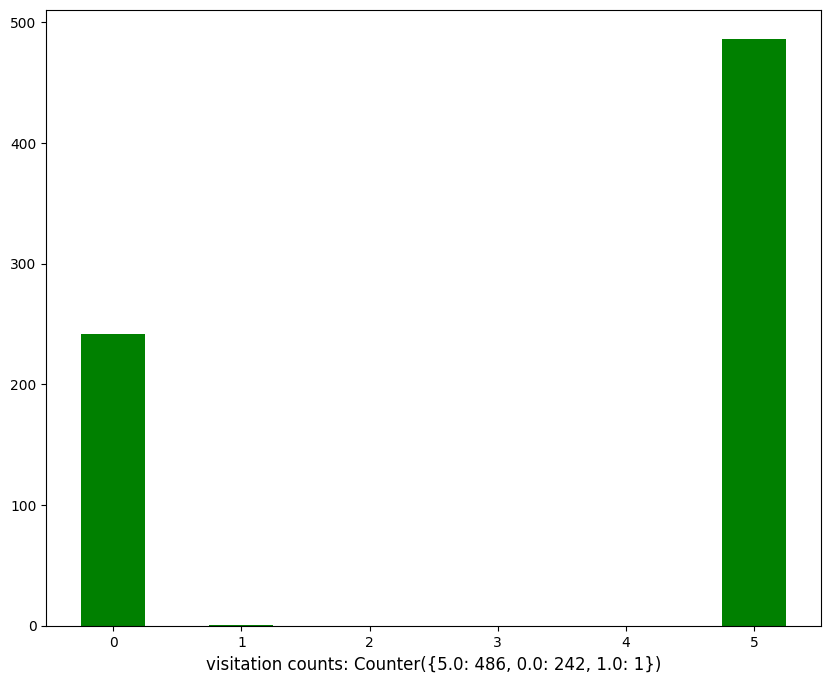

In [3]:
#generate histogram
visit_dict = {}
for i in range(len(rmax.nSA.flatten().tolist())):
    visit_dict[i]= rmax.nSA.flatten().tolist()[i]
    
histogram_dict = Counter(visit_dict.values())
plt.bar(histogram_dict.keys(), histogram_dict.values(), 0.5, color='g')
plt.xlabel("visitation counts: " + str(histogram_dict), fontsize=12)
figure0 = plt.gcf()
figure0.set_size_inches(10, 8)
plt.savefig('histogram at' + str(datetime.now()) + '.png')

NameError: name 'inner_gamma' is not defined

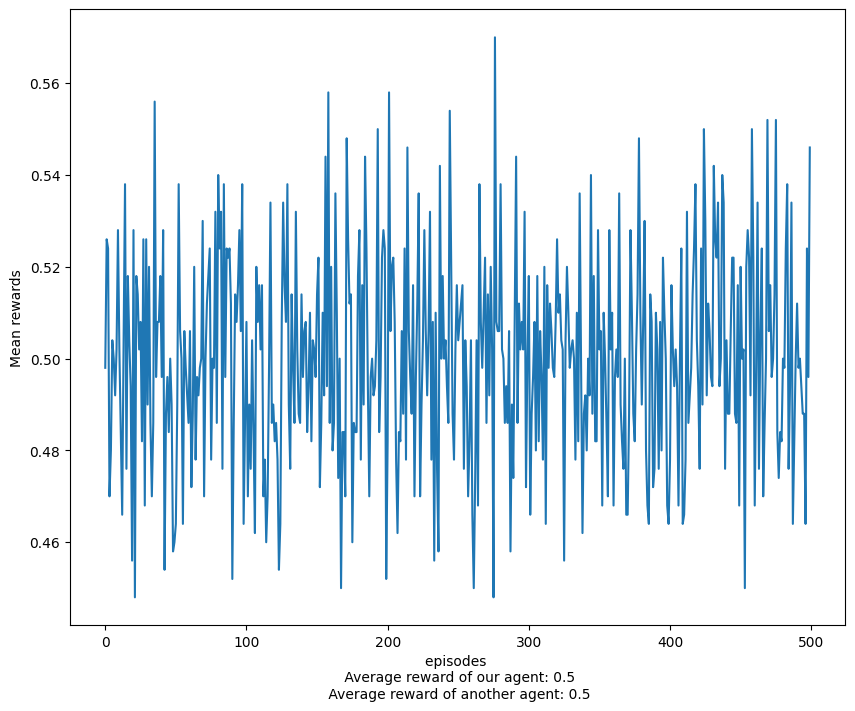

In [4]:
#generate reward mean
plot_rew_mean = torch.mean(plot_rew[:,:,0],1)
fig_handle = plt.plot(plot_rew_mean.cpu().numpy())

plt.xlabel("episodes \n Average reward of our agent: " + str(round(torch.mean(plot_rew[:,:,0],(0,1)).detach().item(), 3)) + 
          "\n Average reward of another agent: " + str(round(torch.mean(plot_rew[:,:,1],(0,1)).detach().item(), 3)))

plt.ylabel("Mean rewards")

figure2 = plt.gcf() # get current figure
figure2.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_mp1.png'  , dpi = 100)
plt.clf()


In [7]:
#generate learning curve at start
plot_rew_epi_start = torch.mean(plot_rew[:int(meta_epi*0.1), :, 0], 0)
fig_handle = plt.plot(plot_rew_epi_start.cpu().numpy())

plt.xlabel("steps")

plt.ylabel("Average learning rate of first " + str(int(meta_epi*0.1)) + " episodes")

figure3 = plt.gcf() # get current figure
figure3.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_first_epi_mp1.png' , dpi = 100)
plt.clf()

<Figure size 1000x800 with 0 Axes>

In [8]:
#generate learning curve at end
plot_rew_epi_end = torch.mean(plot_rew[-int(meta_epi*0.1):, :, 0], 0)
fig_handle = plt.plot(plot_rew_epi_end.cpu().numpy())

plt.xlabel("steps")

plt.ylabel("Average learning rate of last " + str(int(meta_epi*0.1)) + " episodes")

figure4 = plt.gcf() # get current figure
figure4.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_last_epi_mp1.png' , dpi = 100)
plt.clf()

<Figure size 1000x800 with 0 Axes>

# Interpreting results 

In [2]:
import glob
path1 = "memory*.pkl"
path2 = "plot_rew*.pkl"
path3 = "rmax*.pkl"
for filename in glob.glob(path1):
    with open(filename, 'rb') as f:
        memory = pickle.load(f)
        
for filename in glob.glob(path2):    
    with open(filename, 'rb') as g:
        plot_rew = pickle.load(g)
        
for filename in glob.glob(path3):    
    with open(filename, 'rb') as g:
        rmax = pickle.load(g)        